## 深度視覺與電腦視覺馬拉松期末專題目標
1. 訓練一個模型同時能辨識出浣熊 (raccoon) 與袋鼠 (kangaroo) 的類別與位置/或自行定義問題。
2. 使用預訓練模型以及其在影像辨識中的作用，運用模型，辨識驗證資料集 (test data) 的效果，並透過指標判斷模型的優劣，觀察模型辨識出的結果與後續可以往哪一方面改善。
3. 把影片 (檢視範例例內為範例例影片) 中的袋鼠與浣熊的位置找出來 (專題結果可自行找影片進行測試)。

In [0]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0


In [0]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 46.6MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


# 目標一、同時能辨識出浣熊 (raccoon) 與袋鼠 (kangaroo) 的類別與位置的模型
## 1. 資料集前處理

In [0]:
# 下載 raccoon 資料集
if not os.path.exists("raccoon_data"):
    os.system("wget -O raccoon_data.zip https://github.com/experiencor/raccoon_dataset/archive/master.zip")
    !unzip raccoon_data.zip
    !mv raccoon_dataset-master raccoon_data
else:
    print("data exists")

In [0]:
# 下載 kangaroo 資料集
if not os.path.exists("kangaroo_data"):
    if not os.path.exists("kangaroo_data.zip"):
        os.system("wget -O kangaroo_data.zip https://github.com/experiencor/kangaroo/archive/master.zip")
    !unzip kangaroo_data.zip
    !mv kangaroo-master kangaroo_data
else:
    print("data exists")

Archive:  kangaroo_data.zip
882bbbd75ba49cb8cf9393e06d88ebaec293af32
   creating: kangaroo-master/
  inflating: kangaroo-master/README.md  
   creating: kangaroo-master/annots/
  inflating: kangaroo-master/annots/00001.xml  
  inflating: kangaroo-master/annots/00002.xml  
  inflating: kangaroo-master/annots/00003.xml  
  inflating: kangaroo-master/annots/00004.xml  
  inflating: kangaroo-master/annots/00005.xml  
  inflating: kangaroo-master/annots/00006.xml  
  inflating: kangaroo-master/annots/00007.xml  
  inflating: kangaroo-master/annots/00009.xml  
  inflating: kangaroo-master/annots/00010.xml  
  inflating: kangaroo-master/annots/00011.xml  
  inflating: kangaroo-master/annots/00012.xml  
  inflating: kangaroo-master/annots/00013.xml  
  inflating: kangaroo-master/annots/00014.xml  
  inflating: kangaroo-master/annots/00016.xml  
  inflating: kangaroo-master/annots/00017.xml  
  inflating: kangaroo-master/annots/00018.xml  
  inflating: kangaroo-master/annots/00019.xml  
  infla

## 整理資料
### 1. 浣熊資料
- 標注資料：./raccoon_data/annotations/raccoon-{sequence}.xml
```xml
<annotation verified="yes">
	<folder>images</folder>
	<filename>raccoon-1.jpg</filename>
	<path>/Users/datitran/Desktop/raccoon/images/raccoon-1.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>650</width>
		<height>417</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>raccoon</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>81</xmin>
			<ymin>88</ymin>
			<xmax>522</xmax>
			<ymax>408</ymax>
		</bndbox>
	</object>
</annotation>
```
- 影像資料：./raccoon_data/images/raccoon-{sequence}.jpg

### 2. 袋鼠資料
- 標注資料：./kangaroo_data/annots/{5d-sequence}.xml
```xml
<annotation>
	<folder>Kangaroo</folder>
	<filename>00001.jpg</filename>
	<path>/home/andy/Desktop/Kangaroo/stock-photo-two-kids-in-the-zoo-feeding-kangaroo-296180786.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>450</width>
		<height>319</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>233</xmin>
			<ymin>89</ymin>
			<xmax>386</xmax>
			<ymax>262</ymax>
		</bndbox>
	</object>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>134</xmin>
			<ymin>105</ymin>
			<xmax>341</xmax>
			<ymax>253</ymax>
		</bndbox>
	</object>
</annotation>
```
- 影像資料：./kangaroo_data/images/{5d-sequence}.jpg

由上面整理2個資料來源的資料得知，讀取標注資料時，路徑不相同 (annotations vs annots)

另外，原本的程式碼，會直接讀取train_list和val_list，目前2個資料集皆無這樣的資料，所以應先整理這樣清單的資料，符合原本的流程



In [0]:
# 讀取raccoon_data/images資料夾，建立image list
import glob
def prepare_image_list(image_path, list_file):
    image_list = glob.glob(image_path+'*.jpg')
    with open(list_file, 'w') as f:
        for item in image_list:
            f.write("%s\n" % item)
    return image_list

raccoon_image_path = './raccoon_data/images/'
raccoon_list = prepare_image_list(raccoon_image_path, 'raccoon_list.txt')

kangaroo_image_path = './kangaroo_data/images/'
kangaroo_list = prepare_image_list(kangaroo_image_path, 'kangaroo_list.txt')

print(raccoon_list)
print(kangaroo_list)



['./raccoon_data/images/raccoon-27.jpg', './raccoon_data/images/raccoon-28.jpg', './raccoon_data/images/raccoon-200.jpg', './raccoon_data/images/raccoon-14.jpg', './raccoon_data/images/raccoon-193.jpg', './raccoon_data/images/raccoon-62.jpg', './raccoon_data/images/raccoon-25.jpg', './raccoon_data/images/raccoon-150.jpg', './raccoon_data/images/raccoon-41.jpg', './raccoon_data/images/raccoon-7.jpg', './raccoon_data/images/raccoon-143.jpg', './raccoon_data/images/raccoon-182.jpg', './raccoon_data/images/raccoon-180.jpg', './raccoon_data/images/raccoon-57.jpg', './raccoon_data/images/raccoon-188.jpg', './raccoon_data/images/raccoon-60.jpg', './raccoon_data/images/raccoon-16.jpg', './raccoon_data/images/raccoon-93.jpg', './raccoon_data/images/raccoon-53.jpg', './raccoon_data/images/raccoon-17.jpg', './raccoon_data/images/raccoon-5.jpg', './raccoon_data/images/raccoon-20.jpg', './raccoon_data/images/raccoon-37.jpg', './raccoon_data/images/raccoon-50.jpg', './raccoon_data/images/raccoon-151

### 訓練時的驗證資料在訓練時的前處理會再分開，所以目前僅將影像僅區分為訓練 (raccoon_train、kangaroo_train) 和測試 (raccoon_test、kangaroo_test)，清單中為image路徑，也和原課程範例不一樣

In [0]:
import numpy as np
categories = ['raccoon', 'kangaroo']
def prepare_train_test(categories, ratio):
    for category in categories:
        train_list, test_list = read_class_list(category, ratio)
        with open(category+'_train.txt', 'w') as f:
            for item in train_list:
                f.write("%s\n" % item)
        
        with open(category+'_test.txt', 'w') as f:
            for item in test_list:
                f.write("%s\n" % item)
    


def read_class_list(category, ratio):
    list_file = category + '_list.txt'
    with open(list_file) as f:
        image_list = [line.rstrip('\n') for line in f]
    np.random.seed(10000)
    np.random.shuffle(image_list)
    np.random.seed(None)
    num_list = len(image_list)
    num_test = int(num_list*ratio)
    print('getting {} test data and {} train data from {} list ({})'.format(num_test, num_list-num_test, category, num_list))
    test = image_list[:num_test]
    train = image_list[num_test:]
    return train, test

test_ratio = 0.1
prepare_train_test(categories, 0.1)


getting 20 test data and 180 train data from raccoon list (200)
getting 16 test data and 148 train data from kangaroo list (164)


In [0]:
# test if the list file is ok
with open('raccoon_train.txt') as f:
    image_list = [line.rstrip('\n') for line in f]
    print(image_list)
with open('kangaroo_test.txt') as f:
    image_list = [line.rstrip('\n') for line in f]
    print(image_list)

['./raccoon_data/images/raccoon-106.jpg', './raccoon_data/images/raccoon-48.jpg', './raccoon_data/images/raccoon-3.jpg', './raccoon_data/images/raccoon-100.jpg', './raccoon_data/images/raccoon-37.jpg', './raccoon_data/images/raccoon-108.jpg', './raccoon_data/images/raccoon-129.jpg', './raccoon_data/images/raccoon-151.jpg', './raccoon_data/images/raccoon-13.jpg', './raccoon_data/images/raccoon-152.jpg', './raccoon_data/images/raccoon-173.jpg', './raccoon_data/images/raccoon-40.jpg', './raccoon_data/images/raccoon-59.jpg', './raccoon_data/images/raccoon-7.jpg', './raccoon_data/images/raccoon-2.jpg', './raccoon_data/images/raccoon-10.jpg', './raccoon_data/images/raccoon-191.jpg', './raccoon_data/images/raccoon-123.jpg', './raccoon_data/images/raccoon-115.jpg', './raccoon_data/images/raccoon-105.jpg', './raccoon_data/images/raccoon-107.jpg', './raccoon_data/images/raccoon-62.jpg', './raccoon_data/images/raccoon-190.jpg', './raccoon_data/images/raccoon-119.jpg', './raccoon_data/images/racco

直接引用 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，但原本的程式是分年份和資料集 (例如2007_train、2007_val)，而且讀取標注和影像的路徑都比較一致，但期末專題的資料集來源有2個 (浣熊和袋鼠)，在先前已將影像清單分為raccoon_train、raccoon_test與kangaroo_train和kagaroo_test，所以調整了一部分程式碼，讓我們可以從不同資料集資料清單，收集成train_data和test_data等2個annotation data

In [0]:
import os
if not os.path.exists("train_data.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd
    from os import path

    annots = {'raccoon': './raccoon_data/annotations/', 'kangaroo': './kangaroo_data/annots/'}
    sets=['train', 'test']

    # 專題的辨識目標 
    categories = ['raccoon', 'kangaroo']

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(annot_path, image_id, list_file):
        image_id = path.splitext(path.basename(image_file))[0]
        in_file = open('%s%s.xml' % (annot_path, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in categories or int(difficult)==1:
                continue
            cls_id = categories.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

        wd = "."

    for image_set in sets:
        annotation_path = '%s_data.txt'%(image_set)
        with open(annotation_path, 'a') as list_file:
            print("save annotation at %s" % annotation_path)
            for category in categories:
                image_files = open('%s_%s.txt'%(category, image_set)).read().strip().split()
                for image_file in image_files:
                    list_file.write(image_file)
                    convert_annotation(annots[category], image_file, list_file)
                    list_file.write('\n')
else:
    print('annotation data is existed!!')

save annotation at train_data.txt
save annotation at test_data.txt


## 2. 訓練模型

In [0]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

Using TensorFlow backend.


把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [0]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Converting pretrained YOLOv3 weights for training


In [0]:
%ls model_data

coco_classes.txt        voc_classes.txt   yolo_weights.h5
cvmarathon_classes.txt  yolo_anchors.txt
tiny_yolo_anchors.txt   yolo.h5


In [0]:
# predefined parameters
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

annotation_path = 'train_data.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/cvmarathon_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

In [0]:
# training specification
is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 296 samples, val on 32 samples, with batch size 16.
Epoch 1/50
18/18 [==============================] - 101s 6s/step - loss: 5538.8080 - val_loss: 1798.0620

Epoch 2/50
18/18 [==============================] - 20s 1s/step - loss: 967.1290 - val_loss: 505.6678
Epoch 3/50
18/18 [==============================] - 22s 1s/step - loss: 368.4919 - val_loss: 272.5693
Epoch 4/50
18/18 [==============================] - 11s 585ms/step - loss: 232.6313 - val_loss: 211.1880
Epoch 5/50
18/18 [==============================] - 21s 1s/step - loss: 179.5364 - val_loss: 156.4781
Epoch 6/50
18/18 [==============================] - 22s 1s/step - loss: 148.9174 - val_loss: 132.0938
Epoch 7/50
18/18 [==============================] - 22s 1s/step - loss: 128.6139 - val_loss: 112.8685
Epoch 8/50
18/18 [==============================] - 22s 1s/step - loss: 109.6689 - val_loss: 99.1260
Epoch 9/50
18/18 [=========

# 目標二、運用模型，辨識驗證資料集 (test data) 的效果，並透過指標判斷模型的優劣
## 1. 偵測演算法：根據Day39的練習，將detect_image程式搬移過來

In [0]:
# 將 yolo.py 所需要的套件載入
import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model
# 定義 YOLO class
class YOLO(object):
    _defaults = {
        "model_path": 'model_data/yolo.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/coco_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    # 更改 detect_image 使得其回傳需要的信息
    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        # return image # Hint: 在這裡更改程式碼即可
        return out_boxes, out_scores, out_classes, image

    def close_session(self):
        self.sess.close()

### 拿一張測試影像來測試是否YOLO可正常偵測

In [0]:
# 拿一張測試影像
from PIL import Image
image = Image.open('./raccoon_data/images/raccoon-3.jpg') 













logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 0) (720, 480)
7.767178567999963


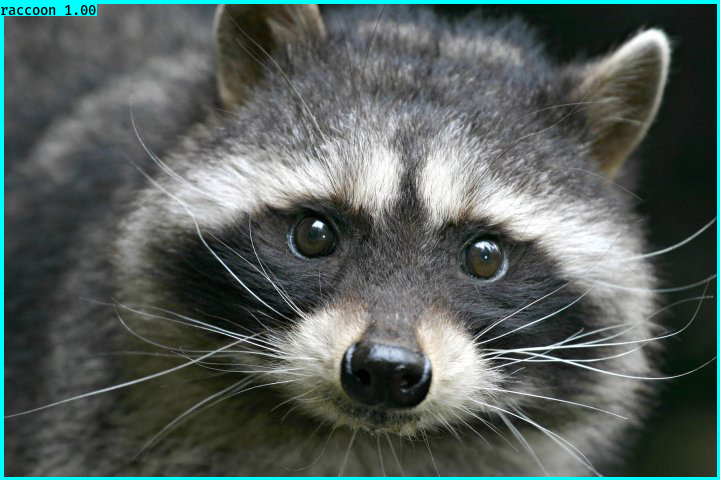

In [0]:
# from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
out_boxes, out_scores, out_classes, r_image = yolo_model.detect_image(image)
r_image

In [0]:
print(out_boxes, out_scores, out_classes)

[[-9.8234081e+00 -2.7302742e-01  4.8061865e+02  7.3130847e+02]] [0.9997265] [0]


# 2. 檢測測試資料計算指標判斷模型優劣
- 根據提示給的參考資訊 https://blog.objectivity.co.uk/comparing-object-detection-models/ 評估的方法如下：
1. 給一個IOU的threshold，用來評斷為positive or negative
2. 偵測結果，並依照信心度逆序排列，並連結它所在的圖片和ground truth
3. 每個偵測結果進行以下運算
    (1) 和相同分類的ground truth計算IOU
    (2) 若IOU >= fixed IOU threshold則為True Positive
    (3) 計算以下數值：TP count, Precision, Recall
4. 統計步驟3的所有數值
5. 以Recal分為11個級別 (0, 0.1, 0.2..., 1.0)，分別計算>=Recall的所有Recall的最大的Precision，這11個級別的平均，即為average precision (AP)
6. 為每個類別計算AP之後，平均即為mAP



### 由Day25取得IOU的計算函數，並統一box的格式
- 輸出的out_box為top, left, bottom, right
- 標注的box為xmin (left), ymin (top), xmax (right), ymax (bottom)
- Day025的IOU輸入格式為 left, top, right, bottom，所以需調整輸出的out_box的次序

In [0]:
def IOU(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    '''找出比較大的X0'''
    xA = max(boxA[0], boxB[0])
    '''找出比較大的y0'''
    yA = max(boxA[1], boxB[1])
    '''找出比較小的X1'''
    xB = min(boxA[2], boxB[2])
    '''找出比較小的y1'''
    yB = min(boxA[3], boxB[3])

    ## 計算交集區域
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    ## 計算各自的BBOX大小
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    ## 計算IOU
    '''交集/聯集'''
    iou = interArea / (boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

### 從raccoon_test和kangroo_test分別取出測試資料評估，然後分別計算個別的AP


In [0]:
# 取出測試資料
num_raccoon_test = 20
image_list = []
with open('test_data.txt') as f:
    image_list = [line.rstrip('\n') for line in f]


In [0]:
# 解析測試資料格式，並取出annotation資訊
def parse_annotation(annot_str):
    annot_list = annot_str.split(' ')
    image_file = annot_list[0]
    annotations = annot_list[1:]
    annot_list = []
    for annot in annotations:
        annot_list.append([int(num) for num in annot.split(',')])
    return image_file, annot_list

image_file, annots = parse_annotation(image_list[0])
print(image_file, annots)

./raccoon_data/images/raccoon-142.jpg [[171, 162, 811, 740, 0]]


In [0]:
# 執行測試資料偵測並存於dataframe中，並輸出至csv，方便後續取出運算
import pandas as pd
raccoon_test_df = pd.DataFrame(columns=('ImageFile', 'score', 'box', 'class', 'ImageID'))
kangroo_test_df = pd.DataFrame(columns=('ImageFile', 'score', 'box', 'class', 'ImageID'))
testset_detections = [raccoon_test_df, kangroo_test_df]



for i in range(len(image_list)):
    image_file, annots = parse_annotation(image_list[i])
    print('detecting image:%s' % image_file)

    image = Image.open(image_file)
    out_boxes, out_scores, out_classes, r_image = yolo_model.detect_image(image)
    for idx, c in reversed(list(enumerate(out_classes))):
        out = out_boxes[idx]
        score = out_scores[idx]
        print('detectioin found: ')
        detection = {'ImageFile': image_file, 'score': score, 'box': [out[1], out[0], out[3], out[2]], 'class': c, 'ImageID': i}
        detection_series = pd.Series(detection)
        testset_detections[c] = testset_detections[c].append(detection_series, ignore_index=True)
testset_detections[0].to_csv('raccoon_test_detections.csv', encoding='utf-8')
testset_detections[1].to_csv('kangroo_test_detections.csv', encoding='utf-8')

[[171, 162, 811, 740, 0]]
detecting image:./raccoon_data/images/raccoon-142.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (154, 176) (855, 684)
0.09266898499998888
detectioin found: 
[[141, 6, 472, 505, 0]]
detecting image:./raccoon_data/images/raccoon-74.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (154, 0) (476, 493)
0.08118814900001325
detectioin found: 
[[1, 63, 885, 1042, 0]]
detecting image:./raccoon_data/images/raccoon-194.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1028, 1080)
0.10032299799996736
detectioin found: 
[[1, 5, 175, 195, 0]]
detecting image:./raccoon_data/images/raccoon-167.jpg
(416, 416, 3)
Found 2 boxes for img
raccoon 0.46 (147, 0) (259, 110)
raccoon 1.00 (0, 4) (174, 190)
0.07218346999997038
detectioin found: 
detectioin found: 
[[127, 160, 298, 289, 0]]
detecting image:./raccoon_data/images/raccoon-192.jpg
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (127, 157) (326, 294)
0.07290902400001187
detectioin found: 
[[23, 2, 166, 2

In [0]:
# 儲存與取出dataframe
import pandas as pd
# testset_detections[0].to_csv('raccoon_test_detections.csv', encoding='utf-8')
# testset_detections[1].to_csv('kangroo_test_detections.csv', encoding='utf-8')
raccoon_test_df = pd.read_csv('raccoon_test_detections.csv', encoding='utf-8', index_col=0)
kangroo_test_df = pd.read_csv('kangroo_test_detections.csv', encoding='utf-8', index_col=0)
testset_detections = [raccoon_test_df, kangroo_test_df]

### 評估浣熊Average Precision

In [0]:
# 整理annotations資料，以類別和影像為id，儲存為字典格式 (方便以類別和影像index取得annotations)
def total_annot_collecting(annot_list):
    class_collect = {}
    class_count = {}
    for image_id, annot_str in enumerate(annot_list):
        image_file, annots = parse_annotation(annot_str)
        for annot in annots:
            box = annot[:4]
            class_idx = annot[-1]
            image_annots = {'class_id': class_idx, 'box': box, 'found': False}
            if class_idx in class_collect:
                if image_id in class_collect[class_idx]:
                    class_collect[class_idx][image_id].append(image_annots)
                else:
                    class_collect[class_idx][image_id] = [image_annots]
            else:
                class_collect[class_idx] = {}
                class_collect[class_idx][image_id] = [image_annots]

            if class_idx in class_count:
                class_count[class_idx] += 1
            else:
                class_count[class_idx] = 1
        
    return class_count, class_collect

class_count, class_collect = total_annot_collecting(image_list)
print(class_count)
# print(class_collect)

{0: 20, 1: 25}


In [0]:
def eva_detection_right(detect, class_collect, stats):
    is_tp = 0
    stats['cumu_detect'] += 1
    if detect['ImageID'] in class_collect[detect['class']]:
        for label in class_collect[detect['class']][detect['ImageID']]:
            if label['found']:
                continue
            iou = IOU(detect['box'], label['box'])
            if iou >= iou_threshold:
                is_tp = 1
                label['found'] = True
                stats['tp_count'] += is_tp
                break
    return pd.Series([detect['score'], is_tp, stats['tp_count'], stats['tp_count']/stats['cumu_detect'], stats['tp_count']/stats['class_total']], index=['Confidence', 'Is TP?', 'TP Count', 'Precision', 'Recall'])

In [0]:
# 計算Average Precision步驟一：評估true positive演算法
def total_annot_collecting(annot_list):
    class_collect = {}
    class_count = {}
    for image_id, annot_str in enumerate(annot_list):
        image_file, annots = parse_annotation(annot_str)
        for annot in annots:
            box = annot[:4]
            class_idx = annot[-1]
            image_annots = {'class_id': class_idx, 'box': box, 'found': False}
            if class_idx in class_collect:
                if image_id in class_collect[class_idx]:
                    class_collect[class_idx][image_id].append(image_annots)
                else:
                    class_collect[class_idx][image_id] = [image_annots]
            else:
                class_collect[class_idx] = {}
                class_collect[class_idx][image_id] = [image_annots]

            if class_idx in class_count:
                class_count[class_idx] += 1
            else:
                class_count[class_idx] = 1
        
    return class_count, class_collect

# evaluate raccoon
class_count, class_collect = total_annot_collecting(image_list)
iou_threshold = 0.5
stats = {'cumu_detect': 0, 'tp_count': 0, 'class_total': class_count[0]}
raccoon_eva_df = pd.DataFrame(columns=('Confidence', 'Is TP?', 'TP Count', 'Precision', 'Recall'))
for index, row in testset_detections[0].sort_values(by='score', ascending=False).iterrows():
    raccoon_eva_df = raccoon_eva_df.append(eva_detection_right(row, class_collect, stats), ignore_index=True)
raccoon_eva_df.head()

,Confidence,Is TP?,TP Count,Precision,Recall
0,0.999611,1.0,1.0,1.0,0.05
1,0.999177,1.0,2.0,1.0,0.10
2,0.999154,1.0,3.0,1.0,0.15
3,0.999062,1.0,4.0,1.0,0.20
4,0.999052,1.0,5.0,1.0,0.25


In [0]:
# evaluate kangroo
class_count, class_collect = total_annot_collecting(image_list)
iou_threshold = 0.5
stats = {'cumu_detect': 0, 'tp_count': 0, 'class_total': class_count[1]}
kangroo_eva_df = pd.DataFrame(columns=('Confidence', 'Is TP?', 'TP Count', 'Precision', 'Recall'))
for index, row in testset_detections[1].sort_values(by='score', ascending=False).iterrows():
    kangroo_eva_df = kangroo_eva_df.append(eva_detection_right(row, class_collect, stats), ignore_index=True)
kangroo_eva_df.head()

,Confidence,Is TP?,TP Count,Precision,Recall
0,0.998657,1.0,1.0,1.0,0.04
1,0.998166,1.0,2.0,1.0,0.08
2,0.996935,1.0,3.0,1.0,0.12
3,0.994282,1.0,4.0,1.0,0.16
4,0.992426,1.0,5.0,1.0,0.20


In [0]:
import pandas as pd
# raccoon_eva_df.to_csv('raccoon_evaluations.csv', encoding='utf-8')
# kangroo_eva_df.to_csv('kangroo_evaluations.csv', encoding='utf-8')
raccoon_eva_df = pd.read_csv('raccoon_evaluations.csv', encoding='utf-8', index_col=0)
kangroo_eva_df = pd.read_csv('kangroo_evaluations.csv', encoding='utf-8', index_col=0)

In [9]:
# 計算浣熊辨識的AP
import numpy as np
ranks = np.arange(0.0, 1.1, 0.1)

raccoon_ap_df = pd.DataFrame(columns=('Rti', 'Prec.'))
for rank in ranks:
    rank_max = raccoon_eva_df[raccoon_eva_df['Recall']>=rank]['Precision'].values.max()
    raccoon_ap_df = raccoon_ap_df.append(pd.Series({'Rti': round(rank, 2), 'Prec.': rank_max}), ignore_index=True)

raccoon_ap_df.to_csv('raccoon_ap_list.csv', encoding='utf-8')
print('The AP of the detections of raccoon is %s' % raccoon_ap_df['Prec.'].mean())

The AP of the detections of raccoon is 0.983596837944664


In [0]:
# 計算袋鼠辨識的AP
ranks = np.arange(0.0, 1.1, 0.1)

kangroo_ap_df = pd.DataFrame(columns=('Rti', 'Prec.'))
for rank in ranks:
    sieved = kangroo_eva_df[kangroo_eva_df['Recall']>=rank]
    if len(sieved.index.values) > 0:
        rank_max = sieved['Precision'].values.max()
        kangroo_ap_df = kangroo_ap_df.append(pd.Series({'Rti': round(rank, 2), 'Prec.': rank_max}), ignore_index=True)
    else:
        break

kangroo_ap_df.to_csv('kangroo_ap_list.csv', encoding='utf-8')
print('The AP of the detections of kangroo is %s' % kangroo_ap_df['Prec.'].mean())

The AP of the detections of kangroo is 0.9903381642512077


In [0]:
# meanAP
mAP = (raccoon_ap_df['Prec.'].mean() + kangroo_ap_df['Prec.'].mean())/2
print(mAP)

0.9869675010979359


## 目標三、把範例影片中的袋鼠與浣熊的位置找出來
- 輸出浣熊偵測影像 Raccoon-out.mp4
- 輸出袋鼠偵測影像 Kangroo-out.mp4

### 依提示給予的範例https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/3.5-yolov2-train-hands-dataset.ipynb，取得下列程式碼，但延用原本Day41的偵測影像方式，輸出偵測結果

In [0]:
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow
def detect_video(yolo, video_file, output_file):

    # 透過OpenCv擷取影像
    video_reader = cv2.VideoCapture(video_file)
    if (video_reader.isOpened()== False):
        print("Error opening video stream or file")
    
    # Read until video is completed

    # 取得影像的基本資訊
    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # 總共有多少frames
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))  # 每個frame的高
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))   # 每個frame的寬
    print('Video % specifications:' % video_inp, nb_frames, frame_h, frame_w)
    # 設定影像的輸出
    video_writer = cv2.VideoWriter(output_file,
                                cv2.VideoWriter_fourcc(*'XVID'), 
                                50.0, 
                                (frame_w, frame_h))

    # 迭代每一個frame來進行圖像偵測
    for i in tqdm(range(nb_frames)):
        ret, image = video_reader.read() # 讀取一個frame
        if image is None:
            break
        im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # im_rgb = image[:, :, [2, 1, 0]]
        
        im = Image.fromarray(im_rgb)
        # input_image = cv2.resize(image, (416, 416)) # 修改輸入圖像大小來符合模型的要求
        # input_image = input_image / 255. # 進行圖像歸一處理
        # input_image = np.expand_dims(input_image, 0) # 增加 batch dimension
        # 進行圖像偵測
        out_boxes, out_scores, out_classes, r_image = yolo.detect_image(im)
        r_image = np.asarray(r_image)

        # 透過OpenCV把影像輸出出來
        video_writer.write(np.uint8(r_image[:,:,::-1])) # 轉換 RGB -> BGR來讓Open CV寫Video
        # video_writer.write(np.uint8(r_image))
        
    video_reader.release() # 釋放資源
    video_writer.release() # 釋放資源


In [0]:
# detect raccoon
detect_video(yolo_model, './Raccoon.mp4', './Raccoon-out.mp4')






  0%|          | 0/1800 [00:00<?, ?it/s]




  0%|          | 1/1800 [00:00<03:40,  8.17it/s]

Video ./Raccoon.mp4pecifications: 1800 720 1280
(416, 416, 3)
Found 0 boxes for img
0.07566736499938997
(416, 416, 3)







  0%|          | 2/1800 [00:00<03:33,  8.43it/s]




  0%|          | 3/1800 [00:00<03:27,  8.67it/s]

Found 0 boxes for img
0.07705993299987313
(416, 416, 3)
Found 0 boxes for img
0.07159833799960325
(416, 416, 3)







  0%|          | 4/1800 [00:00<03:19,  8.99it/s]

Found 0 boxes for img
0.07148910100022476
(416, 416, 3)
Found 0 boxes for img
0.07074997699965024
(416, 416, 3)
Found 0 boxes for img
0.06914245699954336







  0%|          | 6/1800 [00:00<03:11,  9.38it/s]




  0%|          | 7/1800 [00:00<03:07,  9.56it/s]




  0%|          | 8/1800 [00:00<03:06,  9.63it/s]

(416, 416, 3)
Found 0 boxes for img
0.07142744100019627
(416, 416, 3)
Found 0 boxes for img
0.06999546400038525







  0%|          | 9/1800 [00:00<03:06,  9.62it/s]




  1%|          | 10/1800 [00:01<03:07,  9.55it/s]

(416, 416, 3)
Found 0 boxes for img
0.07076559599954635
(416, 416, 3)
Found 0 boxes for img
0.07165189199986344







  1%|          | 11/1800 [00:01<03:05,  9.64it/s]

(416, 416, 3)
Found 0 boxes for img
0.07174620400019194
(416, 416, 3)
Found 0 boxes for img
0.07051907799996116
(416, 416, 3)







  1%|          | 13/1800 [00:01<03:00,  9.88it/s]

Found 0 boxes for img
0.06932928199967137
(416, 416, 3)
Found 0 boxes for img
0.07367267500012531
(416, 416, 3)
Found 0 boxes for img
0.07122102500034089







  1%|          | 15/1800 [00:01<02:57, 10.05it/s]




  1%|          | 17/1800 [00:01<02:55, 10.17it/s]

(416, 416, 3)
Found 0 boxes for img
0.07146499499958736
(416, 416, 3)
Found 0 boxes for img
0.06969604899950355
(416, 416, 3)







  1%|          | 19/1800 [00:01<02:52, 10.33it/s]

Found 0 boxes for img
0.07106464899970888
(416, 416, 3)
Found 0 boxes for img
0.06940333100010321
(416, 416, 3)
Found 0 boxes for img
0.07152171800044016







  1%|          | 21/1800 [00:02<02:52, 10.34it/s]

(416, 416, 3)
Found 0 boxes for img
0.07312883400027204
(416, 416, 3)
Found 0 boxes for img
0.07137840399991546
(416, 416, 3)







  1%|▏         | 23/1800 [00:02<02:50, 10.40it/s]

Found 0 boxes for img
0.06950049399983982
(416, 416, 3)
Found 0 boxes for img
0.07412753199969302
(416, 416, 3)
Found 0 boxes for img
0.07159331000002567







  1%|▏         | 25/1800 [00:02<02:54, 10.17it/s]




  2%|▏         | 27/1800 [00:02<02:54, 10.18it/s]

(416, 416, 3)
Found 0 boxes for img
0.07130279099965264
(416, 416, 3)
Found 0 boxes for img
0.06917186899954686
(416, 416, 3)







  2%|▏         | 29/1800 [00:02<02:51, 10.32it/s]

Found 0 boxes for img
0.0690794640004242
(416, 416, 3)
Found 0 boxes for img
0.06870604600044317
(416, 416, 3)
Found 0 boxes for img
0.06849434800005838







  2%|▏         | 31/1800 [00:03<02:53, 10.22it/s]

(416, 416, 3)
Found 0 boxes for img
0.07497564099958254
(416, 416, 3)
Found 0 boxes for img
0.0679209339996305
(416, 416, 3)







  2%|▏         | 33/1800 [00:03<02:52, 10.23it/s]

Found 0 boxes for img
0.07339825100007147
(416, 416, 3)
Found 0 boxes for img
0.06996609699945111
(416, 416, 3)
Found 0 boxes for img
0.06938057400020625







  2%|▏         | 35/1800 [00:03<02:51, 10.29it/s]




  2%|▏         | 37/1800 [00:03<02:53, 10.16it/s]

(416, 416, 3)
Found 0 boxes for img
0.0736306290000357
(416, 416, 3)
Found 0 boxes for img
0.07301124500008882







  2%|▏         | 39/1800 [00:03<02:55, 10.01it/s]

(416, 416, 3)
Found 0 boxes for img
0.07673223500023596
(416, 416, 3)
Found 0 boxes for img
0.07196058200042899







  2%|▏         | 41/1800 [00:04<03:00,  9.77it/s]

(416, 416, 3)
Found 0 boxes for img
0.0781007679997856
(416, 416, 3)
Found 0 boxes for img
0.07337583900061873







  2%|▏         | 42/1800 [00:04<03:12,  9.11it/s]




  2%|▏         | 43/1800 [00:04<03:09,  9.27it/s]

(416, 416, 3)
Found 0 boxes for img
0.08290386900080193
(416, 416, 3)
Found 0 boxes for img
0.0783557060003659







  2%|▎         | 45/1800 [00:04<03:02,  9.61it/s]

(416, 416, 3)
Found 0 boxes for img
0.073309596999934
(416, 416, 3)
Found 0 boxes for img
0.06929845700051374
(416, 416, 3)







  3%|▎         | 47/1800 [00:04<02:56,  9.92it/s]

Found 0 boxes for img
0.06975452700044116
(416, 416, 3)
Found 0 boxes for img
0.06955486999959248
(416, 416, 3)
Found 0 boxes for img
0.07505870600016351







  3%|▎         | 49/1800 [00:04<02:54, 10.03it/s]

(416, 416, 3)
Found 0 boxes for img
0.06966911400013487
(416, 416, 3)
Found 0 boxes for img
0.06891010899926187
(416, 416, 3)







  3%|▎         | 51/1800 [00:05<02:52, 10.14it/s]

Found 0 boxes for img
0.0697676820000197
(416, 416, 3)
Found 0 boxes for img
0.06917133899969485
(416, 416, 3)
Found 0 boxes for img
0.06910889399932785







  3%|▎         | 53/1800 [00:05<02:50, 10.22it/s]




  3%|▎         | 55/1800 [00:05<02:49, 10.29it/s]

(416, 416, 3)
Found 0 boxes for img
0.06945673300015187
(416, 416, 3)
Found 0 boxes for img
0.069420116999936
(416, 416, 3)







  3%|▎         | 57/1800 [00:05<02:48, 10.33it/s]

Found 0 boxes for img
0.06954182099980244
(416, 416, 3)
Found 0 boxes for img
0.07039969899960852
(416, 416, 3)
Found 0 boxes for img
0.06966870799988101







  3%|▎         | 59/1800 [00:05<02:47, 10.37it/s]

(416, 416, 3)
Found 0 boxes for img
0.06904223599940451
(416, 416, 3)
Found 0 boxes for img
0.07211821700002474
(416, 416, 3)







  3%|▎         | 61/1800 [00:06<02:48, 10.30it/s]

Found 0 boxes for img
0.06874219699966488
(416, 416, 3)
Found 0 boxes for img
0.0720070819998
(416, 416, 3)







  4%|▎         | 63/1800 [00:06<02:50, 10.18it/s]

Found 0 boxes for img
0.0721415710004294
(416, 416, 3)
Found 0 boxes for img
0.06903622800018638
(416, 416, 3)
Found 0 boxes for img
0.0717667850003636







  4%|▎         | 65/1800 [00:06<02:49, 10.25it/s]




  4%|▎         | 67/1800 [00:06<02:47, 10.32it/s]

(416, 416, 3)
Found 0 boxes for img
0.06984167900009197
(416, 416, 3)
Found 0 boxes for img
0.06957081699965784
(416, 416, 3)







  4%|▍         | 69/1800 [00:06<02:48, 10.29it/s]

Found 0 boxes for img
0.06980487799955881
(416, 416, 3)
Found 0 boxes for img
0.06825431900051626
(416, 416, 3)
Found 0 boxes for img
0.06942292400071892






  4%|▍         | 71/1800 [00:07<02:49, 10.20it/s]


(416, 416, 3)
Found 0 boxes for img
0.06871592299921758
(416, 416, 3)
Found 0 boxes for img
0.0684137419993931
(416, 416, 3)







  4%|▍         | 73/1800 [00:07<02:50, 10.16it/s]

Found 0 boxes for img
0.06909058300061588
(416, 416, 3)
Found 0 boxes for img
0.06867400299961446
(416, 416, 3)
Found 0 boxes for img
0.07246846599991841







  4%|▍         | 75/1800 [00:07<02:50, 10.09it/s]




  4%|▍         | 77/1800 [00:07<02:53,  9.96it/s]

(416, 416, 3)
Found 0 boxes for img
0.07316834399989602
(416, 416, 3)
Found 0 boxes for img
0.07254372499937745







  4%|▍         | 78/1800 [00:07<02:54,  9.84it/s]

(416, 416, 3)
Found 0 boxes for img
0.0714802120000968
(416, 416, 3)
Found 0 boxes for img
0.07082654100031505
(416, 416, 3)







  4%|▍         | 80/1800 [00:07<02:52,  9.97it/s]

Found 0 boxes for img
0.07013635400016938
(416, 416, 3)
Found 0 boxes for img
0.07367134200012515
(416, 416, 3)
Found 0 boxes for img
0.06937795700014249







  5%|▍         | 82/1800 [00:08<02:51, 10.02it/s]




  5%|▍         | 84/1800 [00:08<02:51,  9.99it/s]

(416, 416, 3)
Found 0 boxes for img
0.07500597699981881
(416, 416, 3)
Found 0 boxes for img
0.06956513499972061
(416, 416, 3)






  5%|▍         | 86/1800 [00:08<02:50, 10.06it/s]


Found 0 boxes for img
0.07225193899921578
(416, 416, 3)
Found 0 boxes for img
0.07148181999946246
(416, 416, 3)







  5%|▍         | 88/1800 [00:08<02:49, 10.08it/s]

Found 0 boxes for img
0.07228636499985441
(416, 416, 3)
Found 0 boxes for img
0.07067523099976825
(416, 416, 3)
Found 0 boxes for img
0.07503693499984365







  5%|▌         | 90/1800 [00:08<02:48, 10.14it/s]

(416, 416, 3)
Found 0 boxes for img
0.06880709300003218
(416, 416, 3)
Found 0 boxes for img
0.06892783500006772







  5%|▌         | 92/1800 [00:09<02:51,  9.95it/s]




  5%|▌         | 93/1800 [00:09<02:54,  9.75it/s]

(416, 416, 3)
Found 0 boxes for img
0.07338634799998545
(416, 416, 3)
Found 0 boxes for img
0.07067005499993684







  5%|▌         | 94/1800 [00:09<02:57,  9.63it/s]




  5%|▌         | 95/1800 [00:09<02:56,  9.67it/s]

(416, 416, 3)
Found 0 boxes for img
0.06927013599943166
(416, 416, 3)
Found 0 boxes for img
0.07041141799982142







  5%|▌         | 96/1800 [00:09<03:00,  9.45it/s]




  5%|▌         | 97/1800 [00:09<02:57,  9.58it/s]

(416, 416, 3)
Found 0 boxes for img
0.0740702399998554
(416, 416, 3)
Found 0 boxes for img
0.06940122000014526







  5%|▌         | 98/1800 [00:09<02:55,  9.67it/s]




  6%|▌         | 99/1800 [00:09<02:54,  9.74it/s]

(416, 416, 3)
Found 0 boxes for img
0.06962062599995988
(416, 416, 3)
Found 0 boxes for img
0.06933019000007334
(416, 416, 3)







  6%|▌         | 100/1800 [00:09<02:55,  9.69it/s]




  6%|▌         | 101/1800 [00:10<02:55,  9.69it/s]

Found 0 boxes for img
0.07189775400001963
(416, 416, 3)
Found 0 boxes for img
0.07392284399975324
(416, 416, 3)







  6%|▌         | 102/1800 [00:10<02:58,  9.54it/s]

Found 0 boxes for img
0.07735392300037347
(416, 416, 3)
Found 0 boxes for img
0.06895378300032462
(416, 416, 3)
Found 0 boxes for img
0.06802378900010808







  6%|▌         | 104/1800 [00:10<02:54,  9.73it/s]




  6%|▌         | 106/1800 [00:10<02:51,  9.88it/s]

(416, 416, 3)
Found 0 boxes for img
0.06909507400087023
(416, 416, 3)
Found 0 boxes for img
0.07080578499972034
(416, 416, 3)







  6%|▌         | 107/1800 [00:10<02:52,  9.83it/s]

Found 0 boxes for img
0.07008039600077609
(416, 416, 3)
Found 0 boxes for img
0.07032699899991712
(416, 416, 3)
Found 0 boxes for img
0.06989337100003468







  6%|▌         | 109/1800 [00:10<02:48, 10.04it/s]




  6%|▌         | 111/1800 [00:11<02:46, 10.15it/s]

(416, 416, 3)
Found 0 boxes for img
0.07250006799949915
(416, 416, 3)
Found 0 boxes for img
0.0688591460002499
(416, 416, 3)







  6%|▋         | 113/1800 [00:11<02:46, 10.15it/s]

Found 0 boxes for img
0.06975605200022983
(416, 416, 3)
Found 0 boxes for img
0.07462776800002757
(416, 416, 3)
Found 0 boxes for img
0.07190297300076054







  6%|▋         | 115/1800 [00:11<02:45, 10.15it/s]

(416, 416, 3)
Found 0 boxes for img
0.07126125300055719
(416, 416, 3)
Found 0 boxes for img
0.07418769800005975
(416, 416, 3)







  6%|▋         | 117/1800 [00:11<02:45, 10.19it/s]

Found 0 boxes for img
0.07030371499968169
(416, 416, 3)
Found 0 boxes for img
0.072516670999903
(416, 416, 3)
Found 0 boxes for img
0.07138950499938801







  7%|▋         | 119/1800 [00:11<02:47, 10.06it/s]




  7%|▋         | 121/1800 [00:12<02:45, 10.15it/s]

(416, 416, 3)
Found 0 boxes for img
0.06971987699944293
(416, 416, 3)
Found 0 boxes for img
0.069027602999995
(416, 416, 3)







  7%|▋         | 123/1800 [00:12<02:44, 10.22it/s]

Found 0 boxes for img
0.07221816499986744
(416, 416, 3)
Found 0 boxes for img
0.06882901199969638
(416, 416, 3)
Found 0 boxes for img
0.06830345099933766







  7%|▋         | 125/1800 [00:12<02:43, 10.24it/s]

(416, 416, 3)
Found 0 boxes for img
0.07245770199915569
(416, 416, 3)
Found 0 boxes for img
0.06944719599960081
(416, 416, 3)







  7%|▋         | 127/1800 [00:12<02:43, 10.22it/s]

Found 0 boxes for img
0.07120070300061343
(416, 416, 3)
Found 0 boxes for img
0.06874214299932646
(416, 416, 3)







  7%|▋         | 129/1800 [00:12<02:45, 10.07it/s]

Found 0 boxes for img
0.0734442980001404
(416, 416, 3)
Found 0 boxes for img
0.07104723300017213
(416, 416, 3)
Found 0 boxes for img
0.06978199199966184







  7%|▋         | 131/1800 [00:13<02:45, 10.10it/s]




  7%|▋         | 133/1800 [00:13<02:46,  9.98it/s]

(416, 416, 3)
Found 0 boxes for img
0.07246391999979096
(416, 416, 3)
Found 0 boxes for img
0.07207175900020957







  7%|▋         | 134/1800 [00:13<02:53,  9.62it/s]




  8%|▊         | 135/1800 [00:13<02:53,  9.62it/s]

(416, 416, 3)
Found 0 boxes for img
0.07656270200004656
(416, 416, 3)
Found 0 boxes for img
0.07067833499968401







  8%|▊         | 137/1800 [00:13<02:48,  9.87it/s]

(416, 416, 3)
Found 0 boxes for img
0.0728290309998556
(416, 416, 3)
Found 0 boxes for img
0.06753097399996477
(416, 416, 3)







  8%|▊         | 138/1800 [00:13<02:48,  9.83it/s]

Found 0 boxes for img
0.07320222899943474
(416, 416, 3)
Found 0 boxes for img
0.07173401799991552
(416, 416, 3)
Found 0 boxes for img
0.07307368900001165







  8%|▊         | 140/1800 [00:13<02:48,  9.86it/s]




  8%|▊         | 141/1800 [00:14<02:48,  9.87it/s]




  8%|▊         | 142/1800 [00:14<02:48,  9.82it/s]

(416, 416, 3)
Found 0 boxes for img
0.07297017800010508
(416, 416, 3)
Found 0 boxes for img
0.07267759499973181







  8%|▊         | 143/1800 [00:14<02:48,  9.82it/s]




  8%|▊         | 144/1800 [00:14<02:54,  9.49it/s]

(416, 416, 3)
Found 0 boxes for img
0.07489674400039803
(416, 416, 3)
Found 0 boxes for img
0.07371993299966562







  8%|▊         | 145/1800 [00:14<02:56,  9.36it/s]




  8%|▊         | 146/1800 [00:14<02:55,  9.40it/s]

(416, 416, 3)
Found 0 boxes for img
0.07850943299945357
(416, 416, 3)
Found 0 boxes for img
0.07245230199987418







  8%|▊         | 147/1800 [00:14<02:57,  9.29it/s]




  8%|▊         | 148/1800 [00:14<02:59,  9.22it/s]

(416, 416, 3)
Found 0 boxes for img
0.07275839999965683
(416, 416, 3)
Found 0 boxes for img
0.07674374799989891







  8%|▊         | 150/1800 [00:14<02:51,  9.60it/s]

(416, 416, 3)
Found 0 boxes for img
0.07249023900021712
(416, 416, 3)
Found 0 boxes for img
0.06979312499970547
(416, 416, 3)







  8%|▊         | 151/1800 [00:15<02:50,  9.67it/s]




  8%|▊         | 152/1800 [00:15<02:50,  9.68it/s]

Found 0 boxes for img
0.07880479100003868
(416, 416, 3)
Found 0 boxes for img
0.07042723900030978
(416, 416, 3)
Found 0 boxes for img
0.07126400899960572







  8%|▊         | 153/1800 [00:15<02:49,  9.72it/s]




  9%|▊         | 154/1800 [00:15<02:49,  9.72it/s]

(416, 416, 3)
Found 0 boxes for img
0.07163318099992466
(416, 416, 3)
Found 0 boxes for img
0.06909870600065915
(416, 416, 3)







  9%|▊         | 156/1800 [00:15<02:44, 10.00it/s]

Found 0 boxes for img
0.06999190500027908
(416, 416, 3)
Found 0 boxes for img
0.06899695500032976
(416, 416, 3)
Found 0 boxes for img
0.06808895199992548







  9%|▉         | 158/1800 [00:15<02:43, 10.07it/s]




  9%|▉         | 160/1800 [00:15<02:40, 10.19it/s]

(416, 416, 3)
Found 0 boxes for img
0.06755020800028433
(416, 416, 3)
Found 0 boxes for img
0.07065696900008334
(416, 416, 3)







  9%|▉         | 162/1800 [00:16<02:43, 10.02it/s]

Found 0 boxes for img
0.07353821700053231
(416, 416, 3)
Found 0 boxes for img
0.07628714000020409
(416, 416, 3)







  9%|▉         | 164/1800 [00:16<02:41, 10.13it/s]

Found 0 boxes for img
0.07385953899938613
(416, 416, 3)
Found 0 boxes for img
0.07004762000087794
(416, 416, 3)
Found 0 boxes for img
0.07279766100054985







  9%|▉         | 166/1800 [00:16<02:39, 10.24it/s]

(416, 416, 3)
Found 0 boxes for img
0.0682299010004499
(416, 416, 3)
Found 0 boxes for img
0.0698496939994584
(416, 416, 3)







  9%|▉         | 168/1800 [00:16<02:39, 10.26it/s]

Found 0 boxes for img
0.06927427200025704
(416, 416, 3)
Found 0 boxes for img
0.06965875199966831
(416, 416, 3)
Found 0 boxes for img
0.06870948799951293







  9%|▉         | 170/1800 [00:16<02:39, 10.22it/s]




 10%|▉         | 172/1800 [00:17<02:40, 10.16it/s]

(416, 416, 3)
Found 0 boxes for img
0.06952617700062547
(416, 416, 3)
Found 0 boxes for img
0.0706612510002742







 10%|▉         | 174/1800 [00:17<02:44,  9.86it/s]

(416, 416, 3)
Found 0 boxes for img
0.07257477499933884
(416, 416, 3)
Found 0 boxes for img
0.07436876499923528







 10%|▉         | 175/1800 [00:17<02:48,  9.67it/s]




 10%|▉         | 176/1800 [00:17<02:46,  9.75it/s]

(416, 416, 3)
Found 0 boxes for img
0.07459521500004485
(416, 416, 3)
Found 0 boxes for img
0.07232114999987971







 10%|▉         | 177/1800 [00:17<02:47,  9.68it/s]




 10%|▉         | 178/1800 [00:17<02:46,  9.73it/s]

(416, 416, 3)
Found 0 boxes for img
0.07357482200040977
(416, 416, 3)
Found 0 boxes for img
0.06776625499969668







 10%|▉         | 179/1800 [00:17<02:47,  9.69it/s]




 10%|█         | 180/1800 [00:17<02:46,  9.72it/s]

(416, 416, 3)
Found 0 boxes for img
0.06993432000035682
(416, 416, 3)
Found 0 boxes for img
0.0701056529997004







 10%|█         | 181/1800 [00:18<02:48,  9.58it/s]




 10%|█         | 182/1800 [00:18<02:48,  9.60it/s]

(416, 416, 3)
Found 0 boxes for img
0.07326504299999215
(416, 416, 3)
Found 0 boxes for img
0.0710483610000665







 10%|█         | 183/1800 [00:18<02:48,  9.62it/s]




 10%|█         | 184/1800 [00:18<02:48,  9.57it/s]

(416, 416, 3)
Found 0 boxes for img
0.07103114999972604
(416, 416, 3)
Found 0 boxes for img
0.07030226099959691







 10%|█         | 185/1800 [00:18<02:47,  9.62it/s]




 10%|█         | 186/1800 [00:18<02:48,  9.59it/s]

(416, 416, 3)
Found 0 boxes for img
0.06936432100064849
(416, 416, 3)
Found 0 boxes for img
0.0710044299994479







 10%|█         | 187/1800 [00:18<02:49,  9.53it/s]




 10%|█         | 188/1800 [00:18<02:47,  9.61it/s]

(416, 416, 3)
Found 0 boxes for img
0.07320704100038711
(416, 416, 3)
Found 0 boxes for img
0.07150428999921132







 10%|█         | 189/1800 [00:18<02:45,  9.72it/s]

(416, 416, 3)
Found 0 boxes for img
0.07366483000078006
(416, 416, 3)
Found 0 boxes for img
0.07105577499987703
(416, 416, 3)







 11%|█         | 191/1800 [00:19<02:43,  9.84it/s]




 11%|█         | 192/1800 [00:19<02:47,  9.60it/s]

Found 0 boxes for img
0.0713837439998315
(416, 416, 3)
Found 0 boxes for img
0.07565351100038242
(416, 416, 3)







 11%|█         | 193/1800 [00:19<02:48,  9.56it/s]




 11%|█         | 194/1800 [00:19<02:48,  9.52it/s]

Found 0 boxes for img
0.0720857199994498
(416, 416, 3)
Found 0 boxes for img
0.07603831199958222
(416, 416, 3)







 11%|█         | 195/1800 [00:19<02:48,  9.54it/s]




 11%|█         | 196/1800 [00:19<02:49,  9.48it/s]

Found 0 boxes for img
0.06838790599977074
(416, 416, 3)
Found 0 boxes for img
0.06913418299973273
(416, 416, 3)







 11%|█         | 198/1800 [00:19<02:44,  9.74it/s]

Found 0 boxes for img
0.06938346200058731
(416, 416, 3)
Found 0 boxes for img
0.0703421399994113
(416, 416, 3)
Found 0 boxes for img
0.07060471199929452







 11%|█         | 199/1800 [00:19<02:45,  9.66it/s]




 11%|█         | 200/1800 [00:20<02:44,  9.74it/s]




 11%|█         | 201/1800 [00:20<02:44,  9.69it/s]

(416, 416, 3)
Found 0 boxes for img
0.07174353800019162
(416, 416, 3)
Found 0 boxes for img
0.06803248399955919







 11%|█         | 202/1800 [00:20<02:43,  9.76it/s]

(416, 416, 3)
Found 0 boxes for img
0.07367280000016763
(416, 416, 3)
Found 0 boxes for img
0.07040800100003253
(416, 416, 3)







 11%|█▏        | 204/1800 [00:20<02:40,  9.93it/s]




 11%|█▏        | 205/1800 [00:20<02:40,  9.92it/s]

Found 0 boxes for img
0.07051935000072262
(416, 416, 3)
Found 0 boxes for img
0.06880199300030654
(416, 416, 3)







 11%|█▏        | 206/1800 [00:20<02:41,  9.86it/s]




 12%|█▏        | 207/1800 [00:20<02:41,  9.89it/s]

Found 0 boxes for img
0.07181264399969223
(416, 416, 3)
Found 0 boxes for img
0.06851547600035701
(416, 416, 3)
Found 0 boxes for img







 12%|█▏        | 208/1800 [00:20<02:41,  9.84it/s]




 12%|█▏        | 209/1800 [00:20<02:41,  9.85it/s]

0.06976743299946975
(416, 416, 3)
Found 0 boxes for img
0.07189815299989277
(416, 416, 3)







 12%|█▏        | 210/1800 [00:21<02:42,  9.76it/s]

Found 0 boxes for img
0.07217077299992525
(416, 416, 3)
Found 0 boxes for img
0.07146298600036971
(416, 416, 3)
Found 0 boxes for img
0.07221928899980412







 12%|█▏        | 212/1800 [00:21<02:40,  9.88it/s]




 12%|█▏        | 213/1800 [00:21<02:44,  9.67it/s]




 12%|█▏        | 214/1800 [00:21<02:43,  9.72it/s]

(416, 416, 3)
Found 0 boxes for img
0.07195553299970925
(416, 416, 3)
Found 0 boxes for img
0.07495438899968576







 12%|█▏        | 215/1800 [00:21<02:41,  9.80it/s]




 12%|█▏        | 216/1800 [00:21<02:40,  9.85it/s]

(416, 416, 3)
Found 0 boxes for img
0.07515541600059805
(416, 416, 3)
Found 0 boxes for img
0.07118148700010352
(416, 416, 3)







 12%|█▏        | 218/1800 [00:21<02:38, 10.01it/s]

Found 0 boxes for img
0.07064305600033549
(416, 416, 3)
Found 0 boxes for img
0.07205257299938239
(416, 416, 3)
Found 0 boxes for img
0.07166610999956902







 12%|█▏        | 220/1800 [00:22<02:36, 10.06it/s]

(416, 416, 3)
Found 0 boxes for img
0.07105603399941174
(416, 416, 3)
Found 0 boxes for img
0.06947377000051347
(416, 416, 3)







 12%|█▏        | 222/1800 [00:22<02:35, 10.13it/s]

Found 0 boxes for img
0.0720951769999374
(416, 416, 3)
Found 0 boxes for img
0.07060356700003467
(416, 416, 3)
Found 0 boxes for img
0.06839544200011005







 12%|█▏        | 224/1800 [00:22<02:35, 10.16it/s]




 13%|█▎        | 226/1800 [00:22<02:34, 10.20it/s]

(416, 416, 3)
Found 0 boxes for img
0.07581729100002121
(416, 416, 3)
Found 0 boxes for img
0.0694104909998714
(416, 416, 3)







 13%|█▎        | 228/1800 [00:22<02:32, 10.31it/s]

Found 0 boxes for img
0.07108009700004914
(416, 416, 3)
Found 0 boxes for img
0.06952275999992708
(416, 416, 3)
Found 0 boxes for img
0.07109623699943768







 13%|█▎        | 230/1800 [00:23<02:31, 10.36it/s]

(416, 416, 3)
Found 0 boxes for img
0.06829494300018268
(416, 416, 3)
Found 0 boxes for img
0.07117917600044166
(416, 416, 3)







 13%|█▎        | 232/1800 [00:23<02:29, 10.46it/s]

Found 0 boxes for img
0.06936633599980269
(416, 416, 3)
Found 0 boxes for img
0.07094875699931436
(416, 416, 3)
Found 0 boxes for img
0.07103413799995906







 13%|█▎        | 234/1800 [00:23<02:30, 10.42it/s]




 13%|█▎        | 236/1800 [00:23<02:30, 10.36it/s]

(416, 416, 3)
Found 0 boxes for img
0.07538681000005454
(416, 416, 3)
Found 0 boxes for img
0.07078262400045787
(416, 416, 3)







 13%|█▎        | 238/1800 [00:23<02:30, 10.36it/s]

Found 0 boxes for img
0.07410995999998704
(416, 416, 3)
Found 0 boxes for img
0.07064653499946871
(416, 416, 3)
Found 0 boxes for img
0.06957240599967918







 13%|█▎        | 240/1800 [00:23<02:31, 10.33it/s]

(416, 416, 3)
Found 0 boxes for img
0.06979066099938791
(416, 416, 3)
Found 0 boxes for img
0.07054824999977427
(416, 416, 3)







 13%|█▎        | 242/1800 [00:24<02:32, 10.25it/s]

Found 0 boxes for img
0.07172057700063306
(416, 416, 3)
Found 0 boxes for img
0.06943187700017006
(416, 416, 3)
Found 0 boxes for img
0.06905319900033646







 14%|█▎        | 244/1800 [00:24<02:32, 10.23it/s]




 14%|█▎        | 246/1800 [00:24<02:33, 10.13it/s]

(416, 416, 3)
Found 0 boxes for img
0.07080688699988968
(416, 416, 3)
Found 0 boxes for img
0.0768615269998918







 14%|█▍        | 248/1800 [00:24<02:32, 10.18it/s]

(416, 416, 3)
Found 0 boxes for img
0.07305178699971293
(416, 416, 3)
Found 0 boxes for img
0.06830798299961316
(416, 416, 3)







 14%|█▍        | 250/1800 [00:24<02:30, 10.29it/s]

Found 0 boxes for img
0.06898247099979926
(416, 416, 3)
Found 0 boxes for img
0.06885125300050277
(416, 416, 3)
Found 0 boxes for img
0.07416714899954968







 14%|█▍        | 252/1800 [00:25<02:34, 10.01it/s]

(416, 416, 3)
Found 0 boxes for img
0.07678305100034777
(416, 416, 3)
Found 0 boxes for img
0.06997203499940952
(416, 416, 3)







 14%|█▍        | 254/1800 [00:25<02:33, 10.08it/s]

Found 0 boxes for img
0.06948654900043039
(416, 416, 3)
Found 0 boxes for img
0.07215318300040963
(416, 416, 3)
Found 0 boxes for img
0.0696307500002149







 14%|█▍        | 256/1800 [00:25<02:33, 10.06it/s]




 14%|█▍        | 258/1800 [00:25<02:32, 10.14it/s]

(416, 416, 3)
Found 0 boxes for img
0.06931023500055744
(416, 416, 3)
Found 0 boxes for img
0.07130691200018191
(416, 416, 3)







 14%|█▍        | 260/1800 [00:25<02:31, 10.18it/s]

Found 0 boxes for img
0.07052887000008923
(416, 416, 3)
Found 0 boxes for img
0.07260467099968082
(416, 416, 3)
Found 0 boxes for img
0.07219970700043632







 15%|█▍        | 262/1800 [00:26<02:30, 10.20it/s]

(416, 416, 3)
Found 0 boxes for img
0.06963601099960215
(416, 416, 3)
Found 0 boxes for img
0.06954876300005708
(416, 416, 3)







 15%|█▍        | 264/1800 [00:26<02:29, 10.30it/s]

Found 0 boxes for img
0.06860132600013458
(416, 416, 3)
Found 0 boxes for img
0.0713291140000365
(416, 416, 3)







 15%|█▍        | 266/1800 [00:26<02:32, 10.04it/s]

Found 0 boxes for img
0.07365986100012378
(416, 416, 3)
Found 0 boxes for img
0.07232958499935194
(416, 416, 3)
Found 0 boxes for img






 15%|█▍        | 268/1800 [00:26<02:33,  9.99it/s]


0.07675421000021743
(416, 416, 3)
Found 0 boxes for img
0.07207341599951178
(416, 416, 3)
Found 0 boxes for img
0.06977678099974582







 15%|█▌        | 270/1800 [00:26<02:30, 10.15it/s]




 15%|█▌        | 272/1800 [00:27<02:28, 10.27it/s]

(416, 416, 3)
Found 0 boxes for img
0.07241084900033457
(416, 416, 3)
Found 0 boxes for img
0.06940698500056897
(416, 416, 3)







 15%|█▌        | 274/1800 [00:27<02:27, 10.35it/s]

Found 0 boxes for img
0.07556095100062521
(416, 416, 3)
Found 0 boxes for img
0.06774232699990534
(416, 416, 3)
Found 0 boxes for img
0.07294668299982732







 15%|█▌        | 276/1800 [00:27<02:28, 10.25it/s]

(416, 416, 3)
Found 0 boxes for img
0.07127012199998717
(416, 416, 3)
Found 0 boxes for img
0.07484681299956719
(416, 416, 3)







 15%|█▌        | 278/1800 [00:27<02:28, 10.24it/s]

Found 0 boxes for img
0.0709050869991188
(416, 416, 3)
Found 0 boxes for img
0.07107716100017569
(416, 416, 3)
Found 0 boxes for img
0.06790405399988231







 16%|█▌        | 280/1800 [00:27<02:27, 10.29it/s]




 16%|█▌        | 282/1800 [00:28<02:25, 10.41it/s]

(416, 416, 3)
Found 0 boxes for img
0.07192933799979073
(416, 416, 3)
Found 0 boxes for img
0.06784052300008625
(416, 416, 3)







 16%|█▌        | 284/1800 [00:28<02:25, 10.45it/s]

Found 0 boxes for img
0.07093300799988356
(416, 416, 3)
Found 0 boxes for img
0.06894492299943522
(416, 416, 3)
Found 0 boxes for img
0.0672209180002028







 16%|█▌        | 286/1800 [00:28<02:25, 10.42it/s]

(416, 416, 3)
Found 0 boxes for img
0.07020891400043183
(416, 416, 3)
Found 0 boxes for img
0.07698657099990669







 16%|█▌        | 288/1800 [00:28<02:28, 10.18it/s]

(416, 416, 3)
Found 0 boxes for img
0.07299614299972745
(416, 416, 3)
Found 0 boxes for img
0.06839654200030054
(416, 416, 3)







 16%|█▌        | 290/1800 [00:28<02:28, 10.19it/s]

Found 0 boxes for img
0.07067827699938789
(416, 416, 3)
Found 0 boxes for img
0.07055229300021892
(416, 416, 3)
Found 0 boxes for img
0.07111508799971489







 16%|█▌        | 292/1800 [00:29<02:27, 10.21it/s]




 16%|█▋        | 294/1800 [00:29<02:29, 10.11it/s]

(416, 416, 3)
Found 0 boxes for img
0.07407709600011003
(416, 416, 3)
Found 0 boxes for img
0.07462719199975254
(416, 416, 3)







 16%|█▋        | 296/1800 [00:29<02:28, 10.15it/s]

Found 0 boxes for img
0.07185920000029
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (413, 43) (1280, 546)
0.07131524600026751
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (434, 35) (1280, 564)







 17%|█▋        | 298/1800 [00:29<02:31,  9.92it/s]

0.07460531700053252
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (452, 10) (1280, 593)
0.07970500900046318
(416, 416, 3)







 17%|█▋        | 299/1800 [00:29<02:37,  9.54it/s]




 17%|█▋        | 300/1800 [00:29<02:39,  9.39it/s]

Found 1 boxes for img
raccoon 0.96 (466, 24) (1278, 611)
0.08048754899937194
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (473, 23) (1275, 612)
0.07479970999975194
(416, 416, 3)







 17%|█▋        | 301/1800 [00:30<02:43,  9.18it/s]




 17%|█▋        | 302/1800 [00:30<02:44,  9.13it/s]

Found 1 boxes for img
raccoon 0.96 (444, 15) (1280, 617)
0.07400205399972037
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (463, 25) (1280, 578)
0.07398000600005616
(416, 416, 3)







 17%|█▋        | 303/1800 [00:30<02:41,  9.25it/s]




 17%|█▋        | 304/1800 [00:30<02:43,  9.16it/s]

Found 1 boxes for img
raccoon 0.98 (464, 23) (1280, 578)
0.07521276100032992
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (469, 25) (1280, 574)
0.07571753199954401
(416, 416, 3)







 17%|█▋        | 305/1800 [00:30<02:42,  9.18it/s]




 17%|█▋        | 306/1800 [00:30<02:39,  9.38it/s]

Found 1 boxes for img
raccoon 0.98 (452, 25) (1280, 569)
0.07441251999989618
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (418, 33) (1280, 554)
0.0747761430002356
(416, 416, 3)







 17%|█▋        | 307/1800 [00:30<02:38,  9.44it/s]




 17%|█▋        | 308/1800 [00:30<02:39,  9.37it/s]

Found 1 boxes for img
raccoon 0.97 (423, 41) (1280, 531)
0.07689046099949337
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (420, 46) (1280, 524)
0.07209292700008518
(416, 416, 3)







 17%|█▋        | 310/1800 [00:30<02:34,  9.63it/s]

Found 1 boxes for img
raccoon 0.92 (429, 42) (1280, 530)
0.07480182099970989
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (411, 41) (1280, 528)
0.07185870300054376
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (435, 36) (1280, 523)
0.07657911200021772







 17%|█▋        | 311/1800 [00:31<02:34,  9.63it/s]




 17%|█▋        | 312/1800 [00:31<02:35,  9.54it/s]




 17%|█▋        | 313/1800 [00:31<02:34,  9.59it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (423, 24) (1280, 541)
0.07368909399974655
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (407, 42) (1280, 506)
0.07759281200014811







 17%|█▋        | 314/1800 [00:31<02:35,  9.56it/s]




 18%|█▊        | 315/1800 [00:31<02:34,  9.60it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (411, 36) (1280, 506)
0.07283281099989836
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (454, 49) (1280, 500)
0.07605674699971132







 18%|█▊        | 316/1800 [00:31<02:34,  9.60it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (462, 25) (1269, 517)
0.07160194600055547
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (542, 0) (1264, 523)
0.07433512500028883
(416, 416, 3)







 18%|█▊        | 318/1800 [00:31<02:31,  9.78it/s]




 18%|█▊        | 319/1800 [00:31<02:30,  9.83it/s]

Found 1 boxes for img
raccoon 0.89 (468, 0) (1268, 517)
0.07312012999955186
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (484, 0) (1238, 551)
0.07711560300049314
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83






 18%|█▊        | 320/1800 [00:32<02:31,  9.76it/s]

 (497, 0) (1227, 519)
0.07035817500036501
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (476, 0) (1258, 552)
0.07428422200064233
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (457, 7) (1273, 550)
0.07200093499977811







 18%|█▊        | 322/1800 [00:32<02:29,  9.87it/s]




 18%|█▊        | 324/1800 [00:32<02:28,  9.97it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (452, 18) (1264, 554)
0.07588836099967011
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (451, 18) (1251, 567)
0.07283805299994128
(416, 416, 3)







 18%|█▊        | 325/1800 [00:32<02:29,  9.84it/s]




 18%|█▊        | 326/1800 [00:32<02:33,  9.62it/s]

Found 1 boxes for img
raccoon 0.96 (456, 19) (1231, 571)
0.07299163199968461
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (444, 32) (1233, 567)
0.0774349319999601
(416, 416, 3)







 18%|█▊        | 327/1800 [00:32<02:33,  9.59it/s]




 18%|█▊        | 328/1800 [00:32<02:32,  9.62it/s]

Found 1 boxes for img
raccoon 0.95 (446, 32) (1227, 562)
0.07274562899965531
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (447, 28) (1220, 567)
0.07194738999987749
(416, 416, 3)







 18%|█▊        | 329/1800 [00:32<02:35,  9.46it/s]




 18%|█▊        | 330/1800 [00:33<02:33,  9.56it/s]

Found 1 boxes for img
raccoon 0.92 (463, 22) (1217, 578)
0.07617145199947117
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (463, 36) (1201, 562)
0.07235649999984162
(416, 416, 3)







 18%|█▊        | 331/1800 [00:33<02:33,  9.57it/s]




 18%|█▊        | 332/1800 [00:33<02:33,  9.56it/s]

Found 1 boxes for img
raccoon 0.90 (450, 35) (1214, 545)
0.0747914090006816
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (406, 22) (1280, 500)
0.07105881299958128
(416, 416, 3)







 18%|█▊        | 333/1800 [00:33<02:33,  9.56it/s]




 19%|█▊        | 334/1800 [00:33<02:33,  9.56it/s]

Found 1 boxes for img
raccoon 0.93 (402, 29) (1280, 483)
0.07472656200025085
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (407, 23) (1280, 492)
0.0719983469998624
(416, 416, 3)







 19%|█▊        | 335/1800 [00:33<02:32,  9.58it/s]




 19%|█▊        | 336/1800 [00:33<02:31,  9.67it/s]

Found 1 boxes for img
raccoon 0.92 (434, 25) (1280, 496)
0.07049506600014865
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (457, 16) (1248, 505)
0.07369590800044534
(416, 416, 3)







 19%|█▊        | 337/1800 [00:33<02:32,  9.60it/s]




 19%|█▉        | 338/1800 [00:33<02:31,  9.68it/s]

Found 1 boxes for img
raccoon 0.71 (488, 12) (1208, 523)
0.07557846100007737
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (467, 20) (1215, 531)
0.07284314799926506
(416, 416, 3)







 19%|█▉        | 339/1800 [00:33<02:31,  9.65it/s]




 19%|█▉        | 340/1800 [00:34<02:30,  9.72it/s]

Found 1 boxes for img
raccoon 0.51 (480, 27) (1202, 538)
0.0747937930000262
(416, 416, 3)
Found 0 boxes for img
0.06957020799927705
(416, 416, 3)







 19%|█▉        | 341/1800 [00:34<02:30,  9.71it/s]




 19%|█▉        | 342/1800 [00:34<02:30,  9.68it/s]

Found 1 boxes for img
raccoon 0.40 (344, 121) (981, 561)
0.0717831109996041
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (409, 97) (1062, 566)
0.07272806500077422
(416, 416, 3)







 19%|█▉        | 343/1800 [00:34<02:32,  9.58it/s]




 19%|█▉        | 344/1800 [00:34<02:30,  9.68it/s]

Found 1 boxes for img
raccoon 0.44 (404, 104) (1083, 561)
0.07450806199994986
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (392, 113) (1104, 560)
0.07118988399997761
(416, 416, 3)







 19%|█▉        | 345/1800 [00:34<02:32,  9.52it/s]




 19%|█▉        | 346/1800 [00:34<02:33,  9.50it/s]

Found 1 boxes for img
raccoon 0.40 (398, 120) (1099, 568)
0.07660477299941704
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (367, 104) (1279, 615)
0.07208856999932323
(416, 416, 3)







 19%|█▉        | 347/1800 [00:34<02:34,  9.42it/s]




 19%|█▉        | 348/1800 [00:34<02:32,  9.50it/s]

Found 1 boxes for img
raccoon 0.49 (350, 113) (1280, 609)
0.07798644500053342
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (346, 107) (1280, 612)
0.06987113600007433
(416, 416, 3)







 19%|█▉        | 349/1800 [00:35<02:33,  9.43it/s]




 19%|█▉        | 350/1800 [00:35<02:33,  9.43it/s]

Found 1 boxes for img
raccoon 0.55 (334, 98) (1280, 618)
0.07774327900006028
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (323, 88) (1280, 624)
0.07143988100051502
(416, 416, 3)







 20%|█▉        | 352/1800 [00:35<02:29,  9.69it/s]

Found 1 boxes for img
raccoon 0.67 (327, 88) (1280, 625)
0.07448027200007346
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (317, 86) (1280, 628)
0.0720829350002532
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66






 20%|█▉        | 353/1800 [00:35<02:33,  9.42it/s]




 20%|█▉        | 354/1800 [00:35<02:36,  9.26it/s]

 (324, 86) (1280, 623)
0.07786985599977925
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (323, 83) (1280, 628)
0.07827806299974327
(416, 416, 3)







 20%|█▉        | 355/1800 [00:35<02:35,  9.29it/s]




 20%|█▉        | 356/1800 [00:35<02:36,  9.22it/s]

Found 1 boxes for img
raccoon 0.61 (323, 87) (1280, 613)
0.07289200499963044
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (249, 110) (1276, 591)
0.07844968599965796
(416, 416, 3)







 20%|█▉        | 357/1800 [00:35<02:33,  9.38it/s]

Found 1 boxes for img
raccoon 0.38 (328, 102) (1280, 570)
0.07115024199993059
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (294, 89) (1224, 576)
0.07181415600007313
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (335, 94) (1280, 560)
0.07273914600045828







 20%|█▉        | 359/1800 [00:36<02:29,  9.62it/s]




 20%|██        | 360/1800 [00:36<02:28,  9.70it/s]




 20%|██        | 361/1800 [00:36<02:27,  9.77it/s]

(416, 416, 3)
Found 0 boxes for img
0.06968569299988303
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (326, 67) (1185, 577)
0.07443337199947564







 20%|██        | 362/1800 [00:36<02:29,  9.60it/s]




 20%|██        | 363/1800 [00:36<02:28,  9.70it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (362, 81) (1267, 561)
0.07471881600031338
(416, 416, 3)
Found 0 boxes for img
0.07302287599941337







 20%|██        | 364/1800 [00:36<02:27,  9.70it/s]

(416, 416, 3)
Found 0 boxes for img
0.0712204749997909
(416, 416, 3)
Found 0 boxes for img
0.07390923599996313
(416, 416, 3)







 20%|██        | 366/1800 [00:36<02:26,  9.76it/s]

Found 0 boxes for img
0.07052246999955969
(416, 416, 3)
Found 0 boxes for img
0.0742323820004458
(416, 416, 3)
Found 0 boxes for img
0.06853435700031696






 20%|██        | 368/1800 [00:36<02:24,  9.94it/s]




 21%|██        | 370/1800 [00:37<02:21, 10.09it/s]


(416, 416, 3)
Found 0 boxes for img
0.0735658899993723
(416, 416, 3)
Found 0 boxes for img
0.07062130399935995
(416, 416, 3)







 21%|██        | 372/1800 [00:37<02:21, 10.09it/s]

Found 1 boxes for img
raccoon 0.48 (279, 43) (1220, 535)
0.06966501799979596
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (252, 61) (1224, 534)
0.07160512300015398
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (275, 56) (1203, 537)
0.07363838299988856







 21%|██        | 374/1800 [00:37<02:21, 10.09it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (269, 54) (1201, 537)
0.07155572400006349
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (186, 67) (1108, 511)
0.0738200619998679







 21%|██        | 376/1800 [00:37<02:22, 10.00it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (189, 66) (1092, 510)
0.07433891799973935
(416, 416, 3)
Found 0 boxes for img
0.07203869400018448







 21%|██        | 378/1800 [00:37<02:22,  9.98it/s]

(416, 416, 3)
Found 0 boxes for img
0.07258586500029196
(416, 416, 3)
Found 0 boxes for img
0.06860330900053668
(416, 416, 3)







 21%|██        | 380/1800 [00:38<02:19, 10.16it/s]

Found 0 boxes for img
0.06832477500029199
(416, 416, 3)
Found 0 boxes for img
0.07281505099945207
(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (263, 0) (1205, 582)
0.07102587499957735







 21%|██        | 382/1800 [00:38<02:20, 10.08it/s]




 21%|██▏       | 384/1800 [00:38<02:21,  9.99it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (272, 3) (1200, 575)
0.07660994199977722
(416, 416, 3)
Found 0 boxes for img
0.0685808439993707







 21%|██▏       | 385/1800 [00:38<02:22,  9.91it/s]




 21%|██▏       | 386/1800 [00:38<02:23,  9.84it/s]

(416, 416, 3)
Found 0 boxes for img
0.07364674899963575
(416, 416, 3)
Found 0 boxes for img
0.0704094279999481







 22%|██▏       | 387/1800 [00:38<02:23,  9.87it/s]

(416, 416, 3)
Found 0 boxes for img
0.07084506299997884
(416, 416, 3)
Found 0 boxes for img
0.06932474399945932
(416, 416, 3)







 22%|██▏       | 389/1800 [00:39<02:21,  9.98it/s]




 22%|██▏       | 390/1800 [00:39<02:24,  9.78it/s]

Found 1 boxes for img
raccoon 0.32 (142, 0) (1280, 593)
0.07294971000010264
(416, 416, 3)
Found 0 boxes for img
0.07134811200012336
(416, 416, 3)







 22%|██▏       | 392/1800 [00:39<02:21,  9.98it/s]

Found 0 boxes for img
0.07294143499984784
(416, 416, 3)
Found 0 boxes for img
0.06885946900001727
(416, 416, 3)
Found 0 boxes for img
0.07210735999979079







 22%|██▏       | 394/1800 [00:39<02:20, 10.03it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (222, 0) (1243, 618)
0.07191590500042366
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (168, 0) (1280, 609)
0.07638092399974994
(416, 416, 3)







 22%|██▏       | 396/1800 [00:39<02:20, 10.02it/s]

Found 1 boxes for img
raccoon 0.64 (192, 0) (1259, 612)
0.07426436400055536
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (290, 97) (1133, 545)
0.07340516000022035
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (285, 104) (1140, 541)
0.0710809310003242







 22%|██▏       | 398/1800 [00:39<02:19, 10.03it/s]




 22%|██▏       | 400/1800 [00:40<02:19, 10.07it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (276, 104) (1151, 546)
0.07491918899995653
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (272, 112) (1154, 545)
0.0735619819997737
(416, 416, 3)







 22%|██▏       | 402/1800 [00:40<02:18, 10.07it/s]

Found 1 boxes for img
raccoon 0.86 (290, 99) (1146, 562)
0.07324181500007398
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (284, 105) (1157, 565)
0.07364619199961453
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (282, 111) (1180, 568)
0.0741411490007522







 22%|██▏       | 404/1800 [00:40<02:18, 10.09it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (257, 112) (1199, 575)
0.07218251800077269
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (266, 109) (1205, 583)
0.07340066999950068







 23%|██▎       | 406/1800 [00:40<02:19,  9.99it/s]




 23%|██▎       | 407/1800 [00:40<02:21,  9.87it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (256, 102) (1209, 598)
0.07643482699950255
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (278, 94) (1200, 597)
0.0736235479998868







 23%|██▎       | 408/1800 [00:40<02:26,  9.50it/s]




 23%|██▎       | 409/1800 [00:41<02:24,  9.61it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (258, 92) (1219, 612)
0.07456971399915346
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (258, 89) (1222, 624)
0.0758029839998926







 23%|██▎       | 410/1800 [00:41<02:25,  9.57it/s]




 23%|██▎       | 411/1800 [00:41<02:24,  9.60it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (264, 90) (1224, 617)
0.0742726689995834
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (259, 91) (1225, 620)
0.07601634599996032







 23%|██▎       | 412/1800 [00:41<02:26,  9.48it/s]




 23%|██▎       | 413/1800 [00:41<02:26,  9.44it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (227, 101) (1255, 630)
0.07419590400058951
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (232, 98) (1251, 626)
0.0759339739997813







 23%|██▎       | 414/1800 [00:41<02:26,  9.48it/s]




 23%|██▎       | 415/1800 [00:41<02:24,  9.58it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (240, 76) (1234, 636)
0.07088756899975124
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (248, 80) (1229, 641)
0.07595237700024882







 23%|██▎       | 416/1800 [00:41<02:23,  9.64it/s]




 23%|██▎       | 417/1800 [00:41<02:23,  9.63it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (209, 90) (1269, 652)
0.07643796800039127
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (257, 42) (1240, 679)
0.07642913099971338







 23%|██▎       | 418/1800 [00:42<02:24,  9.58it/s]




 23%|██▎       | 419/1800 [00:42<02:23,  9.63it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (262, 51) (1230, 669)
0.07269828500011499
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (207, 57) (1280, 664)
0.07100915600040025







 23%|██▎       | 420/1800 [00:42<02:22,  9.67it/s]




 23%|██▎       | 421/1800 [00:42<02:22,  9.69it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (199, 51) (1280, 672)
0.07247120700048981
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (213, 59) (1280, 671)
0.07350973199936561







 23%|██▎       | 422/1800 [00:42<02:24,  9.51it/s]




 24%|██▎       | 423/1800 [00:42<02:24,  9.55it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (216, 56) (1280, 676)
0.07721442199999728
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (238, 65) (1269, 668)
0.07268012799977441







 24%|██▎       | 424/1800 [00:42<02:25,  9.47it/s]




 24%|██▎       | 425/1800 [00:42<02:24,  9.53it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (203, 90) (1280, 657)
0.07428207799966913
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (193, 101) (1280, 650)
0.07182515600015904







 24%|██▎       | 426/1800 [00:42<02:23,  9.59it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (210, 81) (1280, 661)
0.07095772400043643
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (213, 63) (1280, 675)
0.0718740929996784
(416, 416, 3)







 24%|██▍       | 428/1800 [00:43<02:20,  9.77it/s]




 24%|██▍       | 429/1800 [00:43<02:20,  9.73it/s]

Found 1 boxes for img
raccoon 0.63 (240, 46) (1276, 699)
0.07231657299962535
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (193, 118) (1280, 675)
0.07098637599938229
(416, 416, 3)







 24%|██▍       | 430/1800 [00:43<02:21,  9.68it/s]




 24%|██▍       | 431/1800 [00:43<02:20,  9.71it/s]

Found 1 boxes for img
raccoon 0.54 (251, 40) (1271, 711)
0.07583481399979064
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (241, 41) (1280, 713)
0.0751302200005739
(416, 416, 3)







 24%|██▍       | 432/1800 [00:43<02:20,  9.74it/s]

Found 1 boxes for img
raccoon 0.67 (243, 25) (1280, 720)
0.0738950160002787
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (247, 29) (1275, 720)
0.07146326899965061
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (221, 103) (1280, 694)
0.07074305700007244







 24%|██▍       | 434/1800 [00:43<02:17,  9.92it/s]




 24%|██▍       | 435/1800 [00:43<02:17,  9.93it/s]




 24%|██▍       | 436/1800 [00:43<02:17,  9.94it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (232, 99) (1276, 700)
0.07021402700047474
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (229, 111) (1280, 687)
0.06947744300032355
(416, 416, 3)







 24%|██▍       | 438/1800 [00:44<02:16, 10.01it/s]

Found 1 boxes for img
raccoon 0.41 (272, 100) (1251, 687)
0.071631086000707
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (284, 85) (1240, 695)
0.07390603799922246
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (305, 95) (1226, 690)
0.07214920699971117







 24%|██▍       | 440/1800 [00:44<02:15, 10.02it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (145, 79) (1280, 644)
0.07128703899979882
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (145, 78) (1280, 645)
0.0724671779998971
(416, 416, 3)







 25%|██▍       | 442/1800 [00:44<02:13, 10.19it/s]

Found 1 boxes for img
raccoon 0.80 (151, 76) (1280, 648)
0.06916842600003292
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (147, 76) (1280, 648)
0.07278035600029398
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (154, 80) (1280, 644)
0.07076573799986363







 25%|██▍       | 444/1800 [00:44<02:12, 10.25it/s]




 25%|██▍       | 446/1800 [00:44<02:11, 10.30it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (161, 83) (1280, 643)
0.07518733699998847
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (161, 88) (1280, 641)
0.07037501900049392
(416, 416, 3)







 25%|██▍       | 448/1800 [00:45<02:11, 10.26it/s]

Found 1 boxes for img
raccoon 0.78 (147, 81) (1280, 643)
0.07166159100052027
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (139, 81) (1280, 638)
0.07662294400051906
(416, 416, 3)







 25%|██▌       | 450/1800 [00:45<02:12, 10.20it/s]

Found 1 boxes for img
raccoon 0.78 (158, 84) (1280, 637)
0.07167893599944364
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (147, 87) (1280, 622)
0.07010541599993303
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (159, 72) (1280, 637)
0.07185607599967625







 25%|██▌       | 452/1800 [00:45<02:11, 10.23it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (151, 71) (1280, 638)
0.0707886399995914
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (151, 71) (1280, 644)
0.07248073400023713
(416, 416, 3)







 25%|██▌       | 454/1800 [00:45<02:11, 10.24it/s]

Found 1 boxes for img
raccoon 0.78 (108, 64) (1280, 644)
0.07031665200065618
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (116, 47) (1280, 661)
0.07163841600049636
(416, 416, 3)
Found 1 boxes for img







 25%|██▌       | 456/1800 [00:45<02:14, 10.00it/s]

raccoon 0.85 (113, 40) (1280, 670)
0.0730498439997973
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (149, 55) (1280, 659)
0.07627971900001285
(416, 416, 3)







 25%|██▌       | 458/1800 [00:46<02:15,  9.88it/s]




 26%|██▌       | 459/1800 [00:46<02:15,  9.91it/s]

Found 1 boxes for img
raccoon 0.65 (148, 65) (1280, 646)
0.07556283099984284
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (146, 58) (1280, 643)
0.07086525999966398
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59






 26%|██▌       | 460/1800 [00:46<02:17,  9.76it/s]




 26%|██▌       | 461/1800 [00:46<02:17,  9.73it/s]

 (170, 47) (1280, 652)
0.07047125100052654
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (171, 75) (1280, 637)
0.07359720200020092
(416, 416, 3)







 26%|██▌       | 462/1800 [00:46<02:17,  9.76it/s]




 26%|██▌       | 463/1800 [00:46<02:16,  9.82it/s]

Found 1 boxes for img
raccoon 0.59 (152, 76) (1280, 642)
0.07434249300058582
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (141, 61) (1280, 661)
0.07015310699989641
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59






 26%|██▌       | 464/1800 [00:46<02:16,  9.75it/s]




 26%|██▌       | 465/1800 [00:46<02:17,  9.71it/s]

 (164, 70) (1280, 650)
0.07336159700025746
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (164, 50) (1280, 657)
0.07277593599974352
(416, 416, 3)







 26%|██▌       | 466/1800 [00:46<02:17,  9.67it/s]

Found 1 boxes for img
raccoon 0.64 (179, 54) (1280, 663)
0.07279942100012704
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (168, 38) (1280, 668)
0.075480778000383
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (190, 37) (1269, 679)
0.06996760499987431







 26%|██▌       | 468/1800 [00:47<02:14,  9.88it/s]




 26%|██▌       | 470/1800 [00:47<02:11, 10.13it/s]

(416, 416, 3)
Found 0 boxes for img
0.07241481600067345
(416, 416, 3)
Found 0 boxes for img
0.06789401000060025
(416, 416, 3)







 26%|██▌       | 472/1800 [00:47<02:09, 10.23it/s]

Found 1 boxes for img
raccoon 0.48 (187, 31) (1278, 672)
0.07289751099960995
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (186, 34) (1277, 679)
0.06967224500021985
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (211, 35) (1247, 682)
0.07445081400055642







 26%|██▋       | 474/1800 [00:47<02:09, 10.21it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (204, 23) (1258, 687)
0.07155075900027441
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (192, 4) (1268, 695)
0.07117328200001793
(416, 416, 3)







 26%|██▋       | 476/1800 [00:47<02:09, 10.19it/s]

Found 1 boxes for img
raccoon 0.47 (203, 7) (1260, 689)
0.07287423100024171
(416, 416, 3)
Found 0 boxes for img
0.07147698800054059
(416, 416, 3)
Found 0 boxes for img
0.07072385499941447







 27%|██▋       | 478/1800 [00:48<02:09, 10.20it/s]




 27%|██▋       | 480/1800 [00:48<02:09, 10.21it/s]

(416, 416, 3)
Found 0 boxes for img
0.07915985900035594
(416, 416, 3)
Found 0 boxes for img
0.06871207999938633
(416, 416, 3)







 27%|██▋       | 482/1800 [00:48<02:07, 10.34it/s]

Found 0 boxes for img
0.07388020899998082
(416, 416, 3)
Found 0 boxes for img
0.06718548600019858
(416, 416, 3)
Found 0 boxes for img
0.06972223999946436







 27%|██▋       | 484/1800 [00:48<02:05, 10.46it/s]

(416, 416, 3)
Found 0 boxes for img
0.0680783040006645
(416, 416, 3)
Found 0 boxes for img
0.07092691999969247
(416, 416, 3)







 27%|██▋       | 486/1800 [00:48<02:07, 10.29it/s]

Found 0 boxes for img
0.07204924300003768
(416, 416, 3)
Found 0 boxes for img
0.07411357800083351
(416, 416, 3)
Found 0 boxes for img
0.07080660799965699







 27%|██▋       | 488/1800 [00:48<02:07, 10.26it/s]




 27%|██▋       | 490/1800 [00:49<02:05, 10.44it/s]

(416, 416, 3)
Found 0 boxes for img
0.0718127079999249
(416, 416, 3)
Found 0 boxes for img
0.06779228300001705
(416, 416, 3)







 27%|██▋       | 492/1800 [00:49<02:04, 10.54it/s]

Found 0 boxes for img
0.07151739300024929
(416, 416, 3)
Found 0 boxes for img
0.0684180620000916
(416, 416, 3)
Found 0 boxes for img
0.07314380800016806







 27%|██▋       | 494/1800 [00:49<02:04, 10.51it/s]

(416, 416, 3)
Found 0 boxes for img
0.07007800199971825
(416, 416, 3)
Found 0 boxes for img
0.06879952600047545
(416, 416, 3)







 28%|██▊       | 496/1800 [00:49<02:04, 10.44it/s]

Found 0 boxes for img
0.06987864399980026
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (0, 0) (1280, 613)
0.0725583839994215
(416, 416, 3)
Found 0 boxes for img
0.06856623300063802







 28%|██▊       | 498/1800 [00:49<02:05, 10.34it/s]




 28%|██▊       | 500/1800 [00:50<02:09, 10.06it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (0, 0) (1280, 611)
0.07818427500023972
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (0, 0) (1280, 595)
0.07710486100040725







 28%|██▊       | 502/1800 [00:50<02:08, 10.11it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (0, 0) (1280, 594)
0.07101043500006199
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (0, 0) (1280, 573)
0.07128009799998836
(416, 416, 3)







 28%|██▊       | 504/1800 [00:50<02:07, 10.20it/s]

Found 0 boxes for img
0.06860781900013535
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (0, 0) (1280, 583)
0.06920563800031232
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (0, 0) (1280, 587)
0.07230648599943379







 28%|██▊       | 506/1800 [00:50<02:07, 10.11it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (0, 0) (1280, 599)
0.07051969399981317
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (0, 0) (1280, 596)
0.07169417400018574
(416, 416, 3)







 28%|██▊       | 508/1800 [00:50<02:08, 10.06it/s]

Found 1 boxes for img
raccoon 0.77 (0, 0) (1280, 595)
0.07154856099987228
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 0) (1280, 584)
0.07392103199981648
(416, 416, 3)







 28%|██▊       | 510/1800 [00:51<02:09,  9.95it/s]




 28%|██▊       | 511/1800 [00:51<02:12,  9.76it/s]

Found 1 boxes for img
raccoon 0.87 (0, 0) (1280, 592)
0.07324316700032796
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (0, 0) (1280, 581)
0.0736848819997249
(416, 416, 3)







 28%|██▊       | 512/1800 [00:51<02:14,  9.58it/s]




 28%|██▊       | 513/1800 [00:51<02:15,  9.51it/s]

Found 1 boxes for img
raccoon 0.65 (25, 0) (1253, 600)
0.0730870130000767
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (22, 0) (1254, 588)
0.07392769899979612
(416, 416, 3)







 29%|██▊       | 514/1800 [00:51<02:18,  9.30it/s]




 29%|██▊       | 515/1800 [00:51<02:19,  9.23it/s]

Found 1 boxes for img
raccoon 0.48 (21, 0) (1258, 604)
0.07749735800007329
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (26, 0) (1269, 720)
0.07409178000034444
(416, 416, 3)







 29%|██▊       | 516/1800 [00:51<02:18,  9.27it/s]




 29%|██▊       | 517/1800 [00:51<02:18,  9.26it/s]

Found 1 boxes for img
raccoon 0.53 (0, 0) (1280, 602)
0.07404892700014898
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (9, 0) (1270, 601)
0.07757061599932058
(416, 416, 3)







 29%|██▉       | 519/1800 [00:52<02:13,  9.60it/s]

Found 0 boxes for img
0.07159917499939183
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (2, 0) (1274, 601)
0.0707026339996446
(416, 416, 3)
Found 1 boxes for img






 29%|██▉       | 520/1800 [00:52<02:17,  9.34it/s]


raccoon 0.71 (17, 0) (1272, 720)
0.08770077600001969
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (27, 0) (1264, 720)
0.07268706499962718
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (47, 0) (1241, 720)
0.07212501400044857







 29%|██▉       | 522/1800 [00:52<02:13,  9.58it/s]




 29%|██▉       | 524/1800 [00:52<02:09,  9.83it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (51, 0) (1237, 719)
0.07206203799978539
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (65, 0) (1222, 703)
0.06996065699968312
(416, 416, 3)







 29%|██▉       | 526/1800 [00:52<02:06, 10.04it/s]

Found 1 boxes for img
raccoon 0.98 (51, 0) (1225, 707)
0.07024471099975926
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (58, 0) (1213, 720)
0.0707270940001763
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (56, 0) (1219, 718)
0.07127375499931077







 29%|██▉       | 528/1800 [00:52<02:06, 10.07it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (66, 0) (1204, 708)
0.07118097399961698
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (84, 0) (1178, 718)
0.07414818500001275
(416, 416, 3)







 29%|██▉       | 530/1800 [00:53<02:06, 10.03it/s]

Found 1 boxes for img
raccoon 0.99 (71, 0) (1199, 720)
0.07447668399981922
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (43, 0) (1238, 715)
0.0738182360000792
(416, 416, 3)







 30%|██▉       | 532/1800 [00:53<02:07,  9.92it/s]




 30%|██▉       | 533/1800 [00:53<02:08,  9.89it/s]

Found 1 boxes for img
raccoon 0.99 (38, 0) (1246, 706)
0.07533833500019682
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (29, 0) (1252, 704)
0.07157709800048906
(416, 416, 3)







 30%|██▉       | 534/1800 [00:53<02:09,  9.78it/s]




 30%|██▉       | 535/1800 [00:53<02:09,  9.79it/s]

Found 1 boxes for img
raccoon 1.00 (43, 0) (1240, 706)
0.07290496199948393
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (42, 0) (1244, 713)
0.07220316299935803
(416, 416, 3)







 30%|██▉       | 536/1800 [00:53<02:09,  9.78it/s]




 30%|██▉       | 537/1800 [00:53<02:08,  9.81it/s]

Found 1 boxes for img
raccoon 1.00 (47, 0) (1242, 699)
0.0727493640006287
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (57, 0) (1233, 697)
0.07533230199987884
(416, 416, 3)







 30%|██▉       | 538/1800 [00:54<02:11,  9.59it/s]




 30%|██▉       | 539/1800 [00:54<02:10,  9.68it/s]

Found 1 boxes for img
raccoon 1.00 (43, 0) (1251, 699)
0.08102561599935143
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (31, 0) (1269, 704)
0.0754544370001895
(416, 416, 3)







 30%|███       | 540/1800 [00:54<02:10,  9.67it/s]

Found 1 boxes for img
raccoon 1.00 (32, 0) (1267, 712)
0.07581583199953457
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (29, 0) (1273, 689)
0.07334094600082608
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (12, 0) (1280, 700)
0.06932945900007326







 30%|███       | 542/1800 [00:54<02:07,  9.86it/s]




 30%|███       | 543/1800 [00:54<02:08,  9.79it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (13, 0) (1280, 699)
0.07271776200013846
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (19, 0) (1279, 699)
0.07448172099975636
(416, 416, 3)







 30%|███       | 545/1800 [00:54<02:06,  9.95it/s]

Found 1 boxes for img
raccoon 1.00 (5, 0) (1280, 702)
0.07121010699938779
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (19, 0) (1279, 709)
0.07327013400026772
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (5, 0) (1280, 712)
0.07088080099947547







 30%|███       | 547/1800 [00:54<02:04, 10.06it/s]




 30%|███       | 549/1800 [00:55<02:04, 10.03it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (11, 0) (1280, 702)
0.0727302730001611
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (11, 9) (1280, 687)
0.07400817100005952







 31%|███       | 551/1800 [00:55<02:04, 10.03it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (25, 1) (1277, 690)
0.07369173999995837
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (29, 4) (1274, 686)
0.07025405900003534
(416, 416, 3)







 31%|███       | 553/1800 [00:55<02:04, 10.03it/s]

Found 1 boxes for img
raccoon 1.00 (22, 6) (1278, 686)
0.07259419300044101
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (46, 3) (1254, 689)
0.07293435900010081
(416, 416, 3)







 31%|███       | 555/1800 [00:55<02:04, 10.00it/s]

Found 1 boxes for img
raccoon 1.00 (39, 0) (1258, 694)
0.07725298700006533
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (45, 1) (1253, 692)
0.07141753999985667
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (40, 4) (1254, 692)
0.0739194679999855







 31%|███       | 557/1800 [00:55<02:03, 10.04it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (30, 2) (1263, 694)
0.07166599599986512
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (29, 6) (1266, 692)
0.07120280799972534
(416, 416, 3)







 31%|███       | 559/1800 [00:56<02:03, 10.02it/s]

Found 1 boxes for img
raccoon 1.00 (33, 0) (1259, 698)
0.07474707199980912
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (31, 0) (1262, 698)
0.07356447700021818
(416, 416, 3)







 31%|███       | 561/1800 [00:56<02:10,  9.51it/s]




 31%|███       | 562/1800 [00:56<02:10,  9.47it/s]

Found 1 boxes for img
raccoon 0.90 (135, 251) (759, 604)
0.08407618000001094
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (157, 254) (743, 606)
0.07189649599968106
(416, 416, 3)







 31%|███▏      | 564/1800 [00:56<02:07,  9.68it/s]

Found 1 boxes for img
raccoon 0.91 (175, 258) (732, 614)
0.07290220399954705
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (179, 261) (729, 619)
0.07182906799971533
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (176, 269) (735, 617)
0.0743189060003715







 31%|███▏      | 565/1800 [00:56<02:07,  9.68it/s]




 31%|███▏      | 566/1800 [00:56<02:06,  9.75it/s]




 32%|███▏      | 567/1800 [00:56<02:05,  9.80it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (184, 279) (728, 613)
0.07466089399986231
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (219, 247) (691, 669)
0.07535262599958514







 32%|███▏      | 568/1800 [00:57<02:06,  9.76it/s]




 32%|███▏      | 569/1800 [00:57<02:09,  9.47it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (186, 285) (741, 615)
0.07654886599993915
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (179, 286) (759, 610)
0.08361807900018903







 32%|███▏      | 570/1800 [00:57<02:12,  9.26it/s]




 32%|███▏      | 571/1800 [00:57<02:10,  9.40it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (162, 287) (779, 620)
0.08078870999997889
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (160, 302) (778, 616)
0.07630825900014315







 32%|███▏      | 572/1800 [00:57<02:11,  9.34it/s]




 32%|███▏      | 573/1800 [00:57<02:09,  9.51it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (167, 298) (769, 622)
0.07287317900045309
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (171, 300) (769, 622)
0.06986713799960853







 32%|███▏      | 574/1800 [00:57<02:09,  9.47it/s]




 32%|███▏      | 575/1800 [00:57<02:09,  9.43it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (211, 286) (702, 673)
0.07300170799953776
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (180, 300) (755, 651)
0.07450577899999189







 32%|███▏      | 576/1800 [00:57<02:09,  9.47it/s]




 32%|███▏      | 577/1800 [00:57<02:07,  9.60it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (207, 289) (709, 668)
0.07542839900088438
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (164, 291) (770, 660)
0.0757650770001419







 32%|███▏      | 578/1800 [00:58<02:08,  9.50it/s]




 32%|███▏      | 579/1800 [00:58<02:07,  9.56it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (164, 288) (772, 664)
0.07821835200047644
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (171, 300) (759, 666)
0.07471035099933943







 32%|███▏      | 580/1800 [00:58<02:09,  9.45it/s]




 32%|███▏      | 581/1800 [00:58<02:07,  9.53it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (175, 301) (754, 674)
0.07472417799999675
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (189, 321) (721, 669)
0.07255651899959048







 32%|███▏      | 582/1800 [00:58<02:08,  9.47it/s]




 32%|███▏      | 583/1800 [00:58<02:09,  9.37it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (179, 322) (728, 672)
0.07412946800013742
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (176, 319) (736, 676)
0.07746121600030165







 32%|███▏      | 584/1800 [00:58<02:10,  9.29it/s]




 32%|███▎      | 585/1800 [00:58<02:10,  9.28it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (165, 314) (748, 681)
0.07253930000024411
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (162, 315) (747, 681)
0.0727454449997822







 33%|███▎      | 586/1800 [00:58<02:09,  9.34it/s]




 33%|███▎      | 587/1800 [00:59<02:08,  9.44it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (159, 314) (742, 683)
0.07509163400027319
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (165, 312) (742, 689)
0.07500208100009331







 33%|███▎      | 588/1800 [00:59<02:10,  9.27it/s]




 33%|███▎      | 589/1800 [00:59<02:12,  9.15it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.50 (185, 259) (742, 720)
raccoon 0.36 (26, 333) (899, 691)
raccoon 0.44 (301, 328) (627, 701)
0.08278914499987877
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (304, 329) (623, 701)
kangaroo 0.63 (185, 261) (740, 720)
0.07975257800080726







 33%|███▎      | 590/1800 [00:59<02:11,  9.20it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (189, 267) (740, 720)
0.07886178199987626
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (194, 279) (740, 720)
0.07188911200046277
(416, 416, 3)







 33%|███▎      | 592/1800 [00:59<02:06,  9.52it/s]

Found 2 boxes for img
kangaroo 0.41 (186, 287) (747, 715)
raccoon 0.32 (301, 331) (631, 702)
0.07274045400026807
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (188, 293) (749, 708)
0.07419246500012378
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (181, 298) (751, 704)
0.07083001799946942







 33%|███▎      | 594/1800 [00:59<02:03,  9.73it/s]




 33%|███▎      | 596/1800 [00:59<02:02,  9.86it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (190, 293) (744, 708)
0.07270254900049622
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.44 (187, 300) (743, 703)
raccoon 0.30 (305, 346) (633, 685)
raccoon 0.31 (39, 339) (893, 685)
0.07622202099992137
(416, 416, 3)







 33%|███▎      | 597/1800 [01:00<02:02,  9.81it/s]




 33%|███▎      | 598/1800 [01:00<02:02,  9.81it/s]

Found 2 boxes for img
kangaroo 0.39 (181, 311) (752, 691)
raccoon 0.39 (146, 315) (796, 685)
0.07760996199976944
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (187, 314) (750, 687)
raccoon 0.49 (187, 314) (750, 687)
0.07634996499928093
(416, 416, 3)







 33%|███▎      | 599/1800 [01:00<02:02,  9.80it/s]




 33%|███▎      | 600/1800 [01:00<02:02,  9.82it/s]

Found 1 boxes for img
raccoon 0.55 (176, 317) (764, 683)
0.07641456799956359
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (172, 315) (769, 686)
0.07528048000040144
(416, 416, 3)
Found 1 boxes for img







 33%|███▎      | 601/1800 [01:00<02:02,  9.81it/s]

raccoon 0.55 (276, 307) (732, 677)
0.07412081799975567
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (257, 299) (749, 686)
0.0720062649997999
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (247, 296) (761, 684)
0.07016709500021534







 34%|███▎      | 603/1800 [01:00<02:00,  9.95it/s]




 34%|███▎      | 605/1800 [01:00<01:58, 10.12it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (255, 312) (754, 668)
0.07281133099968429
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (246, 314) (762, 667)
0.0713979370002562
(416, 416, 3)







 34%|███▎      | 607/1800 [01:01<01:56, 10.20it/s]

Found 1 boxes for img
raccoon 0.54 (256, 316) (754, 664)
0.07458860899987485
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (257, 313) (755, 668)
0.07144268699994427
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (248, 310) (767, 671)
0.07031879599981039







 34%|███▍      | 609/1800 [01:01<01:57, 10.15it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (239, 315) (778, 668)
0.07126067999979568
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (232, 314) (787, 668)
0.07079152899950714
(416, 416, 3)







 34%|███▍      | 611/1800 [01:01<01:57, 10.11it/s]

Found 1 boxes for img
raccoon 0.71 (234, 316) (790, 664)
0.07556684800056246
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (232, 316) (792, 664)
0.0703593499993076
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (230, 315) (795, 661)
0.07136787800027378







 34%|███▍      | 613/1800 [01:01<01:57, 10.09it/s]




 34%|███▍      | 615/1800 [01:01<01:57, 10.06it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (236, 321) (792, 657)
0.07069193299957988
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (231, 324) (800, 654)
0.07476318200042442
(416, 416, 3)







 34%|███▍      | 617/1800 [01:02<01:57, 10.08it/s]

Found 1 boxes for img
raccoon 0.85 (223, 321) (805, 655)
0.07807310299995152
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (222, 316) (800, 663)
0.0713446190002287
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (221, 312) (798, 668)
0.07265030100006697







 34%|███▍      | 619/1800 [01:02<01:56, 10.16it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (229, 306) (792, 672)
0.07125032899966754
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (235, 310) (791, 671)
0.07272981299956882







 34%|███▍      | 621/1800 [01:02<01:58,  9.94it/s]




 35%|███▍      | 622/1800 [01:02<01:59,  9.88it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (235, 302) (790, 675)
0.07723864499985211
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (241, 298) (787, 676)
0.07504340200011939







 35%|███▍      | 623/1800 [01:02<01:59,  9.82it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (237, 298) (794, 678)
0.07737127499967755
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (239, 291) (790, 685)
0.07220863299971825
(416, 416, 3)







 35%|███▍      | 625/1800 [01:02<01:58,  9.93it/s]




 35%|███▍      | 626/1800 [01:02<01:58,  9.94it/s]

Found 1 boxes for img
raccoon 0.72 (246, 290) (787, 686)
0.07226281200019002
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (252, 286) (782, 692)
0.07286677100000816
(416, 416, 3)







 35%|███▍      | 627/1800 [01:03<01:58,  9.88it/s]




 35%|███▍      | 628/1800 [01:03<01:59,  9.83it/s]

Found 2 boxes for img
kangaroo 0.35 (253, 275) (775, 702)
raccoon 0.45 (253, 275) (775, 702)
0.07572313300079259
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (260, 275) (767, 701)
raccoon 0.34 (260, 275) (767, 701)
0.07616202600001998
(416, 416, 3)







 35%|███▍      | 629/1800 [01:03<01:58,  9.88it/s]




 35%|███▌      | 630/1800 [01:03<01:58,  9.87it/s]

Found 1 boxes for img
kangaroo 0.45 (245, 280) (780, 689)
0.07454868200056808
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (238, 293) (783, 670)
raccoon 0.31 (238, 293) (783, 670)
0.07574210399980075
(416, 416, 3)







 35%|███▌      | 631/1800 [01:03<02:01,  9.64it/s]




 35%|███▌      | 632/1800 [01:03<02:04,  9.39it/s]

Found 1 boxes for img
kangaroo 0.38 (268, 286) (764, 681)
0.08149526799934392
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (252, 282) (773, 675)
0.08003233899944462
(416, 416, 3)







 35%|███▌      | 633/1800 [01:03<02:03,  9.45it/s]




 35%|███▌      | 634/1800 [01:03<02:03,  9.47it/s]

Found 0 boxes for img
0.07491125199976523
(416, 416, 3)
Found 0 boxes for img
0.0741721240001425
(416, 416, 3)







 35%|███▌      | 635/1800 [01:03<02:02,  9.54it/s]




 35%|███▌      | 636/1800 [01:04<02:03,  9.43it/s]

Found 0 boxes for img
0.07271042200045486
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (268, 312) (753, 669)
0.07263167699966289
(416, 416, 3)







 35%|███▌      | 637/1800 [01:04<02:04,  9.33it/s]




 35%|███▌      | 638/1800 [01:04<02:04,  9.32it/s]

Found 1 boxes for img
raccoon 0.41 (283, 318) (743, 668)
0.07453964700016513
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (277, 320) (745, 669)
0.07394030300019949
(416, 416, 3)







 36%|███▌      | 639/1800 [01:04<02:05,  9.26it/s]

Found 1 boxes for img
raccoon 0.48 (265, 330) (759, 664)
0.0762163800000053
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (265, 325) (760, 668)
0.0725431769997158
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (257, 322) (773, 670)
0.06998154400025669







 36%|███▌      | 641/1800 [01:04<02:01,  9.53it/s]




 36%|███▌      | 643/1800 [01:04<01:58,  9.76it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (271, 330) (762, 664)
0.07410309999977471
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (259, 334) (778, 658)
0.069623225000214
(416, 416, 3)







 36%|███▌      | 644/1800 [01:04<01:58,  9.78it/s]




 36%|███▌      | 645/1800 [01:04<01:57,  9.83it/s]

Found 1 boxes for img
raccoon 0.65 (267, 343) (770, 654)
0.07315035000010539
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (89, 368) (945, 657)
0.07006048499988538
(416, 416, 3)







 36%|███▌      | 646/1800 [01:05<02:00,  9.54it/s]




 36%|███▌      | 647/1800 [01:05<02:00,  9.59it/s]

Found 2 boxes for img
kangaroo 0.32 (281, 339) (752, 661)
raccoon 0.53 (86, 362) (940, 661)
0.07831136899949342
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (263, 339) (763, 659)
raccoon 0.52 (72, 364) (944, 660)
0.0735484329998144
(416, 416, 3)







 36%|███▌      | 649/1800 [01:05<01:58,  9.75it/s]

Found 2 boxes for img
kangaroo 0.43 (273, 345) (756, 654)
raccoon 0.55 (125, 358) (891, 666)
0.0747771759997704
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.58 (264, 343) (768, 659)
raccoon 0.47 (146, 345) (872, 679)
0.07328341199990973
(416, 416, 3)







 36%|███▌      | 650/1800 [01:05<02:02,  9.37it/s]




 36%|███▌      | 651/1800 [01:05<02:01,  9.47it/s]

Found 2 boxes for img
kangaroo 0.55 (259, 338) (767, 666)
raccoon 0.33 (130, 348) (888, 677)
0.08259528199960187
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (84, 369) (934, 658)
0.07632480200027203
(416, 416, 3)







 36%|███▌      | 652/1800 [01:05<01:59,  9.60it/s]




 36%|███▋      | 653/1800 [01:05<01:59,  9.56it/s]

Found 0 boxes for img
0.06859052400068322
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (95, 374) (916, 656)
0.07216973599952325
(416, 416, 3)







 36%|███▋      | 654/1800 [01:05<01:59,  9.62it/s]




 36%|███▋      | 655/1800 [01:05<01:58,  9.69it/s]

Found 1 boxes for img
raccoon 0.44 (83, 372) (928, 658)
0.07324546499967255
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (135, 16) (895, 629)
0.07166542899994965
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (163, 0) (856, 670)
0.07107692000045063







 36%|███▋      | 656/1800 [01:06<01:58,  9.67it/s]




 37%|███▋      | 658/1800 [01:06<01:55,  9.87it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (158, 0) (861, 670)
0.07149424199997156
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (104, 19) (907, 669)
0.07173403799970401
(416, 416, 3)







 37%|███▋      | 660/1800 [01:06<01:55,  9.89it/s]

Found 1 boxes for img
raccoon 0.92 (106, 19) (904, 669)
0.07031638099942938
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (60, 86) (872, 633)
0.07293134599967743
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91






 37%|███▋      | 661/1800 [01:06<01:59,  9.50it/s]




 37%|███▋      | 662/1800 [01:06<02:03,  9.18it/s]

 (62, 86) (871, 632)
0.07599570899947139
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (92, 91) (834, 622)
0.07918915300069784
(416, 416, 3)







 37%|███▋      | 664/1800 [01:06<01:59,  9.50it/s]

Found 1 boxes for img
raccoon 0.96 (93, 92) (833, 621)
0.06983351599956222
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (45, 0) (871, 720)
raccoon 0.75 (0, 0) (1030, 720)
0.07212747299945477
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.60 (42, 0) (873, 720)
raccoon 0.75 (0, 0) (1032, 720)
0.07322856700011471







 37%|███▋      | 666/1800 [01:07<01:56,  9.70it/s]




 37%|███▋      | 667/1800 [01:07<01:56,  9.72it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (39, 15) (893, 704)
raccoon 0.89 (0, 7) (1006, 720)
0.07428299500043067
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (41, 15) (890, 705)
raccoon 0.89 (0, 6) (1008, 720)
0.0743139220003286







 37%|███▋      | 668/1800 [01:07<01:57,  9.60it/s]




 37%|███▋      | 669/1800 [01:07<01:56,  9.70it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (54, 25) (870, 691)
raccoon 0.91 (0, 19) (1030, 717)
0.07456050000018877
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (54, 22) (869, 696)
raccoon 0.91 (0, 18) (1028, 719)
0.07248882699968817







 37%|███▋      | 670/1800 [01:07<01:58,  9.56it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (48, 29) (959, 720)
0.07495010100046784
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (52, 30) (954, 720)
0.07284294400051294
(416, 416, 3)







 37%|███▋      | 672/1800 [01:07<01:55,  9.79it/s]

Found 1 boxes for img
raccoon 0.98 (92, 94) (844, 648)
0.07265290699979232
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (90, 95) (845, 648)
0.07261166100033734
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99






 37%|███▋      | 674/1800 [01:07<01:54,  9.85it/s]

 (91, 63) (923, 685)
0.07256066799982364
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (91, 64) (923, 684)
0.0728089309995994
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (96, 84) (923, 660)
0.07105931900059659







 38%|███▊      | 676/1800 [01:08<01:52,  9.97it/s]




 38%|███▊      | 677/1800 [01:08<01:53,  9.88it/s]




 38%|███▊      | 678/1800 [01:08<01:55,  9.72it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (97, 84) (922, 661)
0.07585353000013129
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (89, 107) (932, 639)
0.07608921199971519







 38%|███▊      | 680/1800 [01:08<01:54,  9.78it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (90, 107) (931, 639)
0.07396911699925113
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (72, 110) (951, 642)
0.0696417979997932







 38%|███▊      | 681/1800 [01:08<01:55,  9.72it/s]




 38%|███▊      | 682/1800 [01:08<01:56,  9.60it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (69, 111) (954, 641)
0.07475503299974662
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (60, 56) (839, 688)
raccoon 0.94 (2, 101) (1029, 652)
0.07511937200069951







 38%|███▊      | 683/1800 [01:08<01:56,  9.60it/s]




 38%|███▊      | 684/1800 [01:08<01:55,  9.66it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (61, 56) (839, 690)
raccoon 0.94 (8, 102) (1022, 652)
0.07580355800018879
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (48, 144) (852, 605)
0.07421467099993606







 38%|███▊      | 685/1800 [01:09<01:54,  9.76it/s]




 38%|███▊      | 686/1800 [01:09<01:54,  9.71it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (46, 145) (853, 603)
0.07279248600025312
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (38, 59) (1002, 683)
0.0753949449999709







 38%|███▊      | 688/1800 [01:09<01:52,  9.84it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (37, 60) (1003, 684)
0.07324772999982088
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (14, 39) (1020, 674)
0.07282510100048967
(416, 416, 3)







 38%|███▊      | 690/1800 [01:09<01:52,  9.85it/s]

Found 1 boxes for img
raccoon 0.87 (12, 42) (1022, 670)
0.07190238700059126
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (1, 24) (1016, 665)
0.07388013600029808
(416, 416, 3)







 38%|███▊      | 691/1800 [01:09<01:52,  9.82it/s]




 38%|███▊      | 692/1800 [01:09<01:52,  9.82it/s]

Found 1 boxes for img
raccoon 0.87 (1, 24) (1016, 665)
0.07369776300038211
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (34, 7) (981, 672)
0.06960392299970408
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (37, 9) (977, 670)
0.07119647699983034







 38%|███▊      | 693/1800 [01:09<01:52,  9.81it/s]




 39%|███▊      | 694/1800 [01:09<01:53,  9.72it/s]




 39%|███▊      | 695/1800 [01:10<01:52,  9.80it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (77, 3) (932, 672)
0.07246038200082694
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (79, 3) (931, 672)
0.07107873399945674







 39%|███▊      | 696/1800 [01:10<01:54,  9.64it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.44 (95, 57) (845, 643)
raccoon 0.80 (127, 16) (877, 674)
0.07496473900027922
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (95, 58) (845, 642)
raccoon 0.80 (127, 18) (877, 672)
0.0748182209999868
(416, 416, 3)







 39%|███▉      | 698/1800 [01:10<01:53,  9.74it/s]




 39%|███▉      | 699/1800 [01:10<01:52,  9.76it/s]

Found 2 boxes for img
kangaroo 0.31 (96, 64) (850, 634)
raccoon 0.88 (157, 0) (850, 699)
0.07567792300051224
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (94, 65) (852, 632)
raccoon 0.88 (157, 0) (851, 697)
0.07553779099998792
(416, 416, 3)







 39%|███▉      | 700/1800 [01:10<01:55,  9.56it/s]

Found 1 boxes for img
raccoon 0.87 (161, 7) (852, 686)
0.071937567000532
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (161, 6) (852, 687)
0.07283274500059633
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (132, 1) (893, 695)
0.07006309099961072







 39%|███▉      | 702/1800 [01:10<01:53,  9.70it/s]




 39%|███▉      | 704/1800 [01:10<01:50,  9.88it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (135, 1) (890, 695)
0.07201454100049887
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (179, 4) (866, 679)
raccoon 0.78 (103, 0) (920, 707)
0.07423242099957861
(416, 416, 3)







 39%|███▉      | 706/1800 [01:11<01:49,  9.98it/s]

Found 1 boxes for img
raccoon 0.79 (105, 0) (918, 705)
0.07287968999935401
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (3, 45) (953, 638)
raccoon 0.55 (49, 0) (972, 710)
0.07475740899917582
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.58 (4, 46) (952, 636)
raccoon 0.51 (49, 0) (973, 710)
0.07293239000046015







 39%|███▉      | 708/1800 [01:11<01:48, 10.03it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (46, 0) (976, 693)
raccoon 0.66 (46, 0) (976, 693)
0.07372803399994154
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (47, 0) (975, 695)
raccoon 0.66 (47, 0) (975, 695)
0.07336910200046987







 39%|███▉      | 710/1800 [01:11<01:48, 10.01it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.69 (21, 57) (925, 639)
raccoon 0.44 (56, 0) (952, 720)
0.0746436179997545
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.69 (21, 59) (925, 638)
raccoon 0.44 (56, 0) (951, 720)
0.08112446400082263







 40%|███▉      | 712/1800 [01:11<01:50,  9.86it/s]




 40%|███▉      | 713/1800 [01:11<01:50,  9.88it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (112, 44) (902, 644)
raccoon 0.66 (57, 58) (883, 649)
0.07722344500052714
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (112, 45) (902, 644)
raccoon 0.65 (56, 59) (884, 648)
0.07176153499949578







 40%|███▉      | 714/1800 [01:11<01:51,  9.73it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (135, 40) (885, 650)
raccoon 0.83 (52, 60) (880, 656)
0.07751563500005432
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (137, 39) (884, 652)
raccoon 0.84 (51, 61) (883, 655)
0.07261644799928035







 40%|███▉      | 716/1800 [01:12<01:50,  9.85it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (100, 68) (823, 659)
0.07311279100031243
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (99, 68) (824, 659)
0.07005210599982092
(416, 416, 3)







 40%|███▉      | 718/1800 [01:12<01:48, 10.00it/s]

Found 1 boxes for img
raccoon 0.99 (83, 74) (838, 653)
0.073881502000404
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (84, 75) (837, 653)
0.07224998800029425
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (58, 72) (862, 650)
0.07145468300041102







 40%|████      | 720/1800 [01:12<01:47, 10.09it/s]




 40%|████      | 722/1800 [01:12<01:46, 10.14it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (62, 73) (858, 649)
0.0713044619997163
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (20, 76) (899, 642)
0.07159312700059672
(416, 416, 3)







 40%|████      | 724/1800 [01:12<01:45, 10.19it/s]

Found 1 boxes for img
raccoon 0.98 (20, 77) (899, 641)
0.07057856199935486
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (33, 57) (897, 647)
0.0727407120002681
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (30, 56) (899, 647)
0.07353402699936851







 40%|████      | 726/1800 [01:13<01:45, 10.18it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (34, 54) (893, 655)
0.07167472900073335
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (32, 54) (896, 655)
0.07553720799933217
(416, 416, 3)






 40%|████      | 728/1800 [01:13<01:46, 10.03it/s]


Found 1 boxes for img
raccoon 0.99 (20, 70) (892, 644)
0.07789596800012077
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (23, 70) (889, 644)
0.07472379800037743







 41%|████      | 730/1800 [01:13<01:46, 10.00it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (58, 114) (827, 611)
0.07367427699955442
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (56, 114) (830, 610)
0.07339421100004984
(416, 416, 3)







 41%|████      | 732/1800 [01:13<01:46, 10.02it/s]

Found 1 boxes for img
raccoon 0.99 (40, 101) (855, 620)
0.07247570399977121
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (41, 101) (854, 621)
0.07066808699983085
(416, 416, 3)
Found 1 boxes for img







 41%|████      | 734/1800 [01:13<01:47,  9.92it/s]




 41%|████      | 735/1800 [01:14<01:49,  9.71it/s]

raccoon 0.99 (56, 91) (828, 626)
0.07626273799996852
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (56, 92) (829, 625)
0.07447172499996668
(416, 416, 3)







 41%|████      | 736/1800 [01:14<01:51,  9.53it/s]




 41%|████      | 737/1800 [01:14<01:51,  9.53it/s]

Found 1 boxes for img
raccoon 0.99 (67, 68) (792, 652)
0.07996182900023996
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (69, 66) (791, 654)
0.07617118699999992
(416, 416, 3)







 41%|████      | 738/1800 [01:14<01:52,  9.43it/s]




 41%|████      | 739/1800 [01:14<01:51,  9.51it/s]

Found 1 boxes for img
raccoon 0.99 (49, 33) (814, 680)
0.07837156500045239
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (49, 32) (816, 680)
0.07362264799940021
(416, 416, 3)







 41%|████      | 740/1800 [01:14<01:53,  9.37it/s]




 41%|████      | 741/1800 [01:14<01:52,  9.44it/s]

Found 1 boxes for img
raccoon 0.90 (79, 0) (761, 692)
0.07977458100049262
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (81, 0) (760, 695)
0.0747806520002996
(416, 416, 3)







 41%|████      | 742/1800 [01:14<01:53,  9.34it/s]




 41%|████▏     | 743/1800 [01:14<01:53,  9.33it/s]

Found 1 boxes for img
raccoon 0.91 (121, 0) (719, 720)
0.07872115499958454
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (122, 0) (718, 720)
0.07300758900055371
(416, 416, 3)







 41%|████▏     | 744/1800 [01:15<01:53,  9.34it/s]




 41%|████▏     | 745/1800 [01:15<01:52,  9.36it/s]

Found 1 boxes for img
raccoon 0.93 (112, 0) (713, 720)
0.076263115999609
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (112, 0) (714, 720)
0.07852814299985766
(416, 416, 3)







 41%|████▏     | 746/1800 [01:15<01:51,  9.47it/s]

Found 1 boxes for img
raccoon 0.92 (113, 0) (706, 720)
0.07369494900012796
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (112, 0) (706, 720)
0.07493070300006366
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (103, 0) (709, 720)
0.07180268699994485







 42%|████▏     | 748/1800 [01:15<01:48,  9.68it/s]




 42%|████▏     | 750/1800 [01:15<01:46,  9.88it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (103, 0) (709, 720)
0.07376466499954404
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (66, 0) (687, 720)
0.07361760299954767
(416, 416, 3)







 42%|████▏     | 751/1800 [01:15<01:46,  9.88it/s]




 42%|████▏     | 752/1800 [01:15<01:46,  9.81it/s]

Found 1 boxes for img
raccoon 0.90 (67, 0) (686, 720)
0.07672858699970675
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (54, 14) (691, 720)
0.07759834500029683
(416, 416, 3)







 42%|████▏     | 753/1800 [01:15<01:46,  9.81it/s]




 42%|████▏     | 754/1800 [01:16<01:47,  9.76it/s]

Found 1 boxes for img
raccoon 0.97 (54, 15) (692, 720)
0.07532722399992053
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (57, 19) (682, 720)
0.07873158800066449
(416, 416, 3)







 42%|████▏     | 756/1800 [01:16<01:46,  9.76it/s]

Found 1 boxes for img
raccoon 0.95 (62, 16) (678, 720)
0.07618072400055098
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 260) (471, 672)
0.07426733700049226
(416, 416, 3)
Found 1 boxes for img







 42%|████▏     | 757/1800 [01:16<01:48,  9.63it/s]

kangaroo 0.90 (0, 258) (466, 676)
0.07762031899983413
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 258) (469, 677)
0.07210816400038311
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 256) (467, 680)
0.07446446999983891







 42%|████▏     | 759/1800 [01:16<01:46,  9.75it/s]




 42%|████▏     | 761/1800 [01:16<01:44,  9.92it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 258) (466, 679)
0.07273800900020433
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 258) (465, 678)
0.07139312199979031
(416, 416, 3)







 42%|████▏     | 763/1800 [01:16<01:44,  9.95it/s]

Found 1 boxes for img
kangaroo 0.90 (0, 258) (467, 678)
0.0750400630004151
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 259) (465, 678)
0.07721977399978641
(416, 416, 3)







 42%|████▏     | 764/1800 [01:17<01:47,  9.61it/s]




 42%|████▎     | 765/1800 [01:17<01:50,  9.34it/s]

Found 1 boxes for img
kangaroo 0.90 (0, 260) (467, 678)
0.07382469200001651
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 258) (468, 676)
0.07956487600040418
(416, 416, 3)







 43%|████▎     | 766/1800 [01:17<01:50,  9.33it/s]




 43%|████▎     | 767/1800 [01:17<01:49,  9.41it/s]

Found 2 boxes for img
kangaroo 0.33 (462, 311) (758, 720)
kangaroo 0.89 (0, 260) (467, 678)
0.07632016200022917
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (460, 311) (762, 720)
kangaroo 0.90 (0, 256) (467, 681)
0.07294582600025024
(416, 416, 3)







 43%|████▎     | 768/1800 [01:17<01:50,  9.38it/s]




 43%|████▎     | 769/1800 [01:17<01:49,  9.39it/s]

Found 2 boxes for img
kangaroo 0.32 (463, 311) (759, 720)
kangaroo 0.89 (0, 256) (467, 680)
0.07561926199923619
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (463, 310) (761, 720)
kangaroo 0.88 (0, 256) (464, 679)
0.07625554499918508
(416, 416, 3)







 43%|████▎     | 770/1800 [01:17<01:50,  9.35it/s]




 43%|████▎     | 771/1800 [01:17<01:50,  9.28it/s]

Found 2 boxes for img
kangaroo 0.32 (465, 307) (758, 720)
kangaroo 0.88 (0, 254) (461, 681)
0.08068630599973403
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 256) (462, 680)
0.07431464999990567
(416, 416, 3)







 43%|████▎     | 772/1800 [01:17<01:49,  9.35it/s]

Found 1 boxes for img
kangaroo 0.87 (0, 253) (462, 681)
0.07750730299994757
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (0, 253) (463, 682)
0.07624501300051634
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 256) (463, 680)
0.07240153800012195







 43%|████▎     | 774/1800 [01:18<01:47,  9.57it/s]




 43%|████▎     | 776/1800 [01:18<01:44,  9.78it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 254) (466, 680)
0.07493535300000076
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 255) (465, 680)
0.07172455699947022
(416, 416, 3)







 43%|████▎     | 777/1800 [01:18<01:45,  9.71it/s]




 43%|████▎     | 778/1800 [01:18<01:44,  9.73it/s]

Found 1 boxes for img
kangaroo 0.88 (0, 256) (464, 680)
0.07986432599955151
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 256) (461, 681)
0.07547019000048749
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89






 43%|████▎     | 779/1800 [01:18<01:44,  9.76it/s]




 43%|████▎     | 780/1800 [01:18<01:44,  9.79it/s]




 43%|████▎     | 781/1800 [01:18<01:48,  9.37it/s]

 (0, 257) (461, 682)
0.07588842999939516
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 260) (461, 678)
0.07580751899968163
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 260) (461, 676)
0.08541674299976876







 44%|████▎     | 783/1800 [01:19<01:45,  9.66it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 260) (465, 673)
0.075290374999895
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 258) (468, 672)
0.0721430749999854
(416, 416, 3)







 44%|████▎     | 784/1800 [01:19<01:44,  9.73it/s]




 44%|████▎     | 785/1800 [01:19<01:44,  9.69it/s]

Found 1 boxes for img
kangaroo 0.91 (0, 257) (469, 672)
0.0754669380003179
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (0, 258) (473, 671)
0.07562196900016716
(416, 416, 3)







 44%|████▎     | 786/1800 [01:19<01:46,  9.56it/s]

Found 1 boxes for img
kangaroo 0.90 (0, 262) (478, 665)
0.07461991699983628
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (0, 266) (482, 664)
0.07595355700050277
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (0, 267) (479, 664)
0.07370716799960064







 44%|████▍     | 788/1800 [01:19<01:44,  9.72it/s]




 44%|████▍     | 790/1800 [01:19<01:42,  9.83it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (0, 268) (474, 664)
0.07533151100051327
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 270) (465, 660)
0.07420994900076039







 44%|████▍     | 791/1800 [01:19<01:45,  9.61it/s]




 44%|████▍     | 792/1800 [01:19<01:44,  9.68it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 269) (467, 659)
0.0786159420003969
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 266) (465, 662)
0.06984738099981769







 44%|████▍     | 793/1800 [01:20<01:45,  9.54it/s]




 44%|████▍     | 794/1800 [01:20<01:45,  9.57it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 266) (460, 662)
0.07219983699997101
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 264) (458, 663)
0.0754471869995541







 44%|████▍     | 795/1800 [01:20<01:43,  9.67it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 266) (460, 661)
0.07619329399949493
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 265) (462, 662)
0.0745393500001228
(416, 416, 3)







 44%|████▍     | 797/1800 [01:20<01:42,  9.83it/s]




 44%|████▍     | 798/1800 [01:20<01:43,  9.68it/s]

Found 1 boxes for img
kangaroo 0.88 (0, 263) (459, 664)
0.07313563999923645
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 259) (461, 669)
0.07427540299977409
(416, 416, 3)







 44%|████▍     | 799/1800 [01:20<01:44,  9.55it/s]

Found 1 boxes for img
kangaroo 0.87 (0, 257) (462, 668)
0.07578556199950981
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 256) (461, 666)
0.07272479699986434
(416, 416, 3)
Found 1 boxes for img







 44%|████▍     | 801/1800 [01:20<01:44,  9.60it/s]




 45%|████▍     | 802/1800 [01:20<01:47,  9.32it/s]

kangaroo 0.85 (0, 249) (456, 674)
0.07600592099970527
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (0, 251) (456, 672)
0.07890751700051624
(416, 416, 3)







 45%|████▍     | 803/1800 [01:21<01:47,  9.31it/s]




 45%|████▍     | 804/1800 [01:21<01:45,  9.43it/s]

Found 1 boxes for img
kangaroo 0.86 (0, 255) (461, 669)
0.07478596000055404
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 257) (462, 669)
0.07217777700043371
(416, 416, 3)







 45%|████▍     | 805/1800 [01:21<01:45,  9.43it/s]




 45%|████▍     | 806/1800 [01:21<01:43,  9.58it/s]

Found 1 boxes for img
kangaroo 0.88 (0, 260) (460, 666)
0.07321059800051444
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 259) (467, 665)
0.07050477800021326
(416, 416, 3)







 45%|████▍     | 807/1800 [01:21<01:45,  9.42it/s]




 45%|████▍     | 808/1800 [01:21<01:44,  9.48it/s]

Found 1 boxes for img
kangaroo 0.88 (0, 257) (464, 669)
0.07673007900029916
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 258) (463, 667)
0.07232695399943623
(416, 416, 3)







 45%|████▍     | 809/1800 [01:21<01:43,  9.58it/s]




 45%|████▌     | 810/1800 [01:21<01:45,  9.43it/s]

Found 1 boxes for img
kangaroo 0.87 (0, 258) (461, 667)
0.07679009899948142
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (0, 261) (470, 659)
0.07389817300008872
(416, 416, 3)







 45%|████▌     | 811/1800 [01:21<01:46,  9.28it/s]




 45%|████▌     | 812/1800 [01:22<01:46,  9.23it/s]

Found 1 boxes for img
kangaroo 0.87 (0, 257) (478, 664)
0.07918409899957624
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 259) (470, 669)
0.07342223899922828
(416, 416, 3)







 45%|████▌     | 813/1800 [01:22<01:45,  9.35it/s]




 45%|████▌     | 814/1800 [01:22<01:45,  9.35it/s]

Found 1 boxes for img
kangaroo 0.83 (0, 258) (460, 670)
0.07547972200063668
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (0, 249) (460, 670)
0.0731985540005553
(416, 416, 3)







 45%|████▌     | 815/1800 [01:22<01:44,  9.41it/s]




 45%|████▌     | 816/1800 [01:22<01:44,  9.44it/s]

Found 1 boxes for img
kangaroo 0.84 (0, 251) (458, 665)
0.07707293299972662
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (0, 254) (470, 658)
0.07191636600055062
(416, 416, 3)







 45%|████▌     | 817/1800 [01:22<01:45,  9.33it/s]




 45%|████▌     | 818/1800 [01:22<01:43,  9.49it/s]

Found 2 boxes for img
kangaroo 0.43 (14, 546) (223, 694)
kangaroo 0.84 (0, 254) (471, 654)
0.0773056700008965
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (16, 547) (222, 693)
kangaroo 0.78 (0, 252) (477, 656)
0.07337023900072381
(416, 416, 3)







 46%|████▌     | 819/1800 [01:22<01:43,  9.51it/s]




 46%|████▌     | 820/1800 [01:22<01:42,  9.58it/s]

Found 2 boxes for img
kangaroo 0.46 (13, 543) (223, 696)
kangaroo 0.79 (0, 249) (472, 658)
0.07532870100021682
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (16, 545) (217, 692)
kangaroo 0.83 (0, 254) (468, 658)
0.07532578499922238
(416, 416, 3)







 46%|████▌     | 821/1800 [01:22<01:42,  9.55it/s]




 46%|████▌     | 822/1800 [01:23<01:41,  9.65it/s]

Found 1 boxes for img
kangaroo 0.83 (0, 247) (469, 670)
0.07560519100024976
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 241) (463, 677)
0.07465078200038988
(416, 416, 3)
Found 1 boxes for img







 46%|████▌     | 823/1800 [01:23<01:41,  9.65it/s]




 46%|████▌     | 824/1800 [01:23<01:40,  9.68it/s]

kangaroo 0.82 (0, 243) (471, 673)
0.07541140600005747
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (0, 245) (474, 670)
0.07289285000024393
(416, 416, 3)







 46%|████▌     | 825/1800 [01:23<01:40,  9.66it/s]




 46%|████▌     | 826/1800 [01:23<01:40,  9.70it/s]

Found 1 boxes for img
kangaroo 0.84 (0, 244) (476, 671)
0.07644867799990607
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (0, 245) (475, 667)
0.07472380099989095
(416, 416, 3)







 46%|████▌     | 827/1800 [01:23<01:40,  9.66it/s]




 46%|████▌     | 828/1800 [01:23<01:41,  9.57it/s]

Found 1 boxes for img
kangaroo 0.82 (0, 249) (477, 662)
0.0785164499993698
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (0, 252) (474, 663)
0.07581448300061311
(416, 416, 3)







 46%|████▌     | 830/1800 [01:23<01:39,  9.75it/s]

Found 1 boxes for img
kangaroo 0.82 (0, 251) (471, 665)
0.07342852100009623
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (0, 251) (474, 666)
0.07164536700020108
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 253) (474, 667)







 46%|████▌     | 831/1800 [01:24<01:39,  9.74it/s]




 46%|████▌     | 832/1800 [01:24<01:39,  9.73it/s]

0.07329024199952983
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 258) (475, 663)
0.07573764199969446
(416, 416, 3)
Found 1 boxes for img






 46%|████▋     | 834/1800 [01:24<01:37,  9.90it/s]


kangaroo 0.83 (0, 255) (467, 667)
0.07484877499973663
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 252) (464, 666)
0.07026091900024767
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (0, 251) (460, 666)
0.0751415779996023







 46%|████▋     | 835/1800 [01:24<01:39,  9.74it/s]




 46%|████▋     | 836/1800 [01:24<01:40,  9.57it/s]




 46%|████▋     | 837/1800 [01:24<01:39,  9.66it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (0, 253) (460, 666)
0.07459659699998156
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 254) (455, 665)
0.0721047830002135







 47%|████▋     | 838/1800 [01:24<01:39,  9.62it/s]




 47%|████▋     | 839/1800 [01:24<01:40,  9.60it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 255) (452, 665)
0.07439236600021104
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 257) (446, 665)
0.07365569899957336







 47%|████▋     | 840/1800 [01:24<01:40,  9.60it/s]




 47%|████▋     | 841/1800 [01:25<01:39,  9.62it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 257) (447, 665)
0.07822394300001179
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 257) (448, 667)
0.07103474599989568







 47%|████▋     | 842/1800 [01:25<01:39,  9.68it/s]




 47%|████▋     | 843/1800 [01:25<01:38,  9.73it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (0, 258) (444, 666)
0.07587771399994381
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (0, 254) (450, 666)
0.07182224499956646







 47%|████▋     | 844/1800 [01:25<01:39,  9.61it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (0, 253) (451, 666)
0.0761221820002902
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (0, 254) (452, 662)
0.07418993900046189
(416, 416, 3)







 47%|████▋     | 846/1800 [01:25<01:37,  9.78it/s]




 47%|████▋     | 847/1800 [01:25<01:38,  9.72it/s]

Found 1 boxes for img
kangaroo 0.80 (0, 255) (451, 663)
0.07143923099920357
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (0, 257) (453, 660)
0.07469947200024762
(416, 416, 3)







 47%|████▋     | 848/1800 [01:25<01:38,  9.67it/s]

Found 1 boxes for img
kangaroo 0.81 (0, 255) (457, 661)
0.0722520989993427
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 253) (464, 661)
0.069563976999234
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (0, 250) (472, 663)
0.0728194129997064







 47%|████▋     | 850/1800 [01:25<01:37,  9.77it/s]




 47%|████▋     | 852/1800 [01:26<01:36,  9.82it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (0, 251) (472, 662)
0.07231280399992102
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (125, 44) (778, 364)
0.07509541099989292







 47%|████▋     | 854/1800 [01:26<01:34,  9.98it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (253, 4) (780, 434)
0.07338365700070426
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (295, 31) (786, 420)
0.07148027299990645
(416, 416, 3)







 48%|████▊     | 855/1800 [01:26<01:35,  9.86it/s]




 48%|████▊     | 856/1800 [01:26<01:35,  9.86it/s]

Found 1 boxes for img
raccoon 0.99 (309, 35) (817, 425)
0.07301932999962446
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (302, 29) (830, 449)
0.07442099600029906
(416, 416, 3)







 48%|████▊     | 857/1800 [01:26<01:36,  9.79it/s]

Found 1 boxes for img
raccoon 1.00 (286, 28) (941, 467)
0.0723220100007893
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (282, 49) (944, 464)
0.07372578800004703
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (271, 53) (966, 475)
0.07258188000014343







 48%|████▊     | 859/1800 [01:26<01:34,  9.95it/s]




 48%|████▊     | 860/1800 [01:26<01:34,  9.96it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (259, 56) (990, 481)
0.07515227200019581
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (260, 58) (999, 488)
0.07308600499982276
(416, 416, 3)







 48%|████▊     | 862/1800 [01:27<01:33, 10.07it/s]

Found 1 boxes for img
raccoon 1.00 (269, 71) (988, 491)
0.07169163999969896
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (257, 69) (1012, 503)
0.07366297600037797
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (255, 69) (1013, 514)
0.07124103900059708







 48%|████▊     | 864/1800 [01:27<01:33, 10.03it/s]




 48%|████▊     | 866/1800 [01:27<01:35,  9.75it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (261, 67) (1023, 523)
0.0793621559996609
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (224, 77) (1054, 515)
0.07897355000022799







 48%|████▊     | 867/1800 [01:27<01:36,  9.64it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (239, 64) (1052, 529)
0.08163425199927588
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (256, 62) (1051, 533)
0.07351308699981018
(416, 416, 3)







 48%|████▊     | 869/1800 [01:27<01:34,  9.86it/s]




 48%|████▊     | 870/1800 [01:27<01:34,  9.81it/s]

Found 1 boxes for img
raccoon 1.00 (243, 52) (1065, 550)
0.07212003599943273
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (296, 45) (1020, 585)
0.07120952599962038
(416, 416, 3)







 48%|████▊     | 871/1800 [01:28<01:34,  9.82it/s]




 48%|████▊     | 872/1800 [01:28<01:35,  9.70it/s]

Found 1 boxes for img
raccoon 1.00 (298, 53) (1020, 583)
0.07409844100038754
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (300, 52) (1023, 589)
0.072002404000159
(416, 416, 3)







 48%|████▊     | 873/1800 [01:28<01:34,  9.77it/s]




 49%|████▊     | 874/1800 [01:28<01:34,  9.77it/s]

Found 1 boxes for img
raccoon 1.00 (295, 49) (1019, 599)
0.0711822339999344
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (292, 44) (1012, 613)
0.07176587699996162
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00






 49%|████▊     | 875/1800 [01:28<01:34,  9.77it/s]




 49%|████▊     | 876/1800 [01:28<01:35,  9.63it/s]

 (267, 33) (1050, 621)
0.07405514099991706
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (260, 28) (1051, 625)
0.07305171100051666
(416, 416, 3)







 49%|████▊     | 877/1800 [01:28<01:35,  9.70it/s]




 49%|████▉     | 878/1800 [01:28<01:35,  9.64it/s]

Found 1 boxes for img
raccoon 1.00 (271, 23) (1027, 630)
0.07655982800042693
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (270, 18) (1030, 639)
0.07222790600008011
(416, 416, 3)







 49%|████▉     | 879/1800 [01:28<01:35,  9.64it/s]




 49%|████▉     | 880/1800 [01:29<01:35,  9.62it/s]

Found 1 boxes for img
raccoon 1.00 (271, 19) (1001, 635)
0.07438659800027381
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (277, 0) (986, 663)
0.07006605599963223
(416, 416, 3)
Found 1 boxes for img







 49%|████▉     | 881/1800 [01:29<01:34,  9.71it/s]




 49%|████▉     | 882/1800 [01:29<01:35,  9.59it/s]

raccoon 1.00 (288, 0) (965, 660)
0.07486911000069085
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (283, 13) (963, 640)
0.07463188899964734
(416, 416, 3)







 49%|████▉     | 883/1800 [01:29<01:35,  9.59it/s]

Found 1 boxes for img
raccoon 1.00 (269, 13) (965, 630)
0.0754247619997841
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (274, 0) (958, 658)
0.072035837999465
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (262, 2) (956, 635)
0.06995666599959804







 49%|████▉     | 885/1800 [01:29<01:33,  9.82it/s]




 49%|████▉     | 886/1800 [01:29<01:33,  9.80it/s]




 49%|████▉     | 887/1800 [01:29<01:34,  9.69it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (267, 7) (941, 630)
0.0731055969999943
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (285, 8) (919, 636)
0.07625160600036907







 49%|████▉     | 888/1800 [01:29<01:35,  9.52it/s]




 49%|████▉     | 889/1800 [01:29<01:35,  9.49it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (287, 0) (914, 648)
0.07875689100001182
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (341, 0) (811, 665)
0.07737231600003724







 49%|████▉     | 890/1800 [01:30<01:37,  9.29it/s]




 50%|████▉     | 891/1800 [01:30<01:38,  9.19it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (323, 0) (821, 668)
0.08201922399985051
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (317, 0) (826, 652)
0.08360291900044103







 50%|████▉     | 892/1800 [01:30<01:39,  9.10it/s]




 50%|████▉     | 893/1800 [01:30<01:39,  9.13it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (312, 0) (824, 662)
0.08122871900013706
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (310, 3) (823, 654)
0.07754718700016383







 50%|████▉     | 894/1800 [01:30<01:38,  9.16it/s]




 50%|████▉     | 895/1800 [01:30<01:37,  9.33it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (305, 8) (826, 644)
0.0754561610001474
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (296, 4) (832, 648)
0.07333968000057212







 50%|████▉     | 896/1800 [01:30<01:36,  9.39it/s]




 50%|████▉     | 897/1800 [01:30<01:34,  9.56it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (295, 10) (845, 637)
0.07238422600039485
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (290, 6) (854, 636)
0.0716786740003954







 50%|████▉     | 898/1800 [01:30<01:34,  9.59it/s]




 50%|████▉     | 899/1800 [01:31<01:37,  9.28it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (289, 11) (858, 634)
0.072347295000327
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (300, 10) (851, 636)
0.07750791300077253







 50%|█████     | 900/1800 [01:31<01:36,  9.30it/s]




 50%|█████     | 901/1800 [01:31<01:34,  9.48it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (306, 0) (849, 646)
0.07316455399995903
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (308, 0) (846, 646)
0.0711785579997013







 50%|█████     | 902/1800 [01:31<01:33,  9.58it/s]




 50%|█████     | 903/1800 [01:31<01:32,  9.66it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (261, 13) (944, 626)
0.07219501100007619
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (265, 20) (940, 621)
0.07133824599986838







 50%|█████     | 904/1800 [01:31<01:33,  9.63it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (282, 28) (930, 611)
0.0717813279998154
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (299, 24) (921, 620)
0.07164582900077221
(416, 416, 3)







 50%|█████     | 906/1800 [01:31<01:31,  9.78it/s]




 50%|█████     | 907/1800 [01:31<01:30,  9.84it/s]

Found 1 boxes for img
raccoon 1.00 (296, 17) (925, 628)
0.07380205299978115
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (275, 17) (946, 628)
0.07225343700065423
(416, 416, 3)







 50%|█████     | 908/1800 [01:31<01:30,  9.85it/s]




 50%|█████     | 909/1800 [01:32<01:30,  9.80it/s]

Found 1 boxes for img
raccoon 1.00 (269, 5) (955, 647)
0.07603089100030047
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (257, 6) (970, 645)
0.0752341739998883
(416, 416, 3)
Found 1 boxes for img







 51%|█████     | 910/1800 [01:32<01:30,  9.85it/s]

raccoon 1.00 (264, 9) (972, 646)
0.07194533999972919
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (258, 14) (987, 648)
0.07233704000009311
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (275, 11) (991, 650)
0.07313431100010348







 51%|█████     | 912/1800 [01:32<01:29,  9.96it/s]




 51%|█████     | 913/1800 [01:32<01:29,  9.96it/s]




 51%|█████     | 914/1800 [01:32<01:29,  9.92it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (275, 25) (1004, 625)
0.07486778900056379
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (282, 16) (1015, 639)
0.07305246000032639







 51%|█████     | 915/1800 [01:32<01:29,  9.88it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (297, 33) (1018, 621)
0.07598926099944947
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (305, 24) (1021, 635)
0.07401825499982806
(416, 416, 3)







 51%|█████     | 917/1800 [01:32<01:28,  9.99it/s]

Found 1 boxes for img
raccoon 1.00 (320, 26) (1017, 630)
0.07355949300017528
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (334, 26) (1009, 625)
0.07241425699976389
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (355, 39) (1045, 608)
0.0712159149998115







 51%|█████     | 919/1800 [01:33<01:27, 10.02it/s]




 51%|█████     | 921/1800 [01:33<01:28,  9.92it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (356, 45) (1047, 598)
0.0743511849996139
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (350, 51) (1055, 590)
0.06998601099985535
(416, 416, 3)







 51%|█████     | 922/1800 [01:33<01:29,  9.83it/s]

Found 1 boxes for img
raccoon 1.00 (351, 49) (1053, 589)
0.07128291499975603
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (345, 42) (1056, 598)
0.0697878809996837
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (274, 37) (1067, 603)
0.06936628099992959







 51%|█████▏    | 924/1800 [01:33<01:28,  9.91it/s]




 51%|█████▏    | 925/1800 [01:33<01:28,  9.88it/s]




 51%|█████▏    | 926/1800 [01:33<01:29,  9.79it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (243, 40) (1060, 598)
0.07135919200027274
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (212, 42) (1037, 595)
0.07123366399991937







 52%|█████▏    | 927/1800 [01:33<01:29,  9.75it/s]




 52%|█████▏    | 928/1800 [01:33<01:29,  9.78it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (203, 45) (1020, 595)
0.07237046099999134
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (197, 37) (1015, 605)
0.07034654399922147







 52%|█████▏    | 929/1800 [01:34<01:29,  9.76it/s]




 52%|█████▏    | 930/1800 [01:34<01:29,  9.73it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (200, 32) (1008, 608)
0.07337429200015322
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (60, 22) (1083, 629)
0.07632497900067392







 52%|█████▏    | 931/1800 [01:34<01:28,  9.81it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (60, 33) (1081, 622)
0.07395937099954608
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (64, 52) (1061, 611)
0.07349257499936357
(416, 416, 3)







 52%|█████▏    | 933/1800 [01:34<01:26,  9.97it/s]

Found 1 boxes for img
raccoon 0.99 (92, 37) (1004, 633)
0.07121359199936705
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (61, 38) (1010, 627)
0.07212222499947529
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (33, 43) (1017, 629)
0.071188599999914







 52%|█████▏    | 935/1800 [01:34<01:25, 10.08it/s]




 52%|█████▏    | 937/1800 [01:34<01:24, 10.21it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (28, 62) (998, 610)
0.07289208200018038
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (31, 81) (980, 606)
0.07053675000042858
(416, 416, 3)







 52%|█████▏    | 939/1800 [01:35<01:24, 10.18it/s]

Found 1 boxes for img
raccoon 0.97 (45, 67) (962, 628)
0.07382054700065055
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (184, 23) (848, 700)
0.0748691790004159
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (145, 17) (891, 694)
0.07331109400001878







 52%|█████▏    | 941/1800 [01:35<01:24, 10.18it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (88, 19) (942, 692)
0.07054160100051377
(416, 416, 3)
Found 1 boxes for img







 52%|█████▏    | 943/1800 [01:35<01:24, 10.10it/s]

raccoon 0.99 (91, 21) (939, 698)
0.07530340399989655
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (115, 0) (915, 717)
0.07036192199939251
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (98, 0) (938, 720)
0.07325619699986419







 52%|█████▎    | 945/1800 [01:35<01:24, 10.13it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (84, 1) (955, 700)
0.07148333900022408
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (97, 0) (947, 703)
0.0839229589992101







 53%|█████▎    | 947/1800 [01:35<01:25,  9.99it/s]




 53%|█████▎    | 948/1800 [01:35<01:25,  9.93it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (81, 0) (966, 708)
0.07379893400047877
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (91, 0) (950, 720)
0.07204544500018528







 53%|█████▎    | 949/1800 [01:36<01:26,  9.87it/s]




 53%|█████▎    | 950/1800 [01:36<01:28,  9.65it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (101, 0) (936, 720)
0.07475530600004276
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (91, 0) (958, 720)
0.07463300400013395







 53%|█████▎    | 951/1800 [01:36<01:27,  9.66it/s]




 53%|█████▎    | 952/1800 [01:36<01:27,  9.70it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (38, 0) (1021, 720)
0.07006469299994933
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (37, 0) (1021, 720)
0.07041689100060466
(416, 416, 3)







 53%|█████▎    | 953/1800 [01:36<01:27,  9.70it/s]




 53%|█████▎    | 954/1800 [01:36<01:27,  9.72it/s]

Found 1 boxes for img
raccoon 1.00 (62, 0) (998, 720)
0.07385218600029475
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (57, 0) (1005, 720)
0.07354769399989891
(416, 416, 3)







 53%|█████▎    | 955/1800 [01:36<01:26,  9.72it/s]




 53%|█████▎    | 956/1800 [01:36<01:27,  9.68it/s]

Found 1 boxes for img
raccoon 1.00 (23, 0) (1044, 720)
0.07385721400078182
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (281, 8) (1224, 596)
0.0728932479996729
(416, 416, 3)







 53%|█████▎    | 958/1800 [01:36<01:25,  9.87it/s]

Found 1 boxes for img
raccoon 0.98 (284, 6) (1215, 597)
0.07543788999919343
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (275, 10) (1221, 592)
0.0711329179994209
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (279, 16) (1220, 583)
0.07426236399987829







 53%|█████▎    | 959/1800 [01:37<01:25,  9.82it/s]




 53%|█████▎    | 960/1800 [01:37<01:25,  9.78it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (274, 24) (1223, 572)
0.07374739299939392
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (241, 22) (1241, 577)
0.0726080530002946
(416, 416, 3)







 53%|█████▎    | 962/1800 [01:37<01:24,  9.95it/s]




 54%|█████▎    | 963/1800 [01:37<01:24,  9.92it/s]

Found 1 boxes for img
raccoon 0.99 (223, 23) (1253, 569)
0.07027716800075723
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (207, 24) (1258, 564)
0.07435494600031234
(416, 416, 3)
Found 1 boxes for img







 54%|█████▎    | 964/1800 [01:37<01:25,  9.75it/s]

raccoon 0.99 (204, 23) (1258, 564)
0.0741096120000293
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (202, 18) (1253, 570)
0.07417999900007999
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (212, 20) (1248, 573)
0.07124680600009015







 54%|█████▎    | 966/1800 [01:37<01:24,  9.85it/s]




 54%|█████▍    | 968/1800 [01:37<01:23,  9.97it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (219, 26) (1243, 568)
0.0725399329994616
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (193, 26) (1262, 566)
0.07380398599980253
(416, 416, 3)







 54%|█████▍    | 969/1800 [01:38<01:25,  9.72it/s]




 54%|█████▍    | 970/1800 [01:38<01:29,  9.27it/s]

Found 1 boxes for img
raccoon 0.99 (190, 26) (1269, 563)
0.07555056399996829
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (192, 29) (1267, 560)
0.07991377100006503
(416, 416, 3)







 54%|█████▍    | 971/1800 [01:38<01:29,  9.28it/s]




 54%|█████▍    | 972/1800 [01:38<01:28,  9.33it/s]

Found 1 boxes for img
raccoon 0.99 (190, 23) (1265, 558)
0.07508022199999687
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (193, 23) (1259, 559)
0.07355100300082995
(416, 416, 3)







 54%|█████▍    | 973/1800 [01:38<01:28,  9.33it/s]




 54%|█████▍    | 974/1800 [01:38<01:27,  9.40it/s]

Found 1 boxes for img
raccoon 0.99 (195, 27) (1262, 557)
0.07443247299943323
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (192, 24) (1266, 563)
0.07284739600072498
(416, 416, 3)







 54%|█████▍    | 975/1800 [01:38<01:28,  9.30it/s]




 54%|█████▍    | 976/1800 [01:38<01:27,  9.41it/s]

Found 1 boxes for img
raccoon 0.99 (192, 21) (1271, 566)
0.0743349690001196
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (196, 25) (1269, 564)
0.07008321899957082
(416, 416, 3)







 54%|█████▍    | 977/1800 [01:38<01:26,  9.52it/s]




 54%|█████▍    | 978/1800 [01:39<01:26,  9.53it/s]

Found 1 boxes for img
raccoon 1.00 (192, 25) (1270, 561)
0.07251303100019868
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (192, 25) (1269, 562)
0.07132803199965565
(416, 416, 3)







 54%|█████▍    | 979/1800 [01:39<01:26,  9.54it/s]




 54%|█████▍    | 980/1800 [01:39<01:25,  9.64it/s]

Found 1 boxes for img
raccoon 1.00 (201, 25) (1268, 562)
0.07903608699962206
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (205, 21) (1260, 569)
0.0721930350000548
(416, 416, 3)







 55%|█████▍    | 981/1800 [01:39<01:26,  9.43it/s]




 55%|█████▍    | 982/1800 [01:39<01:25,  9.57it/s]

Found 1 boxes for img
raccoon 0.99 (211, 21) (1260, 568)
0.07619268800044665
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (214, 26) (1256, 571)
0.07391373700011172
(416, 416, 3)







 55%|█████▍    | 983/1800 [01:39<01:25,  9.53it/s]




 55%|█████▍    | 984/1800 [01:39<01:24,  9.64it/s]

Found 1 boxes for img
raccoon 0.99 (210, 25) (1258, 575)
0.07979862800038973
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (227, 22) (1245, 584)
0.07403717000033794
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (248, 18) (1224, 591)
0.07432556600087992







 55%|█████▍    | 985/1800 [01:39<01:24,  9.64it/s]




 55%|█████▍    | 986/1800 [01:39<01:24,  9.61it/s]




 55%|█████▍    | 987/1800 [01:39<01:24,  9.63it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (275, 13) (1207, 596)
0.07059640399984346
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (290, 47) (1195, 588)
0.0713999169993258







 55%|█████▍    | 988/1800 [01:40<01:26,  9.41it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (292, 51) (1198, 585)
0.07407879099991987
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (289, 61) (1206, 577)
0.07518418899962853
(416, 416, 3)







 55%|█████▌    | 990/1800 [01:40<01:24,  9.56it/s]




 55%|█████▌    | 991/1800 [01:40<01:23,  9.65it/s]

Found 1 boxes for img
raccoon 0.99 (301, 70) (1193, 577)
0.07737863599959383
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (289, 67) (1220, 586)
0.0743785039994691
(416, 416, 3)







 55%|█████▌    | 992/1800 [01:40<01:24,  9.56it/s]




 55%|█████▌    | 993/1800 [01:40<01:24,  9.57it/s]

Found 1 boxes for img
raccoon 0.99 (284, 70) (1225, 586)
0.07274445399980323
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (276, 76) (1229, 577)
0.07294550500046171
(416, 416, 3)







 55%|█████▌    | 994/1800 [01:40<01:23,  9.64it/s]




 55%|█████▌    | 995/1800 [01:40<01:23,  9.69it/s]

Found 1 boxes for img
raccoon 0.99 (283, 72) (1232, 581)
0.07266278599945508
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (293, 69) (1223, 585)
0.07147037899994757
(416, 416, 3)
Found 1 boxes for img







 55%|█████▌    | 996/1800 [01:40<01:23,  9.64it/s]




 55%|█████▌    | 997/1800 [01:41<01:23,  9.58it/s]

raccoon 0.99 (298, 66) (1216, 583)
0.0730356860003667
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (297, 70) (1217, 582)
0.07243747600023198
(416, 416, 3)







 55%|█████▌    | 998/1800 [01:41<01:23,  9.59it/s]




 56%|█████▌    | 999/1800 [01:41<01:23,  9.57it/s]

Found 1 boxes for img
raccoon 0.99 (295, 62) (1218, 590)
0.07119046499974502
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (295, 61) (1224, 587)
0.07676704999994399
(416, 416, 3)







 56%|█████▌    | 1000/1800 [01:41<01:24,  9.44it/s]




 56%|█████▌    | 1001/1800 [01:41<01:24,  9.45it/s]

Found 1 boxes for img
raccoon 0.99 (302, 66) (1208, 583)
0.0730647010004759
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (306, 63) (1203, 584)
0.07178138499966735
(416, 416, 3)







 56%|█████▌    | 1002/1800 [01:41<01:24,  9.44it/s]




 56%|█████▌    | 1003/1800 [01:41<01:23,  9.59it/s]

Found 1 boxes for img
raccoon 0.99 (310, 65) (1196, 585)
0.07819961999939551
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (307, 71) (1190, 576)
0.07160521700006939
(416, 416, 3)







 56%|█████▌    | 1004/1800 [01:41<01:22,  9.60it/s]

Found 1 boxes for img
raccoon 0.99 (305, 70) (1192, 577)
0.07670777100065607
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (306, 69) (1193, 579)
0.06938508699931845
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (306, 72) (1191, 580)
0.07134402000065165







 56%|█████▌    | 1006/1800 [01:41<01:21,  9.76it/s]




 56%|█████▌    | 1008/1800 [01:42<01:20,  9.90it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (297, 72) (1204, 579)
0.07329070800005866
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (296, 71) (1208, 577)
0.07138516799932404
(416, 416, 3)







 56%|█████▌    | 1009/1800 [01:42<01:19,  9.91it/s]




 56%|█████▌    | 1010/1800 [01:42<01:20,  9.78it/s]

Found 1 boxes for img
raccoon 0.99 (300, 66) (1210, 588)
0.07502657399982127
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (294, 70) (1218, 580)
0.07905131100051221
(416, 416, 3)







 56%|█████▌    | 1011/1800 [01:42<01:21,  9.71it/s]




 56%|█████▌    | 1012/1800 [01:42<01:21,  9.69it/s]

Found 1 boxes for img
raccoon 0.99 (292, 75) (1217, 571)
0.07731453199994576
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (296, 76) (1213, 569)
0.07248692400025902
(416, 416, 3)







 56%|█████▋    | 1013/1800 [01:42<01:20,  9.76it/s]




 56%|█████▋    | 1014/1800 [01:42<01:22,  9.59it/s]

Found 1 boxes for img
raccoon 0.99 (292, 68) (1217, 583)
0.07302243800040742
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (268, 65) (1237, 577)
0.07298118200014869
(416, 416, 3)







 56%|█████▋    | 1015/1800 [01:42<01:21,  9.64it/s]




 56%|█████▋    | 1016/1800 [01:42<01:20,  9.72it/s]

Found 1 boxes for img
raccoon 0.98 (275, 60) (1232, 579)
0.07719661000010092
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (272, 51) (1231, 584)
0.07272622100026638
(416, 416, 3)







 56%|█████▋    | 1017/1800 [01:43<01:20,  9.67it/s]




 57%|█████▋    | 1018/1800 [01:43<01:20,  9.73it/s]

Found 1 boxes for img
raccoon 0.97 (312, 0) (1190, 611)
0.07540697200056456
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (304, 5) (1199, 605)
0.07222176499999478
(416, 416, 3)
Found 1 boxes for img







 57%|█████▋    | 1019/1800 [01:43<01:20,  9.65it/s]




 57%|█████▋    | 1020/1800 [01:43<01:23,  9.39it/s]

raccoon 0.98 (306, 1) (1203, 608)
0.07524052000007941
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (315, 3) (1203, 606)
0.07313599999997678
(416, 416, 3)







 57%|█████▋    | 1021/1800 [01:43<01:22,  9.41it/s]




 57%|█████▋    | 1022/1800 [01:43<01:22,  9.49it/s]

Found 1 boxes for img
raccoon 0.97 (322, 4) (1195, 606)
0.07196643099996436
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (315, 3) (1197, 607)
0.07258967599955213
(416, 416, 3)







 57%|█████▋    | 1023/1800 [01:43<01:22,  9.47it/s]




 57%|█████▋    | 1024/1800 [01:43<01:21,  9.48it/s]

Found 1 boxes for img
raccoon 0.96 (314, 9) (1197, 601)
0.07427325699973153
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (317, 9) (1193, 601)
0.07064499500029342
(416, 416, 3)







 57%|█████▋    | 1026/1800 [01:44<01:19,  9.71it/s]

Found 1 boxes for img
raccoon 0.96 (319, 11) (1191, 599)
0.07616170500023145
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (313, 10) (1199, 599)
0.07186755000020639
(416, 416, 3)







 57%|█████▋    | 1027/1800 [01:44<01:21,  9.44it/s]




 57%|█████▋    | 1028/1800 [01:44<01:20,  9.56it/s]

Found 1 boxes for img
raccoon 0.96 (310, 15) (1205, 595)
0.07477641900004528
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (317, 10) (1202, 599)
0.07052607300011005
(416, 416, 3)







 57%|█████▋    | 1029/1800 [01:44<01:22,  9.38it/s]




 57%|█████▋    | 1030/1800 [01:44<01:21,  9.40it/s]

Found 1 boxes for img
raccoon 0.94 (317, 13) (1204, 598)
0.07938814600038313
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (323, 9) (1197, 602)
0.07114089599963336
(416, 416, 3)







 57%|█████▋    | 1031/1800 [01:44<01:20,  9.55it/s]




 57%|█████▋    | 1032/1800 [01:44<01:21,  9.44it/s]

Found 1 boxes for img
raccoon 0.93 (324, 14) (1197, 596)
0.07044165899969812
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (311, 15) (1213, 594)
0.07356059399990045
(416, 416, 3)







 57%|█████▋    | 1033/1800 [01:44<01:20,  9.49it/s]




 57%|█████▋    | 1034/1800 [01:44<01:20,  9.55it/s]

Found 1 boxes for img
raccoon 0.95 (305, 11) (1217, 598)
0.07306007599981967
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (308, 10) (1212, 600)
0.07434126000043761
(416, 416, 3)







 57%|█████▊    | 1035/1800 [01:44<01:19,  9.65it/s]




 58%|█████▊    | 1036/1800 [01:45<01:18,  9.74it/s]

Found 1 boxes for img
raccoon 0.96 (305, 11) (1210, 599)
0.07378012800018041
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (309, 14) (1204, 596)
0.0722736170000644
(416, 416, 3)







 58%|█████▊    | 1037/1800 [01:45<01:19,  9.59it/s]




 58%|█████▊    | 1038/1800 [01:45<01:19,  9.61it/s]

Found 1 boxes for img
raccoon 0.97 (312, 20) (1199, 589)
0.0796001789994989
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (306, 17) (1206, 592)
0.07146636299967213
(416, 416, 3)
Found 1 boxes for img







 58%|█████▊    | 1039/1800 [01:45<01:19,  9.60it/s]




 58%|█████▊    | 1040/1800 [01:45<01:18,  9.70it/s]

raccoon 0.95 (321, 11) (1196, 599)
0.0736956230002761
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (311, 12) (1213, 597)
0.07282043299983343
(416, 416, 3)
Found 1 boxes for img







 58%|█████▊    | 1041/1800 [01:45<01:18,  9.72it/s]




 58%|█████▊    | 1042/1800 [01:45<01:18,  9.66it/s]

raccoon 0.97 (301, 8) (1222, 599)
0.07306274399979884
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (300, 17) (1223, 591)
0.07595547100027034
(416, 416, 3)







 58%|█████▊    | 1043/1800 [01:45<01:18,  9.68it/s]




 58%|█████▊    | 1044/1800 [01:45<01:17,  9.73it/s]

Found 1 boxes for img
raccoon 0.96 (296, 6) (1227, 602)
0.07589643699975568
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (309, 10) (1218, 599)
0.07417553200048133
(416, 416, 3)







 58%|█████▊    | 1045/1800 [01:45<01:18,  9.66it/s]




 58%|█████▊    | 1046/1800 [01:46<01:17,  9.69it/s]

Found 1 boxes for img
raccoon 0.98 (464, 0) (1195, 668)
0.07346316799976194
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (496, 0) (1173, 685)
0.07179674100007105
(416, 416, 3)







 58%|█████▊    | 1047/1800 [01:46<01:18,  9.63it/s]




 58%|█████▊    | 1048/1800 [01:46<01:17,  9.73it/s]

Found 1 boxes for img
raccoon 0.99 (545, 0) (1139, 686)
0.0743811080001251
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (574, 0) (1116, 670)
0.07134572799986927
(416, 416, 3)







 58%|█████▊    | 1049/1800 [01:46<01:17,  9.73it/s]




 58%|█████▊    | 1050/1800 [01:46<01:17,  9.66it/s]

Found 1 boxes for img
raccoon 0.99 (589, 0) (1113, 676)
0.0717657049999616
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (584, 0) (1119, 677)
0.07127598900024168
(416, 416, 3)







 58%|█████▊    | 1051/1800 [01:46<01:17,  9.62it/s]




 58%|█████▊    | 1052/1800 [01:46<01:18,  9.56it/s]

Found 1 boxes for img
raccoon 0.99 (579, 0) (1122, 680)
0.0755909569998039
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (560, 0) (1135, 685)
0.07537962900005368
(416, 416, 3)







 58%|█████▊    | 1053/1800 [01:46<01:17,  9.63it/s]




 59%|█████▊    | 1054/1800 [01:46<01:16,  9.69it/s]

Found 1 boxes for img
raccoon 0.98 (579, 0) (1122, 682)
0.07381090699982451
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (580, 6) (1107, 661)
0.07333470400044462
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97






 59%|█████▊    | 1056/1800 [01:47<01:15,  9.84it/s]

 (582, 10) (1080, 654)
0.07404002800012677
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (585, 11) (1076, 660)
0.07145378499990329
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (578, 24) (1076, 655)
0.07206348900035664







 59%|█████▊    | 1057/1800 [01:47<01:15,  9.86it/s]




 59%|█████▉    | 1059/1800 [01:47<01:14,  9.94it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (588, 19) (1062, 660)
0.07269505899967044
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (585, 6) (1059, 676)
0.07569303600030253
(416, 416, 3)







 59%|█████▉    | 1060/1800 [01:47<01:14,  9.93it/s]

Found 1 boxes for img
raccoon 0.96 (584, 11) (1045, 674)
0.07330851999995502
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (565, 0) (1056, 680)
0.0715081119997194
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (544, 0) (1068, 695)
0.0717237290000412







 59%|█████▉    | 1062/1800 [01:47<01:13,  9.97it/s]




 59%|█████▉    | 1063/1800 [01:47<01:14,  9.95it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (497, 0) (1034, 689)
0.07033870299983391
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (479, 10) (1031, 686)
0.07162896600038948
(416, 416, 3)







 59%|█████▉    | 1065/1800 [01:48<01:12, 10.07it/s]

Found 1 boxes for img
raccoon 0.98 (489, 13) (1033, 682)
0.06972064100045827
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (493, 18) (1034, 681)
0.07387872199979029
(416, 416, 3)







 59%|█████▉    | 1067/1800 [01:48<01:13,  9.97it/s]




 59%|█████▉    | 1068/1800 [01:48<01:14,  9.88it/s]

Found 1 boxes for img
raccoon 0.95 (502, 33) (1020, 671)
0.07542868200016528
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (502, 34) (1029, 668)
0.07048479600052815
(416, 416, 3)







 59%|█████▉    | 1069/1800 [01:48<01:14,  9.76it/s]




 59%|█████▉    | 1070/1800 [01:48<01:21,  8.94it/s]

Found 1 boxes for img
raccoon 0.98 (473, 24) (1045, 681)
0.07232447099977435
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (441, 35) (1078, 681)
0.08217598800001724
(416, 416, 3)







 60%|█████▉    | 1071/1800 [01:48<01:19,  9.15it/s]




 60%|█████▉    | 1072/1800 [01:48<01:18,  9.23it/s]

Found 1 boxes for img
raccoon 0.99 (407, 36) (1077, 673)
0.07720809799957351
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (386, 54) (1051, 661)
0.07170629099982762
(416, 416, 3)







 60%|█████▉    | 1073/1800 [01:48<01:19,  9.20it/s]




 60%|█████▉    | 1074/1800 [01:48<01:17,  9.33it/s]

Found 1 boxes for img
raccoon 0.97 (382, 26) (1024, 654)
0.08072101899961126
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (389, 17) (952, 654)
0.06992212299974199
(416, 416, 3)







 60%|█████▉    | 1075/1800 [01:49<01:16,  9.44it/s]




 60%|█████▉    | 1076/1800 [01:49<01:15,  9.59it/s]

Found 1 boxes for img
raccoon 0.99 (354, 0) (954, 667)
0.07721598200078006
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (281, 1) (971, 659)
0.07259837699984928
(416, 416, 3)







 60%|█████▉    | 1077/1800 [01:49<01:16,  9.45it/s]

Found 1 boxes for img
raccoon 0.99 (279, 9) (964, 655)
0.07505272600064927
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (275, 0) (951, 672)
0.07224384099936287
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (286, 0) (939, 685)
0.07080037200012157







 60%|█████▉    | 1079/1800 [01:49<01:14,  9.70it/s]




 60%|██████    | 1080/1800 [01:49<01:14,  9.73it/s]




 60%|██████    | 1081/1800 [01:49<01:13,  9.79it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (268, 0) (942, 696)
0.07122229500055255
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (275, 0) (932, 697)
0.0735951609995027







 60%|██████    | 1082/1800 [01:49<01:14,  9.65it/s]




 60%|██████    | 1083/1800 [01:49<01:13,  9.70it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (262, 0) (940, 688)
0.07200539399946138
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (269, 0) (935, 684)
0.07580497399976593







 60%|██████    | 1084/1800 [01:50<01:14,  9.61it/s]




 60%|██████    | 1085/1800 [01:50<01:14,  9.60it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (256, 0) (950, 692)
0.07435764599995309
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (270, 0) (948, 692)
0.07593731699944328







 60%|██████    | 1086/1800 [01:50<01:14,  9.56it/s]




 60%|██████    | 1087/1800 [01:50<01:14,  9.63it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (260, 10) (961, 689)
0.07918662600059179
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (265, 14) (955, 689)
0.07561421900027199







 60%|██████    | 1088/1800 [01:50<01:13,  9.72it/s]




 60%|██████    | 1089/1800 [01:50<01:13,  9.71it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (288, 33) (955, 663)
0.07479056200008927
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (322, 25) (923, 668)
0.07805072399969504







 61%|██████    | 1090/1800 [01:50<01:13,  9.60it/s]




 61%|██████    | 1091/1800 [01:50<01:13,  9.64it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (338, 43) (893, 648)
0.07230434299981425
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (370, 59) (864, 636)
0.07041679999929329







 61%|██████    | 1092/1800 [01:50<01:14,  9.54it/s]




 61%|██████    | 1093/1800 [01:50<01:14,  9.53it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (387, 80) (832, 628)
0.07351275000019086
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (390, 69) (822, 645)
0.07182493100026477







 61%|██████    | 1094/1800 [01:51<01:13,  9.56it/s]




 61%|██████    | 1095/1800 [01:51<01:13,  9.58it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (363, 29) (834, 663)
0.07814869100002397
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (346, 67) (806, 632)
0.0704449390004811







 61%|██████    | 1096/1800 [01:51<01:15,  9.37it/s]




 61%|██████    | 1097/1800 [01:51<01:16,  9.19it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (322, 86) (792, 621)
0.07871524799975305
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (292, 77) (800, 641)
0.07665939999969851







 61%|██████    | 1098/1800 [01:51<01:18,  8.99it/s]




 61%|██████    | 1099/1800 [01:51<01:16,  9.20it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (282, 61) (786, 644)
0.08354926100037119
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (284, 45) (780, 646)
0.07492757300042285







 61%|██████    | 1100/1800 [01:51<01:16,  9.12it/s]




 61%|██████    | 1101/1800 [01:51<01:15,  9.27it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (268, 80) (797, 652)
0.0818369899998288
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (242, 93) (807, 654)
0.07647246299984545







 61%|██████    | 1102/1800 [01:51<01:16,  9.09it/s]




 61%|██████▏   | 1103/1800 [01:52<01:16,  9.13it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (224, 79) (828, 676)
0.07673601900023641
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (231, 71) (817, 671)
0.07374820399945747







 61%|██████▏   | 1104/1800 [01:52<01:15,  9.17it/s]




 61%|██████▏   | 1105/1800 [01:52<01:14,  9.30it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (233, 72) (813, 680)
0.07169328700001643
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (227, 62) (801, 697)
0.07265492799979256







 61%|██████▏   | 1106/1800 [01:52<01:13,  9.42it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (227, 47) (789, 703)
0.07235122499969293
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (251, 38) (758, 710)
0.07141893000061827
(416, 416, 3)







 62%|██████▏   | 1108/1800 [01:52<01:11,  9.69it/s]




 62%|██████▏   | 1109/1800 [01:52<01:11,  9.69it/s]

Found 1 boxes for img
raccoon 0.63 (180, 78) (739, 659)
0.0729874069993457
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (286, 0) (726, 720)
0.07232656500036683
(416, 416, 3)
Found 1 boxes for img







 62%|██████▏   | 1110/1800 [01:52<01:11,  9.66it/s]




 62%|██████▏   | 1111/1800 [01:52<01:10,  9.73it/s]

raccoon 0.64 (195, 47) (697, 665)
0.07237928799986548
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (233, 72) (662, 649)
0.07267355699968903
(416, 416, 3)







 62%|██████▏   | 1112/1800 [01:52<01:11,  9.68it/s]




 62%|██████▏   | 1113/1800 [01:53<01:11,  9.61it/s]

Found 1 boxes for img
raccoon 0.56 (257, 143) (633, 605)
0.0755163169997104
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (250, 136) (608, 602)
0.07397422999929404
(416, 416, 3)







 62%|██████▏   | 1114/1800 [01:53<01:11,  9.64it/s]




 62%|██████▏   | 1115/1800 [01:53<01:10,  9.66it/s]

Found 1 boxes for img
raccoon 0.66 (233, 110) (599, 652)
0.07586241500030155
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (216, 108) (607, 656)
0.07082014200022968
(416, 416, 3)







 62%|██████▏   | 1116/1800 [01:53<01:10,  9.70it/s]

Found 1 boxes for img
raccoon 0.62 (207, 123) (595, 654)
0.07197621300019819
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (176, 144) (631, 646)
0.06946421299926442
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (201, 142) (603, 648)
0.07195658999989973







 62%|██████▏   | 1118/1800 [01:53<01:09,  9.86it/s]




 62%|██████▏   | 1120/1800 [01:53<01:07, 10.00it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (184, 129) (618, 656)
0.07184194799992838
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (175, 140) (627, 644)
0.07256799200058595
(416, 416, 3)







 62%|██████▏   | 1122/1800 [01:53<01:07, 10.03it/s]

Found 1 boxes for img
raccoon 0.72 (162, 123) (643, 666)
0.07333441300033883
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (154, 115) (653, 680)
0.07211278599970683
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (168, 124) (634, 710)
0.07374652300040907







 62%|██████▏   | 1124/1800 [01:54<01:06, 10.11it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (149, 117) (658, 681)
0.07074643099986133
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (163, 144) (647, 656)
0.07436022900037642
(416, 416, 3)







 63%|██████▎   | 1126/1800 [01:54<01:06, 10.18it/s]

Found 1 boxes for img
raccoon 0.65 (106, 120) (660, 683)
0.07170100100029231
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (120, 122) (640, 681)
0.07114373100012017
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (150, 124) (600, 673)
0.07251158799954283






 63%|██████▎   | 1128/1800 [01:54<01:07, 10.02it/s]




 63%|██████▎   | 1130/1800 [01:54<01:06, 10.07it/s]


(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (175, 148) (565, 638)
0.0707643369996731
(416, 416, 3)
Found 0 boxes for img
0.06935752499975933
(416, 416, 3)







 63%|██████▎   | 1132/1800 [01:54<01:05, 10.20it/s]

Found 0 boxes for img
0.06711626499964041
(416, 416, 3)
Found 0 boxes for img
0.06822606599962455
(416, 416, 3)
Found 0 boxes for img
0.07095436800045718







 63%|██████▎   | 1134/1800 [01:55<01:05, 10.17it/s]

(416, 416, 3)
Found 0 boxes for img
0.06935498999973788
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (123, 198) (504, 661)
0.072808647999409
(416, 416, 3)







 63%|██████▎   | 1136/1800 [01:55<01:05, 10.06it/s]

Found 1 boxes for img
raccoon 0.49 (113, 188) (513, 671)
0.07231951500034484
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (97, 185) (533, 678)
0.07087690899970767
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (113, 181) (525, 682)
0.06904365199989115







 63%|██████▎   | 1138/1800 [01:55<01:05, 10.09it/s]




 63%|██████▎   | 1140/1800 [01:55<01:05, 10.04it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (113, 169) (531, 694)
0.07513476100029948
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (117, 194) (522, 685)
0.07164004399965052
(416, 416, 3)







 63%|██████▎   | 1142/1800 [01:55<01:05, 10.02it/s]

Found 1 boxes for img
raccoon 0.77 (130, 191) (519, 686)
0.07098420199963584
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (331, 63) (711, 650)
0.07079462399997283
(416, 416, 3)
Found 1 boxes for img







 64%|██████▎   | 1144/1800 [01:56<01:05, 10.06it/s]

raccoon 0.74 (312, 52) (726, 674)
0.07106928199937101
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (305, 65) (722, 663)
0.07136571800037927
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (280, 33) (732, 690)
0.06963374600036332







 64%|██████▎   | 1146/1800 [01:56<01:04, 10.09it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (297, 77) (709, 683)
0.07057730999986234
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (299, 94) (708, 682)
0.07222429800003738







 64%|██████▍   | 1148/1800 [01:56<01:05, 10.01it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (282, 145) (671, 634)
0.07151929399969958
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (262, 125) (746, 716)
0.0714411029994153







 64%|██████▍   | 1150/1800 [01:56<01:05,  9.98it/s]




 64%|██████▍   | 1151/1800 [01:56<01:05,  9.92it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (271, 146) (745, 698)
0.0730027310000878
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (278, 149) (734, 696)
0.07059719500011852







 64%|██████▍   | 1152/1800 [01:56<01:06,  9.79it/s]




 64%|██████▍   | 1153/1800 [01:57<01:06,  9.75it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (296, 157) (726, 692)
0.07535864700003003
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (283, 161) (741, 685)
0.07356082499973127







 64%|██████▍   | 1154/1800 [01:57<01:07,  9.55it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (290, 172) (740, 682)
0.07424231200002396
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (295, 165) (751, 697)
0.06964911100021709
(416, 416, 3)







 64%|██████▍   | 1156/1800 [01:57<01:05,  9.79it/s]

Found 1 boxes for img
raccoon 0.64 (303, 178) (746, 690)
0.07093463300043368
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (310, 169) (754, 689)
0.07468464799967478
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (316, 176) (766, 698)
0.07104088899995986






 64%|██████▍   | 1158/1800 [01:57<01:05,  9.86it/s]




 64%|██████▍   | 1160/1800 [01:57<01:03, 10.02it/s]


(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (327, 192) (776, 695)
0.07112356199922942
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (337, 194) (794, 687)
0.07206903299993428
(416, 416, 3)







 65%|██████▍   | 1162/1800 [01:57<01:03, 10.04it/s]

Found 1 boxes for img
raccoon 0.52 (349, 197) (795, 685)
0.0714268780002385
(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (352, 191) (799, 673)
0.07297339300021122
(416, 416, 3)
Found 1 boxes for img







 65%|██████▍   | 1164/1800 [01:58<01:03, 10.03it/s]

raccoon 0.66 (394, 154) (816, 703)
0.07466494399977819
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (407, 165) (823, 692)
0.07074288800049544
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (402, 162) (848, 687)
0.06940653899982863







 65%|██████▍   | 1166/1800 [01:58<01:02, 10.09it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (416, 182) (883, 678)
0.0702634899998884
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (430, 185) (893, 679)
0.06975539599989133
(416, 416, 3)







 65%|██████▍   | 1168/1800 [01:58<01:02, 10.04it/s]

Found 1 boxes for img
raccoon 0.97 (411, 172) (921, 681)
0.07271118000062415
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (400, 162) (943, 686)
0.07084172700069757
(416, 416, 3)







 65%|██████▌   | 1170/1800 [01:58<01:03,  9.97it/s]




 65%|██████▌   | 1171/1800 [01:58<01:04,  9.69it/s]

Found 1 boxes for img
raccoon 0.99 (383, 184) (936, 691)
0.07304872900022019
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (366, 181) (940, 691)
0.0716760429995702
(416, 416, 3)







 65%|██████▌   | 1172/1800 [01:58<01:08,  9.13it/s]




 65%|██████▌   | 1173/1800 [01:59<01:07,  9.32it/s]

Found 1 boxes for img
raccoon 0.99 (367, 160) (944, 703)
0.07731788700039033
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (398, 162) (915, 708)
0.07034955000017362
(416, 416, 3)







 65%|██████▌   | 1174/1800 [01:59<01:07,  9.27it/s]




 65%|██████▌   | 1175/1800 [01:59<01:07,  9.33it/s]

Found 1 boxes for img
raccoon 0.95 (402, 159) (919, 712)
0.07321975600007136
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (374, 164) (927, 705)
0.07449812499999098
(416, 416, 3)







 65%|██████▌   | 1176/1800 [01:59<01:05,  9.48it/s]

Found 1 boxes for img
raccoon 0.95 (403, 174) (908, 720)
0.07388336199983314
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (406, 203) (913, 692)
0.07313087300008192
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (390, 201) (939, 669)
0.07370687300044665







 65%|██████▌   | 1178/1800 [01:59<01:04,  9.66it/s]




 66%|██████▌   | 1180/1800 [01:59<01:02,  9.87it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (398, 193) (934, 684)
0.07254152099994826
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (379, 180) (941, 696)
0.07170369499999651
(416, 416, 3)







 66%|██████▌   | 1182/1800 [01:59<01:01,  9.98it/s]

Found 1 boxes for img
raccoon 0.66 (465, 151) (949, 714)
0.07474009500037937
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (483, 148) (932, 700)
0.07086024599993834
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (489, 153) (928, 694)
0.06995703799930197







 66%|██████▌   | 1184/1800 [02:00<01:02,  9.86it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (491, 155) (937, 699)
0.07072662500013394
(416, 416, 3)
Found 0 boxes for img
0.07152726300046197
(416, 416, 3)







 66%|██████▌   | 1186/1800 [02:00<01:00, 10.07it/s]

Found 1 boxes for img
raccoon 0.45 (427, 80) (896, 702)
0.07117968400052632
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (398, 145) (909, 709)
0.07526083900029334
(416, 416, 3)
Found 0 boxes for img
0.06912188400019659







 66%|██████▌   | 1188/1800 [02:00<01:00, 10.16it/s]




 66%|██████▌   | 1190/1800 [02:00<01:00, 10.11it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (417, 115) (850, 668)
0.07323379199988267
(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (394, 92) (866, 689)
0.07344806399942172
(416, 416, 3)







 66%|██████▌   | 1192/1800 [02:00<00:59, 10.18it/s]

Found 1 boxes for img
raccoon 0.48 (430, 87) (843, 693)
0.07288786899971456
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (431, 85) (841, 691)
0.07022962799965171
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (387, 92) (873, 685)
0.07110803300020052







 66%|██████▋   | 1194/1800 [02:01<00:59, 10.21it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (410, 106) (836, 668)
0.07210657999985415
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (385, 96) (849, 683)
0.07401256100001774
(416, 416, 3)







 66%|██████▋   | 1196/1800 [02:01<00:58, 10.25it/s]

Found 1 boxes for img
raccoon 0.76 (369, 88) (868, 685)
0.0709991590001664
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (366, 73) (877, 692)
0.07356765300028201
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (339, 68) (899, 700)
0.07100358800016693







 67%|██████▋   | 1198/1800 [02:01<00:58, 10.21it/s]




 67%|██████▋   | 1200/1800 [02:01<00:58, 10.21it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (351, 48) (872, 720)
0.07619846999932633
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (391, 33) (826, 720)
0.06961091399989527
(416, 416, 3)







 67%|██████▋   | 1202/1800 [02:01<00:57, 10.33it/s]

Found 1 boxes for img
raccoon 0.54 (409, 30) (812, 720)
0.07388918099968578
(416, 416, 3)
Found 0 boxes for img
0.06907153399970412
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (313, 68) (781, 708)
0.0737719359995026







 67%|██████▋   | 1204/1800 [02:02<00:57, 10.29it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (295, 61) (800, 711)
0.07038637700043182
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (309, 87) (789, 690)
0.07331539599999815
(416, 416, 3)







 67%|██████▋   | 1206/1800 [02:02<00:57, 10.25it/s]

Found 1 boxes for img
raccoon 0.52 (311, 79) (800, 699)
0.06995963500048674
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (301, 54) (793, 720)
0.07486975700066978
(416, 416, 3)







 67%|██████▋   | 1208/1800 [02:02<00:58, 10.06it/s]

Found 1 boxes for img
raccoon 0.69 (249, 102) (797, 720)
0.07466740700056107
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (268, 122) (762, 716)
0.07152450399917143
(416, 416, 3)







 67%|██████▋   | 1210/1800 [02:02<00:59,  9.96it/s]




 67%|██████▋   | 1211/1800 [02:02<01:00,  9.71it/s]

Found 1 boxes for img
raccoon 0.89 (279, 129) (739, 706)
0.07690778600044723
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (277, 134) (738, 708)
0.07215716399969097
(416, 416, 3)







 67%|██████▋   | 1212/1800 [02:02<01:00,  9.75it/s]




 67%|██████▋   | 1213/1800 [02:03<00:59,  9.81it/s]

Found 1 boxes for img
raccoon 0.92 (271, 136) (749, 705)
0.0702229049993548
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (276, 145) (747, 699)
0.06940745399970183
(416, 416, 3)
Found 1 boxes for img







 67%|██████▋   | 1214/1800 [02:03<00:59,  9.77it/s]




 68%|██████▊   | 1215/1800 [02:03<00:59,  9.76it/s]

raccoon 0.97 (269, 137) (764, 707)
0.07149630500043713
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (250, 132) (811, 711)
0.07172562699997798
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86






 68%|██████▊   | 1216/1800 [02:03<01:00,  9.69it/s]




 68%|██████▊   | 1217/1800 [02:03<01:00,  9.67it/s]

 (238, 130) (827, 710)
0.0714067190001515
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (240, 141) (830, 700)
0.07511342599991622
(416, 416, 3)







 68%|██████▊   | 1218/1800 [02:03<01:01,  9.49it/s]




 68%|██████▊   | 1219/1800 [02:03<01:01,  9.49it/s]

Found 1 boxes for img
raccoon 0.79 (242, 148) (848, 695)
0.07552453600055742
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (276, 48) (828, 716)
0.07656074199985596
(416, 416, 3)







 68%|██████▊   | 1220/1800 [02:03<01:01,  9.38it/s]




 68%|██████▊   | 1221/1800 [02:03<01:01,  9.39it/s]

Found 1 boxes for img
raccoon 0.92 (251, 71) (841, 703)
0.07917445200018847
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (238, 91) (827, 678)
0.0741825359991708
(416, 416, 3)







 68%|██████▊   | 1222/1800 [02:04<01:02,  9.28it/s]




 68%|██████▊   | 1223/1800 [02:04<01:01,  9.40it/s]

Found 1 boxes for img
raccoon 0.96 (241, 76) (826, 694)
0.07634534099997836
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (245, 78) (817, 697)
0.07741595999959827
(416, 416, 3)







 68%|██████▊   | 1224/1800 [02:04<01:01,  9.33it/s]




 68%|██████▊   | 1225/1800 [02:04<01:01,  9.35it/s]

Found 1 boxes for img
raccoon 0.96 (242, 69) (807, 698)
0.0788776429999416
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (222, 83) (821, 685)
0.07577957499961485
(416, 416, 3)







 68%|██████▊   | 1226/1800 [02:04<01:00,  9.52it/s]




 68%|██████▊   | 1227/1800 [02:04<00:59,  9.66it/s]

Found 1 boxes for img
raccoon 0.96 (232, 68) (813, 705)
0.07203704800031119
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (234, 67) (812, 706)
0.072355448000053
(416, 416, 3)







 68%|██████▊   | 1228/1800 [02:04<00:59,  9.66it/s]




 68%|██████▊   | 1229/1800 [02:04<00:58,  9.70it/s]

Found 1 boxes for img
raccoon 0.92 (210, 75) (832, 701)
0.07485919000009744
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (192, 64) (855, 714)
0.07503532200007612
(416, 416, 3)







 68%|██████▊   | 1230/1800 [02:04<00:59,  9.65it/s]




 68%|██████▊   | 1231/1800 [02:04<00:58,  9.70it/s]

Found 1 boxes for img
raccoon 0.93 (201, 95) (839, 683)
0.078838585000085
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (207, 96) (833, 684)
0.07575655700020434
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 






 68%|██████▊   | 1232/1800 [02:05<00:58,  9.78it/s]




 68%|██████▊   | 1233/1800 [02:05<00:57,  9.80it/s]

(201, 105) (831, 680)
0.07262563300082547
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (193, 112) (840, 720)
0.0700408590000734
(416, 416, 3)
Found 1 boxes for img






 69%|██████▊   | 1234/1800 [02:05<00:58,  9.65it/s]




 69%|██████▊   | 1235/1800 [02:05<00:58,  9.72it/s]


raccoon 0.94 (184, 121) (853, 711)
0.07453363900003751
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (197, 114) (852, 718)
0.06997993299955851
(416, 416, 3)







 69%|██████▊   | 1236/1800 [02:05<00:58,  9.72it/s]

Found 1 boxes for img
raccoon 0.95 (217, 122) (847, 712)
0.07182319299954543
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (214, 93) (844, 691)
0.0705117829993469
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (208, 89) (845, 695)
0.0711397120003312







 69%|██████▉   | 1238/1800 [02:05<00:56,  9.87it/s]




 69%|██████▉   | 1239/1800 [02:05<00:56,  9.85it/s]




 69%|██████▉   | 1240/1800 [02:05<00:57,  9.81it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (216, 94) (839, 683)
0.07328949099974125
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (216, 98) (826, 681)
0.07424499400076456







 69%|██████▉   | 1241/1800 [02:05<00:57,  9.80it/s]




 69%|██████▉   | 1242/1800 [02:06<00:57,  9.76it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (221, 106) (840, 678)
0.07100636500035762
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (217, 97) (845, 683)
0.07340185300017765







 69%|██████▉   | 1243/1800 [02:06<00:57,  9.71it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (219, 87) (844, 692)
0.07226316600008431
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (209, 60) (860, 719)
0.0724443640001482
(416, 416, 3)







 69%|██████▉   | 1245/1800 [02:06<00:55,  9.93it/s]

Found 1 boxes for img
raccoon 0.96 (190, 67) (871, 707)
0.07137366700044367
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (186, 77) (847, 696)
0.07157758100038336
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (202, 67) (851, 708)
0.07329344400022819







 69%|██████▉   | 1247/1800 [02:06<00:55, 10.00it/s]




 69%|██████▉   | 1249/1800 [02:06<00:54, 10.12it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (245, 109) (809, 720)
0.07242917499934265
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (334, 41) (943, 720)
0.07305871100015793
(416, 416, 3)







 70%|██████▉   | 1251/1800 [02:06<00:54, 10.13it/s]

Found 1 boxes for img
raccoon 1.00 (324, 58) (949, 703)
0.07200171500062424
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (325, 58) (949, 687)
0.07254571700013912
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (323, 60) (943, 680)
0.07306355099990469







 70%|██████▉   | 1253/1800 [02:07<00:54, 10.06it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (336, 69) (920, 666)
0.07284403700032271
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (325, 78) (927, 651)
0.07491070600008243







 70%|██████▉   | 1255/1800 [02:07<00:54, 10.07it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (339, 84) (905, 642)
0.07163919399954466
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (345, 84) (891, 640)
0.07254798100075277
(416, 416, 3)







 70%|██████▉   | 1257/1800 [02:07<00:53, 10.24it/s]

Found 1 boxes for img
raccoon 1.00 (344, 96) (889, 630)
0.07220793400028924
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (336, 88) (894, 639)
0.07221042200035299
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (328, 89) (901, 642)
0.07189973700042174







 70%|██████▉   | 1259/1800 [02:07<00:53, 10.16it/s]




 70%|███████   | 1261/1800 [02:07<00:53, 10.07it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (320, 93) (909, 638)
0.0781489609998971
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (319, 87) (919, 640)
0.07172802200057049







 70%|███████   | 1263/1800 [02:08<00:53, 10.09it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (298, 98) (941, 629)
0.07532723999975133
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (287, 88) (964, 643)
0.07177243000023736
(416, 416, 3)







 70%|███████   | 1265/1800 [02:08<00:53, 10.03it/s]

Found 1 boxes for img
raccoon 1.00 (301, 70) (975, 682)
0.07390682299956097
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (313, 57) (962, 689)
0.07163676699929056
(416, 416, 3)







 70%|███████   | 1267/1800 [02:08<00:52, 10.09it/s]

Found 1 boxes for img
raccoon 1.00 (294, 74) (990, 671)
0.07441565299996
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (303, 68) (980, 674)
0.07107959799941455
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 






 70%|███████   | 1269/1800 [02:08<00:52, 10.10it/s]

(303, 70) (981, 674)
0.0735402520003845
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (303, 70) (972, 679)
0.06962898499932635
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (292, 68) (977, 679)
0.07510520100004214







 71%|███████   | 1271/1800 [02:08<00:53,  9.95it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (294, 76) (979, 676)
0.07644101400001091
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (299, 63) (969, 688)
0.07330607699987013
(416, 416, 3)







 71%|███████   | 1273/1800 [02:09<00:52, 10.11it/s]

Found 1 boxes for img
raccoon 1.00 (299, 62) (972, 682)
0.06966675900002883
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (310, 85) (972, 645)
0.07531237500006682
(416, 416, 3)







 71%|███████   | 1275/1800 [02:09<00:53,  9.86it/s]




 71%|███████   | 1276/1800 [02:09<00:53,  9.83it/s]

Found 1 boxes for img
raccoon 1.00 (282, 94) (1003, 637)
0.07684053999946627
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (276, 72) (1004, 655)
0.07781691099989985
(416, 416, 3)







 71%|███████   | 1278/1800 [02:09<00:52, 10.03it/s]

Found 1 boxes for img
raccoon 1.00 (267, 70) (1017, 663)
0.0745587470000828
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (271, 77) (1014, 655)
0.06982711099954031
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (274, 74) (994, 653)
0.07690247000027739







 71%|███████   | 1280/1800 [02:09<00:51, 10.11it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (275, 82) (981, 653)
0.06955647300037526
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (281, 78) (961, 667)
0.07386221299930185
(416, 416, 3)







 71%|███████   | 1282/1800 [02:10<00:50, 10.20it/s]

Found 1 boxes for img
raccoon 1.00 (277, 85) (944, 654)
0.07128451500011579
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (273, 90) (940, 650)
0.07759186800012685
(416, 416, 3)







 71%|███████▏  | 1284/1800 [02:10<00:51, 10.08it/s]

Found 1 boxes for img
raccoon 1.00 (242, 75) (989, 661)
0.07313815799989243
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (224, 89) (1015, 648)
0.07381142400026874
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (228, 93) (1008, 645)
0.07062324700018507







 71%|███████▏  | 1286/1800 [02:10<00:50, 10.12it/s]




 72%|███████▏  | 1288/1800 [02:10<00:50, 10.21it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (232, 87) (1006, 650)
0.07235896000020148
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (240, 87) (1000, 648)
0.07292903999950795
(416, 416, 3)







 72%|███████▏  | 1290/1800 [02:10<00:49, 10.20it/s]

Found 1 boxes for img
raccoon 1.00 (249, 81) (997, 681)
0.07157473299957928
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (227, 88) (994, 694)
0.07396133599922905
(416, 416, 3)







 72%|███████▏  | 1292/1800 [02:10<00:50, 10.08it/s]

Found 1 boxes for img
raccoon 1.00 (232, 104) (988, 673)
0.07791770199946768
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (234, 95) (983, 683)
0.07114535100026842
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (230, 115) (990, 655)
0.07660938200024248







 72%|███████▏  | 1294/1800 [02:11<00:50, 10.09it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (212, 113) (1011, 645)
0.07094798199977959
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (244, 102) (987, 656)
0.07387342400033958
(416, 416, 3)







 72%|███████▏  | 1296/1800 [02:11<00:49, 10.15it/s]

Found 1 boxes for img
raccoon 1.00 (252, 124) (970, 644)
0.0711541609998676
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (259, 128) (956, 640)
0.07100275800075906
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (276, 137) (919, 625)
0.06940447200031485







 72%|███████▏  | 1298/1800 [02:11<00:49, 10.22it/s]




 72%|███████▏  | 1300/1800 [02:11<00:48, 10.28it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (306, 74) (810, 687)
0.07446720200005075
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (317, 89) (731, 685)
0.07320957799947792
(416, 416, 3)







 72%|███████▏  | 1302/1800 [02:11<00:48, 10.28it/s]

Found 1 boxes for img
raccoon 1.00 (328, 89) (724, 702)
0.074040839999725
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (309, 133) (769, 694)
0.0723704939991876
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (299, 135) (779, 692)
0.07510045199978777







 72%|███████▏  | 1304/1800 [02:12<00:48, 10.27it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (308, 136) (773, 695)
0.06916180999996868
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (300, 137) (778, 694)
0.07508523799970135
(416, 416, 3)







 73%|███████▎  | 1306/1800 [02:12<00:48, 10.28it/s]

Found 1 boxes for img
raccoon 1.00 (293, 139) (776, 691)
0.07213078800032235
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (284, 149) (770, 681)
0.07369435100008559
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (266, 138) (758, 691)
0.07067902800008596







 73%|███████▎  | 1308/1800 [02:12<00:47, 10.32it/s]




 73%|███████▎  | 1310/1800 [02:12<00:47, 10.32it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (243, 133) (771, 695)
0.07380252399980236
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (262, 117) (755, 681)
0.07095639699946332
(416, 416, 3)







 73%|███████▎  | 1312/1800 [02:12<00:47, 10.30it/s]

Found 1 boxes for img
raccoon 0.99 (266, 96) (754, 699)
0.0725029249997533
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (236, 103) (770, 690)
0.07496816500042769
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (227, 95) (779, 688)
0.07440161300019099







 73%|███████▎  | 1314/1800 [02:13<00:46, 10.34it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (214, 104) (791, 678)
0.07091422899975441
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (220, 98) (789, 692)
0.07271911999941949
(416, 416, 3)







 73%|███████▎  | 1316/1800 [02:13<00:46, 10.31it/s]

Found 1 boxes for img
raccoon 1.00 (260, 75) (776, 714)
0.07331087300008221
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (261, 73) (799, 717)
0.07351640199976828
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (280, 67) (795, 720)
0.07174385500002245







 73%|███████▎  | 1318/1800 [02:13<00:46, 10.30it/s]




 73%|███████▎  | 1320/1800 [02:13<00:46, 10.26it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (287, 48) (803, 720)
0.07460245800029952
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (285, 42) (816, 720)
0.07293856500018592
(416, 416, 3)







 73%|███████▎  | 1322/1800 [02:13<00:47, 10.09it/s]

Found 1 boxes for img
raccoon 1.00 (297, 66) (813, 710)
0.0737842720000117
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (311, 86) (812, 697)
0.07922934199996234
(416, 416, 3)







 74%|███████▎  | 1324/1800 [02:14<00:48,  9.72it/s]

Found 1 boxes for img
raccoon 0.99 (323, 88) (811, 699)
0.08054436900056317
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (316, 92) (827, 696)
0.07797998899968661
(416, 416, 3)







 74%|███████▎  | 1325/1800 [02:14<00:49,  9.58it/s]




 74%|███████▎  | 1326/1800 [02:14<00:50,  9.38it/s]

Found 1 boxes for img
raccoon 0.99 (297, 115) (903, 668)
0.07424095799979114
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (309, 111) (899, 676)
0.075335688999985
(416, 416, 3)







 74%|███████▎  | 1327/1800 [02:14<00:50,  9.31it/s]




 74%|███████▍  | 1328/1800 [02:14<00:51,  9.22it/s]

Found 1 boxes for img
raccoon 0.99 (303, 111) (904, 674)
0.07315895899955649
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (283, 105) (923, 669)
0.07501792599941837
(416, 416, 3)







 74%|███████▍  | 1329/1800 [02:14<00:50,  9.24it/s]




 74%|███████▍  | 1330/1800 [02:14<00:50,  9.37it/s]

Found 1 boxes for img
raccoon 1.00 (288, 103) (921, 672)
0.07221313699938037
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (292, 108) (920, 666)
0.07112915800007613
(416, 416, 3)







 74%|███████▍  | 1331/1800 [02:14<00:49,  9.53it/s]




 74%|███████▍  | 1332/1800 [02:15<00:48,  9.65it/s]

Found 1 boxes for img
raccoon 1.00 (285, 121) (925, 651)
0.07098719199984771
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (304, 119) (912, 654)
0.07323109399931127
(416, 416, 3)
Found 1 boxes for img







 74%|███████▍  | 1333/1800 [02:15<00:48,  9.54it/s]




 74%|███████▍  | 1334/1800 [02:15<00:48,  9.65it/s]




 74%|███████▍  | 1335/1800 [02:15<00:48,  9.61it/s]

raccoon 1.00 (307, 102) (919, 674)
0.07156614099949365
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (308, 91) (929, 697)
0.06988397100030852
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (328, 89) (917, 704)
0.0717455929998323







 74%|███████▍  | 1336/1800 [02:15<00:48,  9.57it/s]




 74%|███████▍  | 1337/1800 [02:15<00:48,  9.60it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (305, 72) (954, 719)
0.07201265999992756
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (304, 69) (959, 716)
0.07300368100004562







 74%|███████▍  | 1338/1800 [02:15<00:47,  9.65it/s]




 74%|███████▍  | 1339/1800 [02:15<00:47,  9.71it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (302, 85) (955, 700)
0.07222785700014356
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (299, 58) (971, 710)
0.07232985199971154







 74%|███████▍  | 1340/1800 [02:15<00:47,  9.72it/s]




 74%|███████▍  | 1341/1800 [02:15<00:47,  9.76it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (291, 26) (980, 720)
0.07106917000055546
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (314, 20) (947, 720)
0.07083309700010432







 75%|███████▍  | 1342/1800 [02:16<00:47,  9.72it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (322, 7) (942, 720)
0.07275125699925411
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (284, 3) (974, 702)
0.07230475000051229
(416, 416, 3)







 75%|███████▍  | 1344/1800 [02:16<00:46,  9.89it/s]




 75%|███████▍  | 1345/1800 [02:16<00:45,  9.90it/s]

Found 1 boxes for img
raccoon 1.00 (307, 0) (962, 720)
0.07110433399975591
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (299, 0) (968, 720)
0.0729966790004255
(416, 416, 3)







 75%|███████▍  | 1346/1800 [02:16<00:45,  9.90it/s]




 75%|███████▍  | 1347/1800 [02:16<00:45,  9.91it/s]

Found 1 boxes for img
raccoon 1.00 (293, 0) (970, 720)
0.07444039900019561
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (286, 0) (971, 720)
0.07107782100047189
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00






 75%|███████▍  | 1348/1800 [02:16<00:45,  9.87it/s]

 (267, 0) (981, 720)
0.07320560199968895
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (255, 0) (982, 720)
0.07200761100011732
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (264, 2) (966, 720)
0.07110890700005257







 75%|███████▌  | 1350/1800 [02:16<00:44, 10.03it/s]




 75%|███████▌  | 1352/1800 [02:17<00:44, 10.02it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (257, 0) (964, 720)
0.07178299200040783
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (260, 0) (965, 720)
0.07533203599996341







 75%|███████▌  | 1354/1800 [02:17<00:43, 10.14it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (247, 0) (971, 720)
0.07486012099980144
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (224, 27) (987, 720)
0.07029137799963792
(416, 416, 3)







 75%|███████▌  | 1356/1800 [02:17<00:43, 10.18it/s]

Found 1 boxes for img
raccoon 1.00 (220, 17) (985, 720)
0.07090903399966919
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (189, 25) (1011, 720)
0.0704955199998949
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (182, 17) (1017, 720)
0.07006975199965382







 75%|███████▌  | 1358/1800 [02:17<00:43, 10.15it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (192, 5) (1006, 720)
0.07332032900012564
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (174, 3) (1021, 720)
0.07018707800034463
(416, 416, 3)







 76%|███████▌  | 1360/1800 [02:17<00:43, 10.18it/s]

Found 1 boxes for img
raccoon 1.00 (174, 0) (1021, 720)
0.07208284599983017
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (161, 0) (1032, 720)
0.07096211299995048
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (239, 0) (916, 720)
0.06973244399978284







 76%|███████▌  | 1362/1800 [02:17<00:42, 10.22it/s]




 76%|███████▌  | 1364/1800 [02:18<00:42, 10.17it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (228, 0) (923, 720)
0.07402728800025216
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (233, 0) (911, 720)
0.07058147099996859
(416, 416, 3)







 76%|███████▌  | 1366/1800 [02:18<00:42, 10.15it/s]

Found 1 boxes for img
raccoon 1.00 (226, 0) (897, 720)
0.07074538100005157
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (208, 0) (901, 720)
0.07391766000000644
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (197, 0) (926, 720)
0.07039199300015753






 76%|███████▌  | 1368/1800 [02:18<00:42, 10.13it/s]


(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (174, 0) (962, 720)
0.07014213999991625
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (162, 7) (966, 720)
0.07126991200038901







 76%|███████▌  | 1370/1800 [02:18<00:43,  9.95it/s]




 76%|███████▌  | 1371/1800 [02:18<00:43,  9.86it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (162, 13) (942, 720)
0.07408818000021711
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (130, 23) (948, 720)
0.07137467099983041







 76%|███████▌  | 1372/1800 [02:19<00:43,  9.84it/s]




 76%|███████▋  | 1373/1800 [02:19<00:43,  9.85it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (106, 16) (919, 720)
0.07297098800063395
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (75, 34) (927, 705)
0.07118403300046339







 76%|███████▋  | 1374/1800 [02:19<00:43,  9.75it/s]




 76%|███████▋  | 1375/1800 [02:19<00:43,  9.66it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (56, 32) (844, 718)
0.07216353900003014
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (25, 28) (815, 717)
0.07246459800080629







 76%|███████▋  | 1376/1800 [02:19<00:43,  9.73it/s]




 76%|███████▋  | 1377/1800 [02:19<00:43,  9.77it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 20) (834, 700)
0.07146829999965121
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 55) (802, 670)
0.06945561599968642







 77%|███████▋  | 1378/1800 [02:19<00:43,  9.65it/s]




 77%|███████▋  | 1379/1800 [02:19<00:44,  9.45it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 41) (766, 692)
0.0741988030003995
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 38) (763, 687)
0.07366698600071686







 77%|███████▋  | 1380/1800 [02:19<00:45,  9.15it/s]




 77%|███████▋  | 1381/1800 [02:19<00:44,  9.35it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 47) (762, 685)
0.0809740269996837
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 45) (758, 681)
0.0711752939996586







 77%|███████▋  | 1382/1800 [02:20<00:44,  9.33it/s]




 77%|███████▋  | 1383/1800 [02:20<00:45,  9.21it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 50) (777, 670)
0.07285351500013348
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 47) (785, 664)
0.07562708499972359







 77%|███████▋  | 1384/1800 [02:20<00:45,  9.12it/s]




 77%|███████▋  | 1385/1800 [02:20<00:44,  9.29it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 11) (788, 692)
0.07737325499965664
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 30) (834, 666)
0.07252771599996777







 77%|███████▋  | 1386/1800 [02:20<00:43,  9.47it/s]




 77%|███████▋  | 1387/1800 [02:20<00:43,  9.58it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (107, 13) (727, 690)
0.07457425800021156
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (121, 41) (706, 682)
0.0705664639999668







 77%|███████▋  | 1388/1800 [02:20<00:42,  9.63it/s]




 77%|███████▋  | 1389/1800 [02:20<00:42,  9.64it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (121, 34) (704, 694)
0.0753387089998796
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (115, 37) (708, 699)
0.07128759899933357







 77%|███████▋  | 1390/1800 [02:20<00:42,  9.62it/s]




 77%|███████▋  | 1391/1800 [02:21<00:42,  9.57it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (12, 33) (807, 677)
0.07518951800011564
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (1, 20) (814, 688)
0.07405601700065745







 77%|███████▋  | 1392/1800 [02:21<00:43,  9.39it/s]




 77%|███████▋  | 1393/1800 [02:21<00:42,  9.48it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 43) (820, 680)
0.08102555699952063
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (135, 36) (734, 686)
0.07181810299971403







 77%|███████▋  | 1394/1800 [02:21<00:42,  9.58it/s]




 78%|███████▊  | 1395/1800 [02:21<00:42,  9.62it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (70, 31) (814, 657)
0.07600769999953627
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (80, 30) (806, 678)
0.0721083569997063







 78%|███████▊  | 1396/1800 [02:21<00:41,  9.68it/s]




 78%|███████▊  | 1397/1800 [02:21<00:41,  9.70it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (31, 44) (821, 703)
0.07643396999992547
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (54, 79) (809, 692)
0.07172388799972396







 78%|███████▊  | 1398/1800 [02:21<00:41,  9.78it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (24, 69) (811, 701)
0.07536172599975544
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 89) (822, 690)
0.07294160800029204
(416, 416, 3)







 78%|███████▊  | 1400/1800 [02:21<00:40,  9.95it/s]

Found 1 boxes for img
raccoon 0.94 (11, 89) (797, 685)
0.07228088200008642
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (59, 54) (682, 697)
0.07420821599953342
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (22, 27) (697, 695)
0.0711340449997806







 78%|███████▊  | 1402/1800 [02:22<00:40,  9.88it/s]




 78%|███████▊  | 1403/1800 [02:22<00:41,  9.62it/s]




 78%|███████▊  | 1404/1800 [02:22<00:40,  9.70it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (13, 1) (698, 696)
0.0777770969998528
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 9) (738, 680)
0.07499982100034686







 78%|███████▊  | 1405/1800 [02:22<00:40,  9.69it/s]




 78%|███████▊  | 1406/1800 [02:22<00:40,  9.66it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (790, 712)
0.073132004999934
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (0, 26) (1078, 551)
0.07177640499958216







 78%|███████▊  | 1407/1800 [02:22<00:40,  9.64it/s]




 78%|███████▊  | 1408/1800 [02:22<00:40,  9.62it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (16, 0) (1104, 706)
0.07196903100066265
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (88, 15) (1155, 655)
0.07019181300074706







 78%|███████▊  | 1409/1800 [02:22<00:41,  9.53it/s]




 78%|███████▊  | 1410/1800 [02:22<00:40,  9.52it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (54, 46) (1180, 622)
0.07513737699991907
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (59, 56) (1172, 611)
0.07282870800008823







 78%|███████▊  | 1411/1800 [02:23<00:40,  9.61it/s]




 78%|███████▊  | 1412/1800 [02:23<00:39,  9.72it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (46, 69) (1178, 592)
0.07058698099990579
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (3, 49) (1230, 598)
0.07321238899930904
(416, 416, 3)







 78%|███████▊  | 1413/1800 [02:23<00:39,  9.76it/s]




 79%|███████▊  | 1414/1800 [02:23<00:39,  9.72it/s]

Found 1 boxes for img
raccoon 0.99 (24, 35) (1206, 544)
0.07111610399988422
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (14, 25) (1225, 553)
0.07064160299978539
(416, 416, 3)







 79%|███████▊  | 1415/1800 [02:23<00:39,  9.72it/s]




 79%|███████▊  | 1416/1800 [02:23<00:39,  9.65it/s]

Found 1 boxes for img
raccoon 1.00 (0, 39) (1250, 530)
0.07238955599950714
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 26) (1263, 557)
0.07142317100078799
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00






 79%|███████▊  | 1417/1800 [02:23<00:39,  9.68it/s]




 79%|███████▉  | 1418/1800 [02:23<00:39,  9.71it/s]

 (26, 37) (1226, 614)
0.07080295799914893
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (2, 16) (1257, 630)
0.0719983510007296
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (6, 17) (1265, 632)
0.0724616289999176







 79%|███████▉  | 1419/1800 [02:23<00:38,  9.78it/s]




 79%|███████▉  | 1420/1800 [02:24<00:39,  9.73it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (36, 25) (1258, 634)
0.07015226700059429
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (61, 25) (1247, 628)
0.07434112400005688
(416, 416, 3)







 79%|███████▉  | 1422/1800 [02:24<00:38,  9.89it/s]

Found 1 boxes for img
raccoon 0.98 (93, 2) (1229, 647)
0.07164265000028536
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (101, 14) (1220, 638)
0.07081504400048289
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (64, 12) (1253, 635)
0.06886046199997509







 79%|███████▉  | 1424/1800 [02:24<00:37, 10.05it/s]




 79%|███████▉  | 1426/1800 [02:24<00:36, 10.13it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (33, 28) (1280, 619)
0.07553880199975538
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (34, 37) (1279, 613)
0.06890238500000123
(416, 416, 3)







 79%|███████▉  | 1428/1800 [02:24<00:36, 10.16it/s]

Found 1 boxes for img
raccoon 0.99 (48, 34) (1264, 617)
0.07249276999937138
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (89, 21) (1233, 631)
0.07220685900028911
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (112, 19) (1280, 569)
0.07453716500003793







 79%|███████▉  | 1430/1800 [02:24<00:36, 10.21it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (120, 36) (1280, 546)
0.07052493100036372
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (120, 16) (1280, 561)
0.07227652000074158
(416, 416, 3)







 80%|███████▉  | 1432/1800 [02:25<00:35, 10.25it/s]

Found 1 boxes for img
raccoon 0.99 (92, 25) (1280, 557)
0.07011122099993372
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (131, 16) (1280, 568)
0.07780544199977157
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (119, 4) (1280, 582)
0.0740603590002138







 80%|███████▉  | 1434/1800 [02:25<00:36, 10.17it/s]




 80%|███████▉  | 1436/1800 [02:25<00:35, 10.23it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (128, 14) (1280, 573)
0.07271068099998956
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (132, 14) (1280, 574)
0.06965379499979463
(416, 416, 3)







 80%|███████▉  | 1438/1800 [02:25<00:35, 10.27it/s]

Found 1 boxes for img
raccoon 0.99 (114, 7) (1280, 575)
0.07262138199985202
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (111, 0) (1280, 583)
0.07069828499970754
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (96, 0) (1280, 583)
0.07477623599970684







 80%|████████  | 1440/1800 [02:25<00:34, 10.32it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (86, 1) (1280, 582)
0.06928490399968723
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (79, 0) (1280, 583)
0.07254188599927147
(416, 416, 3)







 80%|████████  | 1442/1800 [02:26<00:34, 10.35it/s]

Found 1 boxes for img
raccoon 0.99 (87, 2) (1280, 580)
0.07322017900060018
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (100, 1) (1280, 582)
0.07132924300003651
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (0, 322) (363, 720)
kangaroo 0.76 (210, 371) (618, 690)
0.07323624099990411







 80%|████████  | 1444/1800 [02:26<00:35, 10.16it/s]




 80%|████████  | 1446/1800 [02:26<00:35, 10.11it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (0, 321) (367, 720)
kangaroo 0.73 (207, 372) (624, 686)
0.07560008899963577
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (0, 315) (376, 720)
kangaroo 0.63 (202, 378) (626, 683)
0.07328179000069213
(416, 416, 3)






 80%|████████  | 1448/1800 [02:26<00:34, 10.08it/s]


Found 2 boxes for img
kangaroo 0.33 (0, 312) (370, 720)
kangaroo 0.61 (196, 380) (634, 676)
0.07465175000015734
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (0, 310) (362, 720)
kangaroo 0.53 (197, 383) (636, 675)
0.07368530300027487
(416, 416, 3)







 81%|████████  | 1450/1800 [02:26<00:34, 10.01it/s]

Found 2 boxes for img
kangaroo 0.37 (0, 307) (368, 720)
kangaroo 0.56 (202, 376) (632, 691)
0.07451997499993013
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (0, 302) (365, 720)
kangaroo 0.37 (197, 396) (638, 677)
kangaroo 0.38 (246, 411) (397, 672)
0.07666752299974178
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (0, 305) (360, 720)
kangaroo 0.52 (245, 421) (393, 661)







 81%|████████  | 1452/1800 [02:27<00:34, 10.03it/s]

0.07539979800003493
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (0, 304) (356, 720)
kangaroo 0.52 (242, 424) (394, 659)
0.07497706599951925
(416, 416, 3)
Found 2 boxes for img







 81%|████████  | 1454/1800 [02:27<00:34,  9.94it/s]




 81%|████████  | 1455/1800 [02:27<00:34,  9.89it/s]

kangaroo 0.38 (0, 305) (354, 720)
kangaroo 0.39 (246, 424) (395, 656)
0.07665383400035353
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (0, 310) (355, 720)
kangaroo 0.43 (250, 423) (394, 654)
0.07344177599952673
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (0, 314) (354, 720)
kangaroo 0.44 (244, 427) (398, 645)
0.07545384700006252







 81%|████████  | 1456/1800 [02:27<00:35,  9.81it/s]




 81%|████████  | 1457/1800 [02:27<00:35,  9.65it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (239, 419) (402, 652)
kangaroo 0.42 (0, 314) (350, 720)
0.07672793799974897
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.30 (399, 459) (546, 678)
kangaroo 0.35 (536, 322) (794, 718)
kangaroo 0.37 (234, 420) (406, 646)
kangaroo 0.40 (0, 310) (352, 720)
0.0768032990008578







 81%|████████  | 1458/1800 [02:27<00:36,  9.42it/s]




 81%|████████  | 1459/1800 [02:27<00:36,  9.30it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.35 (533, 305) (798, 720)
kangaroo 0.36 (400, 452) (547, 684)
kangaroo 0.41 (0, 315) (351, 720)
kangaroo 0.51 (229, 420) (409, 641)
0.07643062399984046
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.34 (397, 451) (547, 683)
kangaroo 0.35 (528, 302) (803, 720)
kangaroo 0.45 (0, 316) (358, 720)
kangaroo 0.55 (234, 426) (407, 636)
0.07819355500032543







 81%|████████  | 1460/1800 [02:27<00:36,  9.24it/s]




 81%|████████  | 1461/1800 [02:28<00:36,  9.25it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (523, 299) (802, 720)
kangaroo 0.44 (0, 316) (355, 720)
kangaroo 0.48 (239, 426) (401, 638)
0.07469785700050124
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (522, 301) (803, 720)
kangaroo 0.42 (0, 313) (356, 720)
kangaroo 0.43 (238, 418) (402, 645)
0.07485687499956839







 81%|████████  | 1462/1800 [02:28<00:36,  9.20it/s]




 81%|████████▏ | 1463/1800 [02:28<00:35,  9.36it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (526, 308) (796, 720)
kangaroo 0.40 (238, 420) (400, 644)
kangaroo 0.42 (0, 315) (355, 720)
0.07467184199958865
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (518, 309) (801, 720)
kangaroo 0.38 (237, 418) (402, 646)
kangaroo 0.42 (0, 318) (349, 720)
0.07369600299989543







 81%|████████▏ | 1464/1800 [02:28<00:36,  9.33it/s]




 81%|████████▏ | 1465/1800 [02:28<00:35,  9.41it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (508, 304) (810, 720)
kangaroo 0.38 (0, 318) (345, 720)
kangaroo 0.40 (232, 411) (405, 653)
0.07624190600017755
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (502, 305) (814, 720)
kangaroo 0.38 (0, 314) (348, 720)
kangaroo 0.40 (234, 414) (405, 650)
0.07450242199956847







 81%|████████▏ | 1466/1800 [02:28<00:35,  9.43it/s]




 82%|████████▏ | 1467/1800 [02:28<00:35,  9.50it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (506, 309) (813, 720)
kangaroo 0.39 (0, 315) (354, 720)
kangaroo 0.42 (234, 416) (405, 648)
0.07528342599925963
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (0, 317) (355, 720)
kangaroo 0.43 (234, 412) (406, 651)
0.07381182700009958







 82%|████████▏ | 1468/1800 [02:28<00:35,  9.46it/s]




 82%|████████▏ | 1469/1800 [02:28<00:34,  9.50it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (0, 318) (357, 720)
0.07407226799932687
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (514, 318) (804, 717)
kangaroo 0.45 (0, 317) (357, 720)
kangaroo 0.48 (233, 410) (405, 656)
0.07558644699929573







 82%|████████▏ | 1470/1800 [02:29<00:35,  9.35it/s]




 82%|████████▏ | 1471/1800 [02:29<00:35,  9.27it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (518, 322) (801, 713)
kangaroo 0.39 (33, 291) (280, 676)
kangaroo 0.40 (235, 409) (403, 662)
0.07954427999993641
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (512, 322) (807, 712)
kangaroo 0.37 (235, 412) (407, 664)
kangaroo 0.41 (32, 289) (281, 678)
0.07787398699929327







 82%|████████▏ | 1472/1800 [02:29<00:36,  9.08it/s]




 82%|████████▏ | 1473/1800 [02:29<00:35,  9.19it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (0, 308) (351, 720)
kangaroo 0.41 (512, 318) (807, 716)
0.07752372300001298
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (508, 316) (810, 718)
kangaroo 0.39 (0, 312) (339, 720)
0.07785977900039143







 82%|████████▏ | 1474/1800 [02:29<00:34,  9.35it/s]




 82%|████████▏ | 1475/1800 [02:29<00:34,  9.51it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (511, 315) (808, 719)
kangaroo 0.37 (42, 283) (273, 689)
0.07627668199984328
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (45, 280) (269, 692)
kangaroo 0.44 (510, 317) (808, 717)
0.07527016600033676







 82%|████████▏ | 1476/1800 [02:29<00:34,  9.30it/s]




 82%|████████▏ | 1477/1800 [02:29<00:35,  9.02it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (509, 319) (808, 714)
0.07796667299953697
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (31, 279) (268, 683)
kangaroo 0.43 (513, 315) (804, 718)
kangaroo 0.49 (55, 369) (421, 707)
0.08474905300045066







 82%|████████▏ | 1478/1800 [02:29<00:36,  8.86it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (514, 311) (809, 720)
kangaroo 0.44 (21, 281) (269, 673)
kangaroo 0.47 (46, 372) (425, 703)
0.08514253300018026
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (514, 317) (807, 716)
kangaroo 0.53 (11, 286) (277, 652)
kangaroo 0.69 (49, 376) (423, 705)
0.08277392699983466







 82%|████████▏ | 1479/1800 [02:30<00:36,  8.85it/s]




 82%|████████▏ | 1480/1800 [02:30<00:36,  8.81it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (0, 273) (296, 654)
kangaroo 0.72 (39, 372) (428, 703)
0.0813213210003596
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (3, 284) (298, 645)
kangaroo 0.58 (70, 357) (399, 713)
0.08055786099976103







 82%|████████▏ | 1481/1800 [02:30<00:37,  8.54it/s]




 82%|████████▏ | 1482/1800 [02:30<00:39,  8.15it/s]




 82%|████████▏ | 1483/1800 [02:30<00:37,  8.46it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (491, 315) (823, 717)
kangaroo 0.47 (73, 357) (411, 707)
0.09552909399917553
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (492, 311) (825, 720)
kangaroo 0.54 (56, 346) (414, 720)
0.07393998899988219







 82%|████████▏ | 1484/1800 [02:30<00:36,  8.77it/s]




 82%|████████▎ | 1485/1800 [02:30<00:34,  9.10it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (8, 259) (306, 685)
0.07058451299963053
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (12, 279) (300, 661)
0.07121558200014988
(416, 416, 3)







 83%|████████▎ | 1486/1800 [02:30<00:34,  9.23it/s]




 83%|████████▎ | 1487/1800 [02:30<00:33,  9.39it/s]

Found 2 boxes for img
kangaroo 0.55 (10, 264) (305, 670)
kangaroo 0.57 (234, 402) (413, 661)
0.07459739600017201
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (14, 266) (302, 667)
kangaroo 0.53 (244, 417) (412, 645)
0.07271830199988472
(416, 416, 3)







 83%|████████▎ | 1488/1800 [02:31<00:33,  9.43it/s]




 83%|████████▎ | 1489/1800 [02:31<00:32,  9.53it/s]

Found 2 boxes for img
kangaroo 0.50 (233, 403) (421, 658)
kangaroo 0.51 (5, 259) (315, 672)
0.07352565099972708
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (235, 399) (420, 660)
kangaroo 0.65 (0, 260) (329, 673)
0.07335959000010916
(416, 416, 3)







 83%|████████▎ | 1490/1800 [02:31<00:32,  9.53it/s]




 83%|████████▎ | 1491/1800 [02:31<00:32,  9.45it/s]

Found 2 boxes for img
kangaroo 0.32 (242, 384) (415, 676)
kangaroo 0.55 (6, 278) (326, 662)
0.07264228700023523
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (241, 386) (417, 674)
kangaroo 0.61 (0, 261) (334, 675)
0.07637811699987651
(416, 416, 3)







 83%|████████▎ | 1492/1800 [02:31<00:32,  9.40it/s]




 83%|████████▎ | 1493/1800 [02:31<00:32,  9.49it/s]

Found 3 boxes for img
kangaroo 0.32 (530, 317) (814, 716)
kangaroo 0.59 (240, 385) (415, 673)
kangaroo 0.62 (0, 271) (332, 664)
0.07558509499995125
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (529, 319) (819, 715)
kangaroo 0.40 (246, 386) (415, 666)
kangaroo 0.54 (17, 286) (320, 654)
0.07425091699951736
(416, 416, 3)







 83%|████████▎ | 1494/1800 [02:31<00:32,  9.43it/s]




 83%|████████▎ | 1495/1800 [02:31<00:31,  9.59it/s]

Found 2 boxes for img
kangaroo 0.37 (239, 383) (419, 671)
kangaroo 0.40 (12, 288) (323, 652)
0.07504523399984464
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (236, 390) (425, 675)
0.07120045200008462
(416, 416, 3)







 83%|████████▎ | 1496/1800 [02:31<00:31,  9.60it/s]




 83%|████████▎ | 1497/1800 [02:31<00:31,  9.69it/s]

Found 1 boxes for img
kangaroo 0.31 (33, 311) (295, 642)
0.07224498799951107
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (28, 297) (293, 663)
0.06972674999997253
(416, 416, 3)
Found 1 boxes for img






 83%|████████▎ | 1498/1800 [02:32<00:31,  9.66it/s]




 83%|████████▎ | 1499/1800 [02:32<00:30,  9.76it/s]


kangaroo 0.31 (9, 289) (295, 673)
0.07208404999983031
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (33, 280) (281, 692)
0.07131985900014115
(416, 416, 3)







 83%|████████▎ | 1500/1800 [02:32<00:30,  9.82it/s]

Found 1 boxes for img
kangaroo 0.38 (23, 301) (296, 676)
0.07493441099995835
(416, 416, 3)
Found 0 boxes for img
0.07150298200031102
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (570, 289) (832, 720)
kangaroo 0.40 (31, 297) (309, 670)
0.073898165999708







 83%|████████▎ | 1502/1800 [02:32<00:30,  9.85it/s]




 84%|████████▎ | 1503/1800 [02:32<00:31,  9.53it/s]




 84%|████████▎ | 1504/1800 [02:32<00:30,  9.61it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (572, 294) (837, 720)
kangaroo 0.44 (33, 273) (301, 698)
0.08341048100010084
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (569, 292) (843, 720)
kangaroo 0.49 (33, 288) (306, 680)
0.07424948500010942







 84%|████████▎ | 1506/1800 [02:32<00:30,  9.79it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.47 (25, 298) (313, 670)
kangaroo 0.50 (566, 289) (848, 720)
0.07569102799971006
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (25, 300) (323, 666)
kangaroo 0.52 (565, 293) (849, 720)
0.07377468999948178
(416, 416, 3)







 84%|████████▍ | 1508/1800 [02:33<00:29,  9.94it/s]

Found 2 boxes for img
kangaroo 0.48 (15, 292) (339, 675)
kangaroo 0.49 (566, 288) (850, 720)
0.07414708499982225
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.44 (565, 283) (855, 720)
kangaroo 0.44 (10, 289) (351, 681)
0.07091819100060093
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.44 (7, 280) (349, 684)
kangaroo 0.45






 84%|████████▍ | 1509/1800 [02:33<00:29,  9.93it/s]

 (562, 273) (857, 720)
0.07477636099974916
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (1, 277) (353, 681)
kangaroo 0.49 (563, 267) (859, 720)
0.07408532000044943
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (9, 292) (344, 672)
kangaroo 0.40 (566, 267) (857, 720)
0.07297051000023203







 84%|████████▍ | 1511/1800 [02:33<00:29,  9.93it/s]




 84%|████████▍ | 1512/1800 [02:33<00:29,  9.87it/s]




 84%|████████▍ | 1513/1800 [02:33<00:29,  9.72it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (0, 277) (362, 690)
kangaroo 0.43 (563, 269) (860, 720)
0.07510203399942839
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (1, 274) (363, 693)
kangaroo 0.40 (566, 263) (862, 720)
0.07502068800022244







 84%|████████▍ | 1514/1800 [02:33<00:29,  9.60it/s]




 84%|████████▍ | 1515/1800 [02:33<00:29,  9.70it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (0, 276) (366, 692)
kangaroo 0.47 (563, 259) (867, 720)
0.07136480799999845
(416, 416, 3)
Found 0 boxes for img
0.07014802799949393







 84%|████████▍ | 1516/1800 [02:33<00:29,  9.65it/s]




 84%|████████▍ | 1517/1800 [02:34<00:29,  9.56it/s]

(416, 416, 3)
Found 0 boxes for img
0.07488688200010074
(416, 416, 3)
Found 0 boxes for img
0.07060955799988733







 84%|████████▍ | 1519/1800 [02:34<00:28,  9.85it/s]

(416, 416, 3)
Found 0 boxes for img
0.0709003110005142
(416, 416, 3)
Found 0 boxes for img
0.0684146960002181
(416, 416, 3)







 84%|████████▍ | 1521/1800 [02:34<00:27,  9.96it/s]

Found 0 boxes for img
0.06974480000008043
(416, 416, 3)
Found 0 boxes for img
0.07528954699955648
(416, 416, 3)
Found 0 boxes for img
0.07191303699983109







 85%|████████▍ | 1522/1800 [02:34<00:28,  9.87it/s]




 85%|████████▍ | 1524/1800 [02:34<00:27, 10.09it/s]

(416, 416, 3)
Found 0 boxes for img
0.07158494900068035
(416, 416, 3)
Found 0 boxes for img
0.06704183500005456
(416, 416, 3)







 85%|████████▍ | 1526/1800 [02:34<00:26, 10.23it/s]

Found 0 boxes for img
0.06709420400056842
(416, 416, 3)
Found 0 boxes for img
0.06624383399957878
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (645, 222) (769, 454)
0.07318770400070207







 85%|████████▍ | 1528/1800 [02:35<00:26, 10.25it/s]

(416, 416, 3)
Found 0 boxes for img
0.0665589660002297
(416, 416, 3)
Found 0 boxes for img
0.07399857299969881
(416, 416, 3)







 85%|████████▌ | 1530/1800 [02:35<00:26, 10.24it/s]

Found 0 boxes for img
0.06802733599943167
(416, 416, 3)
Found 0 boxes for img
0.06843925700013642
(416, 416, 3)
Found 0 boxes for img
0.06736599299983936







 85%|████████▌ | 1532/1800 [02:35<00:26, 10.26it/s]




 85%|████████▌ | 1534/1800 [02:35<00:25, 10.33it/s]

(416, 416, 3)
Found 0 boxes for img
0.06752700100059883
(416, 416, 3)
Found 0 boxes for img
0.06778768399999535
(416, 416, 3)







 85%|████████▌ | 1536/1800 [02:35<00:25, 10.31it/s]

Found 0 boxes for img
0.06823684300070454
(416, 416, 3)
Found 0 boxes for img
0.06851029000063136
(416, 416, 3)
Found 0 boxes for img
0.07279100000050676







 85%|████████▌ | 1538/1800 [02:36<00:25, 10.34it/s]

(416, 416, 3)
Found 0 boxes for img
0.0664921259995026
(416, 416, 3)
Found 0 boxes for img
0.06777892999980395
(416, 416, 3)







 86%|████████▌ | 1540/1800 [02:36<00:24, 10.41it/s]

Found 0 boxes for img
0.067543666000347
(416, 416, 3)
Found 0 boxes for img
0.06799677900016832
(416, 416, 3)
Found 0 boxes for img
0.06809295600032783







 86%|████████▌ | 1542/1800 [02:36<00:25, 10.24it/s]




 86%|████████▌ | 1544/1800 [02:36<00:25, 10.22it/s]

(416, 416, 3)
Found 0 boxes for img
0.06819818600069993
(416, 416, 3)
Found 0 boxes for img
0.0703102380002747
(416, 416, 3)







 86%|████████▌ | 1546/1800 [02:36<00:24, 10.24it/s]

Found 0 boxes for img
0.06928436799989868
(416, 416, 3)
Found 0 boxes for img
0.0675588139993124
(416, 416, 3)
Found 0 boxes for img
0.06735558499985927







 86%|████████▌ | 1548/1800 [02:37<00:24, 10.32it/s]

(416, 416, 3)
Found 0 boxes for img
0.06661130800057435
(416, 416, 3)
Found 0 boxes for img
0.06745554999997694
(416, 416, 3)







 86%|████████▌ | 1550/1800 [02:37<00:24, 10.24it/s]

Found 0 boxes for img
0.07105061000038404
(416, 416, 3)
Found 0 boxes for img
0.06923966000067594
(416, 416, 3)
Found 0 boxes for img
0.06741687500016269







 86%|████████▌ | 1552/1800 [02:37<00:24, 10.22it/s]




 86%|████████▋ | 1554/1800 [02:37<00:24, 10.25it/s]

(416, 416, 3)
Found 0 boxes for img
0.06909056199947372
(416, 416, 3)
Found 0 boxes for img
0.06697672800055443
(416, 416, 3)







 86%|████████▋ | 1556/1800 [02:37<00:23, 10.24it/s]

Found 0 boxes for img
0.07431837900003302
(416, 416, 3)
Found 0 boxes for img
0.0682336870004292
(416, 416, 3)
Found 0 boxes for img
0.06921802800025034







 87%|████████▋ | 1558/1800 [02:38<00:23, 10.27it/s]

(416, 416, 3)
Found 0 boxes for img
0.06816649000029429
(416, 416, 3)
Found 0 boxes for img
0.06748084999981074
(416, 416, 3)







 87%|████████▋ | 1560/1800 [02:38<00:23, 10.22it/s]

Found 0 boxes for img
0.0701981149995845
(416, 416, 3)
Found 0 boxes for img
0.0707150879998153
(416, 416, 3)







 87%|████████▋ | 1562/1800 [02:38<00:23, 10.10it/s]

Found 0 boxes for img
0.06786655899941252
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (700, 381) (1098, 598)
0.0782352020005419
(416, 416, 3)







 87%|████████▋ | 1564/1800 [02:38<00:23,  9.95it/s]




 87%|████████▋ | 1565/1800 [02:38<00:24,  9.71it/s]

Found 1 boxes for img
kangaroo 0.60 (744, 366) (1054, 601)
0.07659454600070603
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (734, 346) (1076, 593)
0.07642465899971285
(416, 416, 3)







 87%|████████▋ | 1566/1800 [02:38<00:24,  9.56it/s]

Found 1 boxes for img
raccoon 0.31 (719, 323) (1118, 596)
0.07173899800000072
(416, 416, 3)
Found 0 boxes for img
0.07127812800081301
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (706, 335) (1182, 593)
0.06982586800040735







 87%|████████▋ | 1568/1800 [02:39<00:23,  9.75it/s]




 87%|████████▋ | 1570/1800 [02:39<00:23,  9.89it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (726, 349) (1177, 605)
0.07263258700004371
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (683, 331) (1221, 624)
0.0710350629997265
(416, 416, 3)







 87%|████████▋ | 1571/1800 [02:39<00:23,  9.84it/s]




 87%|████████▋ | 1572/1800 [02:39<00:23,  9.62it/s]

Found 2 boxes for img
raccoon 0.33 (131, 3) (589, 671)
raccoon 0.46 (670, 327) (1239, 629)
0.07366478299991286
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (670, 340) (1252, 618)
0.07344473600005585
(416, 416, 3)







 87%|████████▋ | 1573/1800 [02:39<00:23,  9.70it/s]




 87%|████████▋ | 1574/1800 [02:39<00:23,  9.70it/s]

Found 1 boxes for img
raccoon 0.56 (678, 321) (1238, 624)
0.07488984000065102
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (708, 328) (1208, 603)
0.07046374699984881
(416, 416, 3)







 88%|████████▊ | 1575/1800 [02:39<00:23,  9.66it/s]




 88%|████████▊ | 1576/1800 [02:39<00:23,  9.58it/s]

Found 1 boxes for img
raccoon 0.50 (724, 332) (1207, 585)
0.0767286989994318
(416, 416, 3)
Found 0 boxes for img
0.06898213299973577
(416, 416, 3)







 88%|████████▊ | 1577/1800 [02:39<00:23,  9.66it/s]

Found 1 boxes for img
raccoon 0.43 (714, 302) (1200, 580)
0.07543688699934137
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (728, 310) (1180, 582)
0.07171461899997666
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (716, 306) (1189, 582)
0.07089296800040756







 88%|████████▊ | 1579/1800 [02:40<00:22,  9.81it/s]




 88%|████████▊ | 1581/1800 [02:40<00:22,  9.94it/s]

(416, 416, 3)
Found 0 boxes for img
0.07100976000037917
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (748, 328) (1168, 585)
0.07046910699955333
(416, 416, 3)







 88%|████████▊ | 1583/1800 [02:40<00:21, 10.07it/s]

Found 0 boxes for img
0.07039073200030543
(416, 416, 3)
Found 0 boxes for img
0.0672054480000952
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (732, 323) (1148, 640)
0.07773208500020701







 88%|████████▊ | 1585/1800 [02:40<00:21, 10.04it/s]

(416, 416, 3)
Found 0 boxes for img
0.06953742499990767
(416, 416, 3)
Found 0 boxes for img
0.071534507999786







 88%|████████▊ | 1587/1800 [02:40<00:22,  9.64it/s]




 88%|████████▊ | 1588/1800 [02:41<00:21,  9.64it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (736, 352) (1178, 627)
0.08409082399975887
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (714, 321) (1192, 639)
0.070852494999599







 88%|████████▊ | 1589/1800 [02:41<00:21,  9.62it/s]

(416, 416, 3)
Found 0 boxes for img
0.06951645600020129
(416, 416, 3)
Found 0 boxes for img
0.07016913400002522
(416, 416, 3)







 88%|████████▊ | 1591/1800 [02:41<00:21,  9.80it/s]




 88%|████████▊ | 1592/1800 [02:41<00:21,  9.70it/s]

Found 1 boxes for img
raccoon 0.48 (764, 346) (1133, 571)
0.07049900800029718
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (747, 343) (1142, 570)
0.07035191399972973
(416, 416, 3)







 88%|████████▊ | 1593/1800 [02:41<00:21,  9.43it/s]




 89%|████████▊ | 1594/1800 [02:41<00:22,  9.22it/s]

Found 1 boxes for img
raccoon 0.57 (746, 325) (1119, 561)
0.0706814380000651
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (725, 323) (1124, 568)
raccoon 0.44 (725, 323) (1124, 568)
0.0795271019997017
(416, 416, 3)







 89%|████████▊ | 1595/1800 [02:41<00:21,  9.38it/s]




 89%|████████▊ | 1596/1800 [02:41<00:21,  9.55it/s]

Found 0 boxes for img
0.06649367299996811
(416, 416, 3)
Found 0 boxes for img
0.06653473200003646
(416, 416, 3)
Found 1 boxes for img







 89%|████████▊ | 1597/1800 [02:42<00:21,  9.59it/s]




 89%|████████▉ | 1598/1800 [02:42<00:20,  9.67it/s]

kangaroo 0.30 (693, 277) (1097, 567)
0.07229930399989826
(416, 416, 3)
Found 0 boxes for img
0.06734160199994221
(416, 416, 3)







 89%|████████▉ | 1599/1800 [02:42<00:20,  9.64it/s]

Found 0 boxes for img
0.07139215700044588
(416, 416, 3)
Found 0 boxes for img
0.07016870799998287
(416, 416, 3)
Found 0 boxes for img
0.06821749099981389







 89%|████████▉ | 1601/1800 [02:42<00:20,  9.84it/s]




 89%|████████▉ | 1603/1800 [02:42<00:19,  9.92it/s]

(416, 416, 3)
Found 0 boxes for img
0.07122859599985532
(416, 416, 3)
Found 0 boxes for img
0.06839231100002507
(416, 416, 3)







 89%|████████▉ | 1604/1800 [02:42<00:19,  9.93it/s]




 89%|████████▉ | 1605/1800 [02:42<00:19,  9.93it/s]

Found 0 boxes for img
0.07232519799981674
(416, 416, 3)
Found 0 boxes for img
0.06789753399971232
(416, 416, 3)







 89%|████████▉ | 1606/1800 [02:42<00:19,  9.88it/s]




 89%|████████▉ | 1607/1800 [02:43<00:19,  9.86it/s]

Found 0 boxes for img
0.07121013699998002
(416, 416, 3)
Found 0 boxes for img
0.06858970100074657
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (707, 306) (1077, 533)







 89%|████████▉ | 1608/1800 [02:43<00:19,  9.83it/s]




 89%|████████▉ | 1609/1800 [02:43<00:19,  9.82it/s]

0.07639044400002604
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (708, 300) (1077, 532)
raccoon 0.52 (0, 0) (461, 717)
0.07076622000022326
(416, 416, 3)







 89%|████████▉ | 1610/1800 [02:43<00:19,  9.53it/s]




 90%|████████▉ | 1611/1800 [02:43<00:19,  9.64it/s]

Found 2 boxes for img
kangaroo 0.33 (698, 236) (1044, 553)
raccoon 0.30 (0, 0) (440, 713)
0.07682804300020507
(416, 416, 3)
Found 0 boxes for img
0.0704158489998008
(416, 416, 3)







 90%|████████▉ | 1612/1800 [02:43<00:19,  9.71it/s]




 90%|████████▉ | 1613/1800 [02:43<00:19,  9.63it/s]

Found 0 boxes for img
0.0694101019998925
(416, 416, 3)
Found 0 boxes for img
0.06932952500028478
(416, 416, 3)







 90%|████████▉ | 1614/1800 [02:43<00:19,  9.59it/s]




 90%|████████▉ | 1615/1800 [02:43<00:19,  9.65it/s]

Found 0 boxes for img
0.07066088000010495
(416, 416, 3)
Found 0 boxes for img
0.06792298500022298
(416, 416, 3)







 90%|████████▉ | 1616/1800 [02:43<00:19,  9.66it/s]




 90%|████████▉ | 1617/1800 [02:44<00:18,  9.74it/s]

Found 0 boxes for img
0.06979339500048809
(416, 416, 3)
Found 0 boxes for img
0.06902354399971955
(416, 416, 3)







 90%|████████▉ | 1618/1800 [02:44<00:18,  9.69it/s]

Found 0 boxes for img
0.06984801100043114
(416, 416, 3)
Found 0 boxes for img
0.06831219400010013
(416, 416, 3)
Found 0 boxes for img
0.06871595299980982







 90%|█████████ | 1620/1800 [02:44<00:18,  9.88it/s]




 90%|█████████ | 1621/1800 [02:44<00:18,  9.88it/s]

(416, 416, 3)
Found 0 boxes for img
0.06955077600014192
(416, 416, 3)
Found 0 boxes for img
0.06997716400019272
(416, 416, 3)







 90%|█████████ | 1623/1800 [02:44<00:17, 10.10it/s]

Found 0 boxes for img
0.07009855300020718
(416, 416, 3)
Found 0 boxes for img
0.07649897100054659
(416, 416, 3)
Found 0 boxes for img
0.06912797199947818







 90%|█████████ | 1625/1800 [02:44<00:17, 10.07it/s]




 90%|█████████ | 1627/1800 [02:45<00:16, 10.23it/s]

(416, 416, 3)
Found 0 boxes for img
0.06953690399950574
(416, 416, 3)
Found 0 boxes for img
0.06808768799965037
(416, 416, 3)







 90%|█████████ | 1629/1800 [02:45<00:16, 10.22it/s]

Found 0 boxes for img
0.07176949900076579
(416, 416, 3)
Found 0 boxes for img
0.06751016499947582
(416, 416, 3)
Found 0 boxes for img
0.0722348540002713







 91%|█████████ | 1631/1800 [02:45<00:16, 10.26it/s]

(416, 416, 3)
Found 0 boxes for img
0.06789731400021992
(416, 416, 3)
Found 0 boxes for img
0.07050325900036114
(416, 416, 3)







 91%|█████████ | 1633/1800 [02:45<00:16, 10.32it/s]

Found 0 boxes for img
0.06945776800057502
(416, 416, 3)
Found 0 boxes for img
0.06957839300048363
(416, 416, 3)
Found 0 boxes for img
0.07003444499969191







 91%|█████████ | 1635/1800 [02:45<00:15, 10.33it/s]




 91%|█████████ | 1637/1800 [02:45<00:15, 10.36it/s]

(416, 416, 3)
Found 0 boxes for img
0.06924337100008415
(416, 416, 3)
Found 0 boxes for img
0.06739969299997028
(416, 416, 3)







 91%|█████████ | 1639/1800 [02:46<00:15, 10.33it/s]

Found 0 boxes for img
0.07305338099922665
(416, 416, 3)
Found 0 boxes for img
0.07066271499934373
(416, 416, 3)
Found 0 boxes for img
0.06993192200025078







 91%|█████████ | 1641/1800 [02:46<00:15, 10.41it/s]

(416, 416, 3)
Found 0 boxes for img
0.06771400599973276
(416, 416, 3)
Found 0 boxes for img
0.07010423799965793
(416, 416, 3)







 91%|█████████▏| 1643/1800 [02:46<00:14, 10.47it/s]

Found 0 boxes for img
0.0674479479994261
(416, 416, 3)
Found 0 boxes for img
0.06943097699968348
(416, 416, 3)
Found 0 boxes for img
0.06800849399951403







 91%|█████████▏| 1645/1800 [02:46<00:14, 10.46it/s]




 92%|█████████▏| 1647/1800 [02:46<00:14, 10.49it/s]

(416, 416, 3)
Found 0 boxes for img
0.06862297999941802
(416, 416, 3)
Found 0 boxes for img
0.06662636500004737
(416, 416, 3)







 92%|█████████▏| 1649/1800 [02:47<00:14, 10.51it/s]

Found 0 boxes for img
0.06914529599998787
(416, 416, 3)
Found 0 boxes for img
0.06905895199997758
(416, 416, 3)
Found 0 boxes for img
0.07037479900009203







 92%|█████████▏| 1651/1800 [02:47<00:14, 10.44it/s]

(416, 416, 3)
Found 0 boxes for img
0.067535936999775
(416, 416, 3)
Found 0 boxes for img
0.0699375100002726
(416, 416, 3)







 92%|█████████▏| 1653/1800 [02:47<00:14, 10.50it/s]

Found 0 boxes for img
0.06702313400001003
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.73 (515, 248) (679, 599)
kangaroo 0.88 (77, 296) (549, 697)
0.07437876499989216
(416, 416, 3)
Found 2 boxes for img







 92%|█████████▏| 1655/1800 [02:47<00:14, 10.09it/s]

kangaroo 0.72 (481, 271) (677, 574)
kangaroo 0.90 (76, 295) (551, 698)
0.07698936799988587
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (474, 271) (685, 575)
kangaroo 0.90 (78, 297) (549, 695)
0.07766424800047389
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.76 (516, 251) (679, 597)
kangaroo 0.90 (79, 299) (545, 694)







 92%|█████████▏| 1657/1800 [02:47<00:14, 10.05it/s]

0.07362486399961199
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (763, 175) (992, 630)
kangaroo 0.75 (516, 256) (680, 591)
kangaroo 0.88 (78, 298) (542, 695)
0.079766200999984
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (762, 171) (993, 630)
kangaroo 0.79 (74, 297) (540, 696)
kangaroo 0.80 (519, 254) (679, 590)
0.07372657999985677







 92%|█████████▏| 1659/1800 [02:48<00:14,  9.99it/s]




 92%|█████████▏| 1661/1800 [02:48<00:13,  9.95it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (755, 164) (998, 630)
kangaroo 0.75 (75, 296) (538, 696)
kangaroo 0.78 (519, 255) (679, 589)
0.081622896999761
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (750, 150) (998, 641)
kangaroo 0.71 (524, 256) (672, 586)
kangaroo 0.75 (79, 302) (535, 687)
0.07367805899957602







 92%|█████████▏| 1662/1800 [02:48<00:14,  9.73it/s]




 92%|█████████▏| 1663/1800 [02:48<00:14,  9.77it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.73 (525, 255) (672, 588)
kangaroo 0.75 (83, 299) (530, 689)
0.07649120699988998
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.72 (79, 302) (533, 687)
kangaroo 0.72 (524, 252) (673, 590)
0.07615844599968113







 92%|█████████▏| 1664/1800 [02:48<00:14,  9.70it/s]




 92%|█████████▎| 1665/1800 [02:48<00:14,  9.33it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.69 (79, 299) (531, 689)
kangaroo 0.72 (524, 254) (672, 590)
0.07357797500026209
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (77, 297) (533, 693)
kangaroo 0.77 (525, 254) (674, 591)
0.0800568780005051







 93%|█████████▎| 1666/1800 [02:48<00:14,  9.34it/s]




 93%|█████████▎| 1667/1800 [02:48<00:14,  9.46it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (80, 300) (529, 687)
kangaroo 0.81 (524, 253) (677, 592)
0.07774241300012363
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (79, 304) (535, 685)
kangaroo 0.74 (523, 253) (675, 593)
0.07225174600080209







 93%|█████████▎| 1668/1800 [02:49<00:13,  9.51it/s]




 93%|█████████▎| 1669/1800 [02:49<00:13,  9.54it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (40, 277) (590, 714)
kangaroo 0.68 (511, 250) (684, 598)
0.07671085599940852
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.51 (520, 267) (681, 579)
kangaroo 0.89 (86, 274) (630, 717)
0.0735489709995818







 93%|█████████▎| 1670/1800 [02:49<00:13,  9.36it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (541, 258) (670, 585)
kangaroo 0.81 (90, 247) (649, 720)
0.07705864900071902
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.72 (101, 265) (626, 720)
kangaroo 0.77 (542, 248) (663, 591)
0.07554984800026432







 93%|█████████▎| 1672/1800 [02:49<00:13,  9.50it/s]




 93%|█████████▎| 1673/1800 [02:49<00:13,  9.59it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.52 (452, 287) (709, 563)
kangaroo 0.56 (92, 260) (640, 720)
kangaroo 0.79 (536, 240) (663, 602)
0.07973711100021319
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.60 (84, 355) (639, 679)
kangaroo 0.72 (532, 260) (672, 587)
0.0723069840005337







 93%|█████████▎| 1674/1800 [02:49<00:13,  9.48it/s]




 93%|█████████▎| 1675/1800 [02:49<00:13,  9.57it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.71 (534, 254) (669, 592)
kangaroo 0.80 (79, 368) (625, 687)
0.07680414400056179
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55 (534, 244) (671, 601)
kangaroo 0.80 (85, 364) (628, 690)
0.07340314399971248







 93%|█████████▎| 1676/1800 [02:49<00:13,  9.53it/s]




 93%|█████████▎| 1677/1800 [02:50<00:12,  9.64it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (531, 232) (675, 613)
kangaroo 0.82 (73, 357) (638, 693)
0.0737719360004121
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.51 (530, 238) (676, 604)
kangaroo 0.86 (76, 347) (630, 707)
0.07547158700072032







 93%|█████████▎| 1678/1800 [02:50<00:12,  9.55it/s]




 93%|█████████▎| 1679/1800 [02:50<00:12,  9.65it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.62 (534, 248) (675, 597)
kangaroo 0.90 (65, 346) (635, 705)
0.07339752500047325
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (765, 203) (979, 589)
kangaroo 0.61 (535, 259) (672, 592)
kangaroo 0.84 (76, 347) (632, 698)
0.07597782899938466







 93%|█████████▎| 1680/1800 [02:50<00:12,  9.30it/s]




 93%|█████████▎| 1681/1800 [02:50<00:12,  9.43it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (761, 205) (984, 591)
kangaroo 0.56 (536, 275) (672, 579)
kangaroo 0.88 (88, 342) (626, 700)
0.08222896700044657
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (537, 281) (670, 574)
kangaroo 0.88 (85, 338) (631, 698)
0.07355940900015412







 93%|█████████▎| 1682/1800 [02:50<00:12,  9.46it/s]




 94%|█████████▎| 1683/1800 [02:50<00:12,  9.50it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (533, 276) (673, 580)
kangaroo 0.86 (82, 333) (634, 698)
0.07250335999924573
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.69 (531, 273) (674, 583)
kangaroo 0.87 (80, 336) (634, 697)
0.07266800700017484







 94%|█████████▎| 1684/1800 [02:50<00:12,  9.38it/s]




 94%|█████████▎| 1685/1800 [02:50<00:12,  9.28it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.73 (531, 277) (673, 578)
kangaroo 0.90 (78, 335) (634, 698)
0.07786341600058222
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (531, 273) (673, 579)
kangaroo 0.91 (78, 332) (628, 702)
0.07526584499919409







 94%|█████████▎| 1686/1800 [02:50<00:12,  8.96it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.72 (534, 281) (669, 573)
kangaroo 0.91 (618, 512) (1027, 715)
kangaroo 0.92 (69, 343) (625, 692)
raccoon 0.36 (744, 204) (1002, 631)
0.08436110200000257
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.69 (537, 283) (666, 572)
kangaroo 0.88 (615, 516) (1024, 713)
kangaroo 0.90 (67, 342) (633, 690)
raccoon 0.39 (746, 199) (1004, 633)
0.08650300499994046







 94%|█████████▎| 1687/1800 [02:51<00:12,  8.83it/s]




 94%|█████████▍| 1688/1800 [02:51<00:12,  8.75it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.35 (774, 207) (976, 595)
kangaroo 0.73 (535, 279) (671, 571)
kangaroo 0.91 (617, 515) (1024, 712)
kangaroo 0.92 (69, 341) (631, 691)
0.08658843300054286
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.31 (772, 209) (981, 595)
kangaroo 0.76 (534, 276) (673, 573)
kangaroo 0.89 (621, 520) (1022, 706)
kangaroo 0.94 (70, 340) (619, 694)
raccoon 0.32 (750, 193) (1000, 640)
0.09779731599974184







 94%|█████████▍| 1689/1800 [02:51<00:13,  8.26it/s]




 94%|█████████▍| 1690/1800 [02:51<00:13,  8.18it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.81 (535, 275) (673, 576)
kangaroo 0.88 (618, 525) (1019, 699)
kangaroo 0.95 (76, 339) (619, 694)
raccoon 0.34 (749, 191) (1000, 643)
0.09200561200032098
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.80 (534, 282) (674, 572)
kangaroo 0.88 (617, 527) (1020, 700)
kangaroo 0.94 (69, 340) (627, 692)
raccoon 0.42 (751, 199) (1001, 636)
0.08535604899952887







 94%|█████████▍| 1691/1800 [02:51<00:13,  8.17it/s]




 94%|█████████▍| 1692/1800 [02:51<00:13,  8.24it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.80 (534, 281) (674, 570)
kangaroo 0.88 (612, 528) (1013, 698)
kangaroo 0.92 (58, 338) (638, 692)
raccoon 0.33 (752, 194) (999, 642)
0.08303296099984436
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.36 (750, 192) (1004, 647)
kangaroo 0.81 (534, 274) (672, 575)
kangaroo 0.87 (605, 525) (1008, 702)
kangaroo 0.90 (53, 339) (636, 694)
raccoon 0.36 (750, 192) (1004, 647)
0.08954860500034556







 94%|█████████▍| 1693/1800 [02:51<00:13,  8.08it/s]




 94%|█████████▍| 1694/1800 [02:51<00:12,  8.23it/s]




 94%|█████████▍| 1695/1800 [02:52<00:12,  8.52it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.41 (751, 186) (1005, 653)
kangaroo 0.70 (602, 524) (1016, 707)
kangaroo 0.82 (534, 263) (669, 585)
kangaroo 0.91 (61, 340) (615, 695)
0.08573241799967946
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.43 (750, 178) (1008, 663)
kangaroo 0.67 (597, 527) (1024, 707)
kangaroo 0.82 (536, 269) (665, 583)
kangaroo 0.91 (62, 335) (613, 699)
0.0793795700001283







 94%|█████████▍| 1696/1800 [02:52<00:12,  8.58it/s]




 94%|█████████▍| 1697/1800 [02:52<00:11,  8.74it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.47 (753, 181) (1006, 664)
kangaroo 0.48 (594, 523) (1023, 715)
kangaroo 0.82 (531, 271) (668, 579)
kangaroo 0.91 (66, 332) (608, 700)
0.08060213899989321
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.31 (581, 531) (1044, 714)
kangaroo 0.54 (754, 195) (1001, 653)
kangaroo 0.75 (527, 276) (671, 573)
kangaroo 0.91 (64, 330) (614, 701)
0.08010271700004523







 94%|█████████▍| 1698/1800 [02:52<00:11,  8.67it/s]




 94%|█████████▍| 1699/1800 [02:52<00:11,  8.87it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.31 (562, 533) (1053, 712)
kangaroo 0.63 (762, 205) (994, 645)
kangaroo 0.71 (529, 277) (670, 574)
kangaroo 0.89 (59, 332) (631, 698)
0.0782834579995324
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.64 (763, 212) (994, 644)
kangaroo 0.75 (531, 274) (669, 576)
kangaroo 0.89 (60, 329) (626, 700)
0.07874871300009545







 94%|█████████▍| 1700/1800 [02:52<00:11,  8.96it/s]




 94%|█████████▍| 1701/1800 [02:52<00:10,  9.07it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.57 (758, 216) (998, 646)
kangaroo 0.79 (530, 268) (669, 578)
kangaroo 0.90 (60, 331) (622, 699)
0.07420007899963821
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.58 (756, 202) (1001, 667)
kangaroo 0.81 (525, 265) (674, 580)
kangaroo 0.90 (63, 332) (617, 699)
0.07670990999940841







 95%|█████████▍| 1702/1800 [02:52<00:10,  9.04it/s]




 95%|█████████▍| 1703/1800 [02:52<00:10,  9.28it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.57 (759, 204) (998, 669)
kangaroo 0.75 (527, 276) (675, 569)
kangaroo 0.89 (100, 280) (598, 720)
0.07962100599979749
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.48 (758, 219) (1001, 653)
kangaroo 0.71 (529, 277) (676, 574)
kangaroo 0.85 (79, 276) (638, 720)
0.07539573599933647







 95%|█████████▍| 1704/1800 [02:53<00:10,  9.13it/s]




 95%|█████████▍| 1705/1800 [02:53<00:10,  9.24it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.44 (762, 227) (998, 649)
kangaroo 0.76 (525, 278) (677, 578)
kangaroo 0.82 (74, 279) (619, 720)
0.07900274899930082
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (776, 185) (1010, 692)
kangaroo 0.78 (532, 277) (674, 582)
kangaroo 0.86 (72, 279) (627, 720)
0.07624930000019958







 95%|█████████▍| 1706/1800 [02:53<00:10,  9.13it/s]




 95%|█████████▍| 1707/1800 [02:53<00:09,  9.31it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.39 (778, 178) (1009, 700)
kangaroo 0.76 (533, 279) (673, 579)
kangaroo 0.90 (77, 284) (631, 717)
0.08189488900006836
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.43 (780, 174) (1008, 708)
kangaroo 0.80 (530, 276) (673, 580)
kangaroo 0.86 (79, 312) (607, 717)
0.07891669600030582







 95%|█████████▍| 1708/1800 [02:53<00:09,  9.31it/s]




 95%|█████████▍| 1709/1800 [02:53<00:09,  9.40it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (779, 175) (1009, 706)
kangaroo 0.77 (525, 276) (676, 583)
kangaroo 0.85 (81, 283) (615, 720)
0.07715807599925029
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.43 (781, 176) (1006, 708)
kangaroo 0.78 (521, 274) (678, 590)
kangaroo 0.86 (83, 310) (599, 720)
0.07942015600019658







 95%|█████████▌| 1710/1800 [02:53<00:09,  9.36it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.46 (783, 180) (1004, 703)
kangaroo 0.77 (525, 275) (673, 590)
kangaroo 0.82 (84, 319) (594, 715)
0.075970545999553
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.44 (782, 183) (1006, 697)
kangaroo 0.77 (84, 315) (589, 716)
kangaroo 0.77 (526, 275) (672, 589)
0.07519835899984173
(416, 416, 3)







 95%|█████████▌| 1712/1800 [02:53<00:09,  9.55it/s]




 95%|█████████▌| 1713/1800 [02:54<00:09,  9.58it/s]

Found 3 boxes for img
kangaroo 0.39 (780, 182) (1010, 699)
kangaroo 0.73 (528, 290) (671, 572)
kangaroo 0.79 (82, 313) (583, 719)
0.07955243499964126
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (775, 185) (1015, 694)
kangaroo 0.68 (530, 293) (669, 568)
kangaroo 0.79 (82, 313) (588, 718)
0.07515633900038665
(416, 416, 3)







 95%|█████████▌| 1714/1800 [02:54<00:08,  9.60it/s]




 95%|█████████▌| 1715/1800 [02:54<00:08,  9.72it/s]

Found 3 boxes for img
kangaroo 0.38 (771, 192) (1019, 685)
kangaroo 0.69 (530, 299) (670, 563)
kangaroo 0.79 (83, 311) (579, 720)
0.07452065399957064
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (770, 194) (1019, 681)
kangaroo 0.69 (529, 296) (671, 567)
kangaroo 0.81 (78, 305) (585, 720)
0.07725629299966386
(416, 416, 3)







 95%|█████████▌| 1716/1800 [02:54<00:08,  9.57it/s]




 95%|█████████▌| 1717/1800 [02:54<00:08,  9.67it/s]

Found 3 boxes for img
kangaroo 0.31 (768, 196) (1024, 679)
kangaroo 0.71 (527, 288) (672, 569)
kangaroo 0.84 (80, 304) (580, 720)
0.07782897299966862
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.76 (525, 285) (675, 575)
kangaroo 0.86 (81, 305) (576, 720)
0.07574722800018208
(416, 416, 3)







 95%|█████████▌| 1718/1800 [02:54<00:08,  9.73it/s]




 96%|█████████▌| 1719/1800 [02:54<00:08,  9.75it/s]

Found 2 boxes for img
kangaroo 0.78 (521, 276) (677, 579)
kangaroo 0.88 (80, 300) (578, 720)
0.07682798099995125
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (771, 196) (1020, 681)
kangaroo 0.75 (520, 271) (676, 581)
kangaroo 0.87 (79, 295) (569, 720)
0.0780568950003726
(416, 416, 3)







 96%|█████████▌| 1720/1800 [02:54<00:08,  9.67it/s]

Found 3 boxes for img
kangaroo 0.32 (769, 201) (1021, 680)
kangaroo 0.77 (522, 272) (675, 579)
kangaroo 0.87 (81, 306) (558, 720)
0.08034750099977828
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.78 (519, 279) (678, 576)
kangaroo 0.86 (83, 305) (555, 720)
0.07118405799974425
(416, 416, 3)
Found 3 boxes for img







 96%|█████████▌| 1722/1800 [02:54<00:08,  9.70it/s]




 96%|█████████▌| 1723/1800 [02:55<00:08,  9.61it/s]

kangaroo 0.36 (765, 192) (1027, 697)
kangaroo 0.79 (519, 282) (679, 574)
kangaroo 0.85 (88, 308) (547, 720)
0.07941201199992065
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (766, 195) (1026, 696)
kangaroo 0.77 (518, 281) (678, 572)
kangaroo 0.85 (89, 313) (543, 717)
0.07569187199987937
(416, 416, 3)







 96%|█████████▌| 1724/1800 [02:55<00:07,  9.54it/s]

Found 2 boxes for img
kangaroo 0.75 (517, 279) (679, 573)
kangaroo 0.84 (88, 315) (543, 714)
0.07653349300016998
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.77 (520, 277) (677, 577)
kangaroo 0.85 (89, 311) (543, 718)
0.07344746199942165
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (762, 207) (1033, 684)
kangaroo 0.77 (520, 274) (676, 581)
kangaroo 0.85 (88, 312) (545, 717)







 96%|█████████▌| 1726/1800 [02:55<00:07,  9.70it/s]




 96%|█████████▌| 1727/1800 [02:55<00:07,  9.70it/s]

0.07556707000003371
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (769, 212) (1027, 680)
kangaroo 0.78 (518, 265) (680, 590)
kangaroo 0.83 (88, 315) (543, 714)
0.07425745199998346
(416, 416, 3)
Found 3 boxes for img






 96%|█████████▌| 1728/1800 [02:55<00:07,  9.59it/s]




 96%|█████████▌| 1729/1800 [02:55<00:07,  9.46it/s]


kangaroo 0.46 (774, 191) (1015, 720)
kangaroo 0.74 (518, 256) (681, 595)
kangaroo 0.81 (89, 320) (543, 709)
0.077771637999831
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (783, 183) (1009, 720)
kangaroo 0.76 (515, 263) (684, 585)
kangaroo 0.83 (93, 316) (540, 712)
0.07754111099984584
(416, 416, 3)







 96%|█████████▌| 1730/1800 [02:55<00:07,  9.54it/s]




 96%|█████████▌| 1731/1800 [02:55<00:07,  9.52it/s]

Found 2 boxes for img
kangaroo 0.72 (515, 266) (684, 584)
kangaroo 0.83 (94, 314) (537, 713)
0.0722904029998972
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.40 (781, 200) (1009, 720)
kangaroo 0.73 (520, 268) (677, 584)
kangaroo 0.82 (96, 318) (537, 710)
0.07642745900011505
(416, 416, 3)







 96%|█████████▌| 1732/1800 [02:55<00:07,  9.27it/s]

Found 3 boxes for img
kangaroo 0.45 (781, 201) (1010, 720)
kangaroo 0.75 (519, 267) (678, 582)
kangaroo 0.81 (97, 321) (539, 707)
0.07927296700017905
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (515, 259) (681, 590)
kangaroo 0.79 (49, 303) (593, 696)
0.07555860799948277
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.75 (509, 255) (686, 593)
kangaroo 0.80 (50, 301) (594, 699)
0.07274517999940144







 96%|█████████▋| 1734/1800 [02:56<00:06,  9.51it/s]




 96%|█████████▋| 1736/1800 [02:56<00:06,  9.70it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.73 (512, 254) (683, 598)
kangaroo 0.80 (50, 301) (593, 699)
0.07518820200039045
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (508, 257) (687, 596)
kangaroo 0.79 (50, 302) (592, 699)
0.07450263800001267
(416, 416, 3)







 96%|█████████▋| 1737/1800 [02:56<00:06,  9.68it/s]




 97%|█████████▋| 1738/1800 [02:56<00:06,  9.75it/s]

Found 2 boxes for img
kangaroo 0.74 (511, 260) (684, 595)
kangaroo 0.79 (51, 305) (589, 695)
0.07954492799945001
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.75 (511, 258) (683, 600)
kangaroo 0.79 (52, 305) (589, 695)
0.0717072260003988
(416, 416, 3)
Found 2 boxes for img







 97%|█████████▋| 1739/1800 [02:56<00:06,  9.71it/s]




 97%|█████████▋| 1740/1800 [02:56<00:06,  9.73it/s]

kangaroo 0.73 (454, 285) (705, 582)
kangaroo 0.79 (51, 306) (590, 695)
0.08077943900025275
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.73 (449, 285) (710, 579)
kangaroo 0.78 (49, 304) (593, 696)
0.07177253999998356
(416, 416, 3)
Found 2 boxes for img







 97%|█████████▋| 1741/1800 [02:56<00:06,  9.67it/s]




 97%|█████████▋| 1742/1800 [02:57<00:06,  9.40it/s]

kangaroo 0.74 (450, 290) (709, 571)
kangaroo 0.77 (51, 302) (591, 698)
0.07753904899982444
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.72 (449, 289) (709, 572)
kangaroo 0.78 (51, 300) (591, 700)
0.0744998720001604
(416, 416, 3)







 97%|█████████▋| 1744/1800 [02:57<00:05,  9.67it/s]

Found 2 boxes for img
kangaroo 0.71 (448, 285) (711, 575)
kangaroo 0.79 (50, 302) (593, 698)
0.07402777500010416
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.71 (512, 262) (683, 591)
kangaroo 0.79 (51, 302) (593, 698)
0.0732043709995196
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.70 (512, 264) (684, 588)
kangaroo 0.80 (51, 305) (593, 695)
0.07781967899973097






 97%|█████████▋| 1745/1800 [02:57<00:05,  9.74it/s]




 97%|█████████▋| 1746/1800 [02:57<00:05,  9.74it/s]


(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (771, 193) (1021, 693)
kangaroo 0.71 (512, 258) (684, 594)
kangaroo 0.82 (50, 307) (593, 693)
0.07862326500071504
(416, 416, 3)







 97%|█████████▋| 1747/1800 [02:57<00:05,  9.59it/s]




 97%|█████████▋| 1748/1800 [02:57<00:05,  9.51it/s]

Found 3 boxes for img
kangaroo 0.31 (770, 193) (1022, 694)
kangaroo 0.71 (514, 257) (682, 594)
kangaroo 0.81 (50, 307) (592, 693)
0.07967573000041739
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (771, 196) (1020, 690)
kangaroo 0.71 (510, 255) (686, 596)
kangaroo 0.82 (52, 311) (587, 689)
0.07565997399979096
(416, 416, 3)







 97%|█████████▋| 1749/1800 [02:57<00:05,  9.44it/s]




 97%|█████████▋| 1750/1800 [02:57<00:05,  9.39it/s]

Found 3 boxes for img
kangaroo 0.37 (771, 202) (1020, 685)
kangaroo 0.70 (508, 253) (687, 600)
kangaroo 0.82 (53, 309) (585, 691)
0.07612379700003657
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (770, 205) (1021, 681)
kangaroo 0.71 (461, 290) (697, 570)
kangaroo 0.80 (52, 309) (586, 691)
0.07561758600058965
(416, 416, 3)







 97%|█████████▋| 1751/1800 [02:57<00:05,  9.29it/s]




 97%|█████████▋| 1752/1800 [02:58<00:05,  9.38it/s]

Found 3 boxes for img
kangaroo 0.43 (770, 204) (1020, 680)
kangaroo 0.71 (459, 288) (698, 573)
kangaroo 0.79 (51, 307) (587, 693)
0.0785386510005992
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (772, 206) (1018, 681)
kangaroo 0.67 (457, 283) (700, 579)
kangaroo 0.80 (49, 309) (587, 690)
0.07315241800006334
(416, 416, 3)







 97%|█████████▋| 1753/1800 [02:58<00:05,  9.37it/s]




 97%|█████████▋| 1754/1800 [02:58<00:04,  9.45it/s]

Found 3 boxes for img
kangaroo 0.41 (771, 210) (1020, 682)
kangaroo 0.67 (514, 257) (683, 601)
kangaroo 0.81 (50, 312) (589, 688)
0.0777468719998069
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.42 (771, 209) (1019, 681)
kangaroo 0.68 (516, 258) (682, 600)
kangaroo 0.80 (51, 311) (587, 689)
0.07808709800065117
(416, 416, 3)







 98%|█████████▊| 1755/1800 [02:58<00:04,  9.46it/s]




 98%|█████████▊| 1756/1800 [02:58<00:04,  9.46it/s]

Found 3 boxes for img
kangaroo 0.42 (774, 203) (1017, 684)
kangaroo 0.67 (514, 258) (683, 597)
kangaroo 0.80 (51, 311) (587, 688)
0.08012357700044959
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.43 (773, 203) (1020, 685)
kangaroo 0.68 (514, 256) (683, 597)
kangaroo 0.80 (53, 312) (584, 687)
0.07678549499996734
(416, 416, 3)







 98%|█████████▊| 1757/1800 [02:58<00:04,  9.57it/s]




 98%|█████████▊| 1758/1800 [02:58<00:04,  9.59it/s]

Found 3 boxes for img
kangaroo 0.40 (774, 195) (1018, 692)
kangaroo 0.68 (512, 256) (684, 596)
kangaroo 0.81 (53, 313) (583, 686)
0.07670460200006346
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (773, 190) (1021, 697)
kangaroo 0.68 (510, 258) (687, 590)
kangaroo 0.79 (47, 313) (590, 687)
0.07809968099991238
(416, 416, 3)







 98%|█████████▊| 1759/1800 [02:58<00:04,  9.49it/s]




 98%|█████████▊| 1760/1800 [02:58<00:04,  9.55it/s]

Found 3 boxes for img
kangaroo 0.35 (771, 182) (1023, 704)
kangaroo 0.74 (512, 267) (685, 581)
kangaroo 0.83 (50, 315) (591, 685)
0.08189603899973008
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (769, 181) (1027, 703)
kangaroo 0.73 (511, 266) (687, 582)
kangaroo 0.85 (51, 316) (591, 683)
0.07772080699942308
(416, 416, 3)







 98%|█████████▊| 1761/1800 [02:59<00:04,  9.50it/s]




 98%|█████████▊| 1762/1800 [02:59<00:04,  9.38it/s]

Found 3 boxes for img
kangaroo 0.45 (772, 178) (1024, 707)
kangaroo 0.72 (509, 258) (689, 590)
kangaroo 0.83 (52, 316) (593, 683)
0.08069365099981951
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.43 (774, 172) (1023, 713)
kangaroo 0.74 (504, 254) (693, 597)
kangaroo 0.83 (58, 311) (579, 687)
0.07782562200009124
(416, 416, 3)







 98%|█████████▊| 1763/1800 [02:59<00:03,  9.32it/s]




 98%|█████████▊| 1764/1800 [02:59<00:03,  9.28it/s]

Found 3 boxes for img
kangaroo 0.47 (774, 178) (1022, 707)
kangaroo 0.72 (505, 254) (692, 596)
kangaroo 0.85 (56, 314) (581, 683)
0.08163136100029078
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.45 (774, 180) (1022, 704)
kangaroo 0.73 (503, 253) (694, 597)
kangaroo 0.83 (61, 310) (575, 686)
0.08101525499932904
(416, 416, 3)







 98%|█████████▊| 1765/1800 [02:59<00:03,  9.35it/s]




 98%|█████████▊| 1766/1800 [02:59<00:03,  9.30it/s]

Found 3 boxes for img
kangaroo 0.57 (774, 189) (1021, 692)
kangaroo 0.72 (502, 260) (695, 588)
kangaroo 0.84 (57, 311) (585, 685)
0.07788799799982371
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.57 (775, 190) (1017, 693)
kangaroo 0.69 (503, 257) (693, 589)
kangaroo 0.84 (61, 310) (580, 686)
0.07741930700012745
(416, 416, 3)







 98%|█████████▊| 1767/1800 [02:59<00:03,  9.32it/s]




 98%|█████████▊| 1768/1800 [02:59<00:03,  9.33it/s]

Found 3 boxes for img
kangaroo 0.56 (776, 186) (1014, 695)
kangaroo 0.67 (499, 249) (697, 596)
kangaroo 0.85 (64, 311) (576, 684)
0.07662820599944098
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.61 (773, 197) (1016, 686)
kangaroo 0.70 (499, 251) (698, 595)
kangaroo 0.83 (67, 311) (570, 684)
0.075376089999736
(416, 416, 3)







 98%|█████████▊| 1769/1800 [02:59<00:03,  9.27it/s]




 98%|█████████▊| 1770/1800 [02:59<00:03,  9.34it/s]

Found 3 boxes for img
kangaroo 0.61 (772, 200) (1018, 682)
kangaroo 0.74 (499, 253) (698, 594)
kangaroo 0.82 (70, 307) (567, 686)
0.07792757300012454
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.63 (772, 199) (1018, 684)
kangaroo 0.75 (503, 257) (695, 591)
kangaroo 0.81 (70, 305) (565, 688)
0.07482606499979738
(416, 416, 3)







 98%|█████████▊| 1771/1800 [03:00<00:03,  9.26it/s]




 98%|█████████▊| 1772/1800 [03:00<00:03,  9.27it/s]

Found 3 boxes for img
kangaroo 0.57 (772, 183) (1017, 700)
kangaroo 0.72 (501, 255) (696, 593)
kangaroo 0.77 (77, 306) (554, 687)
0.07751069999994797
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.59 (768, 191) (1020, 693)
kangaroo 0.73 (502, 252) (696, 596)
kangaroo 0.76 (81, 304) (546, 688)
0.07553352899958554
(416, 416, 3)







 98%|█████████▊| 1773/1800 [03:00<00:02,  9.31it/s]




 99%|█████████▊| 1774/1800 [03:00<00:02,  9.36it/s]

Found 3 boxes for img
kangaroo 0.57 (766, 188) (1021, 696)
kangaroo 0.73 (84, 301) (543, 690)
kangaroo 0.73 (503, 252) (696, 595)
0.07649811999999656
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.58 (770, 190) (1017, 692)
kangaroo 0.70 (89, 299) (537, 692)
kangaroo 0.77 (505, 251) (695, 595)
0.07483377000062319
(416, 416, 3)







 99%|█████████▊| 1775/1800 [03:00<00:02,  9.32it/s]




 99%|█████████▊| 1776/1800 [03:00<00:02,  9.33it/s]

Found 3 boxes for img
kangaroo 0.55 (770, 188) (1018, 694)
kangaroo 0.72 (87, 301) (538, 689)
kangaroo 0.75 (505, 252) (696, 594)
0.07595935399967857
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.47 (770, 179) (1019, 702)
kangaroo 0.72 (85, 301) (542, 690)
kangaroo 0.77 (506, 253) (696, 593)
0.07578376000037679
(416, 416, 3)







 99%|█████████▊| 1777/1800 [03:00<00:02,  9.19it/s]




 99%|█████████▉| 1778/1800 [03:00<00:02,  9.18it/s]

Found 3 boxes for img
kangaroo 0.41 (763, 170) (1028, 708)
kangaroo 0.71 (86, 298) (542, 692)
kangaroo 0.72 (508, 254) (693, 590)
0.07952179000039905
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.44 (763, 181) (1024, 695)
kangaroo 0.66 (84, 295) (539, 694)
kangaroo 0.75 (512, 247) (692, 596)
0.07679273999929137
(416, 416, 3)







 99%|█████████▉| 1779/1800 [03:00<00:02,  9.21it/s]




 99%|█████████▉| 1780/1800 [03:01<00:02,  9.22it/s]

Found 3 boxes for img
kangaroo 0.56 (760, 199) (1026, 682)
kangaroo 0.56 (81, 290) (538, 698)
kangaroo 0.73 (512, 251) (690, 592)
0.07632915199974377
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.48 (81, 291) (538, 695)
kangaroo 0.56 (764, 198) (1021, 677)
kangaroo 0.79 (518, 248) (685, 596)
0.07682702999954927
(416, 416, 3)







 99%|█████████▉| 1781/1800 [03:01<00:02,  9.31it/s]




 99%|█████████▉| 1782/1800 [03:01<00:01,  9.32it/s]

Found 3 boxes for img
kangaroo 0.43 (771, 207) (990, 683)
kangaroo 0.46 (81, 294) (537, 694)
kangaroo 0.72 (520, 237) (677, 607)
0.07373562500015396
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.44 (80, 290) (538, 697)
kangaroo 0.55 (774, 242) (985, 643)
kangaroo 0.72 (520, 232) (680, 611)
0.07737408400043932
(416, 416, 3)







 99%|█████████▉| 1783/1800 [03:01<00:01,  9.33it/s]




 99%|█████████▉| 1784/1800 [03:01<00:01,  9.31it/s]

Found 3 boxes for img
kangaroo 0.43 (80, 287) (538, 698)
kangaroo 0.62 (531, 208) (667, 632)
kangaroo 0.64 (768, 223) (982, 652)
0.07640043700030219
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.40 (99, 271) (546, 705)
kangaroo 0.60 (530, 196) (665, 644)
kangaroo 0.64 (771, 225) (977, 652)
0.07645927200064762
(416, 416, 3)







 99%|█████████▉| 1785/1800 [03:01<00:01,  9.39it/s]




 99%|█████████▉| 1786/1800 [03:01<00:01,  9.41it/s]

Found 3 boxes for img
kangaroo 0.38 (111, 269) (529, 707)
kangaroo 0.50 (500, 210) (667, 626)
kangaroo 0.71 (776, 244) (972, 630)
0.07605999200040969
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (499, 197) (668, 598)
kangaroo 0.77 (771, 259) (967, 617)
0.0730036539998764
(416, 416, 3)







 99%|█████████▉| 1787/1800 [03:01<00:01,  9.47it/s]




 99%|█████████▉| 1788/1800 [03:01<00:01,  9.12it/s]

Found 2 boxes for img
kangaroo 0.31 (105, 258) (532, 720)
kangaroo 0.67 (757, 236) (970, 651)
0.07407645200055413
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (755, 236) (970, 651)
0.07765149199985899
(416, 416, 3)







 99%|█████████▉| 1790/1800 [03:02<00:01,  9.35it/s]

Found 1 boxes for img
kangaroo 0.73 (755, 231) (970, 649)
0.07530826200036245
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (746, 233) (979, 645)
0.07714337200013688
(416, 416, 3)
Found 2 boxes for img







100%|█████████▉| 1791/1800 [03:02<00:00,  9.43it/s]




100%|█████████▉| 1792/1800 [03:02<00:00,  9.56it/s]

kangaroo 0.42 (513, 237) (645, 608)
kangaroo 0.74 (736, 238) (986, 643)
0.07817177700053435
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (509, 245) (647, 610)
kangaroo 0.67 (719, 258) (992, 618)
0.073527016999833
(416, 416, 3)







100%|█████████▉| 1793/1800 [03:02<00:00,  9.52it/s]




100%|█████████▉| 1794/1800 [03:02<00:00,  9.65it/s]

Found 2 boxes for img
kangaroo 0.39 (519, 301) (640, 580)
kangaroo 0.69 (715, 258) (994, 614)
0.08049363300051482
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (714, 263) (993, 609)
0.07242983900050604
(416, 416, 3)







100%|█████████▉| 1795/1800 [03:02<00:00,  9.61it/s]




100%|█████████▉| 1796/1800 [03:02<00:00,  9.41it/s]

Found 2 boxes for img
kangaroo 0.43 (537, 293) (677, 603)
kangaroo 0.71 (713, 256) (996, 623)
0.07498201700036589
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (541, 250) (661, 651)
kangaroo 0.37 (50, 285) (569, 720)
kangaroo 0.63 (717, 257) (989, 627)
0.07723786499991547
(416, 416, 3)







100%|█████████▉| 1797/1800 [03:02<00:00,  9.56it/s]




100%|█████████▉| 1798/1800 [03:02<00:00,  9.66it/s]

Found 1 boxes for img
kangaroo 0.51 (725, 256) (977, 629)
0.07110595300036948
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (728, 207) (976, 720)
0.07060374299999239
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (727, 258) (985, 628)







100%|█████████▉| 1799/1800 [03:03<00:00,  9.66it/s]

0.07313584600069589


In [0]:
# detect kangroon
detect_video(yolo_model, './Kangaroo.mp4', './Kangaroo-out.mp4')





  0%|          | 0/1800 [00:00<?, ?it/s]



  0%|          | 1/1800 [00:00<03:57,  7.57it/s]

Video ./Raccoon.mp4pecifications: 1800 720 1280
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.48 (30, 0) (411, 720)
kangaroo 0.86 (194, 23) (1280, 654)
0.0864141090000885
(416, 416, 3)






  0%|          | 2/1800 [00:00<03:50,  7.82it/s]



  0%|          | 3/1800 [00:00<03:47,  7.91it/s]

Found 2 boxes for img
kangaroo 0.53 (27, 0) (415, 720)
kangaroo 0.87 (194, 23) (1280, 654)
0.08621992400003364
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (34, 0) (422, 720)
kangaroo 0.96 (257, 21) (1251, 666)
0.08929669700000886
(416, 416, 3)






  0%|          | 4/1800 [00:00<03:40,  8.15it/s]



  0%|          | 5/1800 [00:00<03:38,  8.21it/s]

Found 2 boxes for img
kangaroo 0.60 (33, 0) (437, 720)
kangaroo 0.95 (199, 25) (1280, 675)
0.07636281800023426
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (36, 0) (449, 693)
kangaroo 0.93 (86, 0) (1228, 714)
0.08331689199985703
(416, 416, 3)






  0%|          | 6/1800 [00:00<03:30,  8.51it/s]



  0%|          | 7/1800 [00:00<03:21,  8.89it/s]

Found 2 boxes for img
kangaroo 0.31 (55, 0) (442, 671)
kangaroo 0.94 (67, 0) (1246, 713)
0.07579340600022988
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (68, 0) (1245, 713)
0.07172068199997739
(416, 416, 3)






  0%|          | 8/1800 [00:00<03:20,  8.93it/s]



  0%|          | 9/1800 [00:01<03:15,  9.18it/s]

Found 2 boxes for img
kangaroo 0.38 (61, 0) (456, 605)
kangaroo 0.82 (83, 0) (1232, 701)
0.07964998200031914
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (227, 3) (1252, 690)
0.07066276599971388
(416, 416, 3)






  1%|          | 10/1800 [00:01<03:13,  9.27it/s]



  1%|          | 11/1800 [00:01<03:11,  9.36it/s]

Found 1 boxes for img
kangaroo 0.92 (236, 0) (1230, 718)
0.07486771699996098
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (89, 0) (1219, 720)
0.07298767900010716
(416, 416, 3)






  1%|          | 12/1800 [00:01<03:20,  8.91it/s]



  1%|          | 13/1800 [00:01<03:17,  9.07it/s]

Found 1 boxes for img
kangaroo 0.95 (88, 0) (1219, 717)
0.0861212660001911
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (46, 10) (1256, 698)
0.07818283599999631
(416, 416, 3)






  1%|          | 14/1800 [00:01<03:11,  9.32it/s]



  1%|          | 15/1800 [00:01<03:09,  9.42it/s]

Found 1 boxes for img
kangaroo 0.91 (45, 0) (1251, 714)
0.07426279100036481
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (212, 13) (1239, 693)
0.07648816499977329
(416, 416, 3)






  1%|          | 16/1800 [00:01<03:09,  9.40it/s]



  1%|          | 17/1800 [00:01<03:09,  9.42it/s]

Found 1 boxes for img
kangaroo 0.97 (0, 0) (1280, 720)
0.07692264500019519
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 0) (1280, 720)
0.07459146300016073
(416, 416, 3)






  1%|          | 18/1800 [00:01<03:08,  9.46it/s]



  1%|          | 19/1800 [00:02<03:07,  9.48it/s]

Found 1 boxes for img
kangaroo 0.97 (0, 0) (1280, 720)
0.07773388900022837
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (16, 0) (1280, 720)
0.07440017599992643
(416, 416, 3)






  1%|          | 20/1800 [00:02<03:06,  9.53it/s]



  1%|          | 21/1800 [00:02<03:07,  9.50it/s]

Found 1 boxes for img
kangaroo 0.96 (28, 0) (1275, 710)
0.07666696300020703
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (57, 14) (1250, 695)
0.07335973399995055
(416, 416, 3)






  1%|          | 22/1800 [00:02<03:04,  9.61it/s]



  1%|▏         | 23/1800 [00:02<03:05,  9.56it/s]

Found 1 boxes for img
kangaroo 0.99 (59, 12) (1248, 697)
0.07323724800016862
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (40, 5) (1269, 703)
0.07710677700015367
(416, 416, 3)






  1%|▏         | 24/1800 [00:02<03:06,  9.54it/s]



  1%|▏         | 25/1800 [00:02<03:04,  9.60it/s]

Found 1 boxes for img
kangaroo 0.82 (0, 0) (1280, 699)
0.0749275990001479
(416, 416, 3)
Found 0 boxes for img
0.06958022799972241
(416, 416, 3)






  1%|▏         | 26/1800 [00:02<03:04,  9.63it/s]

Found 0 boxes for img
0.07468600299989703
(416, 416, 3)
Found 0 boxes for img
0.07195022799987782
(416, 416, 3)
Found 0 boxes for img
0.06993622900017726






  2%|▏         | 28/1800 [00:03<03:00,  9.80it/s]



  2%|▏         | 30/1800 [00:03<02:57,  9.96it/s]

(416, 416, 3)
Found 0 boxes for img
0.07109197199997652
(416, 416, 3)
Found 0 boxes for img
0.07086749699965367
(416, 416, 3)






  2%|▏         | 31/1800 [00:03<02:58,  9.91it/s]

Found 0 boxes for img
0.0724471779999476
(416, 416, 3)
Found 0 boxes for img
0.0712814729999991
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (680, 7) (1149, 500)
0.07265861700034293






  2%|▏         | 33/1800 [00:03<02:56, 10.01it/s]



  2%|▏         | 35/1800 [00:03<02:54, 10.09it/s]

(416, 416, 3)
Found 0 boxes for img
0.07168103699996209
(416, 416, 3)
Found 0 boxes for img
0.06996975599986399
(416, 416, 3)






  2%|▏         | 37/1800 [00:03<02:55, 10.07it/s]

Found 0 boxes for img
0.07328508399996281
(416, 416, 3)
Found 0 boxes for img
0.06832238100014365
(416, 416, 3)
Found 0 boxes for img
0.07220242099992902






  2%|▏         | 39/1800 [00:04<02:58,  9.85it/s]



  2%|▏         | 40/1800 [00:04<03:01,  9.69it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (63, 44) (793, 470)
0.07481665400018755
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (43, 65) (799, 465)
0.07326517000001331






  2%|▏         | 41/1800 [00:04<03:01,  9.67it/s]



  2%|▏         | 42/1800 [00:04<03:02,  9.62it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (0, 37) (847, 504)
0.0743983920001483
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (0, 35) (851, 505)
0.07319205400017381






  2%|▏         | 43/1800 [00:04<03:04,  9.53it/s]



  2%|▏         | 44/1800 [00:04<03:04,  9.52it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 22) (851, 516)
0.07284511900024881
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (34, 7) (836, 505)
0.07285807199968986






  2%|▎         | 45/1800 [00:04<03:06,  9.42it/s]



  3%|▎         | 46/1800 [00:04<03:07,  9.37it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (0, 0) (1280, 542)
kangaroo 0.84 (151, 40) (888, 470)
0.07761296699982267
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (0, 0) (1175, 599)
0.07455926200009344






  3%|▎         | 47/1800 [00:04<03:05,  9.47it/s]



  3%|▎         | 48/1800 [00:05<03:08,  9.31it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (0, 0) (1173, 600)
0.07638489999999365
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.58 (425, 27) (1026, 512)
raccoon 0.41 (425, 27) (1026, 512)
0.07811950999985129






  3%|▎         | 49/1800 [00:05<03:07,  9.35it/s]



  3%|▎         | 50/1800 [00:05<03:09,  9.23it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (518, 0) (1084, 531)
0.07688081399965085
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (584, 0) (1129, 553)
0.07133016500029044






  3%|▎         | 51/1800 [00:05<03:09,  9.23it/s]



  3%|▎         | 52/1800 [00:05<03:07,  9.31it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (623, 0) (1188, 564)
0.07839647900027558
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (624, 0) (1188, 565)
0.07374122100009117






  3%|▎         | 53/1800 [00:05<03:09,  9.24it/s]



  3%|▎         | 54/1800 [00:05<03:09,  9.23it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.84 (38, 0) (428, 526)
kangaroo 0.87 (678, 0) (1165, 537)
0.08208919499975309
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (27, 19) (437, 490)
kangaroo 0.79 (713, 0) (1174, 558)
0.0792656700000407






  3%|▎         | 55/1800 [00:05<03:08,  9.27it/s]



  3%|▎         | 56/1800 [00:05<03:06,  9.33it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (46, 10) (457, 505)
kangaroo 0.47 (781, 0) (1221, 568)
0.07859014300038325
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.51 (826, 0) (1232, 592)
kangaroo 0.74 (13, 0) (453, 537)
0.07919580299994777






  3%|▎         | 57/1800 [00:06<03:11,  9.10it/s]



  3%|▎         | 58/1800 [00:06<03:13,  9.01it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (825, 0) (1233, 592)
kangaroo 0.74 (14, 0) (453, 538)
0.08026784799994857
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (0, 0) (451, 561)
kangaroo 0.84 (835, 0) (1245, 544)
0.07652435499994681






  3%|▎         | 59/1800 [00:06<03:10,  9.14it/s]



  3%|▎         | 60/1800 [00:06<03:07,  9.30it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (857, 0) (1248, 546)
0.07430249200024264
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (888, 0) (1280, 545)
0.07245008100017003






  3%|▎         | 61/1800 [00:06<03:06,  9.31it/s]



  3%|▎         | 62/1800 [00:06<03:03,  9.48it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (913, 0) (1280, 554)
0.07474155199997767
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (913, 0) (1280, 554)
0.07310520500004714






  4%|▎         | 63/1800 [00:06<03:03,  9.46it/s]



  4%|▎         | 64/1800 [00:06<03:05,  9.34it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (944, 0) (1280, 550)
0.07533160000002681
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (961, 0) (1270, 542)
0.07356143700008033






  4%|▎         | 65/1800 [00:06<03:05,  9.34it/s]



  4%|▎         | 66/1800 [00:07<03:09,  9.16it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (0, 0) (141, 496)
kangaroo 0.60 (1055, 16) (1279, 530)
0.07676679199994396
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (291, 157) (558, 607)
kangaroo 0.63 (667, 428) (956, 651)
0.07534583599999678






  4%|▎         | 67/1800 [00:07<03:09,  9.12it/s]



  4%|▍         | 68/1800 [00:07<03:08,  9.20it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.62 (291, 157) (557, 607)
kangaroo 0.62 (667, 428) (955, 651)
0.07669930299971384
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (668, 428) (956, 649)
kangaroo 0.66 (269, 75) (571, 680)
0.07589467600018907






  4%|▍         | 69/1800 [00:07<03:07,  9.24it/s]



  4%|▍         | 70/1800 [00:07<03:05,  9.30it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (669, 427) (957, 650)
kangaroo 0.67 (268, 71) (574, 684)
0.07916301900013423
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.58 (660, 427) (975, 668)
kangaroo 0.67 (268, 69) (574, 684)
0.07400269799973103






  4%|▍         | 71/1800 [00:07<03:04,  9.38it/s]



  4%|▍         | 72/1800 [00:07<03:02,  9.45it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (663, 423) (973, 669)
kangaroo 0.65 (270, 66) (572, 689)
0.07738590500002829
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (663, 423) (973, 669)
kangaroo 0.65 (269, 64) (573, 689)
0.07574631399984355






  4%|▍         | 73/1800 [00:07<03:01,  9.51it/s]



  4%|▍         | 74/1800 [00:07<03:00,  9.56it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (668, 420) (970, 674)
kangaroo 0.56 (295, 163) (558, 599)
0.0763099359996886
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (669, 423) (966, 673)
kangaroo 0.56 (297, 162) (554, 599)
0.07319971399965652






  4%|▍         | 75/1800 [00:07<03:00,  9.54it/s]



  4%|▍         | 76/1800 [00:08<02:59,  9.59it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (667, 425) (970, 669)
kangaroo 0.56 (296, 163) (553, 598)
0.07910201000004236
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (674, 424) (962, 668)
kangaroo 0.53 (295, 161) (554, 602)
0.07613896699967881






  4%|▍         | 77/1800 [00:08<03:00,  9.56it/s]



  4%|▍         | 78/1800 [00:08<03:00,  9.52it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (677, 422) (960, 670)
kangaroo 0.55 (272, 59) (567, 691)
0.07847651200017935
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (667, 435) (959, 651)
kangaroo 0.54 (296, 159) (552, 602)
0.07600369900001169






  4%|▍         | 79/1800 [00:08<03:02,  9.44it/s]



  4%|▍         | 80/1800 [00:08<03:03,  9.38it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (669, 427) (971, 667)
kangaroo 0.53 (297, 161) (550, 598)
0.07711131099995328
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (296, 161) (551, 597)
kangaroo 0.56 (671, 423) (968, 673)
0.07802205799998774






  4%|▍         | 81/1800 [00:08<03:03,  9.37it/s]



  5%|▍         | 82/1800 [00:08<03:02,  9.39it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.51 (297, 162) (550, 596)
kangaroo 0.56 (671, 422) (968, 675)
0.07729158699976324
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (296, 161) (550, 597)
kangaroo 0.56 (671, 421) (969, 675)
0.07508762299994487






  5%|▍         | 83/1800 [00:08<03:07,  9.18it/s]



  5%|▍         | 84/1800 [00:08<03:06,  9.20it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (275, 64) (564, 680)
kangaroo 0.56 (679, 415) (961, 679)
0.08198925499982579
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (275, 64) (566, 681)
kangaroo 0.55 (674, 414) (966, 680)
0.07570258200030366






  5%|▍         | 85/1800 [00:09<03:09,  9.07it/s]



  5%|▍         | 86/1800 [00:09<03:08,  9.08it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (276, 62) (564, 682)
kangaroo 0.57 (679, 415) (962, 678)
0.07790322999971977
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (275, 63) (565, 681)
kangaroo 0.57 (682, 417) (958, 677)
0.07688731499956702






  5%|▍         | 87/1800 [00:09<03:08,  9.07it/s]



  5%|▍         | 88/1800 [00:09<03:09,  9.01it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (274, 67) (564, 678)
kangaroo 0.59 (684, 418) (957, 675)
0.07932071699997323
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.58 (274, 65) (565, 680)
kangaroo 0.63 (684, 414) (959, 678)
0.07912366900018242






  5%|▍         | 89/1800 [00:09<03:11,  8.92it/s]



  5%|▌         | 90/1800 [00:09<03:11,  8.95it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.60 (274, 67) (567, 678)
kangaroo 0.64 (687, 412) (955, 679)
0.07745637300013186
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (272, 68) (568, 675)
kangaroo 0.64 (687, 409) (956, 683)
0.07780692100004671






  5%|▌         | 91/1800 [00:09<03:11,  8.93it/s]



  5%|▌         | 92/1800 [00:09<03:10,  8.98it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (683, 411) (960, 682)
kangaroo 0.63 (271, 70) (571, 670)
0.07788809500016214
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (271, 71) (571, 667)
kangaroo 0.66 (683, 410) (961, 682)
0.07749717800015787






  5%|▌         | 93/1800 [00:09<03:09,  9.00it/s]



  5%|▌         | 94/1800 [00:10<03:09,  9.01it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (294, 163) (564, 586)
kangaroo 0.62 (686, 417) (957, 678)
0.08161192799980199
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.58 (296, 162) (561, 587)
kangaroo 0.64 (689, 416) (955, 677)
0.08001117000003433






  5%|▌         | 95/1800 [00:10<03:06,  9.13it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (295, 160) (564, 589)
kangaroo 0.62 (695, 416) (953, 675)
0.08177698000008604
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (294, 160) (566, 590)
kangaroo 0.63 (700, 416) (952, 676)
0.07553489800011448
(416, 416, 3)






  5%|▌         | 97/1800 [00:10<03:00,  9.41it/s]



  5%|▌         | 98/1800 [00:10<02:58,  9.55it/s]

Found 2 boxes for img
kangaroo 0.60 (295, 159) (564, 590)
kangaroo 0.64 (699, 415) (953, 677)
0.07369574399990597
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.58 (689, 428) (960, 666)
kangaroo 0.60 (294, 166) (568, 589)
0.07356685299964738
(416, 416, 3)






  6%|▌         | 99/1800 [00:10<02:58,  9.54it/s]



  6%|▌         | 100/1800 [00:10<02:56,  9.66it/s]

Found 2 boxes for img
kangaroo 0.59 (686, 428) (963, 665)
kangaroo 0.59 (293, 166) (570, 588)
0.08124228499991659
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (293, 164) (570, 588)
kangaroo 0.61 (686, 428) (962, 664)
0.07539309300000241
(416, 416, 3)






  6%|▌         | 101/1800 [00:10<02:55,  9.70it/s]



  6%|▌         | 102/1800 [00:10<02:56,  9.62it/s]

Found 2 boxes for img
kangaroo 0.58 (293, 166) (570, 585)
kangaroo 0.61 (687, 430) (963, 662)
0.07804354699965188
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (294, 164) (569, 587)
kangaroo 0.62 (686, 430) (963, 663)
0.07771230299977105
(416, 416, 3)






  6%|▌         | 103/1800 [00:10<02:55,  9.69it/s]



  6%|▌         | 104/1800 [00:11<02:56,  9.62it/s]

Found 2 boxes for img
kangaroo 0.56 (294, 165) (572, 585)
kangaroo 0.62 (679, 431) (969, 663)
0.07690519100015081
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (294, 164) (570, 586)
kangaroo 0.60 (682, 431) (967, 663)
0.07561437899994417
(416, 416, 3)






  6%|▌         | 105/1800 [00:11<02:58,  9.48it/s]



  6%|▌         | 106/1800 [00:11<02:56,  9.58it/s]

Found 2 boxes for img
kangaroo 0.56 (274, 60) (576, 679)
kangaroo 0.60 (684, 433) (965, 662)
0.0809173530001317
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (273, 59) (576, 682)
kangaroo 0.59 (688, 432) (961, 662)
0.07668198700002904
(416, 416, 3)






  6%|▌         | 107/1800 [00:11<02:55,  9.65it/s]



  6%|▌         | 108/1800 [00:11<02:54,  9.68it/s]

Found 2 boxes for img
kangaroo 0.56 (274, 59) (575, 682)
kangaroo 0.60 (688, 433) (962, 661)
0.07745631100033279
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.60 (693, 431) (959, 662)
kangaroo 0.61 (275, 62) (574, 680)
0.0759763229998498
(416, 416, 3)






  6%|▌         | 109/1800 [00:11<02:56,  9.59it/s]



  6%|▌         | 110/1800 [00:11<03:01,  9.32it/s]

Found 2 boxes for img
kangaroo 0.61 (274, 62) (574, 681)
kangaroo 0.62 (693, 433) (958, 661)
0.07733883199989577
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.62 (275, 61) (574, 681)
kangaroo 0.63 (690, 432) (960, 662)
0.0766125310001371
(416, 416, 3)






  6%|▌         | 111/1800 [00:11<03:00,  9.33it/s]



  6%|▌         | 112/1800 [00:11<03:00,  9.34it/s]

Found 2 boxes for img
kangaroo 0.63 (274, 62) (574, 681)
kangaroo 0.64 (688, 434) (962, 661)
0.08251821600015319
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.62 (274, 62) (575, 682)
kangaroo 0.64 (689, 434) (961, 661)
0.07644672900005389
(416, 416, 3)






  6%|▋         | 113/1800 [00:12<02:57,  9.49it/s]



  6%|▋         | 114/1800 [00:12<03:01,  9.27it/s]

Found 2 boxes for img
kangaroo 0.62 (275, 62) (574, 684)
kangaroo 0.63 (687, 432) (963, 663)
0.07436704499968982
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.61 (274, 61) (574, 686)
kangaroo 0.64 (691, 430) (959, 664)
0.08230157499974666
(416, 416, 3)






  6%|▋         | 115/1800 [00:12<02:58,  9.44it/s]



  6%|▋         | 116/1800 [00:12<02:57,  9.48it/s]

Found 2 boxes for img
kangaroo 0.61 (275, 61) (573, 685)
kangaroo 0.65 (691, 429) (960, 665)
0.0744789740001579
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.61 (275, 61) (574, 683)
kangaroo 0.64 (696, 429) (956, 665)
0.07591049600023325
(416, 416, 3)






  6%|▋         | 117/1800 [00:12<02:56,  9.52it/s]



  7%|▋         | 118/1800 [00:12<02:57,  9.47it/s]

Found 2 boxes for img
kangaroo 0.61 (274, 61) (574, 683)
kangaroo 0.62 (701, 429) (953, 665)
0.07931379599995125
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.58 (291, 163) (575, 590)
kangaroo 0.60 (691, 432) (962, 665)
0.07580881000012596
(416, 416, 3)






  7%|▋         | 119/1800 [00:12<02:58,  9.40it/s]



  7%|▋         | 120/1800 [00:12<02:57,  9.47it/s]

Found 2 boxes for img
kangaroo 0.56 (292, 164) (574, 590)
kangaroo 0.59 (694, 430) (959, 667)
0.08231919300033042
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (293, 167) (574, 586)
kangaroo 0.60 (690, 430) (962, 666)
0.07481101399980616
(416, 416, 3)






  7%|▋         | 121/1800 [00:12<02:56,  9.51it/s]



  7%|▋         | 122/1800 [00:12<02:56,  9.52it/s]

Found 2 boxes for img
kangaroo 0.54 (292, 166) (574, 589)
kangaroo 0.63 (697, 429) (956, 667)
0.07196531799991135
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (272, 55) (577, 691)
kangaroo 0.63 (695, 430) (957, 666)
0.07417038799985676
(416, 416, 3)






  7%|▋         | 123/1800 [00:13<02:55,  9.54it/s]



  7%|▋         | 124/1800 [00:13<02:58,  9.41it/s]

Found 2 boxes for img
kangaroo 0.55 (271, 57) (577, 688)
kangaroo 0.60 (708, 426) (947, 669)
0.0792250999998032
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (290, 170) (579, 587)
kangaroo 0.57 (703, 429) (955, 669)
0.07692676699980439
(416, 416, 3)






  7%|▋         | 125/1800 [00:13<02:56,  9.47it/s]



  7%|▋         | 126/1800 [00:13<02:58,  9.35it/s]

Found 2 boxes for img
kangaroo 0.56 (293, 175) (574, 584)
kangaroo 0.57 (700, 428) (958, 670)
0.07278961100018932
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.60 (293, 180) (574, 587)
kangaroo 0.60 (698, 429) (959, 670)
0.07608884899991608
(416, 416, 3)






  7%|▋         | 127/1800 [00:13<02:57,  9.42it/s]



  7%|▋         | 128/1800 [00:13<02:56,  9.47it/s]

Found 2 boxes for img
kangaroo 0.60 (293, 180) (574, 587)
kangaroo 0.61 (700, 428) (958, 671)
0.0796839889999319
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (693, 429) (963, 669)
kangaroo 0.63 (297, 185) (572, 584)
0.07398979900017366
(416, 416, 3)






  7%|▋         | 129/1800 [00:13<02:54,  9.59it/s]



  7%|▋         | 130/1800 [00:13<02:53,  9.65it/s]

Found 2 boxes for img
kangaroo 0.64 (707, 425) (949, 671)
kangaroo 0.72 (299, 190) (585, 582)
0.077791488999992
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.61 (702, 426) (954, 671)
kangaroo 0.70 (295, 190) (589, 575)
0.07542088199988939
(416, 416, 3)






  7%|▋         | 131/1800 [00:13<02:56,  9.46it/s]



  7%|▋         | 132/1800 [00:14<02:54,  9.55it/s]

Found 2 boxes for img
kangaroo 0.64 (706, 426) (950, 671)
kangaroo 0.67 (272, 72) (589, 679)
0.08128400800023883
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (706, 426) (950, 671)
kangaroo 0.67 (272, 72) (589, 679)
0.07395909199976813
(416, 416, 3)






  7%|▋         | 133/1800 [00:14<02:54,  9.53it/s]



  7%|▋         | 134/1800 [00:14<02:57,  9.37it/s]

Found 2 boxes for img
kangaroo 0.62 (272, 68) (586, 683)
kangaroo 0.67 (709, 427) (944, 669)
0.08030868600008034
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.67 (711, 428) (944, 669)
kangaroo 0.73 (285, 181) (600, 571)
0.07740785699979824
(416, 416, 3)






  8%|▊         | 135/1800 [00:14<02:55,  9.49it/s]



  8%|▊         | 136/1800 [00:14<02:53,  9.57it/s]

Found 2 boxes for img
kangaroo 0.65 (707, 427) (947, 669)
kangaroo 0.74 (286, 186) (600, 573)
0.07481315399991217
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (706, 425) (950, 671)
kangaroo 0.77 (282, 190) (620, 563)
0.07449948200019207
(416, 416, 3)






  8%|▊         | 137/1800 [00:14<02:53,  9.57it/s]



  8%|▊         | 138/1800 [00:14<02:51,  9.69it/s]

Found 2 boxes for img
kangaroo 0.64 (706, 425) (950, 671)
kangaroo 0.77 (282, 190) (620, 564)
0.0737729219999892
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.62 (709, 427) (948, 669)
kangaroo 0.80 (256, 87) (620, 668)
0.07437899199976528
(416, 416, 3)






  8%|▊         | 139/1800 [00:14<02:52,  9.61it/s]



  8%|▊         | 140/1800 [00:14<02:52,  9.60it/s]

Found 2 boxes for img
kangaroo 0.67 (712, 426) (942, 668)
kangaroo 0.81 (260, 88) (624, 664)
0.07589882100000978
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.66 (717, 426) (937, 667)
kangaroo 0.81 (261, 90) (623, 665)
0.07837579700026254
(416, 416, 3)






  8%|▊         | 141/1800 [00:14<02:54,  9.52it/s]



  8%|▊         | 142/1800 [00:15<02:54,  9.49it/s]

Found 1 boxes for img
kangaroo 0.99 (460, 7) (1073, 720)
0.07336538200024734
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (461, 6) (1073, 720)
0.07877928200014139
(416, 416, 3)






  8%|▊         | 143/1800 [00:15<02:56,  9.37it/s]



  8%|▊         | 144/1800 [00:15<02:56,  9.38it/s]

Found 1 boxes for img
kangaroo 0.99 (449, 18) (1083, 720)
0.07216531799986114
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (457, 34) (1070, 715)
0.07533411699978387
(416, 416, 3)






  8%|▊         | 145/1800 [00:15<02:53,  9.55it/s]



  8%|▊         | 146/1800 [00:15<02:51,  9.62it/s]

Found 1 boxes for img
kangaroo 0.91 (455, 38) (1143, 709)
0.07080566399963573
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (436, 69) (1092, 701)
0.07265507199963395
(416, 416, 3)






  8%|▊         | 147/1800 [00:15<02:50,  9.67it/s]



  8%|▊         | 148/1800 [00:15<02:50,  9.68it/s]

Found 1 boxes for img
kangaroo 0.95 (436, 69) (1092, 701)
0.07374799300032464
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (441, 69) (1089, 691)
0.07646159899968552
(416, 416, 3)
Found 1 boxes for img






  8%|▊         | 149/1800 [00:15<02:50,  9.71it/s]

kangaroo 0.97 (476, 34) (1062, 699)
0.07154343499996685
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (481, 0) (1124, 720)
0.07208881599990491
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (474, 10) (1133, 720)
0.07280277000018032






  8%|▊         | 151/1800 [00:16<02:47,  9.87it/s]



  8%|▊         | 153/1800 [00:16<02:44,  9.99it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (474, 9) (1133, 720)
0.07356476499990094
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (470, 16) (1139, 718)
0.07355390400016404






  9%|▊         | 154/1800 [00:16<02:50,  9.68it/s]



  9%|▊         | 155/1800 [00:16<02:48,  9.75it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (466, 31) (1144, 711)
0.07847638200018991
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (482, 30) (1130, 712)
0.07261744199968234






  9%|▊         | 156/1800 [00:16<02:47,  9.82it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (482, 30) (1138, 711)
0.07432276599956822
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (481, 29) (1137, 712)
0.07056730500016783
(416, 416, 3)






  9%|▉         | 158/1800 [00:16<02:44, 10.00it/s]

Found 1 boxes for img
kangaroo 0.97 (475, 32) (1142, 706)
0.07036416799974177
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (477, 42) (1053, 673)
0.07372754199968767
(416, 416, 3)






  9%|▉         | 160/1800 [00:16<02:44,  9.97it/s]

Found 1 boxes for img
kangaroo 0.94 (465, 35) (1149, 690)
0.07235026499984087
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (477, 35) (1143, 698)
0.07030936300043322
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (477, 36) (1143, 697)
0.0715339639996273






  9%|▉         | 162/1800 [00:17<02:42, 10.08it/s]



  9%|▉         | 164/1800 [00:17<02:40, 10.17it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (471, 32) (1148, 707)
0.07231497500015394
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (456, 32) (1073, 690)
0.07175681500029896
(416, 416, 3)






  9%|▉         | 166/1800 [00:17<02:40, 10.16it/s]

Found 1 boxes for img
kangaroo 0.96 (470, 35) (1061, 680)
0.07182126800034894
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (462, 32) (1067, 679)
0.07298336199983169
(416, 416, 3)






  9%|▉         | 168/1800 [00:17<02:41, 10.08it/s]

Found 1 boxes for img
kangaroo 0.95 (461, 32) (1068, 680)
0.07657636100020682
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (459, 34) (1070, 676)
0.0718062139999347
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (470, 38) (1062, 669)
0.07560884099984833






  9%|▉         | 170/1800 [00:17<02:44,  9.91it/s]



 10%|▉         | 171/1800 [00:18<02:45,  9.82it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (479, 10) (1130, 704)
0.07434093399979247
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (486, 9) (1127, 706)
0.07223103100022854






 10%|▉         | 172/1800 [00:18<02:46,  9.78it/s]



 10%|▉         | 173/1800 [00:18<02:47,  9.71it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (486, 9) (1127, 706)
0.07410783400018772
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (487, 0) (1126, 711)
0.07601449499998125






 10%|▉         | 174/1800 [00:18<02:50,  9.54it/s]



 10%|▉         | 175/1800 [00:18<02:48,  9.66it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (482, 26) (1132, 698)
0.07655241300017224
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (473, 22) (1142, 702)
0.07411564400035786






 10%|▉         | 176/1800 [00:18<02:48,  9.62it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (474, 15) (1139, 708)
0.07406780100018295
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (473, 15) (1139, 707)
0.07482273999994504
(416, 416, 3)






 10%|▉         | 178/1800 [00:18<02:44,  9.83it/s]



 10%|▉         | 179/1800 [00:18<02:47,  9.69it/s]

Found 1 boxes for img
kangaroo 0.95 (474, 11) (1137, 710)
0.0723541090001163
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 8) (1115, 720)
0.07344754199993986
(416, 416, 3)






 10%|█         | 180/1800 [00:18<02:49,  9.58it/s]

Found 1 boxes for img
kangaroo 0.98 (0, 28) (1138, 720)
0.07248565800000506
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (0, 54) (1085, 704)
0.07100369799991313
(416, 416, 3)






 10%|█         | 182/1800 [00:19<02:46,  9.70it/s]



 10%|█         | 183/1800 [00:19<02:45,  9.77it/s]

Found 1 boxes for img
kangaroo 0.99 (0, 54) (1085, 704)
0.07469863400001486
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (0, 47) (1089, 712)
0.07213665900007982
(416, 416, 3)






 10%|█         | 184/1800 [00:19<02:47,  9.63it/s]



 10%|█         | 185/1800 [00:19<02:46,  9.69it/s]

Found 1 boxes for img
kangaroo 0.98 (0, 29) (1108, 720)
0.07508530299992344
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 53) (1095, 714)
0.07126385299989124
(416, 416, 3)






 10%|█         | 186/1800 [00:19<02:48,  9.58it/s]



 10%|█         | 187/1800 [00:19<02:47,  9.61it/s]

Found 1 boxes for img
kangaroo 0.96 (0, 56) (1107, 713)
0.07504302000006646
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (0, 60) (1110, 711)
0.07365555500018672
(416, 416, 3)






 10%|█         | 188/1800 [00:19<02:48,  9.57it/s]



 10%|█         | 189/1800 [00:19<02:47,  9.64it/s]

Found 1 boxes for img
kangaroo 0.94 (0, 72) (1078, 701)
0.07238451600005646
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (0, 93) (1066, 691)
0.07226260400011597
(416, 416, 3)






 11%|█         | 190/1800 [00:19<02:45,  9.74it/s]

Found 1 boxes for img
kangaroo 0.62 (0, 91) (1022, 696)
0.0714817379998749
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (39, 143) (987, 707)
0.07385952300001009
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (37, 141) (993, 709)
0.07259528099984891






 11%|█         | 192/1800 [00:20<02:43,  9.84it/s]



 11%|█         | 194/1800 [00:20<02:41,  9.94it/s]

(416, 416, 3)
Found 0 boxes for img
0.06999831200027984
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (400, 150) (930, 691)
0.0728462289998788
(416, 416, 3)






 11%|█         | 195/1800 [00:20<02:41,  9.92it/s]



 11%|█         | 196/1800 [00:20<02:41,  9.94it/s]

Found 1 boxes for img
kangaroo 0.33 (392, 168) (931, 678)
0.07332001899976603
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (396, 178) (924, 667)
0.07360326200023337
(416, 416, 3)






 11%|█         | 197/1800 [00:20<02:44,  9.77it/s]



 11%|█         | 198/1800 [00:20<02:43,  9.80it/s]

Found 1 boxes for img
kangaroo 0.45 (394, 176) (925, 669)
0.07754865400011113
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (393, 164) (907, 678)
0.07389395700010937
(416, 416, 3)






 11%|█         | 199/1800 [00:20<02:44,  9.75it/s]

Found 1 boxes for img
kangaroo 0.37 (373, 174) (913, 699)
0.0766064730000835
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (367, 193) (914, 694)
0.07323639700007334
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (377, 190) 





 11%|█         | 201/1800 [00:21<02:42,  9.84it/s]



 11%|█▏        | 203/1800 [00:21<02:39, 10.01it/s]

(908, 705)
0.0747036989996559
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (380, 192) (906, 706)
0.07386556500023289
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (366, 195) (910, 711)
0.07170246999976371
(416, 416, 3)






 11%|█▏        | 205/1800 [00:21<02:37, 10.11it/s]

Found 1 boxes for img
kangaroo 0.39 (344, 175) (925, 720)
0.07359016800000973
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (326, 179) (933, 720)
0.07154496500015739
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (314, 181) (947, 711)
0.07258393299980526






 12%|█▏        | 207/1800 [00:21<02:37, 10.12it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (317, 181) (946, 709)
0.07375197500005015
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (44, 164) (846, 720)
0.07600333599975784






 12%|█▏        | 209/1800 [00:21<02:38, 10.06it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (78, 115) (819, 720)
0.0745302659997833
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (0, 80) (921, 700)
0.07250223499977437






 12%|█▏        | 211/1800 [00:22<02:38, 10.02it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (11, 71) (885, 689)
0.07361388300023464
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (5, 43) (898, 709)
0.07105363600021519
(416, 416, 3)






 12%|█▏        | 213/1800 [00:22<02:37, 10.06it/s]

Found 1 boxes for img
kangaroo 0.96 (26, 25) (899, 707)
0.07265014800032077
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (31, 17) (908, 691)
0.07480741199969998
(416, 416, 3)






 12%|█▏        | 215/1800 [00:22<02:45,  9.55it/s]



 12%|█▏        | 216/1800 [00:22<02:50,  9.27it/s]

Found 1 boxes for img
kangaroo 0.94 (53, 17) (894, 674)
0.0815224699999817
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 0) (1077, 677)
0.07556737799995972
(416, 416, 3)






 12%|█▏        | 217/1800 [00:22<02:49,  9.36it/s]



 12%|█▏        | 218/1800 [00:22<02:48,  9.40it/s]

Found 1 boxes for img
kangaroo 0.94 (0, 0) (1083, 680)
0.07282319199975973
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 5) (1064, 684)
0.0731789880001088
(416, 416, 3)






 12%|█▏        | 219/1800 [00:22<02:48,  9.36it/s]



 12%|█▏        | 220/1800 [00:23<02:47,  9.46it/s]

Found 1 boxes for img
kangaroo 0.97 (0, 0) (1064, 685)
0.0730705629998738
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (8, 6) (1038, 661)
0.07142971300027057
(416, 416, 3)






 12%|█▏        | 221/1800 [00:23<02:46,  9.47it/s]



 12%|█▏        | 222/1800 [00:23<02:47,  9.41it/s]

Found 1 boxes for img
kangaroo 0.95 (11, 0) (1044, 667)
0.0761966370000664
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (9, 0) (1044, 668)
0.07136951699976635
(416, 416, 3)






 12%|█▏        | 223/1800 [00:23<02:47,  9.44it/s]



 12%|█▏        | 224/1800 [00:23<02:51,  9.19it/s]

Found 1 boxes for img
kangaroo 0.93 (12, 0) (1051, 672)
0.07876933800025654
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (19, 0) (1061, 679)
0.07769996300021376
(416, 416, 3)






 12%|█▎        | 225/1800 [00:23<02:48,  9.37it/s]



 13%|█▎        | 226/1800 [00:23<02:47,  9.40it/s]

Found 1 boxes for img
kangaroo 0.92 (24, 0) (1073, 680)
0.07206136399963725
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (0, 0) (1153, 658)
0.07260487299981833
(416, 416, 3)






 13%|█▎        | 227/1800 [00:23<02:45,  9.49it/s]



 13%|█▎        | 228/1800 [00:23<02:45,  9.48it/s]

Found 1 boxes for img
kangaroo 0.81 (0, 0) (1154, 652)
0.07634568799994668
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (0, 0) (1154, 650)
0.07142033399986758
(416, 416, 3)






 13%|█▎        | 229/1800 [00:23<02:47,  9.38it/s]



 13%|█▎        | 230/1800 [00:24<02:46,  9.42it/s]

Found 2 boxes for img
kangaroo 0.60 (0, 57) (1219, 615)
raccoon 0.44 (18, 0) (1093, 683)
0.07435531900000569
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.75 (0, 59) (1224, 626)
raccoon 0.47 (0, 0) (1119, 689)
0.07293662600022799
(416, 416, 3)






 13%|█▎        | 231/1800 [00:24<02:48,  9.34it/s]



 13%|█▎        | 232/1800 [00:24<02:46,  9.42it/s]

Found 1 boxes for img
kangaroo 0.65 (0, 64) (1225, 626)
0.07482712399996672
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (0, 63) (1225, 627)
0.07103524600006494
(416, 416, 3)






 13%|█▎        | 233/1800 [00:24<02:52,  9.06it/s]



 13%|█▎        | 234/1800 [00:24<02:50,  9.17it/s]

Found 2 boxes for img
kangaroo 0.70 (0, 70) (1248, 622)
raccoon 0.31 (0, 0) (1116, 697)
0.08515772999999172
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 3) (1129, 695)
0.07155931199986298
(416, 416, 3)






 13%|█▎        | 235/1800 [00:24<02:46,  9.38it/s]



 13%|█▎        | 236/1800 [00:24<02:46,  9.38it/s]

Found 1 boxes for img
kangaroo 0.91 (3, 10) (1072, 685)
0.07496956800014232
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 48) (1081, 646)
0.07236351600022317
(416, 416, 3)






 13%|█▎        | 237/1800 [00:24<02:43,  9.56it/s]



 13%|█▎        | 238/1800 [00:24<02:43,  9.56it/s]

Found 1 boxes for img
kangaroo 0.94 (0, 48) (1082, 646)
0.07770167899980152
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (5, 20) (1059, 674)
0.07284811199997421
(416, 416, 3)






 13%|█▎        | 239/1800 [00:25<02:44,  9.50it/s]



 13%|█▎        | 240/1800 [00:25<02:42,  9.58it/s]

Found 1 boxes for img
kangaroo 0.95 (0, 30) (1050, 681)
0.07358599100007268
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 41) (1081, 680)
0.07131665399992926
(416, 416, 3)






 13%|█▎        | 241/1800 [00:25<02:44,  9.47it/s]

Found 1 boxes for img
kangaroo 0.93 (58, 4) (869, 714)
0.07536783999967156
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (59, 5) (868, 713)
0.07329432300002736
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (82, 11) (833, 703)
0.07404078500030664






 14%|█▎        | 243/1800 [00:25<02:41,  9.64it/s]



 14%|█▎        | 244/1800 [00:25<02:41,  9.66it/s]



 14%|█▎        | 245/1800 [00:25<02:40,  9.71it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (94, 12) (805, 698)
0.0743896969997877
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (100, 11) (794, 687)
0.07206232600037765






 14%|█▎        | 246/1800 [00:25<02:40,  9.67it/s]



 14%|█▎        | 247/1800 [00:25<02:41,  9.62it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (101, 4) (783, 690)
0.07345238000016252
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (102, 4) (784, 690)
0.07423809500005518






 14%|█▍        | 248/1800 [00:25<02:43,  9.51it/s]



 14%|█▍        | 249/1800 [00:26<02:41,  9.62it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (95, 6) (784, 686)
0.07871770399970046
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (93, 0) (766, 689)
0.07072294199997486






 14%|█▍        | 250/1800 [00:26<02:43,  9.50it/s]



 14%|█▍        | 251/1800 [00:26<02:43,  9.47it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (149, 53) (971, 639)
0.07497146899959262
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (92, 21) (1186, 689)
0.07249365799998486






 14%|█▍        | 252/1800 [00:26<02:44,  9.43it/s]



 14%|█▍        | 253/1800 [00:26<02:44,  9.38it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (76, 32) (1221, 679)
0.07562662800000908
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (78, 32) (1218, 681)
0.07467213600011746






 14%|█▍        | 254/1800 [00:26<02:47,  9.25it/s]



 14%|█▍        | 255/1800 [00:26<02:47,  9.25it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (68, 128) (839, 565)
kangaroo 0.98 (8, 13) (1271, 687)
0.0782240290000118
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (11, 60) (1250, 636)
0.07323911599996791






 14%|█▍        | 256/1800 [00:26<02:46,  9.28it/s]



 14%|█▍        | 257/1800 [00:26<02:45,  9.30it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (29, 70) (1221, 620)
0.07334110100009639
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (16, 63) (1232, 619)
0.07103135500028657






 14%|█▍        | 258/1800 [00:27<02:43,  9.46it/s]



 14%|█▍        | 259/1800 [00:27<02:42,  9.50it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (15, 63) (1233, 620)
0.07320646299967848
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (73, 60) (1165, 611)
0.07180319200006124






 14%|█▍        | 260/1800 [00:27<02:44,  9.38it/s]



 14%|█▍        | 261/1800 [00:27<02:42,  9.46it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (0, 3) (1124, 707)
0.07554888699996809
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 0) (1107, 720)
0.07739647900007185






 15%|█▍        | 262/1800 [00:27<02:46,  9.22it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (0, 0) (1097, 702)
0.07850585799997134
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (0, 0) (1101, 704)
0.07684715599998526






 15%|█▍        | 264/1800 [00:27<02:42,  9.43it/s]



 15%|█▍        | 265/1800 [00:27<02:41,  9.52it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (13, 0) (1042, 713)
0.07415100799971697
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (22, 0) (1040, 690)
0.07108223399973213






 15%|█▍        | 266/1800 [00:27<02:40,  9.56it/s]



 15%|█▍        | 267/1800 [00:27<02:40,  9.52it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (16, 0) (1032, 668)
0.07309844599967619
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (40, 0) (1005, 701)
0.0721032669998749






 15%|█▍        | 268/1800 [00:28<02:40,  9.52it/s]



 15%|█▍        | 269/1800 [00:28<02:41,  9.49it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (39, 0) (1007, 702)
0.07652787300003183
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (0, 0) (1097, 689)
0.07744374599997172






 15%|█▌        | 270/1800 [00:28<02:48,  9.10it/s]



 15%|█▌        | 271/1800 [00:28<02:45,  9.23it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (0, 34) (1067, 665)
0.0778365829996801
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (4, 34) (1035, 663)
0.07829876899995725






 15%|█▌        | 272/1800 [00:28<02:47,  9.10it/s]



 15%|█▌        | 273/1800 [00:28<02:43,  9.32it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (0, 0) (1072, 697)
raccoon 0.34 (0, 0) (1072, 697)
0.07625792699991507
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (0, 0) (1069, 697)
raccoon 0.35 (0, 0) (1069, 697)
0.07860607599968716






 15%|█▌        | 274/1800 [00:28<02:43,  9.34it/s]



 15%|█▌        | 275/1800 [00:28<02:41,  9.43it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (0, 32) (1066, 681)
0.07146147200000996
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (14, 55) (1022, 679)
0.07188260499970056






 15%|█▌        | 276/1800 [00:28<02:41,  9.46it/s]



 15%|█▌        | 277/1800 [00:29<02:39,  9.56it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (52, 58) (984, 675)
0.07360274099983144
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (67, 64) (968, 665)
0.07310614899961365






 15%|█▌        | 278/1800 [00:29<02:38,  9.63it/s]



 16%|█▌        | 279/1800 [00:29<02:38,  9.57it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (68, 65) (966, 664)
0.07364465899991046
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (55, 69) (983, 648)
0.0711270480001076






 16%|█▌        | 280/1800 [00:29<02:40,  9.47it/s]



 16%|█▌        | 281/1800 [00:29<02:40,  9.49it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (84, 38) (967, 681)
0.07641243100033535
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (47, 60) (998, 656)
0.07262608300015927






 16%|█▌        | 282/1800 [00:29<02:44,  9.22it/s]



 16%|█▌        | 283/1800 [00:29<02:40,  9.43it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 36) (1097, 669)
0.08094415699997626
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 36) (1097, 668)
0.07230877899974075






 16%|█▌        | 284/1800 [00:29<02:40,  9.47it/s]



 16%|█▌        | 285/1800 [00:29<02:37,  9.59it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (0, 0) (1179, 578)
0.07388381400005528
(416, 416, 3)
Found 0 boxes for img
0.0705637089999982






 16%|█▌        | 286/1800 [00:30<02:36,  9.68it/s]



 16%|█▌        | 287/1800 [00:30<02:37,  9.59it/s]

(416, 416, 3)
Found 0 boxes for img
0.07481279000012364
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (628, 81) (1075, 615)
0.07578287200021805






 16%|█▌        | 288/1800 [00:30<02:37,  9.61it/s]



 16%|█▌        | 289/1800 [00:30<02:36,  9.63it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (632, 79) (1070, 610)
0.07576420899977165
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (530, 5) (980, 641)
kangaroo 0.81 (40, 0) (590, 605)
0.07538417199975811






 16%|█▌        | 290/1800 [00:30<02:38,  9.55it/s]



 16%|█▌        | 291/1800 [00:30<02:40,  9.40it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.68 (33, 0) (482, 591)
kangaroo 0.81 (465, 62) (1007, 617)
0.07796923400019296
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (21, 0) (489, 679)
0.07321704700007103






 16%|█▌        | 292/1800 [00:30<02:43,  9.23it/s]



 16%|█▋        | 293/1800 [00:30<02:43,  9.19it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (446, 117) (838, 586)
kangaroo 0.43 (5, 22) (443, 631)
raccoon 0.37 (5, 22) (443, 631)
0.08388735900007305
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (447, 119) (838, 586)
kangaroo 0.43 (6, 23) (443, 630)
raccoon 0.37 (6, 23) (443, 630)
0.0803948939997099






 16%|█▋        | 294/1800 [00:30<02:45,  9.11it/s]





(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (2, 5) (459, 644)
0.07657528700019611
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (9, 0) (467, 670)
0.07748830399987128


 16%|█▋        | 295/1800 [00:30<02:48,  8.93it/s]



 16%|█▋        | 296/1800 [00:31<02:48,  8.95it/s]



 16%|█▋        | 297/1800 [00:31<02:48,  8.90it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (17, 25) (460, 564)
0.07328009700040639
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (0, 0) (496, 670)
raccoon 0.58 (9, 15) (435, 572)
0.08175494199986133






 17%|█▋        | 298/1800 [00:31<02:49,  8.88it/s]



 17%|█▋        | 299/1800 [00:31<02:46,  9.03it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (10, 19) (433, 569)
0.07681022399992798
(416, 416, 3)
Found 0 boxes for img
0.07423575599977994






 17%|█▋        | 300/1800 [00:31<02:48,  8.89it/s]



 17%|█▋        | 301/1800 [00:31<02:44,  9.12it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.45 (0, 0) (1202, 532)
0.07514176899985614
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (0, 0) (1191, 579)
0.07396496899991689






 17%|█▋        | 302/1800 [00:31<02:47,  8.96it/s]



 17%|█▋        | 303/1800 [00:31<02:41,  9.25it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (0, 4) (1260, 485)
0.0752789399998619
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (0, 5) (1261, 484)
0.07063132399980532






 17%|█▋        | 304/1800 [00:31<02:39,  9.37it/s]



 17%|█▋        | 305/1800 [00:32<02:37,  9.46it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (451, 359) (815, 613)
0.07469004900030995
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (458, 365) (817, 630)
0.07136066500015659






 17%|█▋        | 306/1800 [00:32<02:38,  9.44it/s]



 17%|█▋        | 307/1800 [00:32<02:40,  9.32it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (466, 364) (817, 631)
0.07424301999981253
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (437, 380) (803, 643)
0.08325391900007162






 17%|█▋        | 308/1800 [00:32<02:39,  9.35it/s]



 17%|█▋        | 309/1800 [00:32<02:37,  9.47it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (444, 380) (798, 643)
0.0715450669999882
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (435, 385) (807, 640)
0.07691112500015151






 17%|█▋        | 310/1800 [00:32<02:41,  9.20it/s]



 17%|█▋        | 311/1800 [00:32<02:40,  9.30it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (242, 416) (411, 635)
kangaroo 0.80 (445, 385) (817, 642)
0.08025969200025429
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (227, 398) (421, 657)
kangaroo 0.78 (460, 396) (816, 633)
0.07785774900003162






 17%|█▋        | 312/1800 [00:32<02:43,  9.11it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.67 (251, 422) (394, 658)
kangaroo 0.86 (452, 383) (814, 644)
0.07866224700001112
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.71 (244, 424) (398, 662)
kangaroo 0.86 (454, 384) (813, 644)
0.08329957500018281






 17%|█▋        | 313/1800 [00:32<02:52,  8.62it/s]



 17%|█▋        | 314/1800 [00:33<02:52,  8.62it/s]



 18%|█▊        | 315/1800 [00:33<02:46,  8.89it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (245, 425) (393, 655)
kangaroo 0.88 (475, 379) (786, 655)
0.08507774400004564
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.48 (244, 413) (402, 658)
kangaroo 0.90 (485, 383) (794, 668)
0.07648062899988872






 18%|█▊        | 316/1800 [00:33<02:45,  8.99it/s]



 18%|█▊        | 317/1800 [00:33<02:41,  9.15it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.48 (249, 402) (405, 679)
kangaroo 0.94 (476, 392) (781, 666)
0.07352790499999173
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (244, 395) (419, 670)
kangaroo 0.82 (481, 403) (787, 656)
0.07981509699993694






 18%|█▊        | 318/1800 [00:33<02:41,  9.20it/s]



 18%|█▊        | 319/1800 [00:33<02:43,  9.08it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (237, 394) (418, 674)
kangaroo 0.88 (475, 407) (785, 654)
0.07819356300024083
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55 (240, 385) (425, 669)
kangaroo 0.79 (479, 410) (791, 640)
0.07638841000016328






 18%|█▊        | 320/1800 [00:33<02:39,  9.31it/s]



 18%|█▊        | 321/1800 [00:33<02:38,  9.33it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (485, 418) (779, 640)
0.07306999599995834
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (490, 405) (778, 665)
0.07632577599997603






 18%|█▊        | 322/1800 [00:33<02:35,  9.50it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (485, 411) (783, 646)
0.07364205900012166
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (477, 409) (790, 648)
0.07186271999989913
(416, 416, 3)






 18%|█▊        | 324/1800 [00:34<02:32,  9.65it/s]



 18%|█▊        | 325/1800 [00:34<02:31,  9.73it/s]

Found 0 boxes for img
0.07528652899964072
(416, 416, 3)
Found 0 boxes for img
0.07000514399987878
(416, 416, 3)
Found 4 boxes for img






 18%|█▊        | 326/1800 [00:34<02:37,  9.37it/s]



 18%|█▊        | 327/1800 [00:34<02:39,  9.26it/s]

kangaroo 0.45 (361, 302) (582, 609)
kangaroo 0.70 (831, 224) (1074, 509)
kangaroo 0.78 (473, 400) (1000, 720)
kangaroo 0.87 (101, 22) (314, 464)
0.08285917800003517
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.31 (375, 162) (687, 338)
kangaroo 0.47 (361, 310) (579, 607)
kangaroo 0.71 (834, 223) (1071, 511)
kangaroo 0.86 (485, 400) (990, 720)
kangaroo 0.87 (102, 25) (317, 462)
0.08057597200013333
(416, 416, 3)






 18%|█▊        | 328/1800 [00:34<02:40,  9.15it/s]



 18%|█▊        | 329/1800 [00:34<02:43,  9.02it/s]

Found 5 boxes for img
kangaroo 0.41 (367, 159) (693, 340)
kangaroo 0.42 (361, 312) (581, 604)
kangaroo 0.71 (836, 223) (1070, 510)
kangaroo 0.86 (479, 400) (992, 720)
kangaroo 0.87 (103, 26) (316, 462)
0.08409143399967434
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.37 (369, 300) (585, 609)
kangaroo 0.42 (360, 141) (689, 342)
kangaroo 0.70 (833, 226) (1072, 508)
kangaroo 0.87 (105, 33) (316, 455)
kangaroo 0.87 (496, 398) (987, 720)
0.08187014599980103
(416, 416, 3)






 18%|█▊        | 330/1800 [00:34<02:43,  8.99it/s]



 18%|█▊        | 331/1800 [00:34<02:44,  8.91it/s]

Found 5 boxes for img
kangaroo 0.40 (370, 304) (587, 606)
kangaroo 0.45 (358, 136) (691, 342)
kangaroo 0.70 (834, 228) (1075, 506)
kangaroo 0.86 (505, 408) (982, 720)
kangaroo 0.86 (104, 36) (318, 452)
0.08496802199988451
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.37 (355, 134) (689, 336)
kangaroo 0.44 (366, 292) (589, 615)
kangaroo 0.73 (832, 230) (1077, 505)
kangaroo 0.84 (510, 404) (972, 718)
kangaroo 0.85 (103, 38) (319, 450)
0.08279812299997502
(416, 416, 3)






 18%|█▊        | 332/1800 [00:35<02:43,  9.00it/s]



 18%|█▊        | 333/1800 [00:35<02:46,  8.81it/s]

Found 5 boxes for img
kangaroo 0.44 (369, 295) (583, 614)
kangaroo 0.48 (367, 133) (682, 344)
kangaroo 0.74 (830, 239) (1085, 498)
kangaroo 0.85 (102, 25) (320, 467)
kangaroo 0.87 (501, 400) (982, 720)
0.08196680599985484
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.44 (370, 293) (584, 609)
kangaroo 0.50 (364, 130) (687, 345)
kangaroo 0.74 (834, 237) (1079, 500)
kangaroo 0.85 (504, 399) (981, 719)
kangaroo 0.85 (102, 23) (320, 470)
0.08672592600032658
(416, 416, 3)






 19%|█▊        | 334/1800 [00:35<02:47,  8.77it/s]



 19%|█▊        | 335/1800 [00:35<02:47,  8.76it/s]

Found 5 boxes for img
kangaroo 0.48 (356, 133) (677, 335)
kangaroo 0.49 (370, 292) (586, 613)
kangaroo 0.73 (829, 238) (1086, 497)
kangaroo 0.85 (510, 398) (977, 720)
kangaroo 0.87 (110, 35) (316, 452)
0.08588787000007869
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.46 (354, 129) (690, 338)
kangaroo 0.55 (371, 294) (586, 618)
kangaroo 0.73 (827, 239) (1093, 497)
kangaroo 0.86 (110, 32) (317, 458)
kangaroo 0.90 (540, 400) (952, 719)
0.08049945199991271
(416, 416, 3)






 19%|█▊        | 336/1800 [00:35<02:46,  8.80it/s]



 19%|█▊        | 337/1800 [00:35<02:43,  8.94it/s]

Found 5 boxes for img
kangaroo 0.49 (373, 290) (584, 620)
kangaroo 0.50 (359, 128) (690, 338)
kangaroo 0.75 (823, 240) (1096, 497)
kangaroo 0.86 (112, 31) (318, 459)
kangaroo 0.90 (543, 398) (948, 720)
0.08406298699992476
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.48 (363, 121) (694, 355)
kangaroo 0.73 (825, 235) (1088, 502)
kangaroo 0.86 (113, 33) (320, 457)
kangaroo 0.87 (549, 397) (940, 719)
0.0811839120001423
(416, 416, 3)






 19%|█▉        | 338/1800 [00:35<02:42,  9.02it/s]



 19%|█▉        | 339/1800 [00:35<02:39,  9.15it/s]

Found 5 boxes for img
kangaroo 0.33 (365, 295) (591, 617)
kangaroo 0.46 (366, 127) (693, 353)
kangaroo 0.75 (826, 235) (1087, 503)
kangaroo 0.86 (115, 33) (318, 456)
kangaroo 0.87 (542, 397) (943, 718)
0.08212607000041316
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.32 (371, 288) (584, 628)
kangaroo 0.74 (818, 237) (1097, 500)
kangaroo 0.86 (115, 34) (318, 457)
kangaroo 0.89 (538, 393) (942, 720)
0.0799165329999596
(416, 416, 3)






 19%|█▉        | 340/1800 [00:35<02:39,  9.17it/s]



 19%|█▉        | 341/1800 [00:36<02:38,  9.21it/s]

Found 4 boxes for img
kangaroo 0.34 (368, 286) (589, 630)
kangaroo 0.74 (813, 237) (1103, 500)
kangaroo 0.87 (120, 32) (318, 457)
kangaroo 0.90 (538, 389) (945, 720)
0.08075314200004868
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.49 (340, 329) (603, 620)
kangaroo 0.73 (810, 237) (1107, 499)
kangaroo 0.88 (121, 29) (317, 460)
kangaroo 0.92 (535, 389) (945, 720)
0.08116023100001257
(416, 416, 3)






 19%|█▉        | 342/1800 [00:36<02:40,  9.08it/s]



 19%|█▉        | 343/1800 [00:36<02:40,  9.10it/s]

Found 5 boxes for img
kangaroo 0.38 (468, 185) (666, 374)
kangaroo 0.63 (337, 336) (603, 614)
kangaroo 0.70 (800, 241) (1120, 495)
kangaroo 0.87 (121, 26) (316, 469)
kangaroo 0.91 (525, 395) (948, 720)
0.08304639299967675
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.41 (466, 186) (665, 373)
kangaroo 0.59 (342, 330) (601, 617)
kangaroo 0.72 (802, 241) (1118, 495)
kangaroo 0.87 (121, 26) (317, 469)
kangaroo 0.91 (525, 397) (948, 720)
0.08439182600022832
(416, 416, 3)






 19%|█▉        | 344/1800 [00:36<02:41,  8.99it/s]



 19%|█▉        | 345/1800 [00:36<02:45,  8.80it/s]

Found 6 boxes for img
kangaroo 0.33 (410, 96) (551, 309)
kangaroo 0.50 (341, 328) (604, 619)
kangaroo 0.54 (483, 167) (662, 391)
kangaroo 0.68 (799, 244) (1121, 492)
kangaroo 0.89 (125, 25) (312, 469)
kangaroo 0.93 (519, 406) (947, 720)
0.08622739700012971
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.37 (407, 89) (552, 323)
kangaroo 0.48 (352, 330) (595, 615)
kangaroo 0.66 (803, 240) (1114, 496)
kangaroo 0.68 (489, 162) (660, 396)
kangaroo 0.86 (121, 37) (317, 462)
kangaroo 0.91 (529, 422) (948, 708)
0.09005596199995125
(416, 416, 3)






 19%|█▉        | 346/1800 [00:36<02:51,  8.47it/s]



 19%|█▉        | 347/1800 [00:36<02:50,  8.50it/s]

Found 5 boxes for img
kangaroo 0.41 (350, 329) (601, 615)
kangaroo 0.67 (491, 168) (662, 394)
kangaroo 0.68 (805, 241) (1112, 495)
kangaroo 0.84 (119, 54) (319, 445)
kangaroo 0.87 (543, 424) (945, 700)
0.08920267800021975
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.50 (490, 176) (664, 388)
kangaroo 0.61 (338, 301) (661, 624)
kangaroo 0.66 (813, 243) (1105, 493)
kangaroo 0.76 (100, 63) (341, 442)
kangaroo 0.90 (531, 427) (956, 695)
0.08381265099978918
(416, 416, 3)






 19%|█▉        | 348/1800 [00:36<02:48,  8.62it/s]



 19%|█▉        | 349/1800 [00:36<02:44,  8.81it/s]

Found 5 boxes for img
kangaroo 0.51 (492, 176) (662, 386)
kangaroo 0.65 (337, 301) (662, 623)
kangaroo 0.65 (814, 242) (1105, 494)
kangaroo 0.74 (101, 63) (341, 443)
kangaroo 0.91 (520, 422) (965, 699)
0.08272427500014601
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.60 (104, 48) (336, 462)
kangaroo 0.61 (819, 243) (1103, 493)
kangaroo 0.66 (344, 298) (655, 624)
kangaroo 0.94 (512, 412) (964, 709)
0.07886271200004558
(416, 416, 3)






 19%|█▉        | 350/1800 [00:37<02:44,  8.84it/s]



 20%|█▉        | 351/1800 [00:37<02:42,  8.94it/s]

Found 4 boxes for img
kangaroo 0.53 (350, 292) (651, 648)
kangaroo 0.59 (121, 102) (323, 436)
kangaroo 0.62 (809, 243) (1109, 493)
kangaroo 0.87 (516, 425) (957, 700)
0.08161942199967598
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.52 (354, 291) (652, 650)
kangaroo 0.64 (812, 247) (1109, 489)
kangaroo 0.66 (90, 115) (362, 443)
kangaroo 0.86 (517, 423) (956, 696)
0.08038164299978234
(416, 416, 3)






 20%|█▉        | 352/1800 [00:37<02:43,  8.88it/s]



 20%|█▉        | 353/1800 [00:37<02:42,  8.90it/s]

Found 4 boxes for img
kangaroo 0.52 (353, 322) (647, 626)
kangaroo 0.66 (816, 247) (1108, 488)
kangaroo 0.74 (72, 155) (377, 437)
kangaroo 0.96 (542, 429) (938, 698)
0.0793690229997992
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.54 (353, 318) (647, 629)
kangaroo 0.65 (817, 248) (1107, 488)
kangaroo 0.76 (76, 152) (370, 438)
kangaroo 0.94 (547, 435) (933, 695)
0.0797566139999617
(416, 416, 3)






 20%|█▉        | 354/1800 [00:37<02:43,  8.83it/s]



 20%|█▉        | 355/1800 [00:37<02:42,  8.88it/s]

Found 4 boxes for img
kangaroo 0.56 (343, 313) (620, 645)
kangaroo 0.66 (814, 245) (1111, 492)
kangaroo 0.79 (70, 155) (382, 440)
kangaroo 0.89 (538, 435) (930, 686)
0.08058364699991216
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.53 (363, 322) (649, 630)
kangaroo 0.64 (812, 244) (1112, 492)
kangaroo 0.81 (63, 163) (411, 438)
kangaroo 0.94 (561, 439) (915, 690)
0.08022359500000675
(416, 416, 3)






 20%|█▉        | 356/1800 [00:37<02:41,  8.95it/s]



 20%|█▉        | 357/1800 [00:37<02:40,  8.97it/s]

Found 4 boxes for img
kangaroo 0.40 (352, 323) (658, 635)
kangaroo 0.64 (813, 239) (1108, 498)
kangaroo 0.83 (64, 164) (411, 436)
kangaroo 0.95 (560, 430) (925, 694)
0.08135140500007765
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.48 (358, 326) (648, 626)
kangaroo 0.67 (812, 244) (1110, 493)
kangaroo 0.84 (60, 168) (419, 430)
kangaroo 0.94 (561, 433) (919, 690)
0.0786986190000789
(416, 416, 3)






 20%|█▉        | 358/1800 [00:37<02:40,  8.97it/s]



 20%|█▉        | 359/1800 [00:38<02:40,  8.96it/s]

Found 4 boxes for img
kangaroo 0.51 (352, 325) (652, 623)
kangaroo 0.67 (812, 245) (1111, 492)
kangaroo 0.85 (61, 168) (421, 430)
kangaroo 0.95 (553, 429) (925, 692)
0.08147809199999756
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.35 (388, 95) (556, 375)
kangaroo 0.52 (360, 325) (646, 627)
kangaroo 0.64 (814, 240) (1106, 496)
kangaroo 0.79 (54, 173) (415, 420)
kangaroo 0.95 (556, 433) (923, 693)
0.08349090699994122
(416, 416, 3)






 20%|██        | 360/1800 [00:38<02:41,  8.91it/s]



 20%|██        | 361/1800 [00:38<02:42,  8.86it/s]

Found 5 boxes for img
kangaroo 0.46 (396, 98) (550, 375)
kangaroo 0.57 (362, 321) (639, 626)
kangaroo 0.67 (823, 242) (1098, 495)
kangaroo 0.87 (61, 167) (427, 427)
kangaroo 0.97 (555, 430) (936, 695)
0.08125191099998119
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.53 (396, 101) (551, 371)
kangaroo 0.53 (358, 318) (645, 625)
kangaroo 0.66 (827, 240) (1096, 495)
kangaroo 0.86 (63, 167) (425, 428)
kangaroo 0.97 (558, 426) (930, 696)
0.08672403699983988
(416, 416, 3)






 20%|██        | 362/1800 [00:38<02:45,  8.68it/s]



 20%|██        | 363/1800 [00:38<02:44,  8.73it/s]

Found 5 boxes for img
kangaroo 0.58 (392, 103) (561, 367)
kangaroo 0.60 (363, 324) (641, 620)
kangaroo 0.68 (824, 241) (1101, 495)
kangaroo 0.86 (73, 161) (415, 430)
kangaroo 0.97 (556, 426) (935, 697)
0.08404505299995435
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.58 (391, 103) (561, 367)
kangaroo 0.61 (363, 325) (641, 620)
kangaroo 0.68 (824, 241) (1100, 495)
kangaroo 0.86 (74, 161) (415, 430)
kangaroo 0.97 (555, 426) (936, 697)
0.08683309199977884
(416, 416, 3)






 20%|██        | 364/1800 [00:38<02:41,  8.87it/s]



 20%|██        | 365/1800 [00:38<02:39,  9.02it/s]

Found 0 boxes for img
0.07174000499981048
(416, 416, 3)
Found 0 boxes for img
0.06888642400008393
(416, 416, 3)






 20%|██        | 366/1800 [00:38<02:35,  9.22it/s]

Found 0 boxes for img
0.07127164699977584
(416, 416, 3)
Found 0 boxes for img
0.06997905200023524
(416, 416, 3)
Found 0 boxes for img
0.06820636800011926






 20%|██        | 368/1800 [00:39<02:29,  9.57it/s]



 21%|██        | 370/1800 [00:39<02:25,  9.86it/s]

(416, 416, 3)
Found 0 boxes for img
0.07028575599997566
(416, 416, 3)
Found 0 boxes for img
0.06749799499993969
(416, 416, 3)






 21%|██        | 371/1800 [00:39<02:25,  9.83it/s]

Found 1 boxes for img
kangaroo 0.43 (642, 382) (785, 489)
0.07294061900029192
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (642, 391) (798, 466)
0.07202287500012972
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (642, 392) (798, 466)
0.0720753830000831






 21%|██        | 373/1800 [00:39<02:24,  9.89it/s]



 21%|██        | 374/1800 [00:39<02:26,  9.73it/s]



 21%|██        | 375/1800 [00:39<02:27,  9.65it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (659, 363) (844, 483)
0.07259403100033524
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (662, 365) (850, 474)
0.0714599919997454






 21%|██        | 376/1800 [00:39<02:28,  9.58it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (686, 382) (836, 462)
0.07672206100005496
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (716, 377) (874, 471)
0.07168410400026914
(416, 416, 3)






 21%|██        | 378/1800 [00:40<02:24,  9.86it/s]



 21%|██        | 379/1800 [00:40<02:28,  9.56it/s]

Found 1 boxes for img
kangaroo 0.60 (716, 377) (874, 471)
0.07043587299995124
(416, 416, 3)
Found 0 boxes for img
0.07871131999991121
(416, 416, 3)






 21%|██        | 380/1800 [00:40<02:26,  9.68it/s]



 21%|██        | 381/1800 [00:40<02:26,  9.69it/s]

Found 0 boxes for img
0.07210314599979029
(416, 416, 3)
Found 0 boxes for img
0.07047234199990271
(416, 416, 3)
Found 1 boxes for img






 21%|██        | 382/1800 [00:40<02:26,  9.70it/s]

kangaroo 0.45 (769, 408) (952, 500)
0.07283781999967687
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (770, 408) (951, 500)
0.07076308900013828
(416, 416, 3)
Found 0 boxes for img
0.06916691600008562






 21%|██▏       | 384/1800 [00:40<02:23,  9.87it/s]



 21%|██▏       | 385/1800 [00:40<02:24,  9.82it/s]



 21%|██▏       | 386/1800 [00:40<02:25,  9.71it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (801, 408) (1002, 501)
0.07493167599977824
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (810, 401) (1004, 506)
0.0785652240001582






 22%|██▏       | 388/1800 [00:41<02:21,  9.94it/s]

(416, 416, 3)
Found 0 boxes for img
0.07201158099996974
(416, 416, 3)
Found 0 boxes for img
0.06912281799986886
(416, 416, 3)






 22%|██▏       | 389/1800 [00:41<02:22,  9.91it/s]

Found 1 boxes for img
kangaroo 0.39 (885, 385) (1040, 500)
0.07360095700005331
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (902, 366) (1041, 519)
0.07257515699984651
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (925, 372) (1085, 491)
0.07376029700026265






 22%|██▏       | 391/1800 [00:41<02:21,  9.98it/s]



 22%|██▏       | 393/1800 [00:41<02:18, 10.14it/s]

(416, 416, 3)
Found 0 boxes for img
0.06918680700027835
(416, 416, 3)
Found 0 boxes for img
0.07139402500024516
(416, 416, 3)






 22%|██▏       | 395/1800 [00:41<02:17, 10.18it/s]

Found 0 boxes for img
0.06973211300010007
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (971, 374) (1137, 482)
0.07323395800040089
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (984, 368) (1146, 486)
0.07493479499999012






 22%|██▏       | 397/1800 [00:41<02:18, 10.17it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (37, 369) (178, 478)
0.07182596699976784
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (37, 369) (178, 478)
0.07389262299966504






 22%|██▏       | 399/1800 [00:42<02:19, 10.03it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (49, 369) (187, 491)
0.0751287019998017
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.47 (72, 332) (567, 557)
0.07055785600005038
(416, 416, 3)





 22%|██▏       | 401/1800 [00:42<02:19, 10.04it/s]


Found 1 boxes for img
kangaroo 0.73 (59, 336) (582, 555)
0.07332373700000971
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (66, 332) (595, 581)
0.0714738770002441
(416, 416, 3)






 22%|██▏       | 403/1800 [00:42<02:18, 10.09it/s]

Found 1 boxes for img
kangaroo 0.74 (68, 333) (593, 581)
0.07336007699996117
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (95, 337) (564, 580)
0.07424256500007687
(416, 416, 3)
Found 0 boxes for img
0.06924859799983096






 22%|██▎       | 405/1800 [00:42<02:18, 10.10it/s]



 23%|██▎       | 407/1800 [00:42<02:19,  9.98it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (135, 322) (530, 597)
0.0788191699998606
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (135, 321) (594, 582)
0.07420399400007227






 23%|██▎       | 408/1800 [00:43<02:21,  9.84it/s]



 23%|██▎       | 409/1800 [00:43<02:24,  9.62it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (134, 321) (594, 583)
0.07330169000033493
(416, 416, 3)
Found 0 boxes for img
0.07305012899996655






 23%|██▎       | 410/1800 [00:43<02:28,  9.33it/s]

(416, 416, 3)
Found 0 boxes for img
0.0755743499998971
(416, 416, 3)
Found 0 boxes for img
0.07953578299975561






 23%|██▎       | 411/1800 [00:43<02:38,  8.77it/s]



 23%|██▎       | 412/1800 [00:43<02:35,  8.90it/s]



 23%|██▎       | 413/1800 [00:43<02:33,  9.05it/s]

(416, 416, 3)
Found 0 boxes for img
0.07198362100007216
(416, 416, 3)
Found 0 boxes for img
0.0727608790002705






 23%|██▎       | 414/1800 [00:43<02:31,  9.14it/s]



 23%|██▎       | 415/1800 [00:43<02:31,  9.16it/s]

(416, 416, 3)
Found 0 boxes for img
0.07490575599967997
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (660, 443) (765, 542)
0.0758456510002361






 23%|██▎       | 416/1800 [00:43<02:32,  9.08it/s]



 23%|██▎       | 417/1800 [00:44<02:29,  9.26it/s]

(416, 416, 3)
Found 0 boxes for img
0.07784052299984978
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (677, 423) (836, 534)
0.07376666999971349
(416, 416, 3)






 23%|██▎       | 419/1800 [00:44<02:23,  9.59it/s]

Found 1 boxes for img
kangaroo 0.69 (678, 423) (836, 535)
0.07369321999976819
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (677, 436) (856, 521)
0.07147942899973714
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (702, 410) (888, 531)
0.07236158699970474






 23%|██▎       | 420/1800 [00:44<02:24,  9.58it/s]



 23%|██▎       | 421/1800 [00:44<02:23,  9.61it/s]



 23%|██▎       | 422/1800 [00:44<02:23,  9.61it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (152, 301) (546, 609)
kangaroo 0.87 (722, 425) (885, 516)
0.07368191800014756
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (149, 309) (570, 597)
kangaroo 0.56 (741, 403) (938, 534)
0.07574261199988541






 24%|██▎       | 423/1800 [00:44<02:22,  9.67it/s]



 24%|██▎       | 424/1800 [00:44<02:22,  9.65it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (148, 308) (571, 598)
kangaroo 0.56 (741, 402) (939, 534)
0.07819024900027216
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (769, 416) (928, 533)
0.07073050899998634






 24%|██▎       | 425/1800 [00:44<02:21,  9.72it/s]



 24%|██▎       | 426/1800 [00:44<02:22,  9.61it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (766, 436) (950, 517)
0.0725381849997575
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (799, 439) (948, 529)
0.07869782900024802






 24%|██▎       | 427/1800 [00:45<02:24,  9.47it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (802, 452) (1011, 525)
0.07494396299989603
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (804, 452) (1008, 523)
0.07327127600001404
(416, 416, 3)






 24%|██▍       | 429/1800 [00:45<02:21,  9.66it/s]



 24%|██▍       | 430/1800 [00:45<02:23,  9.53it/s]

Found 2 boxes for img
kangaroo 0.36 (813, 446) (1101, 554)
kangaroo 0.41 (510, 362) (649, 513)
0.0762070800001311
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (841, 441) (1096, 566)
kangaroo 0.73 (523, 339) (682, 520)
0.07818613200015534
(416, 416, 3)






 24%|██▍       | 431/1800 [00:45<02:24,  9.51it/s]



 24%|██▍       | 432/1800 [00:45<02:23,  9.51it/s]

Found 2 boxes for img
kangaroo 0.54 (854, 436) (1081, 572)
kangaroo 0.82 (525, 344) (700, 505)
0.07553698899982919
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.77 (913, 476) (1110, 557)
kangaroo 0.81 (570, 333) (727, 511)
0.07860475500001485
(416, 416, 3)






 24%|██▍       | 433/1800 [00:45<02:23,  9.56it/s]



 24%|██▍       | 434/1800 [00:45<02:22,  9.58it/s]

Found 2 boxes for img
kangaroo 0.77 (917, 475) (1106, 558)
kangaroo 0.81 (569, 334) (728, 509)
0.07427707100032421
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.67 (915, 480) (1110, 555)
kangaroo 0.86 (559, 367) (757, 481)
0.07854054700010238
(416, 416, 3)






 24%|██▍       | 435/1800 [00:45<02:23,  9.49it/s]



 24%|██▍       | 436/1800 [00:45<02:25,  9.38it/s]

Found 2 boxes for img
kangaroo 0.45 (964, 464) (1122, 561)
kangaroo 0.84 (589, 345) (765, 503)
0.0740652110002884
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.68 (976, 451) (1145, 556)
kangaroo 0.82 (602, 342) (787, 491)
0.07550778399991032
(416, 416, 3)






 24%|██▍       | 437/1800 [00:46<02:22,  9.54it/s]



 24%|██▍       | 438/1800 [00:46<02:21,  9.66it/s]

Found 2 boxes for img
kangaroo 0.63 (1006, 431) (1185, 560)
kangaroo 0.85 (610, 380) (808, 472)
0.07717199899980187
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.69 (1004, 428) (1187, 561)
kangaroo 0.86 (609, 380) (808, 471)
0.07118217600009302
(416, 416, 3)






 24%|██▍       | 439/1800 [00:46<02:20,  9.68it/s]



 24%|██▍       | 440/1800 [00:46<02:22,  9.56it/s]

Found 2 boxes for img
kangaroo 0.60 (655, 359) (830, 479)
kangaroo 0.85 (997, 425) (1207, 553)
0.07807241999989856
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.68 (1020, 432) (1200, 533)
kangaroo 0.87 (653, 375) (840, 481)
0.07539089900001272
(416, 416, 3)






 24%|██▍       | 441/1800 [00:46<02:21,  9.58it/s]



 25%|██▍       | 442/1800 [00:46<02:22,  9.52it/s]

Found 2 boxes for img
kangaroo 0.39 (1069, 422) (1220, 526)
kangaroo 0.91 (650, 382) (860, 499)
0.07503874899975926
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.76 (1044, 424) (1243, 532)
kangaroo 0.83 (669, 377) (926, 521)
0.07488876900015384
(416, 416, 3)






 25%|██▍       | 443/1800 [00:46<02:20,  9.65it/s]



 25%|██▍       | 444/1800 [00:46<02:20,  9.63it/s]

Found 2 boxes for img
kangaroo 0.70 (1040, 422) (1245, 532)
kangaroo 0.78 (669, 378) (926, 521)
0.07510284799991496
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (1067, 416) (1259, 543)
kangaroo 0.89 (659, 372) (957, 529)
0.07557093800005532
(416, 416, 3)






 25%|██▍       | 445/1800 [00:46<02:23,  9.47it/s]



 25%|██▍       | 446/1800 [00:47<02:22,  9.51it/s]

Found 1 boxes for img
kangaroo 0.75 (711, 370) (932, 530)
0.07642499499979749
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (737, 355) (958, 521)
0.0714339259998269
(416, 416, 3)






 25%|██▍       | 447/1800 [00:47<02:21,  9.56it/s]



 25%|██▍       | 448/1800 [00:47<02:19,  9.68it/s]

Found 1 boxes for img
kangaroo 0.59 (778, 359) (977, 524)
0.07380904299998292
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (778, 359) (977, 526)
0.07198809100009385
(416, 416, 3)






 25%|██▍       | 449/1800 [00:47<02:19,  9.66it/s]

Found 1 boxes for img
kangaroo 0.87 (811, 348) (986, 511)
0.07287644200005161
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (817, 361) (1004, 496)
0.0731420160000198
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (858, 334) (1023, 507)
0.07099616699997569






 25%|██▌       | 451/1800 [00:47<02:17,  9.83it/s]



 25%|██▌       | 452/1800 [00:47<02:16,  9.87it/s]



 25%|██▌       | 453/1800 [00:47<02:16,  9.87it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55 (14, 377) (123, 481)
kangaroo 0.80 (877, 362) (1052, 489)
0.07591967000007571
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (15, 377) (124, 481)
kangaroo 0.79 (877, 361) (1052, 491)
0.07301502800009985






 25%|██▌       | 454/1800 [00:47<02:19,  9.62it/s]



 25%|██▌       | 455/1800 [00:47<02:20,  9.55it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.62 (913, 346) (1067, 493)
kangaroo 0.68 (16, 381) (129, 482)
0.08065850000002683
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (20, 377) (138, 493)
kangaroo 0.84 (903, 376) (1101, 493)
0.07695481800010384






 25%|██▌       | 456/1800 [00:48<02:20,  9.56it/s]



 25%|██▌       | 457/1800 [00:48<02:20,  9.54it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (903, 364) (1122, 518)
0.07882917799997813
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (46, 347) (173, 522)
kangaroo 0.87 (950, 380) (1150, 476)
0.07397471800004496






 25%|██▌       | 458/1800 [00:48<02:21,  9.47it/s]



 26%|██▌       | 459/1800 [00:48<02:20,  9.52it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (46, 350) (174, 519)
kangaroo 0.87 (953, 379) (1147, 477)
0.08024931099998867
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (15, 376) (213, 489)
kangaroo 0.82 (953, 374) (1173, 513)
0.07977659199968912






 26%|██▌       | 460/1800 [00:48<02:20,  9.56it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (1013, 368) (1164, 508)
0.07977128999982597
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (990, 378) (1204, 507)
0.07783054400033507
(416, 416, 3)






 26%|██▌       | 462/1800 [00:48<02:20,  9.54it/s]



 26%|██▌       | 463/1800 [00:48<02:21,  9.43it/s]

Found 4 boxes for img
kangaroo 0.82 (503, 225) (816, 478)
kangaroo 0.85 (224, 422) (853, 683)
kangaroo 0.87 (945, 434) (1235, 717)
kangaroo 0.90 (230, 118) (526, 377)
0.081260494000162
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.82 (503, 225) (816, 478)
kangaroo 0.85 (224, 422) (853, 683)
kangaroo 0.87 (945, 434) (1235, 717)
kangaroo 0.90 (230, 118) (526, 377)
0.08260448200007886
(416, 416, 3)






 26%|██▌       | 464/1800 [00:48<02:24,  9.27it/s]



 26%|██▌       | 465/1800 [00:49<02:26,  9.14it/s]

Found 4 boxes for img
kangaroo 0.83 (204, 431) (885, 677)
kangaroo 0.86 (283, 117) (492, 374)
kangaroo 0.86 (945, 439) (1236, 713)
kangaroo 0.86 (510, 225) (821, 471)
0.08493673900011345
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.72 (282, 101) (494, 381)
kangaroo 0.80 (212, 422) (875, 679)
kangaroo 0.83 (944, 441) (1239, 709)
kangaroo 0.88 (514, 222) (829, 475)
0.08024632100023155
(416, 416, 3)






 26%|██▌       | 466/1800 [00:49<02:28,  9.00it/s]



 26%|██▌       | 467/1800 [00:49<02:29,  8.93it/s]

Found 4 boxes for img
kangaroo 0.62 (262, 61) (540, 427)
kangaroo 0.77 (204, 428) (887, 678)
kangaroo 0.83 (509, 219) (842, 479)
kangaroo 0.85 (951, 439) (1236, 711)
0.08145253199973013
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.47 (82, 303) (344, 559)
kangaroo 0.76 (215, 423) (866, 676)
kangaroo 0.79 (523, 219) (833, 484)
kangaroo 0.79 (274, 52) (536, 429)
kangaroo 0.93 (959, 441) (1232, 720)
0.08124769699998069
(416, 416, 3)






 26%|██▌       | 468/1800 [00:49<02:28,  8.95it/s]



 26%|██▌       | 469/1800 [00:49<02:30,  8.85it/s]

Found 5 boxes for img
kangaroo 0.48 (82, 303) (344, 559)
kangaroo 0.76 (216, 423) (866, 676)
kangaroo 0.79 (523, 219) (833, 484)
kangaroo 0.79 (274, 52) (536, 429)
kangaroo 0.93 (959, 441) (1232, 720)
0.08213662899970586
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.33 (319, 86) (456, 378)
kangaroo 0.46 (91, 301) (340, 560)
kangaroo 0.70 (542, 199) (823, 504)
kangaroo 0.77 (192, 420) (885, 679)
kangaroo 0.83 (276, 40) (549, 439)
kangaroo 0.94 (960, 435) (1235, 720)
0.08665230099995824
(416, 416, 3)






 26%|██▌       | 470/1800 [00:49<02:30,  8.83it/s]



 26%|██▌       | 471/1800 [00:49<02:29,  8.88it/s]

Found 5 boxes for img
kangaroo 0.45 (93, 280) (359, 579)
kangaroo 0.58 (576, 211) (819, 496)
kangaroo 0.75 (196, 428) (891, 673)
kangaroo 0.83 (282, 89) (544, 388)
kangaroo 0.92 (964, 437) (1236, 720)
0.08118814299996302
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.43 (103, 281) (364, 578)
kangaroo 0.62 (557, 211) (846, 496)
kangaroo 0.73 (188, 432) (906, 670)
kangaroo 0.89 (307, 111) (517, 367)
kangaroo 0.91 (971, 437) (1236, 720)
0.08491498000012143
(416, 416, 3)






 26%|██▌       | 472/1800 [00:49<02:29,  8.88it/s]



 26%|██▋       | 473/1800 [00:49<02:30,  8.83it/s]

Found 5 boxes for img
kangaroo 0.52 (110, 271) (352, 580)
kangaroo 0.68 (559, 211) (854, 495)
kangaroo 0.84 (315, 80) (517, 385)
kangaroo 0.86 (197, 438) (899, 677)
kangaroo 0.92 (978, 429) (1231, 720)
0.08223888100019394
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.52 (110, 271) (352, 579)
kangaroo 0.68 (559, 211) (854, 495)
kangaroo 0.84 (315, 80) (517, 385)
kangaroo 0.86 (197, 438) (900, 677)
kangaroo 0.92 (978, 429) (1231, 720)
0.08362095600023167
(416, 416, 3)






 26%|██▋       | 474/1800 [00:50<02:33,  8.63it/s]



 26%|██▋       | 475/1800 [00:50<02:30,  8.79it/s]

Found 6 boxes for img
kangaroo 0.31 (126, 285) (345, 567)
kangaroo 0.36 (132, 390) (955, 720)
kangaroo 0.79 (557, 224) (865, 478)
kangaroo 0.81 (384, 443) (914, 659)
kangaroo 0.87 (982, 425) (1231, 720)
kangaroo 0.88 (322, 85) (514, 381)
0.08588215200006744
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.63 (323, 109) (511, 359)
kangaroo 0.80 (556, 221) (886, 481)
kangaroo 0.86 (983, 430) (1231, 720)
kangaroo 0.90 (391, 428) (899, 676)
0.08099486899982367
(416, 416, 3)






 26%|██▋       | 476/1800 [00:50<02:30,  8.77it/s]



 26%|██▋       | 477/1800 [00:50<02:29,  8.85it/s]

Found 4 boxes for img
kangaroo 0.74 (554, 225) (889, 480)
kangaroo 0.74 (338, 111) (508, 347)
kangaroo 0.83 (985, 433) (1229, 720)
kangaroo 0.92 (405, 430) (896, 677)
0.08022076299994296
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.32 (0, 173) (89, 407)
kangaroo 0.72 (580, 219) (878, 486)
kangaroo 0.83 (988, 431) (1228, 720)
kangaroo 0.87 (319, 99) (533, 349)
kangaroo 0.89 (395, 428) (902, 675)
0.0818547869998838
(416, 416, 3)






 27%|██▋       | 478/1800 [00:50<02:29,  8.86it/s]



 27%|██▋       | 479/1800 [00:50<02:29,  8.85it/s]

Found 5 boxes for img
kangaroo 0.31 (0, 174) (89, 407)
kangaroo 0.72 (577, 216) (881, 489)
kangaroo 0.83 (989, 431) (1228, 720)
kangaroo 0.87 (319, 102) (532, 350)
kangaroo 0.89 (395, 426) (902, 677)
0.08085421400028281
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.31 (0, 170) (91, 413)
kangaroo 0.63 (590, 196) (875, 511)
kangaroo 0.82 (993, 431) (1232, 720)
kangaroo 0.85 (319, 98) (536, 362)
kangaroo 0.88 (387, 435) (921, 668)
0.08648257300001205
(416, 416, 3)






 27%|██▋       | 480/1800 [00:50<02:29,  8.85it/s]



 27%|██▋       | 481/1800 [00:50<02:28,  8.91it/s]

Found 6 boxes for img
kangaroo 0.34 (134, 261) (385, 616)
kangaroo 0.38 (19, 150) (112, 440)
kangaroo 0.53 (612, 211) (884, 499)
kangaroo 0.83 (993, 437) (1233, 720)
kangaroo 0.85 (335, 123) (526, 366)
kangaroo 0.88 (378, 424) (929, 680)
0.08437765200005742
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.47 (143, 274) (385, 604)
kangaroo 0.52 (608, 212) (892, 498)
kangaroo 0.52 (20, 147) (119, 446)
kangaroo 0.79 (995, 435) (1229, 720)
kangaroo 0.80 (331, 127) (536, 359)
kangaroo 0.91 (360, 428) (938, 686)
0.08367435799982559
(416, 416, 3)






 27%|██▋       | 482/1800 [00:50<02:29,  8.79it/s]



 27%|██▋       | 483/1800 [00:51<02:27,  8.95it/s]

Found 6 boxes for img
kangaroo 0.34 (164, 266) (382, 600)
kangaroo 0.58 (597, 220) (910, 489)
kangaroo 0.63 (12, 143) (134, 450)
kangaroo 0.67 (347, 115) (524, 363)
kangaroo 0.72 (999, 429) (1239, 716)
kangaroo 0.92 (348, 430) (948, 689)
0.0880865169997378
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.34 (164, 266) (382, 600)
kangaroo 0.58 (597, 220) (910, 489)
kangaroo 0.63 (12, 143) (134, 450)
kangaroo 0.67 (347, 115) (524, 363)
kangaroo 0.72 (999, 429) (1239, 716)
kangaroo 0.92 (348, 430) (948, 689)
0.08408154300013848
(416, 416, 3)






 27%|██▋       | 484/1800 [00:51<02:27,  8.93it/s]



 27%|██▋       | 485/1800 [00:51<02:27,  8.93it/s]

Found 6 boxes for img
kangaroo 0.35 (167, 265) (385, 603)
kangaroo 0.63 (601, 229) (914, 481)
kangaroo 0.69 (1004, 429) (1242, 714)
kangaroo 0.74 (336, 110) (532, 361)
kangaroo 0.76 (7, 127) (146, 466)
kangaroo 0.91 (328, 436) (973, 687)
0.08453533000010793
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.31 (184, 269) (376, 603)
kangaroo 0.55 (354, 105) (519, 362)
kangaroo 0.61 (1003, 431) (1246, 714)
kangaroo 0.74 (597, 223) (934, 483)
kangaroo 0.84 (1, 105) (155, 479)
kangaroo 0.88 (320, 429) (988, 695)
0.08570482599998286
(416, 416, 3)






 27%|██▋       | 486/1800 [00:51<02:28,  8.82it/s]



 27%|██▋       | 487/1800 [00:51<02:28,  8.82it/s]

Found 5 boxes for img
kangaroo 0.62 (1002, 440) (1245, 709)
kangaroo 0.63 (366, 115) (509, 353)
kangaroo 0.78 (600, 223) (942, 481)
kangaroo 0.86 (4, 75) (153, 485)
kangaroo 0.88 (320, 425) (983, 691)
0.08484406700017644
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.34 (175, 300) (447, 574)
kangaroo 0.55 (1008, 439) (1245, 704)
kangaroo 0.70 (361, 97) (516, 353)
kangaroo 0.77 (609, 222) (936, 483)
kangaroo 0.87 (0, 97) (162, 481)
kangaroo 0.89 (337, 423) (962, 693)
0.08221298900025431
(416, 416, 3)






 27%|██▋       | 488/1800 [00:51<02:28,  8.82it/s]



 27%|██▋       | 489/1800 [00:51<02:29,  8.79it/s]

Found 6 boxes for img
kangaroo 0.34 (175, 300) (447, 574)
kangaroo 0.55 (1008, 439) (1245, 704)
kangaroo 0.70 (361, 97) (516, 353)
kangaroo 0.77 (609, 222) (936, 483)
kangaroo 0.87 (0, 97) (162, 481)
kangaroo 0.89 (337, 423) (962, 693)
0.08831589900000836
(416, 416, 3)
Found 7 boxes for img
kangaroo 0.46 (185, 293) (438, 578)
kangaroo 0.51 (1012, 432) (1245, 703)
kangaroo 0.59 (373, 83) (505, 360)
kangaroo 0.61 (353, 12) (552, 434)
kangaroo 0.74 (614, 214) (935, 492)
kangaroo 0.86 (4, 104) (160, 467)
kangaroo 0.89 (355, 422) (948, 695)
0.08825977600008628
(416, 416, 3)






 27%|██▋       | 490/1800 [00:51<02:28,  8.80it/s]



 27%|██▋       | 491/1800 [00:51<02:25,  8.98it/s]

Found 5 boxes for img
kangaroo 0.42 (1017, 449) (1247, 693)
kangaroo 0.63 (373, 23) (500, 394)
kangaroo 0.70 (620, 202) (939, 503)
kangaroo 0.82 (355, 421) (952, 693)
kangaroo 0.91 (0, 116) (170, 459)
0.08246154700009356
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.39 (382, 58) (493, 383)
kangaroo 0.55 (626, 190) (937, 517)
kangaroo 0.83 (351, 420) (956, 694)
kangaroo 0.91 (6, 97) (166, 467)
0.07942312700015464
(416, 416, 3)






 27%|██▋       | 492/1800 [00:52<02:23,  9.10it/s]



 27%|██▋       | 493/1800 [00:52<02:21,  9.22it/s]

Found 3 boxes for img
kangaroo 0.46 (668, 199) (926, 510)
kangaroo 0.75 (317, 417) (986, 691)
kangaroo 0.83 (10, 83) (164, 457)
0.07695768100029454
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.46 (668, 199) (926, 510)
kangaroo 0.75 (317, 417) (986, 691)
kangaroo 0.83 (10, 83) (164, 457)
0.07855172200015659
(416, 416, 3)






 27%|██▋       | 494/1800 [00:52<02:20,  9.32it/s]



 28%|██▊       | 495/1800 [00:52<02:20,  9.27it/s]

Found 3 boxes for img
kangaroo 0.48 (663, 197) (934, 513)
kangaroo 0.75 (318, 412) (986, 696)
kangaroo 0.84 (0, 0) (198, 499)
0.07651267199980794
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.31 (206, 273) (425, 598)
kangaroo 0.36 (674, 214) (919, 516)
kangaroo 0.39 (373, 69) (505, 401)
kangaroo 0.81 (330, 424) (975, 697)
kangaroo 0.82 (12, 95) (169, 448)
0.08264207499996701
(416, 416, 3)






 28%|██▊       | 496/1800 [00:52<02:21,  9.23it/s]



 28%|██▊       | 497/1800 [00:52<02:19,  9.34it/s]

Found 5 boxes for img
kangaroo 0.36 (215, 272) (442, 585)
kangaroo 0.46 (658, 201) (943, 509)
kangaroo 0.52 (373, 89) (506, 404)
kangaroo 0.81 (10, 104) (174, 451)
kangaroo 0.86 (299, 420) (998, 700)
0.08192690699979721
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.62 (661, 218) (952, 490)
kangaroo 0.70 (14, 114) (171, 436)
kangaroo 0.82 (324, 420) (985, 694)
0.07710940700007995
(416, 416, 3)






 28%|██▊       | 498/1800 [00:52<02:17,  9.46it/s]



 28%|██▊       | 499/1800 [00:52<02:17,  9.47it/s]

Found 3 boxes for img
kangaroo 0.62 (661, 218) (952, 490)
kangaroo 0.70 (14, 114) (171, 436)
kangaroo 0.82 (324, 420) (985, 694)
0.07821086200010541
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.59 (657, 215) (958, 492)
kangaroo 0.66 (15, 107) (171, 438)
kangaroo 0.80 (535, 420) (961, 674)
0.07958881700005804
(416, 416, 3)






 28%|██▊       | 500/1800 [00:52<02:18,  9.39it/s]



 28%|██▊       | 501/1800 [00:53<02:16,  9.51it/s]

Found 3 boxes for img
kangaroo 0.46 (652, 207) (965, 504)
kangaroo 0.57 (0, 14) (185, 484)
kangaroo 0.82 (326, 425) (979, 699)
0.08062836799990691
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.49 (650, 209) (971, 501)
kangaroo 0.65 (0, 23) (188, 475)
kangaroo 0.82 (520, 428) (970, 674)
0.07619070600003397
(416, 416, 3)






 28%|██▊       | 502/1800 [00:53<02:24,  9.01it/s]



 28%|██▊       | 503/1800 [00:53<02:22,  9.12it/s]

Found 4 boxes for img
kangaroo 0.38 (382, 94) (542, 379)
kangaroo 0.48 (644, 204) (982, 505)
kangaroo 0.66 (5, 35) (179, 464)
kangaroo 0.85 (521, 431) (979, 668)
0.08807874200010701
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.32 (366, 89) (557, 375)
kangaroo 0.48 (686, 222) (930, 482)
kangaroo 0.69 (3, 108) (210, 440)
kangaroo 0.86 (506, 428) (985, 673)
0.08021579700016446
(416, 416, 3)






 28%|██▊       | 504/1800 [00:53<02:22,  9.09it/s]



 28%|██▊       | 505/1800 [00:53<02:21,  9.13it/s]

Found 4 boxes for img
kangaroo 0.32 (366, 89) (556, 375)
kangaroo 0.48 (686, 222) (930, 482)
kangaroo 0.69 (3, 108) (210, 440)
kangaroo 0.85 (511, 428) (982, 672)
0.07963203500003146
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.52 (646, 199) (995, 510)
kangaroo 0.70 (4, 100) (211, 446)
kangaroo 0.89 (349, 433) (960, 711)
0.07979588499983947
(416, 416, 3)






 28%|██▊       | 506/1800 [00:53<02:23,  9.00it/s]



 28%|██▊       | 507/1800 [00:53<02:24,  8.93it/s]

Found 3 boxes for img
kangaroo 0.59 (655, 199) (994, 508)
kangaroo 0.71 (0, 91) (216, 452)
kangaroo 0.88 (362, 435) (952, 707)
0.08054023900012908
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.53 (654, 201) (993, 505)
kangaroo 0.70 (1, 83) (215, 458)
kangaroo 0.87 (352, 437) (958, 699)
0.08359954399975322
(416, 416, 3)






 28%|██▊       | 508/1800 [00:53<02:33,  8.41it/s]



 28%|██▊       | 509/1800 [00:53<02:37,  8.20it/s]

Found 4 boxes for img
kangaroo 0.36 (214, 307) (440, 650)
kangaroo 0.45 (657, 196) (995, 512)
kangaroo 0.72 (5, 84) (213, 458)
kangaroo 0.86 (487, 431) (1001, 675)
0.09068363500000487
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.34 (215, 304) (440, 651)
kangaroo 0.45 (657, 196) (996, 512)
kangaroo 0.73 (6, 83) (212, 458)
kangaroo 0.86 (486, 431) (1002, 675)
0.09866682899973966






 28%|██▊       | 510/1800 [00:54<02:39,  8.09it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.34 (234, 233) (465, 685)
kangaroo 0.36 (659, 196) (996, 511)
kangaroo 0.78 (0, 26) (247, 475)
kangaroo 0.89 (486, 428) (1003, 676)
0.09409621900022103
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.31 (676, 182) (983, 525)
kangaroo 0.36 (234, 264) (465, 663)
kangaroo 0.52 (354, 85) (588, 403)
kangaroo 0.78 (0, 29) (245, 472)
kangaroo 0.89 (479, 425) (1010, 679)
0.09084489599990775






 28%|██▊       | 511/1800 [00:54<02:39,  8.08it/s]



 28%|██▊       | 512/1800 [00:54<02:34,  8.34it/s]



 28%|██▊       | 513/1800 [00:54<02:30,  8.54it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.32 (237, 256) (465, 679)
kangaroo 0.56 (390, 81) (568, 418)
kangaroo 0.76 (0, 30) (244, 471)
kangaroo 0.87 (469, 426) (1018, 679)
0.08161993299972892
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.33 (237, 228) (462, 696)
kangaroo 0.34 (716, 209) (975, 522)
kangaroo 0.72 (4, 100) (227, 440)
kangaroo 0.83 (459, 424) (1038, 683)
kangaroo 0.90 (365, 78) (586, 423)
0.08276653099983378






 29%|██▊       | 514/1800 [00:54<02:28,  8.69it/s]





(416, 416, 3)
Found 5 boxes for img
kangaroo 0.33 (237, 229) (462, 696)
kangaroo 0.34 (716, 209) (974, 521)
kangaroo 0.72 (4, 100) (227, 440)
kangaroo 0.83 (459, 424) (1038, 684)
kangaroo 0.90 (365, 79) (586, 423)
0.08454223299986552
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.31 (231, 236) (464, 696)
kangaroo 0.52 (700, 205) (999, 504)
kangaroo 0.73 (0, 40) (248, 461)
kangaroo 0.82 (436, 425) (1054, 681)
kangaroo 0.89 (384, 74) (576, 423)
0.08368214100028126


 29%|██▊       | 515/1800 [00:54<02:27,  8.72it/s]



 29%|██▊       | 516/1800 [00:54<02:27,  8.68it/s]





(416, 416, 3)
Found 5 boxes for img
kangaroo 0.35 (237, 236) (465, 695)
kangaroo 0.61 (699, 215) (1005, 493)
kangaroo 0.76 (0, 36) (254, 466)
kangaroo 0.82 (416, 426) (1066, 678)
kangaroo 0.87 (367, 72) (587, 415)
0.08108337399971788
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.36 (246, 249) (465, 681)
kangaroo 0.53 (386, 81) (571, 408)
kangaroo 0.59 (702, 213) (1003, 497)
kangaroo 0.75 (0, 40) (256, 462)
kangaroo 0.82 (417, 428) (1063, 677)
0.0843022630001542


 29%|██▊       | 517/1800 [00:54<02:26,  8.73it/s]



 29%|██▉       | 518/1800 [00:54<02:24,  8.85it/s]



 29%|██▉       | 519/1800 [00:55<02:23,  8.92it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.41 (387, 69) (570, 409)
kangaroo 0.67 (706, 221) (1006, 487)
kangaroo 0.77 (0, 47) (264, 455)
kangaroo 0.81 (426, 428) (1070, 676)
0.08185016200013706
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.38 (385, 67) (571, 412)
kangaroo 0.67 (706, 221) (1006, 487)
kangaroo 0.77 (0, 46) (264, 455)
kangaroo 0.81 (427, 428) (1069, 676)
0.08443341099973622






 29%|██▉       | 520/1800 [00:55<02:23,  8.95it/s]



 29%|██▉       | 521/1800 [00:55<02:22,  8.98it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.32 (261, 328) (464, 633)
kangaroo 0.69 (700, 220) (1015, 486)
kangaroo 0.76 (0, 44) (270, 460)
kangaroo 0.85 (423, 430) (1072, 679)
0.08299563399987164
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.67 (686, 215) (1036, 493)
kangaroo 0.76 (0, 34) (272, 469)
kangaroo 0.87 (426, 431) (1074, 682)
0.08073955800000476






 29%|██▉       | 522/1800 [00:55<02:23,  8.89it/s]



 29%|██▉       | 523/1800 [00:55<02:21,  9.04it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.66 (685, 214) (1040, 495)
kangaroo 0.76 (0, 33) (272, 471)
kangaroo 0.89 (415, 431) (1072, 685)
0.08192515500013542
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.66 (686, 216) (1047, 491)
kangaroo 0.75 (0, 39) (267, 465)
kangaroo 0.90 (403, 431) (1080, 687)
0.0801183690000471






 29%|██▉       | 524/1800 [00:55<02:18,  9.19it/s]



 29%|██▉       | 525/1800 [00:55<02:18,  9.22it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.66 (686, 216) (1047, 491)
kangaroo 0.75 (0, 39) (267, 465)
kangaroo 0.90 (403, 431) (1080, 687)
0.08051172700015741
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.67 (25, 52) (326, 709)
kangaroo 0.99 (635, 68) (1016, 677)
0.07685202299990124






 29%|██▉       | 526/1800 [00:55<02:16,  9.36it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (25, 57) (327, 709)
kangaroo 0.99 (634, 70) (1015, 675)
0.07818712400012373
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.66 (27, 58) (324, 711)
kangaroo 0.99 (633, 76) (1013, 672)
0.07567917000005764
(416, 416, 3)






 29%|██▉       | 528/1800 [00:56<02:12,  9.57it/s]



 29%|██▉       | 529/1800 [00:56<02:17,  9.25it/s]

Found 2 boxes for img
kangaroo 0.66 (28, 57) (323, 714)
kangaroo 0.99 (634, 74) (1018, 673)
0.07605238299993289
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.67 (26, 59) (326, 712)
kangaroo 0.99 (634, 73) (1019, 673)
0.08898113499981264
(416, 416, 3)






 29%|██▉       | 530/1800 [00:56<02:16,  9.31it/s]



 30%|██▉       | 531/1800 [00:56<02:14,  9.42it/s]

Found 2 boxes for img
kangaroo 0.68 (28, 58) (323, 712)
kangaroo 0.99 (634, 72) (1019, 673)
0.07790687700025956
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.68 (24, 65) (329, 708)
kangaroo 0.99 (644, 70) (1018, 678)
0.07659716399984973
(416, 416, 3)






 30%|██▉       | 532/1800 [00:56<02:13,  9.53it/s]



 30%|██▉       | 533/1800 [00:56<02:11,  9.64it/s]

Found 2 boxes for img
kangaroo 0.67 (22, 62) (331, 711)
kangaroo 0.99 (643, 68) (1020, 681)
0.07706088599979921
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (22, 65) (334, 712)
kangaroo 0.99 (647, 69) (1018, 682)
0.07656777900001543
(416, 416, 3)






 30%|██▉       | 534/1800 [00:56<02:12,  9.59it/s]



 30%|██▉       | 535/1800 [00:56<02:10,  9.68it/s]

Found 2 boxes for img
kangaroo 0.61 (23, 63) (333, 714)
kangaroo 0.99 (642, 73) (1018, 679)
0.0821844219999548
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.62 (25, 66) (330, 712)
kangaroo 0.99 (649, 66) (1017, 684)
0.07732070700012628
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.62 (23, 65) (333, 711)






 30%|██▉       | 536/1800 [00:56<02:11,  9.63it/s]



 30%|██▉       | 537/1800 [00:57<02:09,  9.72it/s]

kangaroo 0.99 (651, 59) (1019, 693)
0.07604635799998505
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (22, 62) (336, 713)
kangaroo 0.99 (655, 67) (1012, 687)
0.0765811430001122
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.61 (26, 68) (334, 707)
kangaroo 0.99 (650, 52) (1028, 702)
0.07550171599996247






 30%|██▉       | 538/1800 [00:57<02:09,  9.73it/s]



 30%|██▉       | 539/1800 [00:57<02:12,  9.51it/s]



 30%|███       | 540/1800 [00:57<02:10,  9.62it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.61 (25, 68) (334, 705)
kangaroo 0.99 (650, 53) (1027, 702)
0.08457285599979514
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (30, 69) (333, 705)
kangaroo 0.99 (653, 55) (1031, 695)
0.07555665399968348






 30%|███       | 541/1800 [00:57<02:11,  9.59it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (0, 145) (429, 690)
kangaroo 0.99 (644, 68) (1051, 706)
0.08041974600018875
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (0, 152) (425, 683)
kangaroo 0.99 (636, 67) (1061, 710)
0.07472681100034606
(416, 416, 3)






 30%|███       | 543/1800 [00:57<02:08,  9.78it/s]



 30%|███       | 544/1800 [00:57<02:08,  9.80it/s]

Found 2 boxes for img
kangaroo 0.74 (0, 151) (432, 687)
kangaroo 0.99 (659, 82) (1059, 695)
0.0734523259998241
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (0, 151) (432, 687)
kangaroo 0.99 (659, 82) (1059, 695)
0.07615536100001918
(416, 416, 3)






 30%|███       | 545/1800 [00:57<02:08,  9.73it/s]



 30%|███       | 546/1800 [00:57<02:07,  9.80it/s]

Found 2 boxes for img
kangaroo 0.73 (0, 164) (432, 676)
kangaroo 0.97 (671, 98) (1057, 681)
0.0799078670002018
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.78 (0, 169) (437, 670)
kangaroo 0.95 (673, 98) (1063, 686)
0.0754279329999008
(416, 416, 3)
Found 2 boxes for img






 30%|███       | 547/1800 [00:58<02:08,  9.76it/s]



 30%|███       | 548/1800 [00:58<02:10,  9.56it/s]

kangaroo 0.88 (0, 167) (443, 672)
kangaroo 0.97 (692, 117) (1121, 661)
0.07921095799974864
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.92 (0, 158) (450, 682)
kangaroo 0.98 (703, 111) (1125, 664)
0.07939499399981287
(416, 416, 3)






 30%|███       | 549/1800 [00:58<02:14,  9.32it/s]



 31%|███       | 550/1800 [00:58<02:14,  9.30it/s]

Found 2 boxes for img
kangaroo 0.92 (0, 158) (450, 682)
kangaroo 0.98 (701, 111) (1126, 664)
0.07821398699979909
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.94 (0, 152) (457, 689)
kangaroo 0.98 (708, 113) (1118, 664)
0.07613064200040753
(416, 416, 3)






 31%|███       | 551/1800 [00:58<02:14,  9.28it/s]



 31%|███       | 552/1800 [00:58<02:13,  9.37it/s]

Found 2 boxes for img
kangaroo 0.92 (0, 158) (459, 684)
kangaroo 0.98 (721, 105) (1118, 669)
0.0780810249998467
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.93 (0, 152) (454, 689)
kangaroo 0.98 (719, 102) (1118, 671)
0.0734630889996879
(416, 416, 3)






 31%|███       | 553/1800 [00:58<02:11,  9.49it/s]



 31%|███       | 554/1800 [00:58<02:09,  9.59it/s]

Found 2 boxes for img
kangaroo 0.86 (7, 154) (447, 684)
kangaroo 0.98 (722, 99) (1115, 673)
0.0724245249998603
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.86 (9, 154) (446, 684)
kangaroo 0.98 (720, 100) (1117, 671)
0.07297523999977784
(416, 416, 3)






 31%|███       | 555/1800 [00:58<02:08,  9.67it/s]



 31%|███       | 556/1800 [00:58<02:08,  9.69it/s]

Found 2 boxes for img
kangaroo 0.89 (3, 149) (449, 689)
kangaroo 0.98 (719, 96) (1118, 677)
0.07749509199993554
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.88 (6, 149) (447, 689)
kangaroo 0.98 (720, 99) (1115, 674)
0.07654007900009674
(416, 416, 3)






 31%|███       | 557/1800 [00:59<02:08,  9.70it/s]



 31%|███       | 558/1800 [00:59<02:10,  9.55it/s]

Found 2 boxes for img
kangaroo 0.88 (5, 151) (453, 686)
kangaroo 0.98 (721, 97) (1121, 678)
0.07800004899991109
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.87 (4, 145) (456, 691)
kangaroo 0.98 (720, 100) (1120, 675)
0.07346846099972026
(416, 416, 3)






 31%|███       | 559/1800 [00:59<02:09,  9.59it/s]



 31%|███       | 560/1800 [00:59<02:08,  9.62it/s]

Found 2 boxes for img
kangaroo 0.86 (5, 145) (456, 692)
kangaroo 0.98 (720, 100) (1119, 675)
0.08036938099985491
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.87 (5, 140) (453, 694)
kangaroo 0.98 (718, 105) (1113, 669)
0.07709139200005666
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.90





 31%|███       | 561/1800 [00:59<02:08,  9.61it/s]



 31%|███       | 562/1800 [00:59<02:09,  9.55it/s]

 (14, 60) (456, 717)
kangaroo 0.98 (711, 109) (1113, 667)
0.07884406700031832
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.98 (11, 71) (448, 695)
kangaroo 0.98 (706, 104) (1116, 670)
0.07816106700011005
(416, 416, 3)






 31%|███▏      | 563/1800 [00:59<02:10,  9.48it/s]



 31%|███▏      | 564/1800 [00:59<02:08,  9.61it/s]

Found 2 boxes for img
kangaroo 0.98 (8, 60) (440, 679)
kangaroo 0.98 (702, 107) (1114, 665)
0.08045817699985491
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.98 (7, 60) (440, 679)
kangaroo 0.98 (701, 107) (1114, 665)
0.07507002000011198
(416, 416, 3)






 31%|███▏      | 565/1800 [00:59<02:08,  9.61it/s]



 31%|███▏      | 566/1800 [01:00<02:07,  9.69it/s]

Found 2 boxes for img
kangaroo 0.88 (22, 0) (412, 685)
kangaroo 0.98 (700, 109) (1118, 665)
0.07843009299995174
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.98 (696, 104) (1121, 668)
kangaroo 0.98 (0, 55) (450, 672)
0.07450885100024607
(416, 416, 3)






 32%|███▏      | 567/1800 [01:00<02:06,  9.75it/s]



 32%|███▏      | 568/1800 [01:00<02:07,  9.67it/s]

Found 2 boxes for img
kangaroo 0.97 (9, 61) (439, 665)
kangaroo 0.98 (702, 106) (1118, 669)
0.07604665099961494
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.97 (16, 45) (430, 699)
kangaroo 0.98 (702, 108) (1115, 668)
0.07861802000024909
(416, 416, 3)






 32%|███▏      | 570/1800 [01:00<02:05,  9.81it/s]

Found 2 boxes for img
kangaroo 0.97 (15, 45) (431, 700)
kangaroo 0.98 (702, 107) (1115, 667)
0.0737976640002671
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.98 (12, 65) (429, 682)
kangaroo 0.98 (700, 109) (1115, 664)
0.07363759600002595
(416, 416, 3)






 32%|███▏      | 571/1800 [01:00<02:10,  9.41it/s]



 32%|███▏      | 572/1800 [01:00<02:10,  9.40it/s]

Found 2 boxes for img
kangaroo 0.97 (22, 67) (422, 696)
kangaroo 0.98 (695, 105) (1119, 667)
0.08539523999979792
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.98 (682, 104) (1128, 665)
kangaroo 1.00 (0, 54) (452, 674)
0.0779660199996215
(416, 416, 3)






 32%|███▏      | 573/1800 [01:00<02:13,  9.17it/s]



 32%|███▏      | 574/1800 [01:00<02:11,  9.31it/s]

Found 3 boxes for img
kangaroo 0.48 (946, 367) (1190, 631)
kangaroo 0.92 (22, 371) (162, 603)
kangaroo 0.97 (220, 398) (650, 636)
0.0768902180002442
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.48 (946, 367) (1190, 631)
kangaroo 0.92 (22, 371) (162, 603)
kangaroo 0.97 (220, 398) (650, 636)
0.07572257300034835
(416, 416, 3)






 32%|███▏      | 575/1800 [01:00<02:11,  9.32it/s]



 32%|███▏      | 576/1800 [01:01<02:11,  9.28it/s]

Found 3 boxes for img
kangaroo 0.52 (949, 368) (1182, 629)
kangaroo 0.88 (211, 385) (702, 642)
kangaroo 0.93 (23, 376) (156, 602)
0.07875098500016975
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.52 (940, 377) (1182, 619)
kangaroo 0.93 (15, 378) (151, 604)
kangaroo 0.96 (152, 282) (901, 679)
0.07546577899984186
(416, 416, 3)






 32%|███▏      | 577/1800 [01:01<02:10,  9.35it/s]



 32%|███▏      | 578/1800 [01:01<02:11,  9.31it/s]

Found 3 boxes for img
kangaroo 0.53 (946, 379) (1157, 609)
kangaroo 0.91 (4, 371) (145, 612)
kangaroo 0.95 (236, 284) (873, 663)
0.07949197100015226
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (4, 380) (128, 623)
kangaroo 0.91 (263, 309) (848, 612)
0.07338217699998495
(416, 416, 3)






 32%|███▏      | 579/1800 [01:01<02:08,  9.48it/s]



 32%|███▏      | 580/1800 [01:01<02:08,  9.48it/s]

Found 2 boxes for img
kangaroo 0.65 (4, 379) (128, 625)
kangaroo 0.91 (257, 310) (856, 609)
0.07809544600013396
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (0, 392) (124, 592)
kangaroo 0.96 (254, 306) (859, 609)
0.0743669809999119
(416, 416, 3)






 32%|███▏      | 581/1800 [01:01<02:09,  9.42it/s]



 32%|███▏      | 582/1800 [01:01<02:11,  9.24it/s]

Found 3 boxes for img
kangaroo 0.75 (758, 325) (1091, 581)
kangaroo 0.86 (5, 365) (66, 602)
kangaroo 0.98 (277, 329) (829, 595)
0.07808112800012168
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.68 (0, 350) (76, 537)
kangaroo 0.73 (741, 307) (1066, 578)
kangaroo 0.98 (302, 321) (790, 605)
0.07814301400003387
(416, 416, 3)






 32%|███▏      | 583/1800 [01:01<02:13,  9.09it/s]



 32%|███▏      | 584/1800 [01:01<02:12,  9.17it/s]

Found 2 boxes for img
kangaroo 0.85 (705, 341) (1026, 594)
kangaroo 0.97 (253, 303) (777, 617)
0.07845593199999712
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.86 (698, 338) (1033, 596)
kangaroo 0.97 (253, 302) (775, 618)
0.07532219599988821
(416, 416, 3)






 32%|███▎      | 585/1800 [01:02<02:11,  9.27it/s]



 33%|███▎      | 586/1800 [01:02<02:10,  9.28it/s]

Found 3 boxes for img
kangaroo 0.44 (0, 221) (138, 644)
kangaroo 0.88 (681, 336) (1022, 590)
kangaroo 0.94 (242, 316) (692, 634)
0.08035083499999018
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.34 (0, 213) (173, 644)
kangaroo 0.50 (16, 177) (144, 508)
kangaroo 0.76 (631, 399) (1044, 590)
kangaroo 0.96 (187, 342) (720, 622)
0.08194106200016904
(416, 416, 3)






 33%|███▎      | 587/1800 [01:02<02:12,  9.15it/s]



 33%|███▎      | 588/1800 [01:02<02:11,  9.21it/s]

Found 3 boxes for img
kangaroo 0.61 (24, 197) (156, 497)
kangaroo 0.71 (634, 371) (1015, 592)
kangaroo 0.79 (140, 367) (743, 616)
0.0827816820001317
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (78, 345) (443, 621)
kangaroo 0.73 (423, 366) (843, 602)
kangaroo 0.93 (690, 329) (1012, 553)
0.07897318400000586
(416, 416, 3)






 33%|███▎      | 589/1800 [01:02<02:10,  9.29it/s]



 33%|███▎      | 590/1800 [01:02<02:10,  9.25it/s]

Found 3 boxes for img
kangaroo 0.37 (77, 345) (445, 622)
kangaroo 0.74 (423, 366) (842, 602)
kangaroo 0.92 (691, 329) (1011, 553)
0.07966759299961268
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.63 (29, 308) (460, 612)
kangaroo 0.85 (244, 358) (847, 621)
kangaroo 0.90 (707, 323) (994, 535)
0.08139898400031598
(416, 416, 3)






 33%|███▎      | 591/1800 [01:02<02:10,  9.23it/s]



 33%|███▎      | 592/1800 [01:02<02:09,  9.30it/s]

Found 3 boxes for img
kangaroo 0.76 (32, 335) (421, 594)
kangaroo 0.78 (213, 329) (854, 593)
kangaroo 0.95 (699, 308) (1008, 534)
0.08081178200018257
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.77 (5, 333) (420, 588)
kangaroo 0.89 (191, 318) (854, 583)
kangaroo 0.90 (705, 304) (1010, 533)
0.07637401800002408
(416, 416, 3)






 33%|███▎      | 593/1800 [01:02<02:11,  9.20it/s]



 33%|███▎      | 594/1800 [01:03<02:13,  9.06it/s]

Found 3 boxes for img
kangaroo 0.32 (45, 288) (323, 650)
kangaroo 0.88 (246, 269) (768, 634)
kangaroo 0.94 (701, 301) (995, 547)
0.07781339900020612
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (47, 290) (322, 648)
kangaroo 0.89 (245, 268) (768, 634)
kangaroo 0.94 (702, 301) (995, 547)
0.07613849900008063
(416, 416, 3)






 33%|███▎      | 595/1800 [01:03<02:12,  9.08it/s]



 33%|███▎      | 596/1800 [01:03<02:12,  9.07it/s]

Found 3 boxes for img
kangaroo 0.46 (52, 360) (380, 598)
kangaroo 0.88 (282, 279) (783, 562)
kangaroo 0.89 (702, 314) (998, 546)
0.078095153999584
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (0, 318) (497, 619)
kangaroo 0.83 (325, 281) (805, 504)
kangaroo 0.92 (682, 312) (988, 567)
0.07606664900004034
(416, 416, 3)






 33%|███▎      | 597/1800 [01:03<02:13,  9.02it/s]



 33%|███▎      | 598/1800 [01:03<02:10,  9.20it/s]

Found 3 boxes for img
kangaroo 0.39 (7, 260) (873, 671)
kangaroo 0.53 (285, 275) (837, 561)
kangaroo 0.96 (676, 327) (984, 578)
0.08055698299995129
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.86 (71, 294) (776, 631)
kangaroo 0.94 (666, 356) (1007, 599)
0.07684237400007987
(416, 416, 3)






 33%|███▎      | 599/1800 [01:03<02:09,  9.30it/s]



 33%|███▎      | 600/1800 [01:03<02:09,  9.30it/s]

Found 2 boxes for img
kangaroo 0.86 (71, 294) (776, 633)
kangaroo 0.94 (668, 359) (1006, 598)
0.07458871399967393
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.77 (43, 311) (670, 623)
kangaroo 0.95 (663, 373) (997, 593)
0.07378914900027667
(416, 416, 3)






 33%|███▎      | 601/1800 [01:03<02:07,  9.38it/s]



 33%|███▎      | 602/1800 [01:03<02:07,  9.43it/s]

Found 2 boxes for img
kangaroo 0.87 (658, 375) (1060, 598)
kangaroo 0.91 (74, 301) (645, 646)
0.07360029200026474
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.88 (692, 345) (1052, 590)
kangaroo 0.89 (91, 298) (631, 646)
0.07296101300016744
(416, 416, 3)






 34%|███▎      | 603/1800 [01:03<02:06,  9.45it/s]



 34%|███▎      | 604/1800 [01:04<02:07,  9.39it/s]

Found 2 boxes for img
kangaroo 0.95 (154, 307) (686, 633)
kangaroo 0.96 (743, 336) (1052, 551)
0.07442996100007804
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.95 (151, 308) (689, 634)
kangaroo 0.95 (743, 336) (1052, 551)
0.07819400400012455
(416, 416, 3)






 34%|███▎      | 605/1800 [01:04<02:12,  9.04it/s]



 34%|███▎      | 606/1800 [01:04<02:14,  8.90it/s]

Found 2 boxes for img
kangaroo 0.94 (101, 313) (709, 638)
kangaroo 0.96 (728, 311) (1069, 532)
0.07698748100028752
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.94 (108, 320) (777, 607)
kangaroo 0.95 (723, 295) (1073, 532)
0.08647345200006384
(416, 416, 3)






 34%|███▎      | 607/1800 [01:04<02:11,  9.04it/s]



 34%|███▍      | 608/1800 [01:04<02:11,  9.07it/s]

Found 2 boxes for img
kangaroo 0.84 (746, 307) (1091, 496)
kangaroo 0.98 (156, 309) (732, 650)
0.07546444700028587
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (626, 294) (1116, 498)
kangaroo 0.67 (762, 323) (1049, 478)
kangaroo 0.96 (166, 295) (774, 663)
0.07534060900024997
(416, 416, 3)






 34%|███▍      | 609/1800 [01:04<02:09,  9.22it/s]



 34%|███▍      | 610/1800 [01:04<02:08,  9.26it/s]

Found 3 boxes for img
kangaroo 0.31 (626, 294) (1116, 498)
kangaroo 0.67 (762, 323) (1049, 478)
kangaroo 0.96 (166, 295) (774, 662)
0.07717448699986562
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.44 (754, 331) (1034, 463)
kangaroo 0.71 (622, 293) (1106, 493)
kangaroo 0.90 (199, 307) (812, 654)
0.07771926699979304
(416, 416, 3)






 34%|███▍      | 611/1800 [01:04<02:07,  9.35it/s]



 34%|███▍      | 612/1800 [01:04<02:06,  9.36it/s]

Found 3 boxes for img
kangaroo 0.51 (501, 390) (812, 687)
kangaroo 0.66 (695, 300) (1007, 536)
kangaroo 0.81 (167, 249) (769, 661)
0.07903836600007708
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (164, 256) (727, 641)
kangaroo 0.49 (454, 355) (1042, 593)
0.0739941120000367
(416, 416, 3)






 34%|███▍      | 613/1800 [01:05<02:06,  9.42it/s]



 34%|███▍      | 614/1800 [01:05<02:04,  9.50it/s]

Found 1 boxes for img
kangaroo 0.64 (143, 271) (971, 667)
0.07482757500019943
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (457, 342) (997, 582)
kangaroo 0.60 (148, 278) (966, 649)
0.07542470799990042
(416, 416, 3)






 34%|███▍      | 615/1800 [01:05<02:04,  9.51it/s]



 34%|███▍      | 616/1800 [01:05<02:06,  9.35it/s]

Found 1 boxes for img
kangaroo 0.88 (68, 236) (1029, 666)
0.0764044309999008
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.48 (0, 339) (1159, 499)
kangaroo 0.81 (125, 267) (924, 598)
0.08061543199983134
(416, 416, 3)






 34%|███▍      | 618/1800 [01:05<02:03,  9.54it/s]

Found 1 boxes for img
kangaroo 0.76 (76, 283) (967, 589)
0.07332038799995644
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (0, 334) (1249, 515)
kangaroo 0.86 (110, 277) (933, 591)
0.07401261499990142
(416, 416, 3)






 34%|███▍      | 619/1800 [01:05<02:03,  9.58it/s]



 34%|███▍      | 620/1800 [01:05<02:02,  9.66it/s]

Found 2 boxes for img
kangaroo 0.38 (0, 335) (1255, 515)
kangaroo 0.86 (106, 279) (939, 590)
0.08006635000037932
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (84, 261) (992, 629)
0.07438431599985051
(416, 416, 3)






 34%|███▍      | 621/1800 [01:05<02:02,  9.59it/s]



 35%|███▍      | 622/1800 [01:06<02:02,  9.58it/s]

Found 2 boxes for img
kangaroo 0.52 (62, 264) (1010, 650)
kangaroo 0.78 (79, 309) (589, 571)
0.07738227500021821
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (102, 262) (970, 671)
kangaroo 0.66 (49, 298) (621, 585)
0.07568718099992111
(416, 416, 3)






 35%|███▍      | 623/1800 [01:06<02:03,  9.49it/s]



 35%|███▍      | 624/1800 [01:06<02:03,  9.56it/s]

Found 2 boxes for img
kangaroo 0.55 (68, 315) (438, 574)
kangaroo 0.71 (335, 283) (910, 624)
0.07350437900004181
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.60 (68, 311) (435, 576)
kangaroo 0.72 (336, 285) (912, 622)
0.07101087099999859
(416, 416, 3)






 35%|███▍      | 625/1800 [01:06<02:03,  9.53it/s]



 35%|███▍      | 626/1800 [01:06<02:04,  9.40it/s]

Found 2 boxes for img
kangaroo 0.89 (333, 288) (965, 662)
kangaroo 0.95 (54, 278) (434, 578)
0.07387824499983253
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.91 (0, 276) (542, 554)
kangaroo 0.93 (409, 284) (1025, 702)
0.0763718630000767
(416, 416, 3)






 35%|███▍      | 627/1800 [01:06<02:03,  9.53it/s]



 35%|███▍      | 628/1800 [01:06<02:03,  9.48it/s]

Found 2 boxes for img
kangaroo 0.80 (352, 321) (1070, 661)
kangaroo 0.88 (39, 215) (488, 578)
0.07442665600001419
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.56 (365, 306) (873, 524)
kangaroo 0.59 (0, 302) (575, 525)
kangaroo 0.96 (45, 205) (454, 573)
0.0758477290000883
(416, 416, 3)






 35%|███▍      | 629/1800 [01:06<02:04,  9.44it/s]



 35%|███▌      | 630/1800 [01:06<02:05,  9.34it/s]

Found 4 boxes for img
kangaroo 0.32 (664, 372) (1021, 706)
kangaroo 0.57 (367, 304) (868, 526)
kangaroo 0.59 (0, 301) (571, 527)
kangaroo 0.96 (48, 208) (451, 571)
0.07875149300025441
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.40 (384, 311) (768, 573)
kangaroo 0.58 (0, 310) (554, 514)
kangaroo 0.72 (416, 367) (1087, 680)
kangaroo 0.98 (55, 214) (435, 568)
0.07786929299982148
(416, 416, 3)






 35%|███▌      | 631/1800 [01:06<02:06,  9.24it/s]



 35%|███▌      | 632/1800 [01:07<02:06,  9.22it/s]

Found 2 boxes for img
kangaroo 0.80 (557, 309) (1060, 720)
kangaroo 0.93 (60, 260) (403, 528)
0.07498465500020757
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.72 (340, 360) (765, 565)
kangaroo 0.84 (626, 335) (1080, 700)
kangaroo 0.90 (58, 276) (405, 521)
0.07689156200012803
(416, 416, 3)






 35%|███▌      | 633/1800 [01:07<02:07,  9.17it/s]



 35%|███▌      | 634/1800 [01:07<02:09,  9.03it/s]

Found 3 boxes for img
kangaroo 0.91 (320, 360) (819, 623)
kangaroo 0.92 (0, 288) (420, 542)
kangaroo 0.98 (630, 243) (1186, 688)
0.07769673199982208
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.92 (322, 360) (817, 623)
kangaroo 0.93 (0, 288) (420, 542)
kangaroo 0.98 (630, 243) (1186, 689)
0.077945715000169
(416, 416, 3)






 35%|███▌      | 635/1800 [01:07<02:08,  9.03it/s]



 35%|███▌      | 636/1800 [01:07<02:07,  9.15it/s]

Found 3 boxes for img
kangaroo 0.93 (443, 359) (789, 595)
kangaroo 0.97 (12, 277) (406, 560)
kangaroo 0.98 (672, 240) (1176, 655)
0.0765143779999562
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.95 (465, 342) (761, 552)
kangaroo 0.99 (40, 304) (409, 572)
kangaroo 0.99 (666, 264) (1195, 620)
0.0785992409996652
(416, 416, 3)






 35%|███▌      | 637/1800 [01:07<02:05,  9.28it/s]



 35%|███▌      | 638/1800 [01:07<02:03,  9.38it/s]

Found 3 boxes for img
kangaroo 0.93 (87, 334) (432, 570)
kangaroo 0.97 (464, 320) (774, 526)
kangaroo 0.99 (658, 297) (1244, 622)
0.07678291599995646
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.95 (696, 294) (1217, 670)
kangaroo 0.96 (467, 308) (778, 520)
kangaroo 0.99 (29, 301) (444, 598)
0.07675004499969873
(416, 416, 3)






 36%|███▌      | 639/1800 [01:07<02:02,  9.49it/s]



 36%|███▌      | 640/1800 [01:07<02:03,  9.40it/s]

Found 3 boxes for img
kangaroo 0.94 (700, 295) (1215, 669)
kangaroo 0.96 (467, 307) (777, 521)
kangaroo 0.99 (27, 302) (446, 598)
0.08082835799996246
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.94 (450, 312) (787, 517)
kangaroo 0.95 (729, 295) (1194, 678)
kangaroo 0.98 (33, 291) (451, 597)
0.07667268200020771
(416, 416, 3)






 36%|███▌      | 641/1800 [01:08<02:03,  9.40it/s]



 36%|███▌      | 642/1800 [01:08<02:03,  9.38it/s]

Found 3 boxes for img
kangaroo 0.83 (782, 266) (1215, 705)
kangaroo 0.94 (432, 310) (795, 518)
kangaroo 0.99 (35, 272) (448, 579)
0.07792127899983825
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.75 (444, 318) (852, 509)
kangaroo 0.96 (33, 253) (461, 590)
0.07547468399980062
(416, 416, 3)






 36%|███▌      | 643/1800 [01:08<02:03,  9.38it/s]



 36%|███▌      | 644/1800 [01:08<02:01,  9.52it/s]

Found 3 boxes for img
kangaroo 0.47 (809, 212) (1239, 720)
kangaroo 0.93 (2, 278) (512, 554)
kangaroo 0.94 (445, 299) (765, 547)
0.07827830999985963
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.47 (809, 212) (1239, 720)
kangaroo 0.93 (1, 278) (513, 554)
kangaroo 0.94 (445, 299) (765, 547)
0.07598656900017886
(416, 416, 3)






 36%|███▌      | 645/1800 [01:08<02:03,  9.32it/s]



 36%|███▌      | 646/1800 [01:08<02:03,  9.33it/s]

Found 3 boxes for img
kangaroo 0.52 (833, 241) (1265, 692)
kangaroo 0.82 (0, 296) (575, 532)
kangaroo 0.95 (453, 289) (769, 566)
0.08429708599987862
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.81 (900, 365) (1269, 688)
kangaroo 0.91 (0, 295) (554, 533)
kangaroo 0.97 (461, 311) (769, 593)
0.07520662300021286
(416, 416, 3)






 36%|███▌      | 647/1800 [01:08<02:02,  9.44it/s]



 36%|███▌      | 648/1800 [01:08<02:03,  9.29it/s]

Found 3 boxes for img
kangaroo 0.86 (975, 364) (1248, 699)
kangaroo 0.89 (4, 254) (529, 536)
kangaroo 0.92 (456, 327) (801, 630)
0.07582639099973676
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.30 (291, 441) (848, 579)
kangaroo 0.36 (1057, 225) (1271, 720)
kangaroo 0.93 (445, 362) (776, 628)
kangaroo 0.96 (14, 252) (515, 540)
0.08141375900004277
(416, 416, 3)






 36%|███▌      | 649/1800 [01:08<02:03,  9.29it/s]



 36%|███▌      | 650/1800 [01:09<02:02,  9.40it/s]

Found 3 boxes for img
kangaroo 0.38 (1055, 233) (1273, 720)
kangaroo 0.94 (444, 359) (779, 632)
kangaroo 0.96 (16, 250) (513, 542)
0.0812742339999204
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.95 (15, 264) (500, 531)
kangaroo 0.95 (423, 378) (821, 623)
0.0744671389998075
(416, 416, 3)






 36%|███▌      | 651/1800 [01:09<02:01,  9.48it/s]



 36%|███▌      | 652/1800 [01:09<02:01,  9.42it/s]

Found 3 boxes for img
kangaroo 0.52 (361, 445) (927, 572)
kangaroo 0.94 (25, 288) (480, 544)
kangaroo 0.99 (469, 346) (841, 638)
0.07804131300008521
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.98 (47, 291) (466, 569)
kangaroo 0.99 (484, 340) (825, 618)
0.07592425300026662
(416, 416, 3)






 36%|███▋      | 653/1800 [01:09<02:02,  9.33it/s]



 36%|███▋      | 654/1800 [01:09<02:04,  9.21it/s]

Found 2 boxes for img
kangaroo 0.98 (526, 326) (797, 559)
kangaroo 0.99 (58, 300) (463, 585)
0.0804605950002042
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.98 (526, 327) (796, 559)
kangaroo 0.99 (59, 298) (463, 586)
0.08366843600015272
(416, 416, 3)






 36%|███▋      | 655/1800 [01:09<02:05,  9.11it/s]



 36%|███▋      | 656/1800 [01:09<02:05,  9.10it/s]

Found 2 boxes for img
kangaroo 0.98 (513, 321) (808, 532)
kangaroo 0.99 (0, 317) (515, 583)
0.08369523700002901
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.98 (502, 318) (801, 526)
kangaroo 0.99 (19, 308) (511, 599)
0.07773606000000655
(416, 416, 3)






 36%|███▋      | 657/1800 [01:09<02:07,  8.97it/s]



 37%|███▋      | 658/1800 [01:09<02:08,  8.89it/s]

Found 1 boxes for img
kangaroo 0.90 (610, 60) (1072, 608)
0.07752551999965362
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (595, 103) (1070, 588)
0.07574870700000247
(416, 416, 3)






 37%|███▋      | 659/1800 [01:10<02:06,  9.01it/s]



 37%|███▋      | 660/1800 [01:10<02:04,  9.17it/s]

Found 1 boxes for img
kangaroo 0.83 (595, 103) (1070, 588)
0.07528451700000005
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (604, 81) (1058, 615)
0.07533445499984737
(416, 416, 3)






 37%|███▋      | 661/1800 [01:10<02:02,  9.33it/s]



 37%|███▋      | 662/1800 [01:10<02:01,  9.35it/s]

Found 1 boxes for img
kangaroo 0.93 (609, 61) (1064, 628)
0.07220508199998221
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (623, 68) (1041, 640)
0.07401504800009207
(416, 416, 3)






 37%|███▋      | 663/1800 [01:10<01:59,  9.52it/s]



 37%|███▋      | 664/1800 [01:10<01:59,  9.47it/s]

Found 1 boxes for img
kangaroo 0.87 (638, 83) (1020, 650)
0.07132476500009943
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (639, 83) (1019, 651)
0.07536964000018997
(416, 416, 3)






 37%|███▋      | 666/1800 [01:10<01:56,  9.73it/s]

Found 1 boxes for img
kangaroo 0.89 (636, 83) (1024, 652)
0.06990911699995195
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (629, 94) (1022, 660)
0.0704536640000697
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (644, 92) (1011, 666)
0.07391808400006994






 37%|███▋      | 667/1800 [01:10<01:56,  9.69it/s]



 37%|███▋      | 669/1800 [01:11<01:53,  9.93it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (629, 103) (1024, 651)
0.0729049550000127
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (630, 103) (1024, 650)
0.07100624500026242
(416, 416, 3)






 37%|███▋      | 670/1800 [01:11<01:53,  9.94it/s]



 37%|███▋      | 671/1800 [01:11<01:54,  9.89it/s]

Found 1 boxes for img
kangaroo 0.90 (627, 107) (1028, 648)
0.07283832400025858
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (626, 91) (1030, 660)
0.07475380400001086
(416, 416, 3)






 37%|███▋      | 672/1800 [01:11<01:56,  9.66it/s]



 37%|███▋      | 673/1800 [01:11<01:56,  9.67it/s]

Found 1 boxes for img
kangaroo 0.91 (633, 99) (1021, 653)
0.07504243900029905
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (635, 94) (1017, 655)
0.07333064099975672
(416, 416, 3)






 37%|███▋      | 674/1800 [01:11<01:56,  9.64it/s]

Found 1 boxes for img
kangaroo 0.92 (635, 93) (1017, 656)
0.0753142730000036
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (634, 93) (1017, 661)
0.0702714530002595
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (632, 100) (1019, 656)
0.07261430600010499






 38%|███▊      | 676/1800 [01:11<01:54,  9.77it/s]



 38%|███▊      | 677/1800 [01:11<01:56,  9.66it/s]



 38%|███▊      | 678/1800 [01:11<01:56,  9.63it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (629, 110) (1023, 650)
0.07144420099984927
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (629, 120) (1031, 638)
0.0729710939999677






 38%|███▊      | 679/1800 [01:12<01:55,  9.70it/s]



 38%|███▊      | 680/1800 [01:12<01:56,  9.59it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (629, 120) (1031, 638)
0.07342439800004286
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (632, 122) (1030, 641)
0.07417753000027005






 38%|███▊      | 681/1800 [01:12<01:58,  9.47it/s]



 38%|███▊      | 682/1800 [01:12<01:57,  9.49it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (635, 120) (1041, 643)
0.07774883199999749
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (637, 118) (1045, 647)
0.0724579919997268






 38%|███▊      | 683/1800 [01:12<01:57,  9.51it/s]



 38%|███▊      | 684/1800 [01:12<01:58,  9.38it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (647, 126) (1044, 650)
0.07700589400019453
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (646, 126) (1044, 650)
0.07511866799995914






 38%|███▊      | 685/1800 [01:12<01:57,  9.51it/s]



 38%|███▊      | 686/1800 [01:12<01:56,  9.59it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (651, 127) (1045, 655)
0.07518889699986175
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (649, 132) (1047, 649)
0.07190750199970353






 38%|███▊      | 687/1800 [01:12<01:55,  9.66it/s]



 38%|███▊      | 688/1800 [01:12<01:54,  9.70it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (648, 132) (1048, 648)
0.07733094400009577
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (642, 149) (1057, 628)
0.07007543999998234






 38%|███▊      | 690/1800 [01:13<01:52,  9.90it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (641, 149) (1058, 628)
0.07712404299991249
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (646, 149) (1055, 629)
0.07029160999991291
(416, 416, 3)






 38%|███▊      | 692/1800 [01:13<01:50,  9.98it/s]

Found 1 boxes for img
kangaroo 0.96 (649, 150) (1053, 625)
0.07285453899976346
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (649, 155) (1058, 620)
0.07367414100008318
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (656, 157) (1048, 621)
0.07364546300004804






 38%|███▊      | 693/1800 [01:13<01:51,  9.88it/s]



 39%|███▊      | 694/1800 [01:13<01:54,  9.69it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (656, 157) (1048, 621)
0.07866959800003315
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (654, 156) (1052, 621)
0.07370748299990737
(416, 416, 3)






 39%|███▊      | 696/1800 [01:13<01:51,  9.87it/s]



 39%|███▊      | 697/1800 [01:13<01:52,  9.82it/s]

Found 1 boxes for img
kangaroo 0.95 (644, 157) (1061, 616)
0.07197267899982762
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (644, 155) (1056, 617)
0.07462257199995292
(416, 416, 3)






 39%|███▉      | 698/1800 [01:13<01:51,  9.85it/s]

Found 1 boxes for img
kangaroo 0.95 (646, 156) (1052, 614)
0.07187985500013383
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (646, 156) (1052, 614)
0.07072686699984843
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (644, 159) (1047, 611)
0.07109235000007175






 39%|███▉      | 700/1800 [01:14<01:50,  9.96it/s]



 39%|███▉      | 701/1800 [01:14<01:50,  9.91it/s]



 39%|███▉      | 702/1800 [01:14<01:50,  9.90it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (637, 164) (1046, 614)
0.07177244300009988
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (646, 160) (1037, 620)
0.07531406499992954






 39%|███▉      | 703/1800 [01:14<01:50,  9.90it/s]



 39%|███▉      | 704/1800 [01:14<01:53,  9.66it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (644, 184) (1051, 653)
0.07181841800002076
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (645, 183) (1050, 655)
0.07608663800010618






 39%|███▉      | 705/1800 [01:14<01:58,  9.28it/s]



 39%|███▉      | 706/1800 [01:14<01:56,  9.36it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (639, 184) (1056, 655)
0.07839014199998928
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (641, 159) (1031, 617)
0.07830166400026428






 39%|███▉      | 707/1800 [01:14<01:54,  9.52it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (638, 161) (1034, 614)
0.06935107699973742
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (636, 157) (1036, 615)
0.07188514700010273
(416, 416, 3)






 39%|███▉      | 709/1800 [01:15<01:52,  9.74it/s]



 39%|███▉      | 710/1800 [01:15<01:52,  9.72it/s]

Found 1 boxes for img
kangaroo 0.93 (636, 157) (1036, 615)
0.07260104900024089
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (638, 158) (1034, 614)
0.07330643600016629
(416, 416, 3)






 40%|███▉      | 711/1800 [01:15<01:52,  9.71it/s]



 40%|███▉      | 712/1800 [01:15<01:51,  9.73it/s]

Found 1 boxes for img
kangaroo 0.92 (636, 161) (1029, 611)
0.07649583200009147
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (634, 156) (1029, 613)
0.0710955780000404
(416, 416, 3)
Found 1 boxes for img






 40%|███▉      | 713/1800 [01:15<01:50,  9.80it/s]



 40%|███▉      | 714/1800 [01:15<01:52,  9.69it/s]

kangaroo 0.88 (638, 163) (1021, 610)
0.0728875570002856
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (638, 163) (1021, 610)
0.07602955399988787
(416, 416, 3)






 40%|███▉      | 715/1800 [01:15<01:51,  9.74it/s]



 40%|███▉      | 716/1800 [01:15<01:50,  9.81it/s]

Found 1 boxes for img
kangaroo 0.89 (639, 163) (1018, 607)
0.07522857999992993
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (641, 163) (1018, 612)
0.07077232099982211
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88





 40%|███▉      | 717/1800 [01:15<01:49,  9.85it/s]



 40%|███▉      | 718/1800 [01:16<01:49,  9.86it/s]

 (642, 163) (1015, 614)
0.07280306099983136
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (623, 179) (1042, 659)
0.07141105000027892
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (623, 179) (1042, 659)






 40%|███▉      | 719/1800 [01:16<01:50,  9.81it/s]



 40%|████      | 720/1800 [01:16<01:50,  9.76it/s]

0.0718652639998254
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (622, 184) (1044, 654)
0.07267150600000605
(416, 416, 3)






 40%|████      | 721/1800 [01:16<01:51,  9.70it/s]



 40%|████      | 722/1800 [01:16<01:51,  9.70it/s]

Found 1 boxes for img
kangaroo 0.92 (623, 187) (1046, 650)
0.07536841599994659
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (615, 190) (1049, 647)
0.07314735299996755
(416, 416, 3)






 40%|████      | 723/1800 [01:16<01:50,  9.71it/s]



 40%|████      | 724/1800 [01:16<01:51,  9.65it/s]

Found 1 boxes for img
kangaroo 0.87 (612, 193) (1054, 648)
0.07294456399995397
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (613, 189) (1051, 652)
0.08068156399986037
(416, 416, 3)






 40%|████      | 725/1800 [01:16<01:53,  9.51it/s]



 40%|████      | 726/1800 [01:16<01:52,  9.57it/s]

Found 2 boxes for img
raccoon 0.97 (751, 0) (1280, 720)
raccoon 0.98 (0, 46) (671, 641)
0.07904505499982406
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (795, 0) (1258, 720)
raccoon 0.59 (795, 0) (1258, 720)
raccoon 0.97 (0, 36) (665, 652)
0.07825177899985647
(416, 416, 3)






 40%|████      | 727/1800 [01:16<01:50,  9.67it/s]



 40%|████      | 728/1800 [01:17<01:50,  9.68it/s]

Found 2 boxes for img
kangaroo 0.82 (815, 0) (1251, 720)
raccoon 0.94 (0, 32) (636, 638)
0.07677236300014556
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.78 (864, 4) (1251, 720)
raccoon 0.92 (13, 1) (600, 664)
0.07572603499966135
(416, 416, 3)






 41%|████      | 730/1800 [01:17<01:48,  9.83it/s]

Found 2 boxes for img
kangaroo 0.78 (865, 6) (1251, 720)
raccoon 0.92 (13, 0) (599, 667)
0.0761425569999119
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.78 (912, 0) (1276, 720)
raccoon 0.89 (12, 0) (599, 689)
0.07395101200017962
(416, 416, 3)
Found 2 boxes for img






 41%|████      | 731/1800 [01:17<01:50,  9.68it/s]



 41%|████      | 732/1800 [01:17<01:51,  9.59it/s]

kangaroo 0.75 (923, 2) (1269, 720)
raccoon 0.90 (26, 1) (584, 668)
0.07644354700005351
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (910, 4) (1276, 714)
raccoon 0.96 (0, 18) (653, 682)
0.07565795699974842
(416, 416, 3)






 41%|████      | 733/1800 [01:17<01:50,  9.64it/s]



 41%|████      | 734/1800 [01:17<01:51,  9.58it/s]

Found 1 boxes for img
raccoon 0.73 (34, 77) (505, 601)
0.07106283099983557
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (33, 77) (505, 601)
0.0720095520000541
(416, 416, 3)






 41%|████      | 735/1800 [01:17<01:51,  9.57it/s]



 41%|████      | 736/1800 [01:17<01:53,  9.38it/s]

Found 1 boxes for img
raccoon 0.96 (41, 65) (503, 604)
0.07376115499982916
(416, 416, 3)
Found 2 boxes for img
raccoon 0.30 (652, 12) (1234, 649)
raccoon 0.97 (23, 57) (508, 606)
0.07671250300018073
(416, 416, 3)






 41%|████      | 737/1800 [01:18<01:51,  9.50it/s]



 41%|████      | 738/1800 [01:18<01:51,  9.53it/s]

Found 2 boxes for img
raccoon 0.35 (113, 0) (1280, 687)
raccoon 0.63 (22, 85) (469, 586)
0.07338943600007042
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (154, 0) (1280, 692)
0.0700312330000088
(416, 416, 3)






 41%|████      | 739/1800 [01:18<01:51,  9.53it/s]



 41%|████      | 740/1800 [01:18<01:51,  9.50it/s]

Found 1 boxes for img
raccoon 0.61 (156, 0) (1280, 691)
0.08029318400031116
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (180, 0) (1280, 700)
0.07201564399974814
(416, 416, 3)






 41%|████      | 741/1800 [01:18<01:51,  9.52it/s]



 41%|████      | 742/1800 [01:18<01:50,  9.61it/s]

Found 1 boxes for img
raccoon 0.78 (0, 0) (1280, 711)
0.07504564300006678
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (0, 40) (1280, 668)
raccoon 0.47 (0, 40) (1280, 668)
0.07600660700018125
(416, 416, 3)






 41%|████▏     | 743/1800 [01:18<01:52,  9.36it/s]



 41%|████▏     | 744/1800 [01:18<01:51,  9.49it/s]

Found 1 boxes for img
kangaroo 0.94 (0, 0) (1280, 720)
0.07755560600026001
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 0) (1280, 720)
0.07343156800016004
(416, 416, 3)






 41%|████▏     | 746/1800 [01:18<01:49,  9.64it/s]

Found 1 boxes for img
kangaroo 0.86 (0, 0) (1280, 720)
0.07211950600003547
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (17, 0) (1254, 705)
0.07504454299987628
(416, 416, 3)






 42%|████▏     | 747/1800 [01:19<01:49,  9.60it/s]



 42%|████▏     | 748/1800 [01:19<01:50,  9.55it/s]

Found 1 boxes for img
kangaroo 0.45 (33, 0) (1224, 720)
0.07372195099969758
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (99, 0) (1178, 676)
0.0708428630000526
(416, 416, 3)






 42%|████▏     | 749/1800 [01:19<01:49,  9.61it/s]



 42%|████▏     | 750/1800 [01:19<01:50,  9.51it/s]

Found 1 boxes for img
raccoon 0.94 (96, 0) (1181, 679)
0.0770313130001341
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (98, 0) (1199, 709)
0.07309883600009925
(416, 416, 3)






 42%|████▏     | 751/1800 [01:19<01:49,  9.54it/s]



 42%|████▏     | 752/1800 [01:19<01:49,  9.57it/s]

Found 1 boxes for img
raccoon 0.97 (80, 0) (1212, 720)
0.07576587499988818
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (48, 0) (1228, 717)
0.06973698299998432
(416, 416, 3)






 42%|████▏     | 753/1800 [01:19<01:48,  9.63it/s]



 42%|████▏     | 754/1800 [01:19<01:49,  9.55it/s]

Found 1 boxes for img
raccoon 0.90 (0, 27) (1280, 655)
0.07524534799995308
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (15, 50) (1280, 634)
0.06975650599997607
(416, 416, 3)






 42%|████▏     | 755/1800 [01:19<01:48,  9.60it/s]



 42%|████▏     | 756/1800 [01:19<01:49,  9.57it/s]

Found 1 boxes for img
raccoon 0.86 (0, 53) (1280, 633)
0.07742984199967395
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (21, 34) (1280, 643)
0.0716323450001255
(416, 416, 3)






 42%|████▏     | 757/1800 [01:20<01:50,  9.45it/s]



 42%|████▏     | 758/1800 [01:20<01:49,  9.52it/s]

Found 3 boxes for img
kangaroo 0.45 (0, 24) (1280, 661)
raccoon 0.33 (40, 32) (409, 534)
raccoon 0.38 (0, 24) (1280, 661)
0.08348870899999383
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (0, 0) (1280, 708)
raccoon 0.41 (0, 0) (1280, 708)
0.07382261699967785
(416, 416, 3)






 42%|████▏     | 759/1800 [01:20<01:49,  9.54it/s]



 42%|████▏     | 760/1800 [01:20<01:47,  9.67it/s]

Found 2 boxes for img
raccoon 0.38 (24, 29) (438, 549)
raccoon 0.54 (0, 0) (1280, 720)
0.07781419399998413
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (24, 29) (437, 550)
raccoon 0.54 (0, 0) (1280, 720)
0.0723020179998457
(416, 416, 3)






 42%|████▏     | 761/1800 [01:20<01:47,  9.64it/s]



 42%|████▏     | 762/1800 [01:20<01:47,  9.65it/s]

Found 2 boxes for img
raccoon 0.47 (37, 13) (417, 567)
raccoon 0.60 (539, 38) (1165, 671)
0.07706256699975711
(416, 416, 3)
Found 2 boxes for img
raccoon 0.47 (38, 29) (416, 553)
raccoon 0.66 (525, 52) (1163, 663)
0.07201883800007636
(416, 416, 3)






 42%|████▏     | 763/1800 [01:20<01:46,  9.70it/s]



 42%|████▏     | 764/1800 [01:20<01:47,  9.65it/s]

Found 2 boxes for img
raccoon 0.54 (563, 30) (1153, 667)
raccoon 0.65 (40, 28) (421, 550)
0.07191944300029718
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.48 (582, 29) (1238, 672)
raccoon 0.38 (582, 29) (1238, 672)
raccoon 0.91 (20, 0) (453, 659)
0.07586612200020681
(416, 416, 3)






 42%|████▎     | 765/1800 [01:20<01:48,  9.50it/s]



 43%|████▎     | 766/1800 [01:21<01:49,  9.43it/s]

Found 3 boxes for img
kangaroo 0.48 (582, 29) (1238, 671)
raccoon 0.38 (582, 29) (1238, 671)
raccoon 0.90 (20, 0) (454, 662)
0.08033114499994554
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.44 (602, 7) (1229, 685)
raccoon 0.48 (602, 7) (1229, 685)
raccoon 0.94 (41, 16) (455, 659)
0.0742558540000573
(416, 416, 3)






 43%|████▎     | 767/1800 [01:21<01:49,  9.41it/s]



 43%|████▎     | 768/1800 [01:21<01:48,  9.48it/s]

Found 2 boxes for img
raccoon 0.72 (630, 0) (1221, 705)
raccoon 0.88 (48, 0) (457, 693)
0.07809755399966889
(416, 416, 3)
Found 2 boxes for img
raccoon 0.89 (665, 0) (1213, 707)
raccoon 0.90 (55, 1) (450, 668)
0.0726351030002661
(416, 416, 3)






 43%|████▎     | 769/1800 [01:21<01:48,  9.50it/s]



 43%|████▎     | 770/1800 [01:21<01:48,  9.50it/s]

Found 2 boxes for img
raccoon 0.78 (72, 23) (458, 636)
raccoon 0.83 (712, 0) (1196, 697)
0.07845952900015618
(416, 416, 3)
Found 2 boxes for img
raccoon 0.80 (73, 24) (458, 635)
raccoon 0.82 (713, 0) (1198, 700)
0.07588535700006105
(416, 416, 3)






 43%|████▎     | 771/1800 [01:21<01:47,  9.59it/s]



 43%|████▎     | 772/1800 [01:21<01:47,  9.55it/s]

Found 2 boxes for img
raccoon 0.63 (73, 9) (471, 658)
raccoon 0.77 (694, 0) (1280, 720)
0.0789383720002661
(416, 416, 3)
Found 2 boxes for img
raccoon 0.56 (73, 6) (479, 666)
raccoon 0.71 (711, 0) (1280, 714)
0.0729932919998646
(416, 416, 3)






 43%|████▎     | 773/1800 [01:21<01:47,  9.53it/s]



 43%|████▎     | 774/1800 [01:21<01:48,  9.46it/s]

Found 2 boxes for img
raccoon 0.73 (72, 23) (480, 647)
raccoon 0.84 (725, 0) (1280, 718)
0.07836622400009219
(416, 416, 3)
Found 2 boxes for img
raccoon 0.57 (42, 0) (580, 717)
raccoon 0.85 (747, 0) (1264, 716)
0.07599607099973582
(416, 416, 3)






 43%|████▎     | 775/1800 [01:21<01:47,  9.50it/s]



 43%|████▎     | 776/1800 [01:22<01:49,  9.37it/s]

Found 2 boxes for img
raccoon 0.57 (43, 0) (578, 713)
raccoon 0.86 (747, 0) (1265, 716)
0.0768975189998855
(416, 416, 3)
Found 2 boxes for img
raccoon 0.86 (9, 0) (611, 673)
raccoon 0.88 (756, 0) (1259, 720)
0.07585622800024794
(416, 416, 3)






 43%|████▎     | 777/1800 [01:22<01:48,  9.41it/s]



 43%|████▎     | 778/1800 [01:22<01:47,  9.47it/s]

Found 2 boxes for img
raccoon 0.78 (775, 0) (1248, 720)
raccoon 0.89 (0, 0) (634, 667)
0.0770552230001158
(416, 416, 3)
Found 2 boxes for img
raccoon 0.64 (791, 0) (1245, 714)
raccoon 0.84 (8, 0) (632, 674)
0.07348192899962669
(416, 416, 3)






 43%|████▎     | 779/1800 [01:22<01:48,  9.45it/s]



 43%|████▎     | 780/1800 [01:22<01:47,  9.50it/s]

Found 2 boxes for img
raccoon 0.67 (799, 0) (1251, 692)
raccoon 0.93 (0, 16) (700, 662)
0.07617304199993669
(416, 416, 3)
Found 2 boxes for img
raccoon 0.66 (799, 0) (1251, 693)
raccoon 0.93 (0, 23) (684, 661)
0.07268588600027215
(416, 416, 3)






 43%|████▎     | 781/1800 [01:22<01:45,  9.62it/s]



 43%|████▎     | 782/1800 [01:22<01:47,  9.43it/s]

Found 1 boxes for img
raccoon 0.95 (0, 0) (1280, 701)
0.0769245219998993
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (0, 19) (1280, 680)
0.07384188000014547
(416, 416, 3)






 44%|████▎     | 784/1800 [01:22<01:45,  9.63it/s]

Found 1 boxes for img
raccoon 0.69 (0, 0) (1280, 671)
0.07496270499996172
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (0, 23) (1280, 649)
0.07306967800013808
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (0, 9) (1274, 658)
0.07400285099993198






 44%|████▎     | 786/1800 [01:23<01:42,  9.86it/s]



 44%|████▎     | 787/1800 [01:23<01:43,  9.77it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 7) (1280, 677)
0.06942783700014843
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (0, 22) (1190, 668)
raccoon 0.45 (0, 34) (1280, 646)
0.07596992399976443






 44%|████▍     | 788/1800 [01:23<01:44,  9.72it/s]



 44%|████▍     | 789/1800 [01:23<01:45,  9.63it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (0, 0) (1280, 667)
0.07165640199991685
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (22, 0) (1280, 717)
raccoon 0.60 (22, 0) (1280, 717)
0.07317551100004493






 44%|████▍     | 791/1800 [01:23<01:42,  9.85it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (14, 0) (1280, 715)
0.07141415700016296
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (0, 0) (1280, 697)
0.06995271400001002
(416, 416, 3)






 44%|████▍     | 792/1800 [01:23<01:45,  9.55it/s]

Found 1 boxes for img
raccoon 0.80 (780, 30) (1240, 665)
0.07126503299969045
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (761, 0) (1252, 698)
0.07230722099984632
(416, 416, 3)






 44%|████▍     | 794/1800 [01:23<01:44,  9.66it/s]

Found 2 boxes for img
kangaroo 0.89 (142, 0) (915, 720)
raccoon 0.51 (755, 0) (1280, 691)
0.07651142100030484
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.91 (142, 0) (913, 715)
raccoon 0.53 (766, 0) (1279, 687)
0.07731617899980847
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.93 (134, 0) (928, 696)






 44%|████▍     | 796/1800 [01:24<01:43,  9.73it/s]



 44%|████▍     | 797/1800 [01:24<01:43,  9.71it/s]

raccoon 0.54 (646, 0) (1280, 712)
0.07698308399994858
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.60 (0, 0) (1280, 703)
raccoon 0.56 (701, 0) (1280, 658)
0.07340201900024113
(416, 416, 3)






 44%|████▍     | 798/1800 [01:24<01:42,  9.73it/s]



 44%|████▍     | 799/1800 [01:24<01:44,  9.57it/s]

Found 1 boxes for img
kangaroo 0.78 (29, 0) (1234, 700)
0.0712887189997673
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (80, 0) (1225, 720)
raccoon 0.49 (155, 33) (1266, 656)
0.07599664400004258
(416, 416, 3)






 44%|████▍     | 800/1800 [01:24<01:43,  9.64it/s]



 44%|████▍     | 801/1800 [01:24<01:43,  9.70it/s]

Found 2 boxes for img
kangaroo 0.64 (80, 0) (1226, 720)
raccoon 0.48 (155, 33) (1266, 656)
0.07708333000027778
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (171, 32) (1248, 653)
0.07075217800002065
(416, 416, 3)






 45%|████▍     | 802/1800 [01:24<01:44,  9.52it/s]

Found 1 boxes for img
kangaroo 0.92 (94, 0) (1224, 720)
0.07667922099972202
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (128, 0) (1169, 720)
0.07155151000006299
(416, 416, 3)






 45%|████▍     | 804/1800 [01:24<01:43,  9.66it/s]



 45%|████▍     | 805/1800 [01:25<01:44,  9.48it/s]

Found 1 boxes for img
kangaroo 0.87 (96, 0) (1206, 720)
0.07407465300002514
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (97, 0) (1208, 720)
raccoon 0.40 (42, 0) (1252, 646)
0.07444702799966763
(416, 416, 3)






 45%|████▍     | 806/1800 [01:25<01:47,  9.23it/s]



 45%|████▍     | 807/1800 [01:25<01:46,  9.35it/s]

Found 2 boxes for img
kangaroo 0.46 (100, 0) (1213, 720)
raccoon 0.74 (177, 31) (1250, 652)
0.07764435199987929
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.84 (89, 0) (1235, 720)
raccoon 0.46 (183, 0) (1247, 687)
0.07969608700022945
(416, 416, 3)






 45%|████▍     | 808/1800 [01:25<01:45,  9.44it/s]



 45%|████▍     | 809/1800 [01:25<01:43,  9.55it/s]

Found 2 boxes for img
kangaroo 0.79 (108, 0) (1216, 720)
raccoon 0.59 (193, 14) (1236, 678)
0.07424342900003467
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.83 (96, 0) (1231, 720)
raccoon 0.38 (5, 0) (1280, 629)
0.07706277199986289
(416, 416, 3)






 45%|████▌     | 810/1800 [01:25<01:42,  9.64it/s]

Found 2 boxes for img
kangaroo 0.84 (94, 0) (1233, 720)
raccoon 0.37 (5, 0) (1280, 630)
0.07161816199959503
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (114, 0) (1217, 720)
0.07322366600010355
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (234, 15) (1187, 661)
0.07097675200020603






 45%|████▌     | 812/1800 [01:25<01:41,  9.76it/s]



 45%|████▌     | 814/1800 [01:25<01:40,  9.84it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (106, 0) (1210, 720)
0.07073729900002945
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (57, 0) (1256, 720)
raccoon 0.61 (0, 0) (1280, 662)
0.07640576299991153
(416, 416, 3)





 45%|████▌     | 815/1800 [01:26<01:39,  9.88it/s]



 45%|████▌     | 816/1800 [01:26<01:39,  9.88it/s]


Found 2 boxes for img
kangaroo 0.31 (57, 0) (1254, 720)
raccoon 0.64 (57, 0) (1254, 720)
0.07294358399985867
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (52, 0) (1253, 720)
0.07573266500003228
(416, 416, 3)





 45%|████▌     | 818/1800 [01:26<01:37, 10.05it/s]


Found 1 boxes for img
raccoon 0.99 (81, 0) (1206, 720)
0.07248209499994118
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (84, 0) (1196, 720)
0.07082474899971203
(416, 416, 3)






 46%|████▌     | 820/1800 [01:26<01:36, 10.13it/s]

Found 1 boxes for img
raccoon 0.97 (60, 0) (1204, 720)
0.07057698599965079
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (65, 0) (1202, 720)
0.07021462400007294
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (63, 0) (1198, 719)
0.07290244700016046






 46%|████▌     | 822/1800 [01:26<01:36, 10.16it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (19, 0) (1239, 720)
0.06973972700006925
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 0) (1261, 720)
0.07450958100025673






 46%|████▌     | 824/1800 [01:26<01:37, 10.01it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (41, 0) (1223, 710)
0.07351693800001158
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (51, 0) (1216, 713)
0.07054218299981585
(416, 416, 3)






 46%|████▌     | 826/1800 [01:27<01:36, 10.07it/s]

Found 1 boxes for img
raccoon 0.99 (40, 0) (1230, 704)
0.07017261500004679
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (32, 8) (1240, 683)
0.07311080199997377
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 39) (1112, 671)
0.07049393799979953






 46%|████▌     | 828/1800 [01:27<01:36, 10.08it/s]



 46%|████▌     | 830/1800 [01:27<01:35, 10.19it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (89, 0) (1208, 720)
0.07479717500018523
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (91, 0) (1205, 720)
0.07134627899995394
(416, 416, 3)






 46%|████▌     | 832/1800 [01:27<01:34, 10.26it/s]

Found 1 boxes for img
raccoon 0.77 (32, 0) (1273, 705)
0.0726715159999003
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (9, 0) (1280, 720)
0.06963380000024699
(416, 416, 3)
Found 0 boxes for img
0.07096443600039493






 46%|████▋     | 834/1800 [01:27<01:33, 10.28it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (522, 0) (1124, 691)
0.07265646499990908
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (523, 0) (1121, 694)
0.07320665199995346
(416, 416, 3)






 46%|████▋     | 836/1800 [01:28<01:33, 10.29it/s]

Found 1 boxes for img
raccoon 0.80 (460, 8) (1047, 689)
0.07246367300012935
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (504, 26) (1130, 654)
0.0766311960001076
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90





 47%|████▋     | 838/1800 [01:28<01:35, 10.06it/s]



 47%|████▋     | 840/1800 [01:28<01:36,  9.96it/s]

 (0, 0) (1280, 612)
0.07249577299990051
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (32, 0) (1253, 720)
0.08029609200002596
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (32, 0) (1253, 720)
0.0724874140000793






 47%|████▋     | 841/1800 [01:28<01:36,  9.92it/s]



 47%|████▋     | 842/1800 [01:28<01:37,  9.78it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (64, 0) (1243, 720)
0.0767657260003034
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (62, 0) (1238, 720)
0.07055914200009283






 47%|████▋     | 843/1800 [01:28<01:38,  9.70it/s]



 47%|████▋     | 844/1800 [01:28<01:39,  9.64it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (74, 0) (1219, 720)
0.07545850199994675
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (75, 0) (1214, 720)
0.07081436699991173






 47%|████▋     | 846/1800 [01:29<01:37,  9.77it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (79, 0) (1209, 720)
0.07487156599972877
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (107, 0) (1188, 720)
0.0710278860001381
(416, 416, 3)






 47%|████▋     | 847/1800 [01:29<01:38,  9.68it/s]



 47%|████▋     | 848/1800 [01:29<01:38,  9.66it/s]

Found 1 boxes for img
kangaroo 0.98 (110, 0) (1166, 720)
0.08013723800013395
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (142, 0) (1131, 703)
0.07131639299996095
(416, 416, 3)






 47%|████▋     | 849/1800 [01:29<01:37,  9.74it/s]



 47%|████▋     | 850/1800 [01:29<01:37,  9.71it/s]

Found 1 boxes for img
kangaroo 0.98 (118, 25) (1146, 657)
0.07537874099989494
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (119, 24) (1146, 660)
0.07210881900027744
(416, 416, 3)






 47%|████▋     | 851/1800 [01:29<01:39,  9.57it/s]



 47%|████▋     | 852/1800 [01:29<01:39,  9.53it/s]

Found 1 boxes for img
kangaroo 0.99 (103, 8) (1162, 686)
0.07863599399979648
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (97, 29) (1164, 658)
0.07180930499998794
(416, 416, 3)






 47%|████▋     | 854/1800 [01:29<01:37,  9.75it/s]

Found 1 boxes for img
kangaroo 0.98 (20, 57) (1223, 633)
0.07310619899999438
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 43) (1136, 670)
0.07075171899987254
(416, 416, 3)
Found 1 boxes for img






 48%|████▊     | 855/1800 [01:30<01:36,  9.77it/s]



 48%|████▊     | 856/1800 [01:30<01:36,  9.78it/s]

kangaroo 0.97 (0, 42) (1144, 669)
0.07006199899979038
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (54, 22) (1199, 677)
0.07013392599992585
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (2, 3) (1255, 696)
0.07476571400002285






 48%|████▊     | 857/1800 [01:30<01:36,  9.74it/s]



 48%|████▊     | 858/1800 [01:30<01:37,  9.71it/s]



 48%|████▊     | 859/1800 [01:30<01:36,  9.71it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (40, 18) (1220, 687)
0.07164048999993611
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (15, 0) (1262, 700)
0.07445257700010188






 48%|████▊     | 860/1800 [01:30<01:37,  9.62it/s]



 48%|████▊     | 861/1800 [01:30<01:37,  9.60it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (7, 0) (1268, 697)
0.0739282260001346
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (0, 0) (1280, 713)
0.07708899999988716






 48%|████▊     | 862/1800 [01:30<01:40,  9.37it/s]



 48%|████▊     | 863/1800 [01:30<01:40,  9.34it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (24, 29) (1240, 681)
0.08041469899990261
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (32, 36) (1224, 676)
0.07777229900011662






 48%|████▊     | 864/1800 [01:31<01:43,  9.02it/s]



 48%|████▊     | 865/1800 [01:31<01:42,  9.15it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (21, 48) (1250, 684)
0.0791449050002484
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (18, 45) (1252, 687)
0.07769319199996971






 48%|████▊     | 866/1800 [01:31<01:43,  9.02it/s]



 48%|████▊     | 867/1800 [01:31<01:44,  8.94it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (43, 49) (1228, 681)
0.07847616100025334
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (33, 12) (1227, 717)
0.08010942900000373






 48%|████▊     | 868/1800 [01:31<01:44,  8.91it/s]



 48%|████▊     | 869/1800 [01:31<01:42,  9.11it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 0) (1280, 720)
0.07852301900038583
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 67) (1280, 653)
0.07664515599981314






 48%|████▊     | 870/1800 [01:31<01:41,  9.21it/s]



 48%|████▊     | 871/1800 [01:31<01:39,  9.31it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 67) (1280, 656)
0.07644491299970468
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 96) (1280, 640)
0.07709630999988804






 48%|████▊     | 872/1800 [01:31<01:40,  9.27it/s]



 48%|████▊     | 873/1800 [01:32<01:37,  9.48it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (0, 75) (1280, 682)
0.08084760500014454
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 130) (1280, 708)
0.07424168999978065






 49%|████▊     | 874/1800 [01:32<01:36,  9.55it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (0, 122) (1280, 719)
0.07599152200009485
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (0, 118) (1280, 720)
0.07307524899988493
(416, 416, 3)






 49%|████▊     | 876/1800 [01:32<01:34,  9.78it/s]

Found 1 boxes for img
kangaroo 0.94 (0, 121) (1280, 655)
0.07051527800012991
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 165) (1280, 696)
0.0733799149998049
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 197) (1280, 675)
0.07033538499990755






 49%|████▉     | 878/1800 [01:32<01:33,  9.90it/s]



 49%|████▉     | 879/1800 [01:32<01:32,  9.92it/s]



 49%|████▉     | 880/1800 [01:32<01:32,  9.91it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 173) (1280, 702)
0.07023221000008562
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 173) (1280, 703)
0.07163482199985083






 49%|████▉     | 881/1800 [01:32<01:34,  9.73it/s]



 49%|████▉     | 882/1800 [01:32<01:36,  9.49it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (0, 167) (1280, 720)
0.07369001200004277
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (0, 127) (1280, 720)
0.07441984300021431






 49%|████▉     | 883/1800 [01:33<01:36,  9.55it/s]



 49%|████▉     | 884/1800 [01:33<01:34,  9.66it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (0, 112) (1280, 720)
0.07282453900006658
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (0, 117) (1280, 720)
0.07415488699962225
(416, 416, 3)






 49%|████▉     | 886/1800 [01:33<01:32,  9.87it/s]

Found 1 boxes for img
kangaroo 0.61 (0, 110) (1280, 720)
0.07259260099999665
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (0, 95) (1280, 720)
0.07218675500007521
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (24, 6) (1265, 720)
0.07366932400009318






 49%|████▉     | 887/1800 [01:33<01:35,  9.52it/s]



 49%|████▉     | 888/1800 [01:33<01:35,  9.50it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (0, 87) (1280, 720)
0.07680291499991654
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (82, 0) (1200, 720)
0.07224879899968073
(416, 416, 3)






 49%|████▉     | 890/1800 [01:33<01:33,  9.76it/s]

Found 1 boxes for img
kangaroo 0.89 (82, 0) (1199, 720)
0.07264943900008802
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (63, 17) (1224, 706)
0.07301300600011018
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (67, 0) 





 50%|████▉     | 892/1800 [01:33<01:33,  9.76it/s]



 50%|████▉     | 894/1800 [01:34<01:31,  9.94it/s]

(1216, 720)
0.07089377400006924
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (40, 1) (1240, 720)
0.07261333199994624
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (0, 9) (1279, 720)
0.07099674499977482
(416, 416, 3)






 50%|████▉     | 896/1800 [01:34<01:29, 10.09it/s]

Found 1 boxes for img
kangaroo 0.72 (0, 8) (1278, 720)
0.07164847300009569
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (44, 13) (1220, 720)
0.06931813300025169
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (43, 24) (1202, 704)
0.07365626399996472






 50%|████▉     | 898/1800 [01:34<01:29, 10.04it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (79, 72) (1173, 654)
0.07254645900002288
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (34, 1) (1224, 711)
0.0746403210000608






 50%|█████     | 900/1800 [01:34<01:29, 10.08it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (36, 9) (1223, 705)
0.07301771099992038
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (44, 12) (1199, 694)
0.07473557499997696
(416, 416, 3)






 50%|█████     | 902/1800 [01:34<01:28, 10.19it/s]

Found 1 boxes for img
kangaroo 0.97 (72, 0) (1177, 720)
0.07085062199985259
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (17, 11) (1235, 706)
0.07583563900016088
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (4, 0) (1254, 720)
0.07109795499991378






 50%|█████     | 904/1800 [01:35<01:28, 10.17it/s]



 50%|█████     | 906/1800 [01:35<01:27, 10.19it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (0, 83) (1199, 666)
0.07508410199989157
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 43) (1280, 701)
0.0720657389997541
(416, 416, 3)






 50%|█████     | 908/1800 [01:35<01:27, 10.15it/s]

Found 1 boxes for img
kangaroo 0.98 (61, 11) (1197, 705)
0.07594274300026882
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (0, 35) (1280, 675)
0.07290915000021414
(416, 416, 3)






 51%|█████     | 910/1800 [01:35<01:31,  9.77it/s]

Found 1 boxes for img
kangaroo 0.99 (0, 74) (1280, 618)
0.08054558799994993
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (0, 81) (1280, 604)
0.08041878299991367
(416, 416, 3)






 51%|█████     | 911/1800 [01:35<01:32,  9.65it/s]



 51%|█████     | 912/1800 [01:35<01:33,  9.53it/s]

Found 1 boxes for img
kangaroo 0.98 (0, 63) (1280, 622)
0.07212473900017358
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (0, 85) (1280, 604)
0.07127259100025185
(416, 416, 3)






 51%|█████     | 913/1800 [01:36<01:32,  9.62it/s]



 51%|█████     | 914/1800 [01:36<01:32,  9.55it/s]

Found 1 boxes for img
kangaroo 0.97 (0, 77) (1280, 613)
0.07394172800013621
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (16, 82) (1243, 605)
0.0715993039998466
(416, 416, 3)






 51%|█████     | 915/1800 [01:36<01:31,  9.67it/s]



 51%|█████     | 916/1800 [01:36<01:31,  9.65it/s]

Found 1 boxes for img
kangaroo 0.98 (13, 86) (1244, 600)
0.07135627300021952
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (75, 65) (1169, 635)
0.0714206689999628
(416, 416, 3)






 51%|█████     | 917/1800 [01:36<01:32,  9.51it/s]



 51%|█████     | 918/1800 [01:36<01:32,  9.52it/s]

Found 1 boxes for img
kangaroo 0.95 (35, 55) (1194, 632)
0.07605956099996547
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (41, 69) (1195, 631)
0.07396326499974748
(416, 416, 3)






 51%|█████     | 919/1800 [01:36<01:32,  9.49it/s]



 51%|█████     | 920/1800 [01:36<01:31,  9.57it/s]

Found 1 boxes for img
kangaroo 0.99 (60, 53) (1184, 678)
0.07177242200032197
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (62, 54) (1181, 677)
0.07152292599994325
(416, 416, 3)






 51%|█████     | 921/1800 [01:36<01:32,  9.54it/s]



 51%|█████     | 922/1800 [01:37<01:33,  9.40it/s]

Found 1 boxes for img
kangaroo 0.99 (65, 80) (1165, 665)
0.07376696300025287
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (66, 103) (1172, 720)
0.07491672200012545
(416, 416, 3)






 51%|█████▏    | 923/1800 [01:37<01:32,  9.46it/s]



 51%|█████▏    | 924/1800 [01:37<01:32,  9.48it/s]

Found 1 boxes for img
kangaroo 0.99 (41, 99) (1199, 720)
0.07180436699991333
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (4, 73) (1261, 720)
0.0745570270000826
(416, 416, 3)






 51%|█████▏    | 925/1800 [01:37<01:31,  9.61it/s]



 51%|█████▏    | 926/1800 [01:37<01:31,  9.60it/s]

Found 1 boxes for img
kangaroo 0.99 (4, 72) (1262, 720)
0.07613601899993228
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 71) (1280, 720)
0.07651029799990283
(416, 416, 3)






 52%|█████▏    | 927/1800 [01:37<01:31,  9.59it/s]



 52%|█████▏    | 928/1800 [01:37<01:30,  9.66it/s]

Found 1 boxes for img
kangaroo 0.98 (0, 70) (1280, 720)
0.0754566759997033
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (50, 80) (1216, 720)
0.07342037800026446
(416, 416, 3)






 52%|█████▏    | 929/1800 [01:37<01:29,  9.69it/s]

Found 1 boxes for img
kangaroo 0.92 (0, 78) (1280, 720)
0.07824135900000329
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (0, 77) (1280, 720)
0.0734318859999803
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 74) (1274, 720)
0.07149093800035189






 52%|█████▏    | 931/1800 [01:37<01:27,  9.90it/s]



 52%|█████▏    | 933/1800 [01:38<01:27,  9.89it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (3, 97) (1265, 720)
0.07392651500003922
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 12) (1280, 720)
0.07558515600021565






 52%|█████▏    | 934/1800 [01:38<01:28,  9.79it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (0, 96) (1280, 671)
0.07597248100000797
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (0, 91) (1280, 673)
0.07496734000005745
(416, 416, 3)






 52%|█████▏    | 936/1800 [01:38<01:27,  9.89it/s]

Found 1 boxes for img
kangaroo 0.88 (0, 89) (1280, 663)
0.07198869900003046
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (328, 121) (1124, 604)
kangaroo 0.89 (0, 37) (1280, 695)
0.07554062300005171
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 36) (1280, 691)





 52%|█████▏    | 938/1800 [01:38<01:26,  9.95it/s]



 52%|█████▏    | 939/1800 [01:38<01:27,  9.86it/s]


0.07089759600012258
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 41) (1280, 678)
0.07528069599993614
(416, 416, 3)






 52%|█████▏    | 940/1800 [01:38<01:29,  9.66it/s]



 52%|█████▏    | 941/1800 [01:38<01:29,  9.63it/s]

Found 1 boxes for img
kangaroo 0.94 (0, 43) (1280, 676)
0.07992846099978124
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 0) (1280, 704)
0.0723013209999408
(416, 416, 3)






 52%|█████▏    | 942/1800 [01:39<01:29,  9.63it/s]



 52%|█████▏    | 943/1800 [01:39<01:29,  9.57it/s]

Found 1 boxes for img
kangaroo 0.80 (0, 0) (1280, 706)
0.0718039419998604
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 2) (1280, 676)
0.07190136799999891
(416, 416, 3)






 52%|█████▏    | 944/1800 [01:39<01:29,  9.61it/s]

Found 1 boxes for img
kangaroo 0.91 (0, 0) (1280, 692)
0.07292140000026848
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (0, 0) (1280, 688)
0.07127696599991395
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 0) (1280, 704)
0.07049020799968275






 53%|█████▎    | 946/1800 [01:39<01:27,  9.72it/s]



 53%|█████▎    | 947/1800 [01:39<01:27,  9.70it/s]



 53%|█████▎    | 948/1800 [01:39<01:28,  9.60it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (0, 0) (1280, 673)
0.07051013500040426
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 24) (1280, 636)
0.0739170740002919






 53%|█████▎    | 949/1800 [01:39<01:29,  9.53it/s]



 53%|█████▎    | 950/1800 [01:39<01:28,  9.66it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (19, 24) (1246, 639)
0.07148795800003427
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (8, 22) (1258, 643)
0.07264251000015065






 53%|█████▎    | 951/1800 [01:39<01:28,  9.60it/s]



 53%|█████▎    | 952/1800 [01:40<01:31,  9.32it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (0, 0) (1273, 677)
0.0728383959999519
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (0, 23) (1280, 639)
0.0736996860000545






 53%|█████▎    | 953/1800 [01:40<01:30,  9.41it/s]



 53%|█████▎    | 954/1800 [01:40<01:30,  9.39it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 46) (1280, 611)
0.07198319300005096
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (0, 14) (1280, 655)
0.07199261300002036






 53%|█████▎    | 955/1800 [01:40<01:29,  9.43it/s]



 53%|█████▎    | 956/1800 [01:40<01:29,  9.47it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (0, 7) (1280, 663)
0.07230113400009941
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (0, 20) (1280, 633)
0.0709357910000108






 53%|█████▎    | 957/1800 [01:40<01:30,  9.33it/s]



 53%|█████▎    | 958/1800 [01:40<01:28,  9.48it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 5) (1280, 659)
0.07574938399966413
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 28) (1253, 632)
0.0718675789998997






 53%|█████▎    | 959/1800 [01:40<01:29,  9.43it/s]



 53%|█████▎    | 960/1800 [01:40<01:29,  9.35it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (0, 29) (1280, 630)
0.07484838200025479
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (0, 29) (1280, 630)
0.07595730999992156






 53%|█████▎    | 961/1800 [01:41<01:28,  9.43it/s]



 53%|█████▎    | 962/1800 [01:41<01:28,  9.51it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (0, 25) (1280, 639)
0.07514433300002565
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 13) (1255, 661)
0.07516572099984842






 54%|█████▎    | 963/1800 [01:41<01:27,  9.53it/s]



 54%|█████▎    | 964/1800 [01:41<01:28,  9.42it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 31) (1280, 616)
0.07442038999988654
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 58) (1267, 597)
0.07355362999987847






 54%|█████▎    | 965/1800 [01:41<01:28,  9.42it/s]



 54%|█████▎    | 966/1800 [01:41<01:27,  9.50it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 58) (1267, 597)
0.07389360100023623
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 63) (1279, 593)
0.07070877599971936






 54%|█████▎    | 967/1800 [01:41<01:28,  9.45it/s]



 54%|█████▍    | 968/1800 [01:41<01:26,  9.58it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (24, 50) (1229, 615)
0.07350185700033762
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (66, 27) (1175, 654)
0.0719754209999337






 54%|█████▍    | 969/1800 [01:41<01:27,  9.53it/s]



 54%|█████▍    | 970/1800 [01:41<01:26,  9.60it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 8) (1264, 720)
0.07838747599998896
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 10) (1261, 720)
0.07854299200016612






 54%|█████▍    | 971/1800 [01:42<01:27,  9.51it/s]



 54%|█████▍    | 972/1800 [01:42<01:29,  9.26it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 68) (1250, 677)
0.07915048299992122
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (16, 54) (1244, 692)
0.08467151900003955






 54%|█████▍    | 974/1800 [01:42<01:26,  9.54it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 86) (1280, 652)
0.07348514599971168
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (0, 0) (1280, 720)
0.07143736599982731
(416, 416, 3)






 54%|█████▍    | 976/1800 [01:42<01:24,  9.75it/s]

Found 1 boxes for img
kangaroo 0.90 (0, 0) (1280, 720)
0.07437497999990228
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (63, 79) (1193, 720)
0.07169964400009121
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.61 (0, 38) (1280, 720)
raccoon 0.59 (0, 75) (1279, 695)






 54%|█████▍    | 977/1800 [01:42<01:26,  9.56it/s]



 54%|█████▍    | 978/1800 [01:42<01:25,  9.61it/s]

0.07776408500012622
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (0, 82) (1280, 720)
0.06981352699995114
(416, 416, 3)






 54%|█████▍    | 979/1800 [01:42<01:26,  9.55it/s]



 54%|█████▍    | 980/1800 [01:43<01:26,  9.52it/s]

Found 1 boxes for img
kangaroo 0.89 (0, 64) (1280, 681)
0.07450666399972761
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 63) (1280, 682)
0.07303747599962662
(416, 416, 3)






 55%|█████▍    | 981/1800 [01:43<01:28,  9.25it/s]



 55%|█████▍    | 982/1800 [01:43<01:31,  8.90it/s]

Found 1 boxes for img
kangaroo 0.93 (0, 95) (1280, 655)
0.07465767699977732
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (0, 75) (1280, 666)
0.07539245800035133
(416, 416, 3)






 55%|█████▍    | 983/1800 [01:43<01:31,  8.94it/s]



 55%|█████▍    | 984/1800 [01:43<01:31,  8.88it/s]

Found 2 boxes for img
kangaroo 0.54 (0, 98) (1280, 641)
raccoon 0.43 (0, 98) (1280, 641)
0.0778232749999006
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (0, 1) (1280, 692)
0.07394410699998843
(416, 416, 3)






 55%|█████▍    | 985/1800 [01:43<01:31,  8.95it/s]



 55%|█████▍    | 986/1800 [01:43<01:30,  8.98it/s]

Found 1 boxes for img
kangaroo 0.79 (0, 7) (1280, 685)
0.07658610399994359
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (0, 0) (1280, 693)
raccoon 0.34 (0, 0) (1280, 693)
0.07851893699989887
(416, 416, 3)






 55%|█████▍    | 987/1800 [01:43<01:30,  9.03it/s]

Found 1 boxes for img
kangaroo 0.77 (0, 2) (1280, 669)
0.07329541699982656
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (0, 1) (1280, 653)
0.0696301749999293
(416, 416, 3)
Found 2 boxes for img






 55%|█████▍    | 989/1800 [01:44<01:27,  9.30it/s]

kangaroo 0.35 (0, 0) (1280, 690)
raccoon 0.52 (0, 0) (1280, 671)
0.07549752699969758
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (0, 0) (1280, 668)
0.07273067899996022
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (26, 0) (1266, 693)
0.07345000199984497





 55%|█████▌    | 991/1800 [01:44<01:24,  9.56it/s]



 55%|█████▌    | 992/1800 [01:44<01:23,  9.66it/s]


(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (83, 0) (1193, 704)
0.07382466500030205
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 





 55%|█████▌    | 993/1800 [01:44<01:23,  9.63it/s]



 55%|█████▌    | 994/1800 [01:44<01:23,  9.65it/s]

(60, 0) (1218, 699)
0.07080503699990004
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (46, 0) (1219, 669)
0.0734811800002717
(416, 416, 3)






 55%|█████▌    | 995/1800 [01:44<01:22,  9.74it/s]

Found 1 boxes for img
kangaroo 0.89 (47, 0) (1220, 668)
0.072020158000214
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (89, 0) (1160, 665)
0.07307060500033913
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (81, 0) (1164, 664)
0.07220860999996148






 55%|█████▌    | 997/1800 [01:44<01:21,  9.89it/s]



 55%|█████▌    | 998/1800 [01:44<01:21,  9.82it/s]



 56%|█████▌    | 999/1800 [01:45<01:21,  9.83it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (114, 13) (1125, 635)
0.06975128199974279
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (104, 3) (1132, 647)
0.07338750999997501






 56%|█████▌    | 1000/1800 [01:45<01:22,  9.69it/s]



 56%|█████▌    | 1001/1800 [01:45<01:21,  9.78it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (88, 0) (1157, 589)
0.07415430800028844
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (85, 0) (1162, 589)
0.0768579509999654






 56%|█████▌    | 1002/1800 [01:45<01:22,  9.66it/s]



 56%|█████▌    | 1003/1800 [01:45<01:21,  9.75it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.60 (27, 0) (1235, 614)
raccoon 0.32 (27, 0) (1235, 614)
0.07779394900035186
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.68 (0, 0) (1280, 595)
0.07398472599970773






 56%|█████▌    | 1004/1800 [01:45<01:22,  9.70it/s]



 56%|█████▌    | 1005/1800 [01:45<01:21,  9.73it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (75, 0) (1178, 567)
0.07547723800007589
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (132, 0) (1116, 573)
0.07403783899962946






 56%|█████▌    | 1007/1800 [01:45<01:20,  9.89it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (126, 0) (1121, 571)
0.07403404700016836
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (140, 6) (1097, 551)
0.07325201200001175
(416, 416, 3)






 56%|█████▌    | 1008/1800 [01:45<01:20,  9.83it/s]

Found 1 boxes for img
kangaroo 0.91 (0, 31) (1127, 534)
0.07392689800008156
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 44) (1157, 522)
0.07079614600024797
(416, 416, 3)






 56%|█████▌    | 1010/1800 [01:46<01:22,  9.63it/s]



 56%|█████▌    | 1011/1800 [01:46<01:22,  9.52it/s]

Found 1 boxes for img
kangaroo 0.90 (0, 9) (1206, 535)
0.08144381200008866
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (84, 29) (1150, 496)
0.0847340020000047
(416, 416, 3)






 56%|█████▌    | 1012/1800 [01:46<01:24,  9.37it/s]



 56%|█████▋    | 1013/1800 [01:46<01:23,  9.44it/s]

Found 1 boxes for img
kangaroo 0.90 (0, 0) (1131, 575)
0.07785171600016838
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (162, 64) (1105, 500)
0.0716005290000794
(416, 416, 3)






 56%|█████▋    | 1014/1800 [01:46<01:22,  9.54it/s]



 56%|█████▋    | 1015/1800 [01:46<01:22,  9.48it/s]

Found 1 boxes for img
kangaroo 0.78 (29, 15) (1222, 543)
0.07036395500017534
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (68, 37) (1169, 520)
0.07136829699993541
(416, 416, 3)






 56%|█████▋    | 1016/1800 [01:46<01:22,  9.55it/s]



 56%|█████▋    | 1017/1800 [01:46<01:21,  9.58it/s]

Found 1 boxes for img
kangaroo 0.85 (72, 38) (1164, 519)
0.07123551299991959
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (6, 33) (1231, 516)
0.07257762099970932
(416, 416, 3)






 57%|█████▋    | 1018/1800 [01:47<01:23,  9.37it/s]



 57%|█████▋    | 1019/1800 [01:47<01:22,  9.44it/s]

Found 1 boxes for img
kangaroo 0.93 (30, 23) (1206, 533)
0.08094235999988086
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (0, 21) (1259, 515)
0.07313237900007152
(416, 416, 3)






 57%|█████▋    | 1020/1800 [01:47<01:22,  9.48it/s]



 57%|█████▋    | 1021/1800 [01:47<01:22,  9.46it/s]

Found 1 boxes for img
kangaroo 0.93 (36, 24) (1206, 650)
0.07653489799986346
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (45, 27) (1195, 648)
0.07668310100007147
(416, 416, 3)






 57%|█████▋    | 1022/1800 [01:47<01:22,  9.48it/s]



 57%|█████▋    | 1023/1800 [01:47<01:22,  9.45it/s]

Found 1 boxes for img
kangaroo 0.93 (0, 0) (1158, 719)
0.07474236300004122
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (72, 2) (1158, 720)
0.07417764699994223
(416, 416, 3)






 57%|█████▋    | 1024/1800 [01:47<01:21,  9.46it/s]



 57%|█████▋    | 1025/1800 [01:47<01:21,  9.52it/s]

Found 1 boxes for img
kangaroo 0.99 (89, 8) (1142, 707)
0.07196172000021761
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (114, 0) (1124, 717)
0.07060777299966503
(416, 416, 3)






 57%|█████▋    | 1026/1800 [01:47<01:21,  9.54it/s]



 57%|█████▋    | 1027/1800 [01:47<01:20,  9.57it/s]

Found 1 boxes for img
kangaroo 0.99 (119, 0) (1115, 717)
0.07512417699990692
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (80, 14) (1156, 705)
0.0759333890000562
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99





 57%|█████▋    | 1028/1800 [01:48<01:21,  9.47it/s]



 57%|█████▋    | 1029/1800 [01:48<01:20,  9.60it/s]

 (45, 32) (1204, 670)
0.07781938600010108
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (127, 0) (1120, 720)
0.07308658900001319
(416, 416, 3)






 57%|█████▋    | 1030/1800 [01:48<01:22,  9.30it/s]



 57%|█████▋    | 1031/1800 [01:48<01:21,  9.45it/s]

Found 1 boxes for img
kangaroo 0.99 (88, 24) (1178, 670)
0.07706975800010696
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (75, 31) (1188, 661)
0.07967104499994093
(416, 416, 3)






 57%|█████▋    | 1032/1800 [01:48<01:20,  9.52it/s]



 57%|█████▋    | 1033/1800 [01:48<01:21,  9.43it/s]

Found 1 boxes for img
kangaroo 0.98 (84, 29) (1176, 691)
0.0765456809999705
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (104, 56) (1136, 643)
0.08016535400020075
(416, 416, 3)






 57%|█████▋    | 1034/1800 [01:48<01:20,  9.51it/s]



 57%|█████▊    | 1035/1800 [01:48<01:22,  9.25it/s]

Found 1 boxes for img
kangaroo 0.91 (48, 13) (1208, 676)
0.07457195000006323
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.37 (996, 301) (1060, 444)
kangaroo 0.40 (549, 312) (677, 502)
kangaroo 0.53 (815, 289) (924, 514)
kangaroo 0.70 (1173, 340) (1251, 447)
kangaroo 0.74 (849, 328) (892, 504)
kangaroo 0.89 (585, 316) (639, 523)
0.08457616099985898
(416, 416, 3)






 58%|█████▊    | 1036/1800 [01:48<01:23,  9.15it/s]



 58%|█████▊    | 1037/1800 [01:49<01:22,  9.24it/s]

Found 6 boxes for img
kangaroo 0.36 (548, 308) (677, 505)
kangaroo 0.38 (997, 300) (1059, 444)
kangaroo 0.51 (815, 289) (925, 514)
kangaroo 0.67 (1173, 338) (1251, 446)
kangaroo 0.74 (849, 327) (893, 504)
kangaroo 0.87 (585, 314) (640, 525)
0.08541697900000145
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.40 (995, 298) (1061, 450)
kangaroo 0.65 (1149, 321) (1255, 460)
kangaroo 0.87 (839, 317) (896, 534)
kangaroo 0.89 (583, 315) (644, 537)
0.0767964070000744
(416, 416, 3)






 58%|█████▊    | 1038/1800 [01:49<01:21,  9.32it/s]



 58%|█████▊    | 1039/1800 [01:49<01:20,  9.48it/s]

Found 4 boxes for img
kangaroo 0.31 (1141, 324) (1257, 458)
kangaroo 0.45 (992, 299) (1063, 459)
kangaroo 0.77 (834, 326) (904, 543)
kangaroo 0.85 (575, 327) (646, 532)
0.07944410700019944
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.30 (1114, 307) (1211, 454)
kangaroo 0.47 (830, 334) (901, 538)
kangaroo 0.56 (991, 308) (1059, 456)
kangaroo 0.83 (566, 344) (649, 527)
0.07808329599993158
(416, 416, 3)






 58%|█████▊    | 1040/1800 [01:49<01:20,  9.42it/s]

Found 3 boxes for img
kangaroo 0.35 (977, 311) (1060, 454)
kangaroo 0.62 (551, 356) (656, 537)
kangaroo 0.86 (831, 309) (892, 556)
0.08008434199973635
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (977, 311) (1060, 454)
kangaroo 0.62 (551, 356) (656, 537)
kangaroo 0.86 (831, 309) (892, 556)
0.07713039600002958
(416, 416, 3)






 58%|█████▊    | 1042/1800 [01:49<01:19,  9.57it/s]



 58%|█████▊    | 1043/1800 [01:49<01:19,  9.58it/s]

Found 4 boxes for img
kangaroo 0.34 (541, 232) (574, 312)
kangaroo 0.39 (970, 318) (1058, 452)
kangaroo 0.65 (549, 365) (653, 530)
kangaroo 0.89 (836, 302) (886, 544)
0.08025666799994724
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.30 (543, 237) (572, 306)
kangaroo 0.37 (1066, 319) (1166, 449)
kangaroo 0.38 (963, 316) (1062, 451)
kangaroo 0.78 (841, 302) (889, 530)
kangaroo 0.83 (540, 370) (661, 515)
0.08101718500029165
(416, 416, 3)






 58%|█████▊    | 1044/1800 [01:49<01:18,  9.68it/s]



 58%|█████▊    | 1045/1800 [01:49<01:18,  9.57it/s]

Found 3 boxes for img
kangaroo 0.55 (974, 305) (1043, 463)
kangaroo 0.76 (537, 372) (658, 513)
kangaroo 0.89 (828, 303) (902, 493)
0.07654134599988538
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.39 (969, 249) (1027, 495)
kangaroo 0.46 (1007, 367) (1208, 504)
kangaroo 0.93 (563, 336) (634, 528)
kangaroo 0.94 (827, 294) (898, 494)
0.07814773100017192
(416, 416, 3)






 58%|█████▊    | 1046/1800 [01:49<01:19,  9.43it/s]



 58%|█████▊    | 1047/1800 [01:50<01:18,  9.55it/s]

Found 4 boxes for img
kangaroo 0.39 (969, 249) (1027, 495)
kangaroo 0.46 (1007, 367) (1208, 504)
kangaroo 0.93 (563, 336) (634, 528)
kangaroo 0.94 (827, 294) (898, 494)
0.07946687699995891
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.51 (1022, 371) (1094, 527)
kangaroo 0.91 (826, 288) (898, 500)
kangaroo 0.93 (563, 344) (636, 524)
0.07522423900036301
(416, 416, 3)






 58%|█████▊    | 1048/1800 [01:50<01:20,  9.33it/s]



 58%|█████▊    | 1049/1800 [01:50<01:19,  9.45it/s]

Found 4 boxes for img
kangaroo 0.55 (1027, 366) (1091, 540)
kangaroo 0.68 (846, 321) (888, 508)
kangaroo 0.72 (820, 296) (907, 506)
kangaroo 0.92 (563, 349) (638, 521)
0.08313142399993012
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.49 (1015, 363) (1091, 543)
kangaroo 0.89 (559, 342) (642, 534)
kangaroo 0.91 (848, 303) (885, 538)
0.0758157380000739
(416, 416, 3)






 58%|█████▊    | 1050/1800 [01:50<01:19,  9.43it/s]



 58%|█████▊    | 1051/1800 [01:50<01:18,  9.50it/s]

Found 3 boxes for img
kangaroo 0.52 (959, 314) (1056, 484)
kangaroo 0.68 (836, 328) (896, 548)
kangaroo 0.76 (558, 335) (644, 555)
0.07523515499997302
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.52 (959, 314) (1056, 484)
kangaroo 0.68 (836, 328) (896, 548)
kangaroo 0.76 (558, 335) (644, 555)
0.07899531599969123
(416, 416, 3)






 58%|█████▊    | 1052/1800 [01:50<01:18,  9.53it/s]



 58%|█████▊    | 1053/1800 [01:50<01:18,  9.51it/s]

Found 3 boxes for img
kangaroo 0.43 (553, 320) (647, 581)
kangaroo 0.60 (829, 320) (909, 578)
kangaroo 0.82 (967, 338) (1045, 513)
0.07731366699999853
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.43 (573, 379) (635, 574)
kangaroo 0.54 (837, 397) (910, 563)
kangaroo 0.87 (964, 354) (1046, 515)
0.07748797999965973
(416, 416, 3)






 59%|█████▊    | 1054/1800 [01:50<01:17,  9.57it/s]



 59%|█████▊    | 1055/1800 [01:50<01:18,  9.54it/s]

Found 3 boxes for img
kangaroo 0.52 (952, 364) (1038, 494)
kangaroo 0.56 (823, 399) (912, 563)
kangaroo 0.80 (569, 372) (637, 576)
0.07618530000036117
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.71 (834, 352) (890, 581)
kangaroo 0.83 (567, 382) (638, 562)
kangaroo 0.87 (937, 353) (1007, 532)
0.07697471099982067
(416, 416, 3)






 59%|█████▊    | 1056/1800 [01:51<01:18,  9.46it/s]



 59%|█████▊    | 1057/1800 [01:51<01:18,  9.41it/s]

Found 3 boxes for img
kangaroo 0.71 (834, 352) (890, 580)
kangaroo 0.83 (567, 382) (638, 562)
kangaroo 0.87 (937, 353) (1007, 532)
0.07672696600002382
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.38 (1079, 288) (1139, 591)
kangaroo 0.52 (915, 323) (1015, 556)
kangaroo 0.85 (571, 382) (635, 556)
kangaroo 0.87 (826, 337) (892, 547)
0.07856464699989374
(416, 416, 3)






 59%|█████▉    | 1058/1800 [01:51<01:18,  9.43it/s]



 59%|█████▉    | 1059/1800 [01:51<01:18,  9.47it/s]

Found 4 boxes for img
kangaroo 0.40 (910, 344) (999, 653)
kangaroo 0.51 (542, 369) (670, 539)
kangaroo 0.86 (576, 381) (637, 554)
kangaroo 0.88 (834, 316) (888, 558)
0.0756483870000011
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.32 (928, 310) (1019, 461)
kangaroo 0.36 (540, 360) (681, 547)
kangaroo 0.85 (581, 388) (639, 549)
kangaroo 0.90 (840, 307) (894, 559)
0.07915736499990089
(416, 416, 3)






 59%|█████▉    | 1060/1800 [01:51<01:18,  9.42it/s]



 59%|█████▉    | 1061/1800 [01:51<01:17,  9.55it/s]

Found 3 boxes for img
kangaroo 0.76 (893, 456) (963, 630)
kangaroo 0.79 (844, 343) (902, 525)
kangaroo 0.84 (593, 371) (652, 585)
0.08250198299992917
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.76 (893, 456) (963, 629)
kangaroo 0.79 (844, 344) (902, 524)
kangaroo 0.84 (593, 371) (652, 585)
0.0784266129999196
(416, 416, 3)






 59%|█████▉    | 1062/1800 [01:51<01:16,  9.64it/s]

Found 3 boxes for img
kangaroo 0.38 (842, 353) (915, 526)
kangaroo 0.42 (865, 440) (963, 620)
kangaroo 0.59 (599, 388) (662, 569)
0.07723645900023257
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (850, 360) (940, 613)
0.07392964199971175
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (856, 374) (932, 619)






 59%|█████▉    | 1064/1800 [01:51<01:14,  9.82it/s]



 59%|█████▉    | 1065/1800 [01:51<01:14,  9.82it/s]

0.07060688799992931
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (230, 242) (588, 307)
kangaroo 0.47 (605, 389) (705, 589)
kangaroo 0.58 (839, 372) (943, 630)
0.07822581499976877
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (230, 242) (588, 307)






 59%|█████▉    | 1066/1800 [01:52<01:15,  9.72it/s]



 59%|█████▉    | 1067/1800 [01:52<01:15,  9.69it/s]

kangaroo 0.47 (605, 389) (705, 589)
kangaroo 0.57 (839, 371) (943, 630)
0.07958365500007858
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.34 (230, 242) (590, 307)
kangaroo 0.42 (842, 358) (921, 645)
kangaroo 0.48 (854, 423) (905, 605)
kangaroo 0.83 (614, 396) (706, 574)
0.08056971200039698
(416, 416, 3)






 59%|█████▉    | 1068/1800 [01:52<01:15,  9.65it/s]



 59%|█████▉    | 1069/1800 [01:52<01:15,  9.67it/s]

Found 4 boxes for img
kangaroo 0.32 (232, 240) (589, 309)
kangaroo 0.48 (938, 359) (1015, 504)
kangaroo 0.73 (852, 417) (903, 630)
kangaroo 0.91 (632, 363) (700, 593)
0.08075037900016468
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.66 (826, 359) (927, 636)
kangaroo 0.67 (852, 417) (896, 617)
kangaroo 0.92 (644, 354) (694, 584)
0.0790209159999904
(416, 416, 3)






 59%|█████▉    | 1070/1800 [01:52<01:17,  9.46it/s]



 60%|█████▉    | 1071/1800 [01:52<01:16,  9.58it/s]

Found 4 boxes for img
kangaroo 0.32 (230, 241) (589, 306)
kangaroo 0.49 (932, 346) (1002, 525)
kangaroo 0.63 (803, 395) (912, 693)
kangaroo 0.78 (665, 353) (702, 580)
0.08263596300002973
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.32 (230, 241) (589, 306)
kangaroo 0.48 (933, 346) (1002, 526)
kangaroo 0.63 (803, 396) (912, 693)
kangaroo 0.77 (665, 353) (702, 580)
0.07689196899991657
(416, 416, 3)






 60%|█████▉    | 1072/1800 [01:52<01:17,  9.43it/s]



 60%|█████▉    | 1073/1800 [01:52<01:16,  9.50it/s]

Found 6 boxes for img
kangaroo 0.34 (221, 242) (598, 305)
kangaroo 0.35 (821, 447) (881, 680)
kangaroo 0.37 (793, 385) (907, 712)
kangaroo 0.48 (856, 344) (935, 541)
kangaroo 0.53 (664, 371) (708, 565)
kangaroo 0.66 (935, 338) (997, 533)
0.08364634200006549
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.37 (668, 397) (721, 544)
kangaroo 0.39 (927, 349) (1005, 505)
kangaroo 0.45 (805, 485) (860, 655)
kangaroo 0.73 (861, 339) (933, 538)
0.07749524200016822
(416, 416, 3)






 60%|█████▉    | 1074/1800 [01:52<01:16,  9.53it/s]



 60%|█████▉    | 1075/1800 [01:52<01:15,  9.63it/s]

Found 4 boxes for img
kangaroo 0.36 (933, 351) (999, 500)
kangaroo 0.46 (674, 386) (722, 554)
kangaroo 0.73 (863, 329) (933, 548)
kangaroo 0.76 (812, 457) (853, 676)
0.07958277099987754
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.43 (906, 497) (1030, 667)
kangaroo 0.44 (667, 380) (745, 593)
kangaroo 0.50 (887, 368) (925, 569)
kangaroo 0.86 (786, 445) (840, 678)
0.07796209800017095
(416, 416, 3)






 60%|█████▉    | 1076/1800 [01:53<01:15,  9.63it/s]



 60%|█████▉    | 1077/1800 [01:53<01:14,  9.73it/s]

Found 4 boxes for img
kangaroo 0.43 (906, 497) (1030, 667)
kangaroo 0.44 (667, 381) (744, 592)
kangaroo 0.50 (887, 368) (925, 569)
kangaroo 0.86 (786, 446) (840, 678)
0.08095343499962837
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (904, 494) (1012, 664)
kangaroo 0.35 (884, 394) (934, 558)
kangaroo 0.92 (760, 454) (845, 629)
0.07712088400012362
(416, 416, 3)






 60%|█████▉    | 1078/1800 [01:53<01:13,  9.79it/s]



 60%|█████▉    | 1079/1800 [01:53<01:13,  9.84it/s]

Found 1 boxes for img
kangaroo 0.67 (748, 455) (845, 624)
0.07553888099982942
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (732, 459) (796, 611)
0.0720421000000897
(416, 416, 3)






 60%|██████    | 1080/1800 [01:53<01:16,  9.46it/s]



 60%|██████    | 1081/1800 [01:53<01:17,  9.24it/s]

Found 2 boxes for img
kangaroo 0.84 (892, 411) (945, 629)
kangaroo 0.85 (713, 409) (795, 649)
0.07881124599998657
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.84 (892, 412) (946, 630)
kangaroo 0.84 (712, 409) (795, 650)
0.07609963200002312
(416, 416, 3)






 60%|██████    | 1082/1800 [01:53<01:19,  9.01it/s]



 60%|██████    | 1083/1800 [01:53<01:18,  9.13it/s]

Found 2 boxes for img
kangaroo 0.72 (705, 381) (786, 615)
kangaroo 0.74 (870, 358) (969, 635)
0.0800057689998539
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (877, 352) (965, 631)
0.07540843200013114
(416, 416, 3)






 60%|██████    | 1084/1800 [01:53<01:17,  9.19it/s]



 60%|██████    | 1085/1800 [01:54<01:18,  9.13it/s]

Found 1 boxes for img
kangaroo 0.55 (889, 330) (958, 630)
0.0762236440000379
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.43 (836, 537) (927, 703)
kangaroo 0.52 (722, 356) (772, 587)
kangaroo 0.70 (898, 336) (983, 563)
kangaroo 0.89 (378, 401) (443, 564)
0.08221846200012806
(416, 416, 3)






 60%|██████    | 1086/1800 [01:54<01:19,  8.98it/s]



 60%|██████    | 1087/1800 [01:54<01:18,  9.07it/s]

Found 4 boxes for img
kangaroo 0.43 (836, 537) (927, 704)
kangaroo 0.52 (722, 357) (772, 586)
kangaroo 0.70 (898, 336) (983, 563)
kangaroo 0.89 (378, 400) (443, 565)
0.08765188799998214
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.64 (727, 371) (774, 564)
kangaroo 0.81 (894, 339) (991, 555)
kangaroo 0.91 (382, 379) (440, 583)
0.08175821500026359
(416, 416, 3)






 60%|██████    | 1088/1800 [01:54<01:17,  9.19it/s]



 60%|██████    | 1089/1800 [01:54<01:16,  9.27it/s]

Found 4 boxes for img
kangaroo 0.31 (225, 176) (329, 322)
kangaroo 0.59 (895, 317) (991, 583)
kangaroo 0.68 (726, 379) (782, 558)
kangaroo 0.89 (386, 378) (440, 580)
0.07911451500012845
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.39 (824, 506) (893, 720)
kangaroo 0.55 (717, 375) (799, 581)
kangaroo 0.63 (917, 350) (972, 589)
kangaroo 0.79 (392, 400) (446, 567)
0.08232194800029902
(416, 416, 3)






 61%|██████    | 1090/1800 [01:54<01:16,  9.34it/s]



 61%|██████    | 1091/1800 [01:54<01:15,  9.43it/s]

Found 3 boxes for img
kangaroo 0.62 (387, 396) (462, 583)
kangaroo 0.79 (916, 399) (984, 573)
kangaroo 0.87 (723, 365) (794, 629)
0.0785153030001311
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.62 (387, 396) (462, 583)
kangaroo 0.79 (916, 399) (984, 573)
kangaroo 0.87 (723, 365) (794, 629)
0.07776588399974571
(416, 416, 3)






 61%|██████    | 1092/1800 [01:54<01:14,  9.52it/s]

Found 3 boxes for img
kangaroo 0.34 (396, 412) (463, 566)
kangaroo 0.55 (910, 398) (1002, 585)
kangaroo 0.82 (723, 376) (799, 614)
0.07559696399994209
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (724, 383) (798, 593)
0.07283677599980365
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.47 (883, 387) (948, 576)
kangaroo 0.54 (947, 474) (1008, 601)
kangaroo 0.92 (740, 352) (792, 604)






 61%|██████    | 1094/1800 [01:55<01:12,  9.70it/s]



 61%|██████    | 1095/1800 [01:55<01:15,  9.34it/s]

0.07367313199983982
(416, 416, 3)
Found 7 boxes for img
kangaroo 0.43 (905, 368) (941, 564)
kangaroo 0.54 (962, 413) (1026, 683)
kangaroo 0.59 (730, 323) (823, 579)
kangaroo 0.69 (879, 349) (971, 540)
kangaroo 0.71 (397, 397) (461, 563)
kangaroo 0.75 (425, 404) (499, 571)
kangaroo 0.79 (757, 361) (797, 570)
0.09076438700003564
(416, 416, 3)






 61%|██████    | 1096/1800 [01:55<01:16,  9.19it/s]



 61%|██████    | 1097/1800 [01:55<01:17,  9.07it/s]

Found 7 boxes for img
kangaroo 0.43 (905, 368) (941, 565)
kangaroo 0.54 (961, 414) (1026, 682)
kangaroo 0.59 (730, 323) (824, 579)
kangaroo 0.68 (878, 349) (971, 539)
kangaroo 0.70 (396, 397) (461, 563)
kangaroo 0.74 (426, 403) (500, 572)
kangaroo 0.79 (756, 362) (797, 570)
0.08652305900022839
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.59 (740, 335) (821, 564)
kangaroo 0.61 (762, 365) (797, 566)
kangaroo 0.65 (409, 396) (458, 558)
kangaroo 0.72 (422, 416) (494, 553)
kangaroo 0.77 (886, 349) (958, 510)
kangaroo 0.78 (962, 408) (1031, 652)
0.08825588999980027
(416, 416, 3)






 61%|██████    | 1098/1800 [01:55<01:18,  8.91it/s]



 61%|██████    | 1099/1800 [01:55<01:17,  9.01it/s]

Found 6 boxes for img
kangaroo 0.32 (763, 367) (801, 566)
kangaroo 0.36 (747, 337) (842, 566)
kangaroo 0.63 (409, 390) (458, 554)
kangaroo 0.69 (424, 413) (495, 546)
kangaroo 0.73 (885, 349) (959, 505)
kangaroo 0.90 (960, 409) (1041, 650)
0.08420218399987789
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.60 (767, 373) (825, 571)
kangaroo 0.63 (893, 349) (959, 501)
kangaroo 0.63 (984, 400) (1044, 631)
kangaroo 0.69 (424, 416) (493, 534)
0.07911588199976904
(416, 416, 3)






 61%|██████    | 1100/1800 [01:55<01:16,  9.16it/s]



 61%|██████    | 1101/1800 [01:55<01:15,  9.29it/s]

Found 4 boxes for img
kangaroo 0.35 (895, 361) (988, 533)
kangaroo 0.37 (998, 408) (1054, 583)
kangaroo 0.60 (419, 397) (498, 541)
kangaroo 0.80 (765, 359) (841, 597)
0.07769917799987525
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.35 (895, 361) (988, 533)
kangaroo 0.37 (998, 408) (1054, 584)
kangaroo 0.61 (419, 397) (498, 541)
kangaroo 0.80 (765, 359) (841, 597)
0.07686289399998714
(416, 416, 3)






 61%|██████    | 1102/1800 [01:55<01:13,  9.46it/s]



 61%|██████▏   | 1103/1800 [01:55<01:13,  9.52it/s]

Found 2 boxes for img
kangaroo 0.60 (427, 367) (497, 568)
kangaroo 0.78 (751, 369) (856, 610)
0.07398753200004649
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.35 (782, 438) (831, 584)
kangaroo 0.47 (407, 330) (515, 575)
kangaroo 0.56 (436, 358) (488, 577)
kangaroo 0.92 (759, 357) (856, 636)
0.07957481999983429
(416, 416, 3)






 61%|██████▏   | 1104/1800 [01:56<01:13,  9.41it/s]



 61%|██████▏   | 1105/1800 [01:56<01:14,  9.34it/s]

Found 4 boxes for img
kangaroo 0.43 (917, 375) (971, 567)
kangaroo 0.61 (746, 343) (870, 660)
kangaroo 0.71 (432, 384) (491, 572)
kangaroo 0.72 (780, 421) (835, 610)
0.08076509300008183
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.30 (756, 401) (871, 607)
kangaroo 0.37 (1022, 467) (1133, 614)
kangaroo 0.38 (267, 197) (467, 307)
kangaroo 0.65 (901, 413) (983, 584)
kangaroo 0.75 (422, 382) (514, 591)
kangaroo 0.91 (784, 398) (833, 637)
0.0837431650002145
(416, 416, 3)






 61%|██████▏   | 1106/1800 [01:56<01:15,  9.18it/s]



 62%|██████▏   | 1107/1800 [01:56<01:14,  9.27it/s]

Found 6 boxes for img
kangaroo 0.30 (756, 401) (871, 607)
kangaroo 0.37 (1022, 467) (1133, 614)
kangaroo 0.38 (267, 197) (467, 307)
kangaroo 0.65 (901, 413) (983, 584)
kangaroo 0.75 (422, 382) (514, 591)
kangaroo 0.91 (784, 398) (833, 637)
0.0873488960000941
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.40 (1039, 437) (1145, 670)
kangaroo 0.60 (1066, 460) (1118, 667)
kangaroo 0.83 (428, 396) (510, 575)
kangaroo 0.91 (774, 402) (847, 595)
0.08011232099988774
(416, 416, 3)






 62%|██████▏   | 1108/1800 [01:56<01:13,  9.43it/s]



 62%|██████▏   | 1109/1800 [01:56<01:13,  9.43it/s]

Found 0 boxes for img
0.06901887899994108
(416, 416, 3)
Found 0 boxes for img
0.0722174319998885
(416, 416, 3)






 62%|██████▏   | 1110/1800 [01:56<01:12,  9.51it/s]

Found 0 boxes for img
0.07506298099997366
(416, 416, 3)
Found 0 boxes for img
0.06900236599994969
(416, 416, 3)
Found 0 boxes for img
0.06815242599986959






 62%|██████▏   | 1112/1800 [01:56<01:10,  9.76it/s]



 62%|██████▏   | 1114/1800 [01:57<01:08, 10.00it/s]

(416, 416, 3)
Found 0 boxes for img
0.06823847100031344
(416, 416, 3)
Found 0 boxes for img
0.06837750900012907
(416, 416, 3)






 62%|██████▏   | 1116/1800 [01:57<01:07, 10.13it/s]

Found 0 boxes for img
0.06997758799980147
(416, 416, 3)
Found 0 boxes for img
0.06841669100003855
(416, 416, 3)
Found 0 boxes for img
0.06998739599976034






 62%|██████▏   | 1118/1800 [01:57<01:08, 10.02it/s]

(416, 416, 3)
Found 0 boxes for img
0.07314938299987261
(416, 416, 3)
Found 0 boxes for img
0.07107913299978463






 62%|██████▏   | 1120/1800 [01:57<01:07, 10.05it/s]

(416, 416, 3)
Found 0 boxes for img
0.07178883999995378
(416, 416, 3)
Found 0 boxes for img
0.06891243600011876
(416, 416, 3)






 62%|██████▏   | 1122/1800 [01:57<01:06, 10.17it/s]

Found 0 boxes for img
0.06731005000028745
(416, 416, 3)
Found 0 boxes for img
0.06917693600007624
(416, 416, 3)
Found 0 boxes for img
0.06710354000006191






 62%|██████▏   | 1124/1800 [01:58<01:06, 10.22it/s]



 63%|██████▎   | 1126/1800 [01:58<01:06, 10.18it/s]

(416, 416, 3)
Found 0 boxes for img
0.06924539500005267
(416, 416, 3)
Found 0 boxes for img
0.07140449099961188






 63%|██████▎   | 1128/1800 [01:58<01:07,  9.97it/s]

(416, 416, 3)
Found 0 boxes for img
0.07385059599982924
(416, 416, 3)
Found 0 boxes for img
0.07357489499963776






 63%|██████▎   | 1129/1800 [01:58<01:10,  9.50it/s]



 63%|██████▎   | 1130/1800 [01:58<01:09,  9.62it/s]

(416, 416, 3)
Found 0 boxes for img
0.07434251899985611
(416, 416, 3)
Found 0 boxes for img
0.07068671000024551






 63%|██████▎   | 1132/1800 [01:58<01:07,  9.84it/s]

(416, 416, 3)
Found 0 boxes for img
0.0709060529998169
(416, 416, 3)
Found 0 boxes for img
0.06885499600002731
(416, 416, 3)






 63%|██████▎   | 1133/1800 [01:59<01:07,  9.86it/s]

Found 0 boxes for img
0.07198054200034676
(416, 416, 3)
Found 0 boxes for img
0.06830797299971891
(416, 416, 3)
Found 0 boxes for img
0.06965175999994244






 63%|██████▎   | 1135/1800 [01:59<01:06,  9.96it/s]



 63%|██████▎   | 1137/1800 [01:59<01:05, 10.17it/s]

(416, 416, 3)
Found 0 boxes for img
0.07121026999993774
(416, 416, 3)
Found 0 boxes for img
0.06758815800003504
(416, 416, 3)






 63%|██████▎   | 1139/1800 [01:59<01:03, 10.33it/s]

Found 0 boxes for img
0.07060375900027793
(416, 416, 3)
Found 0 boxes for img
0.06771711999999752
(416, 416, 3)
Found 0 boxes for img
0.07133720999991056






 63%|██████▎   | 1141/1800 [01:59<01:03, 10.33it/s]

(416, 416, 3)
Found 0 boxes for img
0.06960721399991598
(416, 416, 3)
Found 0 boxes for img
0.06808107999995627
(416, 416, 3)






 64%|██████▎   | 1143/1800 [01:59<01:03, 10.40it/s]

Found 0 boxes for img
0.06828022300032899
(416, 416, 3)
Found 0 boxes for img
0.07109070000024076
(416, 416, 3)
Found 0 boxes for img
0.06720857399977831






 64%|██████▎   | 1145/1800 [02:00<01:02, 10.42it/s]



 64%|██████▎   | 1147/1800 [02:00<01:02, 10.48it/s]

(416, 416, 3)
Found 0 boxes for img
0.07306572400011646
(416, 416, 3)
Found 0 boxes for img
0.06717629299964756
(416, 416, 3)






 64%|██████▍   | 1149/1800 [02:00<01:02, 10.48it/s]

Found 0 boxes for img
0.07139575800010789
(416, 416, 3)
Found 0 boxes for img
0.06967527699998755
(416, 416, 3)
Found 0 boxes for img
0.07889700399982758





 64%|██████▍   | 1151/1800 [02:00<01:02, 10.36it/s]


(416, 416, 3)
Found 0 boxes for img
0.06730839300007574
(416, 416, 3)
Found 0 boxes for img
0.06828058000019155
(416, 416, 3)






 64%|██████▍   | 1153/1800 [02:00<01:02, 10.27it/s]

Found 0 boxes for img
0.0705692760002421
(416, 416, 3)
Found 0 boxes for img
0.07092053500036855
(416, 416, 3)
Found 0 boxes for img
0.07236171500017008






 64%|██████▍   | 1155/1800 [02:01<01:03, 10.21it/s]



 64%|██████▍   | 1157/1800 [02:01<01:01, 10.38it/s]

(416, 416, 3)
Found 0 boxes for img
0.06850673600001755
(416, 416, 3)
Found 0 boxes for img
0.06830224999976053
(416, 416, 3)






 64%|██████▍   | 1159/1800 [02:01<01:01, 10.42it/s]

Found 0 boxes for img
0.06830127000011998
(416, 416, 3)
Found 0 boxes for img
0.06931061900013447
(416, 416, 3)
Found 0 boxes for img
0.07531235600026776






 64%|██████▍   | 1161/1800 [02:01<01:02, 10.25it/s]

(416, 416, 3)
Found 0 boxes for img
0.06897963500023252
(416, 416, 3)
Found 0 boxes for img
0.07219582100015032
(416, 416, 3)






 65%|██████▍   | 1163/1800 [02:01<01:02, 10.22it/s]

Found 0 boxes for img
0.06940049700006057
(416, 416, 3)
Found 0 boxes for img
0.07018999399997483
(416, 416, 3)
Found 0 boxes for img






 65%|██████▍   | 1165/1800 [02:02<01:03, 10.04it/s]

0.07125424200012276
(416, 416, 3)
Found 0 boxes for img
0.07544213000028321
(416, 416, 3)
Found 0 boxes for img






 65%|██████▍   | 1167/1800 [02:02<01:03, 10.04it/s]



 65%|██████▍   | 1169/1800 [02:02<01:01, 10.18it/s]

0.07003094899982898
(416, 416, 3)
Found 0 boxes for img
0.07585684399964521
(416, 416, 3)
Found 0 boxes for img
0.0671859270000823
(416, 416, 3)






 65%|██████▌   | 1171/1800 [02:02<01:01, 10.15it/s]

Found 0 boxes for img
0.06923594999989291
(416, 416, 3)
Found 0 boxes for img
0.07212614700029008
(416, 416, 3)
Found 0 boxes for img






 65%|██████▌   | 1173/1800 [02:02<01:01, 10.18it/s]

0.0680217599997377
(416, 416, 3)
Found 0 boxes for img
0.06884212900013154
(416, 416, 3)
Found 0 boxes for img
0.07021622799993565






 65%|██████▌   | 1175/1800 [02:03<01:01, 10.22it/s]

(416, 416, 3)
Found 0 boxes for img
0.06864410300022428
(416, 416, 3)
Found 0 boxes for img
0.0686222619997352
(416, 416, 3)






 65%|██████▌   | 1177/1800 [02:03<01:00, 10.33it/s]

Found 0 boxes for img
0.06891276399983326
(416, 416, 3)
Found 0 boxes for img
0.07172584399995685
(416, 416, 3)
Found 0 boxes for img
0.06847398699983387






 66%|██████▌   | 1179/1800 [02:03<01:00, 10.31it/s]



 66%|██████▌   | 1181/1800 [02:03<00:59, 10.37it/s]

(416, 416, 3)
Found 0 boxes for img
0.07111870700009604
(416, 416, 3)
Found 0 boxes for img
0.069580366000082
(416, 416, 3)






 66%|██████▌   | 1183/1800 [02:03<00:59, 10.36it/s]

Found 0 boxes for img
0.06928958900016369
(416, 416, 3)
Found 0 boxes for img
0.0682518160001564
(416, 416, 3)
Found 0 boxes for img
0.06942937199983135






 66%|██████▌   | 1185/1800 [02:04<00:59, 10.36it/s]

(416, 416, 3)
Found 0 boxes for img
0.06858450700019603
(416, 416, 3)
Found 0 boxes for img
0.06918259499980195
(416, 416, 3)






 66%|██████▌   | 1187/1800 [02:04<00:58, 10.42it/s]

Found 0 boxes for img
0.06835018500032675
(416, 416, 3)
Found 0 boxes for img
0.07303475399976378
(416, 416, 3)
Found 0 boxes for img
0.0704162729998643






 66%|██████▌   | 1189/1800 [02:04<00:58, 10.40it/s]



 66%|██████▌   | 1191/1800 [02:04<00:58, 10.49it/s]

(416, 416, 3)
Found 0 boxes for img
0.0695939739998721
(416, 416, 3)
Found 0 boxes for img
0.06724811799995223
(416, 416, 3)






 66%|██████▋   | 1193/1800 [02:04<00:57, 10.47it/s]

Found 0 boxes for img
0.07123906300012095
(416, 416, 3)
Found 0 boxes for img
0.06829258499965363
(416, 416, 3)
Found 0 boxes for img
0.06860600700019859






 66%|██████▋   | 1195/1800 [02:05<00:57, 10.46it/s]

(416, 416, 3)
Found 0 boxes for img
0.06900100200027737
(416, 416, 3)
Found 0 boxes for img
0.07137569599990456
(416, 416, 3)






 66%|██████▋   | 1197/1800 [02:05<00:57, 10.41it/s]

Found 0 boxes for img
0.06957644699969023
(416, 416, 3)
Found 0 boxes for img
0.06944336800006568
(416, 416, 3)
Found 0 boxes for img
0.06908447499972681






 67%|██████▋   | 1199/1800 [02:05<00:57, 10.41it/s]



 67%|██████▋   | 1201/1800 [02:05<00:57, 10.40it/s]

(416, 416, 3)
Found 0 boxes for img
0.06871287100011614
(416, 416, 3)
Found 0 boxes for img
0.06879287499987186
(416, 416, 3)






 67%|██████▋   | 1203/1800 [02:05<00:58, 10.24it/s]

Found 0 boxes for img
0.06960656199998994
(416, 416, 3)
Found 0 boxes for img
0.07001697100031379
(416, 416, 3)
Found 0 boxes for img
0.07080236499996317






 67%|██████▋   | 1205/1800 [02:05<00:57, 10.33it/s]

(416, 416, 3)
Found 0 boxes for img
0.06744396400017649
(416, 416, 3)
Found 0 boxes for img
0.06857887800015305
(416, 416, 3)






 67%|██████▋   | 1207/1800 [02:06<00:56, 10.40it/s]

Found 0 boxes for img
0.07009382000023834
(416, 416, 3)
Found 0 boxes for img
0.06838118099994972
(416, 416, 3)
Found 0 boxes for img
0.06824780499982808






 67%|██████▋   | 1209/1800 [02:06<00:56, 10.44it/s]



 67%|██████▋   | 1211/1800 [02:06<00:56, 10.50it/s]

(416, 416, 3)
Found 0 boxes for img
0.06802296800015029
(416, 416, 3)
Found 0 boxes for img
0.06781647900015741
(416, 416, 3)






 67%|██████▋   | 1213/1800 [02:06<00:56, 10.43it/s]

Found 0 boxes for img
0.06828544099971623
(416, 416, 3)
Found 0 boxes for img
0.07278177999978652
(416, 416, 3)
Found 0 boxes for img
0.06891473899986522






 68%|██████▊   | 1215/1800 [02:06<00:56, 10.42it/s]

(416, 416, 3)
Found 0 boxes for img
0.06668875500008653
(416, 416, 3)
Found 0 boxes for img
0.07131116600021414
(416, 416, 3)






 68%|██████▊   | 1217/1800 [02:07<00:56, 10.39it/s]

Found 0 boxes for img
0.07016252799985523
(416, 416, 3)
Found 0 boxes for img
0.07452958100020624
(416, 416, 3)






 68%|██████▊   | 1219/1800 [02:07<00:57, 10.12it/s]

Found 0 boxes for img
0.07588360599993393
(416, 416, 3)
Found 0 boxes for img
0.0711737249998805
(416, 416, 3)
Found 0 boxes for img
0.06849875299985797






 68%|██████▊   | 1221/1800 [02:07<00:56, 10.18it/s]



 68%|██████▊   | 1223/1800 [02:07<00:55, 10.31it/s]

(416, 416, 3)
Found 0 boxes for img
0.068798630999936
(416, 416, 3)
Found 0 boxes for img
0.06668656900001224
(416, 416, 3)






 68%|██████▊   | 1225/1800 [02:07<00:56, 10.23it/s]

Found 0 boxes for img
0.07234003999974448
(416, 416, 3)
Found 0 boxes for img
0.06760040800008937
(416, 416, 3)
Found 0 boxes for img
0.06978194100020119






 68%|██████▊   | 1227/1800 [02:08<00:55, 10.32it/s]

(416, 416, 3)
Found 0 boxes for img
0.06900089000009757
(416, 416, 3)
Found 0 boxes for img
0.0726323499998216
(416, 416, 3)






 68%|██████▊   | 1229/1800 [02:08<00:54, 10.40it/s]

Found 0 boxes for img
0.06804023899985623
(416, 416, 3)
Found 0 boxes for img
0.06925065499990524
(416, 416, 3)
Found 0 boxes for img
0.06951282699992589






 68%|██████▊   | 1231/1800 [02:08<00:54, 10.36it/s]



 68%|██████▊   | 1233/1800 [02:08<00:54, 10.40it/s]

(416, 416, 3)
Found 0 boxes for img
0.06918489000008776
(416, 416, 3)
Found 0 boxes for img
0.07020626400026231
(416, 416, 3)






 69%|██████▊   | 1235/1800 [02:08<00:54, 10.30it/s]

Found 0 boxes for img
0.0705313710000155
(416, 416, 3)
Found 0 boxes for img
0.06958684900018852
(416, 416, 3)
Found 0 boxes for img
0.06730153799981053






 69%|██████▊   | 1237/1800 [02:09<00:54, 10.32it/s]

(416, 416, 3)
Found 0 boxes for img
0.06842716800019844
(416, 416, 3)
Found 0 boxes for img
0.06893394999997327
(416, 416, 3)






 69%|██████▉   | 1239/1800 [02:09<00:54, 10.26it/s]

Found 0 boxes for img
0.07343450000007579
(416, 416, 3)
Found 0 boxes for img
0.0717604989999927
(416, 416, 3)






 69%|██████▉   | 1241/1800 [02:09<00:55, 10.00it/s]

Found 0 boxes for img
0.0770700040002339
(416, 416, 3)
Found 0 boxes for img
0.07091589599986037
(416, 416, 3)






 69%|██████▉   | 1243/1800 [02:09<00:56,  9.92it/s]



 69%|██████▉   | 1244/1800 [02:09<00:58,  9.58it/s]

Found 0 boxes for img
0.0746849909996854
(416, 416, 3)
Found 0 boxes for img
0.07080326300001616
(416, 416, 3)






 69%|██████▉   | 1245/1800 [02:09<00:58,  9.47it/s]



 69%|██████▉   | 1246/1800 [02:10<00:58,  9.49it/s]

Found 0 boxes for img
0.06977289900032702
(416, 416, 3)
Found 0 boxes for img
0.07273758799965435
(416, 416, 3)






 69%|██████▉   | 1247/1800 [02:10<00:58,  9.39it/s]



 69%|██████▉   | 1248/1800 [02:10<00:57,  9.55it/s]

Found 0 boxes for img
0.0780373980001059
(416, 416, 3)
Found 0 boxes for img
0.07227105699985259
(416, 416, 3)






 69%|██████▉   | 1250/1800 [02:10<00:56,  9.79it/s]

Found 0 boxes for img
0.07288047999963965
(416, 416, 3)
Found 0 boxes for img
0.07005004999973607
(416, 416, 3)
Found 0 boxes for img
0.07074779999993552






 70%|██████▉   | 1252/1800 [02:10<00:54,  9.99it/s]

(416, 416, 3)
Found 0 boxes for img
0.06891658300037307
(416, 416, 3)
Found 0 boxes for img
0.07050141000036092
(416, 416, 3)






 70%|██████▉   | 1254/1800 [02:10<00:53, 10.17it/s]

Found 0 boxes for img
0.06865479999987656
(416, 416, 3)
Found 0 boxes for img
0.07170349800026088
(416, 416, 3)
Found 0 boxes for img
0.06784295999977985






 70%|██████▉   | 1256/1800 [02:10<00:53, 10.22it/s]



 70%|██████▉   | 1258/1800 [02:11<00:52, 10.31it/s]

(416, 416, 3)
Found 0 boxes for img
0.06919053599995095
(416, 416, 3)
Found 0 boxes for img
0.06932150900001943
(416, 416, 3)






 70%|███████   | 1260/1800 [02:11<00:51, 10.40it/s]

Found 0 boxes for img
0.07019794799998635
(416, 416, 3)
Found 0 boxes for img
0.06799722100004146
(416, 416, 3)
Found 0 boxes for img
0.07071335299997372






 70%|███████   | 1262/1800 [02:11<00:51, 10.44it/s]

(416, 416, 3)
Found 0 boxes for img
0.06721635599978981
(416, 416, 3)
Found 0 boxes for img
0.0691043990000253
(416, 416, 3)






 70%|███████   | 1264/1800 [02:11<00:51, 10.41it/s]

Found 0 boxes for img
0.06882797699972798
(416, 416, 3)
Found 0 boxes for img
0.07121969499985426
(416, 416, 3)
Found 0 boxes for img
0.06903467299980548






 70%|███████   | 1266/1800 [02:11<00:52, 10.18it/s]



 70%|███████   | 1268/1800 [02:12<00:52, 10.17it/s]

(416, 416, 3)
Found 0 boxes for img
0.06936509700017268
(416, 416, 3)
Found 0 boxes for img
0.07280115200001092
(416, 416, 3)






 71%|███████   | 1270/1800 [02:12<00:51, 10.23it/s]

Found 0 boxes for img
0.07010550600034549
(416, 416, 3)
Found 0 boxes for img
0.06818730700024389
(416, 416, 3)
Found 0 boxes for img
0.07164213299984112






 71%|███████   | 1272/1800 [02:12<00:51, 10.30it/s]

(416, 416, 3)
Found 0 boxes for img
0.07019608199971117
(416, 416, 3)
Found 0 boxes for img
0.07138887799965232
(416, 416, 3)






 71%|███████   | 1274/1800 [02:12<00:50, 10.40it/s]

Found 0 boxes for img
0.0675113790002797
(416, 416, 3)
Found 0 boxes for img
0.07075050399998872
(416, 416, 3)
Found 0 boxes for img
0.06790593799996714






 71%|███████   | 1276/1800 [02:12<00:50, 10.40it/s]



 71%|███████   | 1278/1800 [02:13<00:49, 10.48it/s]

(416, 416, 3)
Found 0 boxes for img
0.07000281099999484
(416, 416, 3)
Found 0 boxes for img
0.0679943230002209
(416, 416, 3)






 71%|███████   | 1280/1800 [02:13<00:50, 10.34it/s]

Found 0 boxes for img
0.06978796400017018
(416, 416, 3)
Found 0 boxes for img
0.06999152799971853
(416, 416, 3)
Found 0 boxes for img
0.07075072699990415






 71%|███████   | 1282/1800 [02:13<00:50, 10.35it/s]

(416, 416, 3)
Found 0 boxes for img
0.06919364799978212
(416, 416, 3)
Found 0 boxes for img
0.06953901100041548
(416, 416, 3)






 71%|███████▏  | 1284/1800 [02:13<00:50, 10.26it/s]

Found 0 boxes for img
0.06852398000000903
(416, 416, 3)
Found 0 boxes for img
0.0708716569997705
(416, 416, 3)
Found 0 boxes for img
0.06805401200017513






 71%|███████▏  | 1286/1800 [02:13<00:50, 10.18it/s]



 72%|███████▏  | 1288/1800 [02:14<00:49, 10.25it/s]

(416, 416, 3)
Found 0 boxes for img
0.07058143800031758
(416, 416, 3)
Found 0 boxes for img
0.06976914699998815
(416, 416, 3)






 72%|███████▏  | 1290/1800 [02:14<00:49, 10.30it/s]

Found 0 boxes for img
0.07071426999982577
(416, 416, 3)
Found 0 boxes for img
0.06795695900018472
(416, 416, 3)
Found 0 boxes for img
0.06968451900002037






 72%|███████▏  | 1292/1800 [02:14<00:49, 10.27it/s]

(416, 416, 3)
Found 0 boxes for img
0.06822853500034398
(416, 416, 3)
Found 0 boxes for img
0.06888970599993627
(416, 416, 3)






 72%|███████▏  | 1294/1800 [02:14<00:49, 10.31it/s]

Found 0 boxes for img
0.06928517599999395
(416, 416, 3)
Found 0 boxes for img
0.06804712700022719
(416, 416, 3)
Found 0 boxes for img
0.06916062200025408






 72%|███████▏  | 1296/1800 [02:14<00:48, 10.35it/s]



 72%|███████▏  | 1298/1800 [02:15<00:48, 10.35it/s]

(416, 416, 3)
Found 0 boxes for img
0.073134280999966
(416, 416, 3)
Found 0 boxes for img
0.07019795599990175
(416, 416, 3)






 72%|███████▏  | 1300/1800 [02:15<00:48, 10.34it/s]

Found 0 boxes for img
0.07087332299988702
(416, 416, 3)
Found 0 boxes for img
0.06900936000010915
(416, 416, 3)
Found 1 boxes for img






 72%|███████▏  | 1302/1800 [02:15<00:48, 10.24it/s]

kangaroo 0.70 (593, 329) (877, 603)
0.07739991399967039
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (595, 332) (879, 601)
0.07096188900004563
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (592, 349) (884, 562)
0.07344600399983392
(416, 416, 3)






 72%|███████▏  | 1304/1800 [02:15<00:48, 10.22it/s]

Found 0 boxes for img
0.06884007700000438
(416, 416, 3)
Found 0 boxes for img
0.06987023100009537
(416, 416, 3)
Found 0 boxes for img
0.07144670300021971





 73%|███████▎  | 1306/1800 [02:15<00:48, 10.18it/s]



 73%|███████▎  | 1308/1800 [02:16<00:48, 10.14it/s]


(416, 416, 3)
Found 0 boxes for img
0.07501754799977789
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (646, 204) (906, 720)
0.07059906799986493
(416, 416, 3)






 73%|███████▎  | 1310/1800 [02:16<00:48, 10.20it/s]

Found 0 boxes for img
0.07098443600034443
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (688, 233) (906, 714)
0.07159429400007866
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (654, 276) (900, 682)
0.0725730700000895






 73%|███████▎  | 1312/1800 [02:16<00:47, 10.17it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (662, 283) (893, 678)
0.0710446950001824
(416, 416, 3)
Found 0 boxes for img
0.0683172869998998
(416, 416, 3)






 73%|███████▎  | 1314/1800 [02:16<00:47, 10.26it/s]

Found 0 boxes for img
0.06763427499981844
(416, 416, 3)
Found 0 boxes for img
0.07034825900018404
(416, 416, 3)
Found 0 boxes for img
0.06814352700030213






 73%|███████▎  | 1316/1800 [02:16<00:46, 10.32it/s]



 73%|███████▎  | 1318/1800 [02:17<00:46, 10.36it/s]

(416, 416, 3)
Found 0 boxes for img
0.06997282300017105
(416, 416, 3)
Found 0 boxes for img
0.06762439100020856
(416, 416, 3)






 73%|███████▎  | 1320/1800 [02:17<00:46, 10.31it/s]

Found 1 boxes for img
kangaroo 0.39 (686, 317) (852, 720)
0.07209827499991661
(416, 416, 3)
Found 0 boxes for img
0.07088596899984623
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (682, 221) (833, 720)
0.07343175599999086






 73%|███████▎  | 1322/1800 [02:17<00:46, 10.22it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (679, 235) (836, 720)
0.07198935199994594
(416, 416, 3)
Found 0 boxes for img
0.0707285450002928
(416, 416, 3)






 74%|███████▎  | 1324/1800 [02:17<00:47, 10.10it/s]

Found 0 boxes for img
0.0692041289998997
(416, 416, 3)
Found 0 boxes for img
0.08107728300001327
(416, 416, 3)






 74%|███████▎  | 1326/1800 [02:17<00:47,  9.90it/s]



 74%|███████▎  | 1327/1800 [02:17<00:48,  9.80it/s]

Found 1 boxes for img
kangaroo 0.35 (492, 322) (823, 637)
0.07564408500002173
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (491, 319) (825, 639)
0.07293087900006867
(416, 416, 3)






 74%|███████▍  | 1328/1800 [02:18<00:48,  9.83it/s]



 74%|███████▍  | 1329/1800 [02:18<00:47,  9.87it/s]

Found 0 boxes for img
0.06922436400009246
(416, 416, 3)
Found 0 boxes for img
0.06874547099960182
(416, 416, 3)






 74%|███████▍  | 1330/1800 [02:18<00:48,  9.71it/s]



 74%|███████▍  | 1331/1800 [02:18<00:47,  9.77it/s]

Found 0 boxes for img
0.0729454860002079
(416, 416, 3)
Found 0 boxes for img
0.06779165499983719
(416, 416, 3)






 74%|███████▍  | 1332/1800 [02:18<00:47,  9.83it/s]

Found 0 boxes for img
0.06714454199982356
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.68 (585, 231) (750, 720)
0.07316512799980046
(416, 416, 3)
Found 0 boxes for img
0.06893681100018512






 74%|███████▍  | 1334/1800 [02:18<00:46,  9.95it/s]



 74%|███████▍  | 1336/1800 [02:18<00:46, 10.07it/s]

(416, 416, 3)
Found 0 boxes for img
0.07178504600005908
(416, 416, 3)
Found 0 boxes for img
0.06860585799995533
(416, 416, 3)






 74%|███████▍  | 1338/1800 [02:19<00:45, 10.10it/s]

Found 0 boxes for img
0.07048289400017893
(416, 416, 3)
Found 0 boxes for img
0.071242213000005
(416, 416, 3)
Found 0 boxes for img
0.07184122499984369





 74%|███████▍  | 1340/1800 [02:19<00:45, 10.17it/s]


(416, 416, 3)
Found 0 boxes for img
0.06885964799994326
(416, 416, 3)
Found 0 boxes for img
0.07015734100014015






 75%|███████▍  | 1342/1800 [02:19<00:44, 10.21it/s]

(416, 416, 3)
Found 0 boxes for img
0.07038192500021978
(416, 416, 3)
Found 0 boxes for img
0.0714452600000186
(416, 416, 3)






 75%|███████▍  | 1344/1800 [02:19<00:44, 10.30it/s]

Found 0 boxes for img
0.06887041899972246
(416, 416, 3)
Found 0 boxes for img
0.07193816500011962
(416, 416, 3)
Found 0 boxes for img
0.06846497000015006






 75%|███████▍  | 1346/1800 [02:19<00:43, 10.34it/s]



 75%|███████▍  | 1348/1800 [02:19<00:43, 10.46it/s]

(416, 416, 3)
Found 0 boxes for img
0.06982027100002597
(416, 416, 3)
Found 0 boxes for img
0.06885491100001673
(416, 416, 3)






 75%|███████▌  | 1350/1800 [02:20<00:43, 10.40it/s]

Found 0 boxes for img
0.07309936999990896
(416, 416, 3)
Found 0 boxes for img
0.07075180599986197
(416, 416, 3)
Found 0 boxes for img
0.06906917500009513






 75%|███████▌  | 1352/1800 [02:20<00:43, 10.38it/s]

(416, 416, 3)
Found 0 boxes for img
0.06823232699980508
(416, 416, 3)
Found 0 boxes for img
0.06860619600001883
(416, 416, 3)






 75%|███████▌  | 1354/1800 [02:20<00:43, 10.23it/s]

Found 0 boxes for img
0.07130663299994922
(416, 416, 3)
Found 0 boxes for img
0.06896057599988126
(416, 416, 3)
Found 0 boxes for img
0.06962109100004454






 75%|███████▌  | 1356/1800 [02:20<00:43, 10.21it/s]



 75%|███████▌  | 1358/1800 [02:20<00:43, 10.27it/s]

(416, 416, 3)
Found 0 boxes for img
0.06821460899982412
(416, 416, 3)
Found 0 boxes for img
0.06987473499975749
(416, 416, 3)






 76%|███████▌  | 1360/1800 [02:21<00:43, 10.07it/s]

Found 0 boxes for img
0.06944304400030887
(416, 416, 3)
Found 0 boxes for img
0.07533505700030219
(416, 416, 3)






 76%|███████▌  | 1362/1800 [02:21<00:43, 10.07it/s]

Found 0 boxes for img
0.07092131299987159
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (34, 0) (1280, 705)
0.06991440399997373
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (0, 0) (1280, 720)
0.07517638699982854






 76%|███████▌  | 1364/1800 [02:21<00:43, 10.13it/s]

(416, 416, 3)
Found 0 boxes for img
0.06856410099999266
(416, 416, 3)
Found 0 boxes for img
0.07119142100009412
(416, 416, 3)






 76%|███████▌  | 1366/1800 [02:21<00:42, 10.25it/s]

Found 0 boxes for img
0.06752017899998464
(416, 416, 3)
Found 0 boxes for img
0.07239536099996258
(416, 416, 3)
Found 0 boxes for img
0.06752154900004825






 76%|███████▌  | 1368/1800 [02:21<00:41, 10.36it/s]



 76%|███████▌  | 1370/1800 [02:22<00:41, 10.33it/s]

(416, 416, 3)
Found 0 boxes for img
0.07312201600007029
(416, 416, 3)
Found 0 boxes for img
0.07081398200034528
(416, 416, 3)






 76%|███████▌  | 1372/1800 [02:22<00:41, 10.28it/s]

Found 0 boxes for img
0.07047325700023066
(416, 416, 3)
Found 0 boxes for img
0.06987657999980001
(416, 416, 3)
Found 0 boxes for img
0.07196432699993238






 76%|███████▋  | 1374/1800 [02:22<00:42, 10.13it/s]

(416, 416, 3)
Found 0 boxes for img
0.0693604109997068
(416, 416, 3)
Found 0 boxes for img






 76%|███████▋  | 1376/1800 [02:22<00:41, 10.16it/s]

0.06780987699994512
(416, 416, 3)
Found 0 boxes for img
0.06750776799981395
(416, 416, 3)
Found 0 boxes for img
0.06841313599989007
(416, 416, 3)





 77%|███████▋  | 1378/1800 [02:22<00:42, 10.05it/s]


Found 0 boxes for img
0.07589429400013614
(416, 416, 3)
Found 0 boxes for img
0.06731641999977
(416, 416, 3)






 77%|███████▋  | 1380/1800 [02:23<00:41, 10.14it/s]

Found 0 boxes for img
0.07169573199962542
(416, 416, 3)
Found 0 boxes for img
0.07195380099983595
(416, 416, 3)
Found 0 boxes for img
0.06892282799981331






 77%|███████▋  | 1382/1800 [02:23<00:41, 10.13it/s]



 77%|███████▋  | 1384/1800 [02:23<00:40, 10.16it/s]

(416, 416, 3)
Found 0 boxes for img
0.06955123700026888
(416, 416, 3)
Found 0 boxes for img
0.0693605659998866
(416, 416, 3)






 77%|███████▋  | 1386/1800 [02:23<00:40, 10.14it/s]

Found 0 boxes for img
0.06996826999966288
(416, 416, 3)
Found 0 boxes for img
0.07053138599985687
(416, 416, 3)
Found 0 boxes for img
0.06949212900008206






 77%|███████▋  | 1388/1800 [02:23<00:40, 10.13it/s]

(416, 416, 3)
Found 0 boxes for img
0.06763655399981872
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (414, 168) (791, 494)
0.07219513400013966
(416, 416, 3)






 77%|███████▋  | 1390/1800 [02:24<00:40, 10.19it/s]

Found 0 boxes for img
0.06805377499995302
(416, 416, 3)
Found 0 boxes for img
0.07028049900009137
(416, 416, 3)
Found 0 boxes for img






 77%|███████▋  | 1392/1800 [02:24<00:40, 10.13it/s]

0.06882525399987571
(416, 416, 3)
Found 0 boxes for img
0.06837679799991747
(416, 416, 3)
Found 0 boxes for img
0.06955139499996221






 77%|███████▋  | 1394/1800 [02:24<00:40, 10.09it/s]



 78%|███████▊  | 1396/1800 [02:24<00:40, 10.09it/s]

(416, 416, 3)
Found 0 boxes for img
0.06927048099987587
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (504, 219) (813, 528)
0.07124591199999486
(416, 416, 3)






 78%|███████▊  | 1398/1800 [02:24<00:40, 10.03it/s]

Found 1 boxes for img
kangaroo 0.62 (518, 220) (798, 523)
0.07570628099983878
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (484, 228) (832, 514)
0.07501012000011542
(416, 416, 3)
Found 1 boxes for img






 78%|███████▊  | 1400/1800 [02:25<00:39, 10.00it/s]

kangaroo 0.66 (442, 224) (828, 546)
0.07694440799969016
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (460, 223) (827, 529)
0.07281647099989641
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (480, 221) (846, 506)
0.07725210999979026






 78%|███████▊  | 1402/1800 [02:25<00:39, 10.05it/s]

(416, 416, 3)
Found 0 boxes for img
0.07178335200023866
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (538, 245) (861, 489)
0.0744539510001232
(416, 416, 3)






 78%|███████▊  | 1404/1800 [02:25<00:39, 10.11it/s]

Found 0 boxes for img
0.07223377100035577
(416, 416, 3)
Found 0 boxes for img
0.07083691800016823
(416, 416, 3)
Found 0 boxes for img
0.06789217300001837






 78%|███████▊  | 1406/1800 [02:25<00:38, 10.22it/s]



 78%|███████▊  | 1408/1800 [02:25<00:37, 10.39it/s]

(416, 416, 3)
Found 0 boxes for img
0.0720507659998475
(416, 416, 3)
Found 0 boxes for img
0.06831965599985779
(416, 416, 3)






 78%|███████▊  | 1410/1800 [02:26<00:37, 10.38it/s]

Found 0 boxes for img
0.07148119500016037
(416, 416, 3)
Found 0 boxes for img
0.07027109499995277
(416, 416, 3)
Found 0 boxes for img
0.06817035900030533






 78%|███████▊  | 1412/1800 [02:26<00:37, 10.27it/s]

(416, 416, 3)
Found 0 boxes for img
0.07148402400025589
(416, 416, 3)
Found 0 boxes for img
0.07438351900009366
(416, 416, 3)






 79%|███████▊  | 1414/1800 [02:26<00:37, 10.22it/s]

Found 1 boxes for img
kangaroo 0.43 (448, 235) (811, 462)
0.07273516500026744
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (455, 202) (808, 464)
0.07346869299999526
(416, 416, 3)
Found 0 boxes for img
0.07031989899996915






 79%|███████▊  | 1416/1800 [02:26<00:37, 10.17it/s]



 79%|███████▉  | 1418/1800 [02:26<00:37, 10.28it/s]

(416, 416, 3)
Found 0 boxes for img
0.0722448510000504
(416, 416, 3)
Found 0 boxes for img
0.06941108099999838
(416, 416, 3)






 79%|███████▉  | 1420/1800 [02:27<00:36, 10.34it/s]

Found 0 boxes for img
0.07090550100019755
(416, 416, 3)
Found 0 boxes for img
0.06837016999998013
(416, 416, 3)
Found 0 boxes for img
0.06795687700014241






 79%|███████▉  | 1422/1800 [02:27<00:36, 10.29it/s]

(416, 416, 3)
Found 0 boxes for img
0.0687369019997277
(416, 416, 3)
Found 0 boxes for img
0.07105670400005692
(416, 416, 3)






 79%|███████▉  | 1424/1800 [02:27<00:36, 10.35it/s]

Found 0 boxes for img
0.06630678600004103
(416, 416, 3)
Found 0 boxes for img
0.07219328299970584
(416, 416, 3)
Found 0 boxes for img
0.06890599799999109






 79%|███████▉  | 1426/1800 [02:27<00:36, 10.34it/s]



 79%|███████▉  | 1428/1800 [02:27<00:35, 10.38it/s]

(416, 416, 3)
Found 0 boxes for img
0.07131501499998194
(416, 416, 3)
Found 0 boxes for img
0.06826812500003143
(416, 416, 3)






 79%|███████▉  | 1430/1800 [02:28<00:35, 10.46it/s]

Found 0 boxes for img
0.0704190850001396
(416, 416, 3)
Found 0 boxes for img
0.0682388440000068
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (575, 0) (1133, 720)
0.07050749199970596






 80%|███████▉  | 1432/1800 [02:28<00:36, 10.13it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (575, 0) (1133, 720)
0.07692293299987796
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (576, 0) (1130, 706)
0.08005476100015585






 80%|███████▉  | 1434/1800 [02:28<00:37,  9.85it/s]



 80%|███████▉  | 1435/1800 [02:28<00:36,  9.89it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (544, 0) (1134, 710)
0.0717432699998426
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (262, 49) (1198, 646)
0.07073263799975393






 80%|███████▉  | 1436/1800 [02:28<00:37,  9.72it/s]



 80%|███████▉  | 1437/1800 [02:28<00:37,  9.79it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (511, 0) (1134, 699)
0.07450816400023541
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (511, 0) (1136, 700)
0.07074576900004104
(416, 416, 3)






 80%|███████▉  | 1438/1800 [02:28<00:37,  9.77it/s]



 80%|███████▉  | 1439/1800 [02:28<00:36,  9.81it/s]

Found 1 boxes for img
kangaroo 0.92 (521, 7) (1133, 696)
0.07267337700022836
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (529, 0) (1139, 695)
0.07329416599986871
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (430, 49) (1080, 659)
0.06996330599986322






 80%|████████  | 1440/1800 [02:29<00:36,  9.84it/s]



 80%|████████  | 1441/1800 [02:29<00:36,  9.75it/s]



 80%|████████  | 1442/1800 [02:29<00:37,  9.62it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (451, 39) (1071, 673)
0.07388725500004512
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (488, 0) (1143, 690)
0.07164986599991607






 80%|████████  | 1443/1800 [02:29<00:37,  9.61it/s]



 80%|████████  | 1444/1800 [02:29<00:37,  9.61it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (500, 0) (1137, 675)
0.0730977680000251
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (487, 0) (1144, 687)
0.07190345300023182






 80%|████████  | 1445/1800 [02:29<00:36,  9.63it/s]



 80%|████████  | 1446/1800 [02:29<00:37,  9.55it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (450, 36) (1066, 652)
0.07185119700034193
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (489, 0) (1125, 692)
0.07386068199957663






 80%|████████  | 1448/1800 [02:29<00:35,  9.81it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (489, 0) (1125, 692)
0.07103788999984317
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (531, 0) (1099, 689)
0.07102653000038117
(416, 416, 3)






 80%|████████  | 1449/1800 [02:29<00:36,  9.73it/s]

Found 1 boxes for img
kangaroo 0.88 (479, 19) (1020, 666)
0.07227208900030746
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (454, 27) (1048, 672)
0.07300318099987635
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (463, 7) (1046, 703)
0.07174770899973737






 81%|████████  | 1451/1800 [02:30<00:35,  9.90it/s]



 81%|████████  | 1452/1800 [02:30<00:35,  9.78it/s]



 81%|████████  | 1453/1800 [02:30<00:35,  9.81it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (464, 5) (1047, 705)
0.07334937099994931
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (443, 28) (1053, 682)
0.07167791299980308






 81%|████████  | 1454/1800 [02:30<00:35,  9.76it/s]



 81%|████████  | 1455/1800 [02:30<00:35,  9.65it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (428, 29) (1046, 670)
0.07268685100007133
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (416, 24) (1045, 683)
0.07344193100016128






 81%|████████  | 1456/1800 [02:30<00:36,  9.42it/s]



 81%|████████  | 1457/1800 [02:30<00:36,  9.39it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (409, 32) (1036, 680)
0.0756522159999804
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (410, 32) (1035, 680)
0.07944607699982953






 81%|████████  | 1458/1800 [02:30<00:36,  9.35it/s]



 81%|████████  | 1459/1800 [02:31<00:36,  9.26it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (387, 25) (1042, 685)
0.07689701000026616
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (381, 21) (1041, 683)
0.0772298070000943






 81%|████████  | 1460/1800 [02:31<00:37,  9.13it/s]



 81%|████████  | 1461/1800 [02:31<00:37,  9.16it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (374, 18) (1041, 687)
0.07364005600038581
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (374, 17) (1040, 688)
0.0740240720001566






 81%|████████  | 1462/1800 [02:31<00:37,  9.04it/s]



 81%|████████▏ | 1463/1800 [02:31<00:37,  9.05it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (374, 20) (1041, 685)
0.07635262200028592
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (387, 32) (1026, 676)
0.07424096799968538






 81%|████████▏ | 1464/1800 [02:31<00:37,  9.04it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (376, 25) (1041, 675)
0.07472698499987018
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (390, 14) (1028, 689)
0.07147808399986388
(416, 416, 3)






 81%|████████▏ | 1466/1800 [02:31<00:35,  9.42it/s]

Found 1 boxes for img
kangaroo 0.99 (405, 21) (1015, 686)
0.07219365199989625
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (405, 22) (1016, 685)
0.07222895799986873
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (408, 20) (1011, 686)
0.0719266549999702






 82%|████████▏ | 1468/1800 [02:31<00:34,  9.65it/s]



 82%|████████▏ | 1470/1800 [02:32<00:33,  9.82it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (411, 10) (1002, 687)
0.07289751300004355
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (429, 1) (1017, 693)
0.0714710689999265
(416, 416, 3)






 82%|████████▏ | 1471/1800 [02:32<00:33,  9.88it/s]

Found 1 boxes for img
kangaroo 0.99 (433, 0) (1000, 689)
0.07244592600000033
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (435, 0) (1000, 691)
0.07322129600015614
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (442, 0) (997, 686)
0.07089997599996423






 82%|████████▏ | 1473/1800 [02:32<00:32,  9.96it/s]



 82%|████████▏ | 1474/1800 [02:32<00:32,  9.93it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (437, 0) (993, 692)
0.07507061899968903
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (441, 0) (987, 692)
0.07267970799966861
(416, 416, 3)






 82%|████████▏ | 1476/1800 [02:32<00:32, 10.11it/s]

Found 1 boxes for img
kangaroo 0.99 (458, 0) (985, 693)
0.07163406600011513
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (458, 0) (985, 694)
0.07284210400030133
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (472, 7) (984, 692)
0.07041136099996947






 82%|████████▏ | 1478/1800 [02:32<00:31, 10.08it/s]



 82%|████████▏ | 1480/1800 [02:33<00:31, 10.17it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (467, 17) (996, 695)
0.07049083099991549
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (478, 20) (989, 699)
0.07277157399994394
(416, 416, 3)






 82%|████████▏ | 1482/1800 [02:33<00:31, 10.21it/s]

Found 1 boxes for img
kangaroo 1.00 (483, 4) (989, 715)
0.0733277689996612
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (483, 4) (989, 715)
0.07040240299966172
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00





 82%|████████▏ | 1484/1800 [02:33<00:31, 10.14it/s]

 (469, 12) (997, 703)
0.0771279640002831
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (461, 8) (1003, 709)
0.07120867200001157
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (447, 14) (999, 703)
0.07131953399994018






 83%|████████▎ | 1486/1800 [02:33<00:30, 10.20it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (446, 2) (1001, 709)
0.07082784400017772
(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (446, 2) (1001, 709)
0.07302476899985777






 83%|████████▎ | 1488/1800 [02:33<00:30, 10.13it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (445, 2) (1004, 711)
0.07591798400017069
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (299, 187) (608, 561)
kangaroo 0.89 (448, 283) (949, 635)
0.07482283799981815
(416, 416, 3)






 83%|████████▎ | 1490/1800 [02:34<00:30, 10.10it/s]

Found 2 boxes for img
kangaroo 0.42 (295, 173) (614, 573)
kangaroo 0.89 (447, 284) (952, 636)
0.07477480900024602
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (285, 173) (623, 574)
kangaroo 0.91 (453, 284) (944, 642)
0.0733922449999227
(416, 416, 3)






 83%|████████▎ | 1492/1800 [02:34<00:30,  9.99it/s]



 83%|████████▎ | 1493/1800 [02:34<00:31,  9.73it/s]

Found 2 boxes for img
kangaroo 0.42 (285, 172) (623, 574)
kangaroo 0.91 (453, 285) (944, 642)
0.07570820599994477
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (288, 173) (619, 573)
kangaroo 0.91 (455, 285) (943, 640)
0.0775258510002459
(416, 416, 3)






 83%|████████▎ | 1494/1800 [02:34<00:31,  9.59it/s]



 83%|████████▎ | 1495/1800 [02:34<00:32,  9.42it/s]

Found 2 boxes for img
kangaroo 0.32 (289, 165) (619, 573)
kangaroo 0.88 (453, 285) (943, 642)
0.07476625699973738
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (285, 159) (622, 580)
kangaroo 0.91 (459, 283) (936, 647)
0.07499324600030377
(416, 416, 3)






 83%|████████▎ | 1496/1800 [02:34<00:32,  9.44it/s]



 83%|████████▎ | 1497/1800 [02:34<00:31,  9.49it/s]

Found 2 boxes for img
kangaroo 0.39 (291, 173) (614, 566)
kangaroo 0.89 (463, 281) (934, 650)
0.07375944900013565
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (291, 173) (614, 566)
kangaroo 0.89 (463, 281) (933, 650)
0.07564074200035975
(416, 416, 3)






 83%|████████▎ | 1498/1800 [02:34<00:31,  9.50it/s]



 83%|████████▎ | 1499/1800 [02:35<00:31,  9.58it/s]

Found 2 boxes for img
kangaroo 0.40 (294, 175) (612, 565)
kangaroo 0.88 (463, 282) (933, 650)
0.07603438900014226
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (290, 164) (615, 574)
kangaroo 0.88 (433, 287) (885, 655)
0.07756839300009233
(416, 416, 3)






 83%|████████▎ | 1500/1800 [02:35<00:31,  9.53it/s]



 83%|████████▎ | 1501/1800 [02:35<00:31,  9.52it/s]

Found 2 boxes for img
kangaroo 0.36 (295, 174) (608, 567)
kangaroo 0.88 (428, 285) (889, 654)
0.07473210899979676
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (307, 195) (576, 554)
kangaroo 0.84 (417, 287) (899, 644)
0.07629559899987726
(416, 416, 3)






 83%|████████▎ | 1502/1800 [02:35<00:32,  9.19it/s]



 84%|████████▎ | 1503/1800 [02:35<00:31,  9.39it/s]

Found 2 boxes for img
kangaroo 0.38 (304, 205) (579, 545)
kangaroo 0.83 (425, 285) (899, 645)
0.07809161000022868
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (303, 207) (581, 544)
kangaroo 0.84 (420, 284) (902, 646)
0.07747886299966922
(416, 416, 3)






 84%|████████▎ | 1504/1800 [02:35<00:31,  9.46it/s]



 84%|████████▎ | 1505/1800 [02:35<00:30,  9.54it/s]

Found 2 boxes for img
kangaroo 0.42 (305, 203) (577, 559)
kangaroo 0.85 (411, 289) (905, 643)
0.07256894800002556
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (291, 217) (577, 537)
kangaroo 0.82 (383, 301) (921, 629)
0.0766404920000241
(416, 416, 3)






 84%|████████▎ | 1506/1800 [02:35<00:30,  9.51it/s]

Found 2 boxes for img
kangaroo 0.48 (296, 197) (575, 567)
kangaroo 0.84 (397, 300) (920, 636)
0.07395925999981046
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (288, 208) (564, 555)
kangaroo 0.90 (488, 265) (916, 652)
0.07588656699999774
(416, 416, 3)
Found 2 boxes for img






 84%|████████▍ | 1508/1800 [02:36<00:30,  9.61it/s]



 84%|████████▍ | 1509/1800 [02:36<00:29,  9.71it/s]

kangaroo 0.50 (287, 202) (563, 559)
kangaroo 0.89 (486, 269) (917, 650)
0.08106242800022301
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55 (282, 202) (562, 561)
kangaroo 0.92 (482, 239) (922, 664)
0.0764533069996105
(416, 416, 3)






 84%|████████▍ | 1510/1800 [02:36<00:30,  9.52it/s]



 84%|████████▍ | 1511/1800 [02:36<00:29,  9.64it/s]

Found 2 boxes for img
kangaroo 0.54 (285, 199) (557, 564)
kangaroo 0.91 (494, 223) (923, 666)
0.07507028500003798
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (283, 211) (560, 554)
kangaroo 0.91 (489, 209) (929, 655)
0.07566681700018307
(416, 416, 3)






 84%|████████▍ | 1512/1800 [02:36<00:30,  9.53it/s]



 84%|████████▍ | 1513/1800 [02:36<00:30,  9.41it/s]

Found 2 boxes for img
kangaroo 0.45 (284, 207) (569, 556)
kangaroo 0.88 (498, 186) (926, 650)
0.07533215199964616
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (284, 208) (566, 555)
kangaroo 0.88 (497, 187) (929, 649)
0.07828246000008221
(416, 416, 3)






 84%|████████▍ | 1514/1800 [02:36<00:30,  9.44it/s]



 84%|████████▍ | 1515/1800 [02:36<00:29,  9.58it/s]

Found 2 boxes for img
kangaroo 0.48 (306, 208) (553, 529)
kangaroo 0.95 (501, 183) (927, 650)
0.0729308840000158
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (309, 210) (550, 528)
kangaroo 0.95 (498, 176) (928, 655)
0.07651567199991405
(416, 416, 3)






 84%|████████▍ | 1516/1800 [02:36<00:29,  9.56it/s]



 84%|████████▍ | 1517/1800 [02:36<00:29,  9.65it/s]

Found 2 boxes for img
kangaroo 0.52 (314, 210) (546, 530)
kangaroo 0.95 (494, 173) (937, 657)
0.07438976100002037
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (322, 203) (541, 538)
kangaroo 0.95 (493, 165) (936, 662)
0.07572204000007332
(416, 416, 3)






 84%|████████▍ | 1518/1800 [02:37<00:29,  9.65it/s]



 84%|████████▍ | 1519/1800 [02:37<00:28,  9.72it/s]

Found 2 boxes for img
kangaroo 0.50 (323, 208) (538, 533)
kangaroo 0.95 (512, 170) (921, 624)
0.08025552600020092
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (320, 200) (543, 544)
kangaroo 0.96 (513, 163) (922, 629)
0.07687761300030616
(416, 416, 3)






 84%|████████▍ | 1520/1800 [02:37<00:29,  9.59it/s]

Found 2 boxes for img
kangaroo 0.49 (314, 193) (545, 552)
kangaroo 0.96 (514, 154) (918, 637)
0.08282109400033733
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (314, 190) (543, 553)
kangaroo 0.96 (514, 155) (920, 636)
0.07489290100011203
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (320, 193) (544, 550)
kangaroo 0.95 (507, 158) (926, 633)
0.07203587599997263






 85%|████████▍ | 1522/1800 [02:37<00:28,  9.73it/s]



 85%|████████▍ | 1524/1800 [02:37<00:27,  9.90it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55 (320, 197) (542, 546)
kangaroo 0.95 (508, 159) (925, 632)
0.07369529599964153
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (322, 189) (537, 554)
kangaroo 0.95 (511, 156) (928, 637)
0.07485871800008681
(416, 416, 3)






 85%|████████▍ | 1525/1800 [02:37<00:28,  9.69it/s]

Found 2 boxes for img
kangaroo 0.57 (321, 186) (538, 558)
kangaroo 0.94 (490, 164) (941, 664)
0.0761417089997849
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (322, 188) (537, 555)
kangaroo 0.95 (509, 159) (928, 634)
0.07358044200009317
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (321, 199) (539, 542)
kangaroo 0.95 (508, 159) (925, 633)
0.07424666800034174






 85%|████████▍ | 1527/1800 [02:37<00:27,  9.83it/s]



 85%|████████▍ | 1528/1800 [02:38<00:27,  9.78it/s]



 85%|████████▍ | 1529/1800 [02:38<00:27,  9.76it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (319, 199) (540, 542)
kangaroo 0.95 (507, 159) (927, 635)
0.0782869570002731
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55 (320, 189) (540, 552)
kangaroo 0.94 (509, 161) (923, 632)
0.07902327100009643






 85%|████████▌ | 1530/1800 [02:38<00:28,  9.61it/s]



 85%|████████▌ | 1531/1800 [02:38<00:27,  9.72it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (324, 185) (539, 553)
kangaroo 0.95 (511, 161) (921, 631)
0.08110739899984765
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (322, 182) (538, 560)
kangaroo 0.94 (510, 162) (924, 631)
0.07621400900006847






 85%|████████▌ | 1532/1800 [02:38<00:27,  9.66it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (303, 188) (540, 552)
kangaroo 0.95 (511, 161) (923, 628)
0.0778192200000376
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.47 (305, 192) (541, 548)
kangaroo 0.95 (511, 162) (924, 627)
0.07593272400026763
(416, 416, 3)






 85%|████████▌ | 1534/1800 [02:38<00:27,  9.78it/s]



 85%|████████▌ | 1535/1800 [02:38<00:29,  9.11it/s]

Found 2 boxes for img
kangaroo 0.45 (286, 200) (572, 569)
kangaroo 0.95 (512, 165) (927, 627)
0.07354721100000461
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (279, 202) (564, 568)
kangaroo 0.95 (513, 168) (925, 625)
0.08864605100006884
(416, 416, 3)






 85%|████████▌ | 1536/1800 [02:38<00:29,  8.90it/s]

Found 2 boxes for img
kangaroo 0.61 (269, 197) (566, 563)
kangaroo 0.95 (511, 164) (922, 627)
0.08842214000014792
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (254, 190) (570, 567)
kangaroo 0.94 (509, 167) (928, 624)
0.07537082799990458
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.61 (257, 192) (570, 567)
kangaroo 0.95 (508, 166) (928, 625)
0.07462049199966714






 85%|████████▌ | 1538/1800 [02:39<00:28,  9.21it/s]



 86%|████████▌ | 1540/1800 [02:39<00:27,  9.48it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (254, 195) (572, 562)
kangaroo 0.96 (510, 164) (926, 627)
0.07604949100004887
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (248, 192) (571, 566)
kangaroo 0.93 (492, 172) (941, 656)
0.07387630299990633
(416, 416, 3)






 86%|████████▌ | 1542/1800 [02:39<00:26,  9.67it/s]

Found 2 boxes for img
kangaroo 0.38 (246, 199) (571, 556)
kangaroo 0.92 (492, 171) (942, 657)
0.07606872700034728
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (246, 196) (574, 557)
kangaroo 0.94 (494, 170) (939, 658)
0.07492276099992523
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (252, 199) (568, 557)
kangaroo 0.94 (492, 170) (941, 658)






 86%|████████▌ | 1543/1800 [02:39<00:26,  9.66it/s]



 86%|████████▌ | 1544/1800 [02:39<00:26,  9.75it/s]



 86%|████████▌ | 1545/1800 [02:39<00:26,  9.78it/s]

0.07708553800011941
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (251, 200) (567, 556)
kangaroo 0.95 (507, 162) (929, 630)
0.07643168499998865
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (250, 197) (567, 560)
kangaroo 0.95 (492, 169) (939, 659)
0.07783426900004997






 86%|████████▌ | 1546/1800 [02:39<00:26,  9.77it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (248, 195) (564, 563)
kangaroo 0.95 (493, 169) (939, 659)
0.07549308199986626
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (238, 199) (570, 558)
kangaroo 0.95 (492, 174) (941, 654)
0.07411910600012561
(416, 416, 3)






 86%|████████▌ | 1548/1800 [02:40<00:25,  9.90it/s]

Found 2 boxes for img
kangaroo 0.35 (240, 200) (569, 557)
kangaroo 0.94 (492, 172) (941, 656)
0.07429017499998736
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (491, 170) (943, 658)
0.07550580199995238
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (508, 159) (930, 634)






 86%|████████▌ | 1550/1800 [02:40<00:25,  9.98it/s]

0.0726900449999448
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (490, 173) (944, 656)
0.0715669030000754
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (506, 151) (928, 641)
0.07062698200024897






 86%|████████▌ | 1552/1800 [02:40<00:24, 10.15it/s]



 86%|████████▋ | 1554/1800 [02:40<00:24, 10.14it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (506, 150) (928, 641)
0.07228370800021366
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (489, 173) (945, 656)
0.07340485200029434
(416, 416, 3)






 86%|████████▋ | 1556/1800 [02:40<00:24,  9.92it/s]

Found 1 boxes for img
kangaroo 0.95 (492, 170) (944, 659)
0.07585827599996264
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.34 (420, 306) (591, 633)
kangaroo 0.44 (666, 179) (984, 601)
kangaroo 0.56 (436, 145) (763, 369)
kangaroo 0.65 (62, 355) (481, 632)
kangaroo 0.69 (1003, 389) (1215, 561)
0.08005651799976476
(416, 416, 3)






 86%|████████▋ | 1557/1800 [02:41<00:25,  9.59it/s]



 87%|████████▋ | 1558/1800 [02:41<00:25,  9.43it/s]

Found 5 boxes for img
kangaroo 0.41 (473, 165) (733, 420)
kangaroo 0.63 (677, 232) (959, 614)
kangaroo 0.63 (72, 350) (466, 636)
kangaroo 0.66 (426, 278) (587, 627)
kangaroo 0.69 (1006, 393) (1208, 555)
0.08262646999992285
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.42 (473, 165) (733, 420)
kangaroo 0.63 (677, 232) (959, 614)
kangaroo 0.63 (72, 350) (466, 636)
kangaroo 0.66 (426, 278) (587, 627)
kangaroo 0.69 (1006, 393) (1208, 555)
0.08142790600004446
(416, 416, 3)






 87%|████████▋ | 1559/1800 [02:41<00:26,  9.26it/s]



 87%|████████▋ | 1560/1800 [02:41<00:26,  9.23it/s]

Found 5 boxes for img
kangaroo 0.34 (510, 164) (713, 510)
kangaroo 0.39 (712, 253) (963, 598)
kangaroo 0.60 (416, 291) (604, 640)
kangaroo 0.61 (83, 360) (458, 628)
kangaroo 0.69 (1007, 396) (1208, 552)
0.08435883299989655
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.30 (521, 162) (734, 589)
kangaroo 0.42 (724, 238) (987, 606)
kangaroo 0.65 (81, 358) (461, 633)
kangaroo 0.71 (423, 285) (600, 621)
kangaroo 0.75 (1003, 401) (1206, 546)
0.07946494899988465
(416, 416, 3)






 87%|████████▋ | 1561/1800 [02:41<00:25,  9.25it/s]



 87%|████████▋ | 1562/1800 [02:41<00:26,  9.11it/s]

Found 4 boxes for img
kangaroo 0.56 (565, 171) (744, 595)
kangaroo 0.65 (83, 356) (459, 633)
kangaroo 0.71 (427, 281) (594, 625)
kangaroo 0.76 (999, 396) (1209, 551)
0.07641651499989166
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.49 (747, 245) (979, 599)
kangaroo 0.67 (84, 358) (448, 632)
kangaroo 0.71 (432, 282) (585, 626)
kangaroo 0.78 (1001, 403) (1211, 545)
kangaroo 0.85 (562, 183) (767, 581)
0.08313993000001574
(416, 416, 3)






 87%|████████▋ | 1563/1800 [02:41<00:25,  9.17it/s]



 87%|████████▋ | 1564/1800 [02:41<00:25,  9.17it/s]

Found 5 boxes for img
kangaroo 0.49 (747, 245) (979, 599)
kangaroo 0.65 (90, 359) (443, 631)
kangaroo 0.71 (432, 282) (585, 626)
kangaroo 0.78 (1001, 403) (1211, 545)
kangaroo 0.85 (562, 183) (767, 581)
0.07916482200016617
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.37 (580, 169) (776, 574)
kangaroo 0.62 (95, 356) (441, 632)
kangaroo 0.66 (402, 272) (605, 658)
kangaroo 0.72 (989, 399) (1220, 547)
0.07829705700032719
(416, 416, 3)






 87%|████████▋ | 1565/1800 [02:41<00:25,  9.11it/s]



 87%|████████▋ | 1566/1800 [02:42<00:25,  9.06it/s]

Found 3 boxes for img
kangaroo 0.61 (400, 282) (603, 649)
kangaroo 0.68 (982, 399) (1224, 549)
kangaroo 0.69 (84, 347) (445, 641)
0.07877634299984493
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.42 (774, 300) (969, 550)
kangaroo 0.46 (614, 127) (814, 556)
kangaroo 0.62 (82, 337) (451, 646)
kangaroo 0.64 (402, 278) (604, 649)
kangaroo 0.76 (988, 405) (1224, 541)
0.0805123969998931
(416, 416, 3)






 87%|████████▋ | 1567/1800 [02:42<00:26,  8.90it/s]



 87%|████████▋ | 1568/1800 [02:42<00:25,  9.10it/s]

Found 3 boxes for img
kangaroo 0.52 (396, 274) (571, 634)
kangaroo 0.63 (69, 347) (451, 625)
kangaroo 0.70 (995, 401) (1224, 546)
0.08229861300014818
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.55 (74, 355) (445, 616)
kangaroo 0.57 (400, 284) (568, 624)
kangaroo 0.69 (995, 401) (1224, 546)
0.0752171410003939
(416, 416, 3)






 87%|████████▋ | 1569/1800 [02:42<00:25,  9.12it/s]



 87%|████████▋ | 1570/1800 [02:42<00:25,  9.01it/s]

Found 4 boxes for img
kangaroo 0.48 (987, 398) (1223, 544)
kangaroo 0.56 (386, 286) (580, 622)
kangaroo 0.61 (72, 354) (450, 611)
kangaroo 0.66 (612, 91) (999, 608)
0.07947379600000204
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.42 (636, 89) (981, 602)
kangaroo 0.51 (988, 401) (1223, 544)
kangaroo 0.55 (379, 285) (582, 621)
kangaroo 0.64 (79, 358) (439, 606)
0.08063923700001396
(416, 416, 3)






 87%|████████▋ | 1571/1800 [02:42<00:25,  9.09it/s]



 87%|████████▋ | 1572/1800 [02:42<00:25,  9.06it/s]

Found 4 boxes for img
kangaroo 0.56 (997, 394) (1208, 552)
kangaroo 0.61 (79, 360) (434, 606)
kangaroo 0.63 (631, 97) (971, 605)
kangaroo 0.71 (382, 301) (576, 604)
0.07815724300007787
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.56 (951, 399) (1171, 557)
kangaroo 0.65 (612, 154) (983, 554)
kangaroo 0.78 (67, 371) (415, 598)
kangaroo 0.82 (371, 308) (580, 597)
0.07874685600017983
(416, 416, 3)






 87%|████████▋ | 1573/1800 [02:42<00:24,  9.18it/s]



 87%|████████▋ | 1574/1800 [02:42<00:24,  9.22it/s]

Found 4 boxes for img
kangaroo 0.56 (951, 399) (1171, 557)
kangaroo 0.65 (612, 154) (983, 554)
kangaroo 0.79 (66, 371) (417, 599)
kangaroo 0.82 (371, 310) (580, 595)
0.07560925100005988
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.56 (632, 150) (963, 570)
kangaroo 0.70 (954, 404) (1168, 550)
kangaroo 0.74 (67, 377) (418, 595)
kangaroo 0.80 (371, 320) (568, 587)
0.0770826359998864
(416, 416, 3)






 88%|████████▊ | 1575/1800 [02:43<00:24,  9.17it/s]



 88%|████████▊ | 1576/1800 [02:43<00:25,  8.77it/s]

Found 4 boxes for img
kangaroo 0.34 (592, 204) (762, 491)
kangaroo 0.65 (951, 400) (1163, 550)
kangaroo 0.78 (367, 315) (569, 593)
kangaroo 0.81 (64, 377) (411, 595)
0.07828696300020965
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.37 (339, 232) (584, 694)
kangaroo 0.55 (941, 398) (1170, 549)
kangaroo 0.76 (593, 197) (762, 508)
kangaroo 0.76 (64, 382) (405, 594)
kangaroo 0.78 (376, 321) (553, 588)
0.08875110000008135
(416, 416, 3)






 88%|████████▊ | 1577/1800 [02:43<00:25,  8.62it/s]



 88%|████████▊ | 1578/1800 [02:43<00:26,  8.49it/s]

Found 5 boxes for img
kangaroo 0.40 (946, 395) (1161, 555)
kangaroo 0.56 (379, 334) (529, 572)
kangaroo 0.70 (759, 167) (933, 614)
kangaroo 0.70 (74, 393) (379, 584)
kangaroo 0.84 (578, 166) (769, 576)
0.08479568599977938
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.40 (946, 395) (1162, 554)
kangaroo 0.56 (379, 333) (529, 572)
kangaroo 0.70 (759, 167) (933, 614)
kangaroo 0.70 (74, 393) (379, 584)
kangaroo 0.84 (578, 166) (769, 576)
0.08689489900007175
(416, 416, 3)






 88%|████████▊ | 1579/1800 [02:43<00:26,  8.41it/s]



 88%|████████▊ | 1580/1800 [02:43<00:26,  8.32it/s]

Found 5 boxes for img
kangaroo 0.45 (949, 402) (1164, 547)
kangaroo 0.66 (582, 149) (772, 596)
kangaroo 0.73 (338, 307) (525, 598)
kangaroo 0.73 (771, 161) (939, 597)
kangaroo 0.75 (78, 393) (370, 580)
0.0862186629997268
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.53 (886, 404) (1140, 566)
kangaroo 0.62 (575, 156) (785, 598)
kangaroo 0.67 (54, 387) (394, 574)
kangaroo 0.69 (772, 154) (957, 592)
kangaroo 0.76 (326, 312) (531, 593)
0.09120643400001427
(416, 416, 3)






 88%|████████▊ | 1581/1800 [02:43<00:26,  8.41it/s]



 88%|████████▊ | 1582/1800 [02:43<00:25,  8.44it/s]

Found 5 boxes for img
kangaroo 0.48 (586, 158) (778, 591)
kangaroo 0.59 (897, 399) (1121, 563)
kangaroo 0.65 (58, 392) (382, 573)
kangaroo 0.77 (779, 178) (958, 519)
kangaroo 0.82 (325, 319) (528, 586)
0.0870749299997442
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.55 (48, 378) (394, 581)
kangaroo 0.56 (514, 213) (907, 518)
kangaroo 0.66 (922, 398) (1094, 553)
kangaroo 0.80 (777, 139) (977, 526)
kangaroo 0.83 (320, 326) (519, 583)
0.08809947200006718
(416, 416, 3)






 88%|████████▊ | 1583/1800 [02:43<00:25,  8.63it/s]



 88%|████████▊ | 1584/1800 [02:44<00:24,  8.74it/s]

Found 5 boxes for img
kangaroo 0.55 (48, 378) (394, 581)
kangaroo 0.56 (514, 213) (907, 518)
kangaroo 0.66 (922, 398) (1094, 553)
kangaroo 0.80 (777, 139) (977, 526)
kangaroo 0.83 (320, 326) (519, 583)
0.08145602700005838
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.30 (52, 379) (386, 584)
kangaroo 0.46 (930, 401) (1084, 548)
kangaroo 0.68 (785, 109) (971, 556)
kangaroo 0.79 (326, 337) (499, 572)
kangaroo 0.85 (481, 215) (967, 530)
0.0812678400002369
(416, 416, 3)






 88%|████████▊ | 1585/1800 [02:44<00:24,  8.82it/s]



 88%|████████▊ | 1586/1800 [02:44<00:23,  9.00it/s]

Found 4 boxes for img
kangaroo 0.59 (335, 352) (478, 556)
kangaroo 0.60 (933, 409) (1090, 543)
kangaroo 0.64 (778, 160) (980, 533)
kangaroo 0.83 (477, 221) (977, 529)
0.07814600199981214
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.45 (932, 414) (1093, 543)
kangaroo 0.55 (288, 305) (477, 599)
kangaroo 0.69 (766, 176) (989, 519)
kangaroo 0.83 (470, 215) (975, 532)
0.0786206390002917
(416, 416, 3)






 88%|████████▊ | 1587/1800 [02:44<00:24,  8.83it/s]



 88%|████████▊ | 1588/1800 [02:44<00:23,  8.94it/s]

Found 4 boxes for img
kangaroo 0.39 (930, 425) (1100, 530)
kangaroo 0.40 (803, 185) (984, 558)
kangaroo 0.63 (520, 194) (890, 563)
kangaroo 0.77 (271, 317) (484, 591)
0.08104092899975512
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.39 (930, 425) (1100, 530)
kangaroo 0.40 (803, 185) (984, 558)
kangaroo 0.63 (520, 194) (890, 563)
kangaroo 0.77 (271, 317) (484, 591)
0.0815576259997215
(416, 416, 3)






 88%|████████▊ | 1589/1800 [02:44<00:23,  9.06it/s]



 88%|████████▊ | 1590/1800 [02:44<00:22,  9.20it/s]

Found 4 boxes for img
kangaroo 0.31 (929, 432) (1097, 535)
kangaroo 0.40 (533, 194) (823, 570)
kangaroo 0.48 (800, 198) (999, 570)
kangaroo 0.79 (272, 315) (478, 592)
0.08237150500008283
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.60 (518, 196) (835, 575)
kangaroo 0.64 (802, 217) (1005, 570)
kangaroo 0.76 (276, 318) (465, 590)
0.0756270570000197
(416, 416, 3)






 88%|████████▊ | 1591/1800 [02:44<00:22,  9.42it/s]



 88%|████████▊ | 1592/1800 [02:44<00:22,  9.44it/s]

Found 3 boxes for img
kangaroo 0.66 (289, 348) (436, 561)
kangaroo 0.67 (807, 214) (1016, 578)
kangaroo 0.79 (509, 196) (826, 580)
0.07409696000013355
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.57 (225, 305) (439, 601)
kangaroo 0.77 (815, 199) (999, 563)
kangaroo 0.85 (483, 214) (830, 567)
0.07457321499987302
(416, 416, 3)






 88%|████████▊ | 1593/1800 [02:45<00:21,  9.48it/s]



 89%|████████▊ | 1594/1800 [02:45<00:22,  9.25it/s]

Found 3 boxes for img
kangaroo 0.57 (225, 305) (439, 601)
kangaroo 0.77 (815, 199) (999, 563)
kangaroo 0.85 (483, 214) (830, 567)
0.07773426399990058
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.31 (15, 411) (240, 550)
kangaroo 0.73 (221, 312) (438, 596)
kangaroo 0.86 (799, 167) (1009, 536)
kangaroo 0.86 (466, 186) (829, 592)
0.084463143999983
(416, 416, 3)






 89%|████████▊ | 1595/1800 [02:45<00:22,  9.20it/s]



 89%|████████▊ | 1596/1800 [02:45<00:22,  9.13it/s]

Found 5 boxes for img
kangaroo 0.32 (28, 414) (224, 544)
kangaroo 0.46 (867, 421) (1052, 541)
kangaroo 0.78 (225, 315) (428, 593)
kangaroo 0.82 (793, 159) (1002, 542)
kangaroo 0.85 (461, 168) (821, 606)
0.08105340300016906
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.32 (35, 416) (213, 540)
kangaroo 0.73 (869, 418) (1057, 538)
kangaroo 0.80 (784, 186) (973, 499)
kangaroo 0.81 (220, 309) (424, 600)
kangaroo 0.86 (455, 164) (822, 611)
0.08104970699969272
(416, 416, 3)






 89%|████████▊ | 1597/1800 [02:45<00:22,  8.97it/s]



 89%|████████▉ | 1598/1800 [02:45<00:22,  8.87it/s]

Found 4 boxes for img
kangaroo 0.37 (41, 409) (204, 555)
kangaroo 0.51 (798, 165) (963, 482)
kangaroo 0.55 (236, 322) (385, 587)
kangaroo 0.89 (447, 152) (808, 624)
0.08327021400009471
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.39 (41, 414) (206, 552)
kangaroo 0.52 (239, 321) (382, 587)
kangaroo 0.59 (799, 139) (959, 468)
kangaroo 0.89 (449, 154) (805, 621)
0.08201228099960645
(416, 416, 3)






 89%|████████▉ | 1599/1800 [02:45<00:22,  8.79it/s]



 89%|████████▉ | 1600/1800 [02:45<00:22,  8.91it/s]

Found 4 boxes for img
kangaroo 0.39 (840, 412) (997, 552)
kangaroo 0.47 (193, 294) (373, 610)
kangaroo 0.62 (787, 187) (970, 479)
kangaroo 0.87 (449, 153) (799, 617)
0.08850689300015802
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (188, 303) (373, 604)
kangaroo 0.76 (791, 196) (965, 461)
kangaroo 0.87 (445, 164) (786, 610)
0.07923046399992018
(416, 416, 3)






 89%|████████▉ | 1601/1800 [02:45<00:22,  9.02it/s]



 89%|████████▉ | 1602/1800 [02:46<00:21,  9.14it/s]

Found 4 boxes for img
kangaroo 0.40 (313, 368) (531, 581)
kangaroo 0.64 (185, 305) (374, 604)
kangaroo 0.78 (800, 209) (955, 477)
kangaroo 0.83 (445, 168) (772, 610)
0.082373951000136
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.38 (308, 371) (528, 577)
kangaroo 0.66 (784, 240) (969, 517)
kangaroo 0.71 (182, 303) (364, 604)
kangaroo 0.76 (437, 182) (769, 596)
0.07935476600005131
(416, 416, 3)






 89%|████████▉ | 1603/1800 [02:46<00:21,  9.28it/s]



 89%|████████▉ | 1604/1800 [02:46<00:21,  9.28it/s]

Found 4 boxes for img
kangaroo 0.38 (308, 371) (528, 577)
kangaroo 0.66 (784, 240) (969, 517)
kangaroo 0.71 (182, 303) (364, 604)
kangaroo 0.76 (437, 182) (769, 596)
0.07979707699996652
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.62 (179, 293) (363, 614)
kangaroo 0.68 (431, 191) (766, 585)
kangaroo 0.84 (785, 238) (968, 545)
0.07622165000020686
(416, 416, 3)






 89%|████████▉ | 1605/1800 [02:46<00:20,  9.29it/s]



 89%|████████▉ | 1606/1800 [02:46<00:21,  9.21it/s]

Found 3 boxes for img
kangaroo 0.49 (434, 196) (760, 578)
kangaroo 0.52 (185, 284) (353, 623)
kangaroo 0.87 (757, 232) (991, 558)
0.07615973200017834
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.45 (425, 233) (730, 540)
kangaroo 0.65 (186, 300) (352, 608)
kangaroo 0.84 (759, 222) (991, 573)
0.07575991600015186
(416, 416, 3)






 89%|████████▉ | 1607/1800 [02:46<00:20,  9.33it/s]



 89%|████████▉ | 1608/1800 [02:46<00:20,  9.26it/s]

Found 3 boxes for img
kangaroo 0.49 (424, 228) (731, 548)
kangaroo 0.54 (192, 316) (335, 592)
kangaroo 0.73 (772, 275) (977, 556)
0.07607711999980893
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.49 (424, 228) (731, 548)
kangaroo 0.54 (191, 315) (336, 593)
kangaroo 0.73 (772, 274) (977, 556)
0.07972248600026433
(416, 416, 3)






 89%|████████▉ | 1609/1800 [02:46<00:20,  9.18it/s]



 89%|████████▉ | 1610/1800 [02:46<00:20,  9.17it/s]

Found 4 boxes for img
kangaroo 0.30 (138, 286) (385, 648)
kangaroo 0.49 (193, 325) (331, 583)
kangaroo 0.50 (426, 226) (730, 552)
kangaroo 0.77 (776, 273) (972, 557)
0.079953426999964
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.34 (140, 293) (385, 641)
kangaroo 0.47 (428, 226) (727, 556)
kangaroo 0.52 (190, 325) (336, 584)
kangaroo 0.79 (762, 206) (988, 597)
0.0770107729999836
(416, 416, 3)






 90%|████████▉ | 1611/1800 [02:47<00:20,  9.17it/s]



 90%|████████▉ | 1612/1800 [02:47<00:20,  9.21it/s]

Found 4 boxes for img
kangaroo 0.31 (143, 293) (383, 641)
kangaroo 0.42 (429, 225) (726, 556)
kangaroo 0.49 (194, 325) (334, 584)
kangaroo 0.79 (767, 208) (986, 590)
0.07726052400039407
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.43 (431, 234) (722, 550)
kangaroo 0.52 (194, 316) (336, 593)
kangaroo 0.78 (783, 245) (970, 540)
0.07801589599966974
(416, 416, 3)






 90%|████████▉ | 1613/1800 [02:47<00:20,  9.24it/s]



 90%|████████▉ | 1614/1800 [02:47<00:19,  9.35it/s]

Found 3 boxes for img
kangaroo 0.43 (432, 233) (722, 551)
kangaroo 0.51 (195, 316) (336, 594)
kangaroo 0.79 (783, 245) (970, 540)
0.075625496000157
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.39 (437, 232) (716, 554)
kangaroo 0.47 (191, 314) (334, 595)
kangaroo 0.82 (781, 246) (973, 540)
0.07748902499997712
(416, 416, 3)






 90%|████████▉ | 1615/1800 [02:47<00:19,  9.49it/s]



 90%|████████▉ | 1616/1800 [02:47<00:19,  9.49it/s]

Found 3 boxes for img
kangaroo 0.38 (440, 236) (713, 553)
kangaroo 0.42 (193, 312) (330, 596)
kangaroo 0.85 (775, 243) (978, 538)
0.07643232999998872
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (416, 276) (722, 574)
kangaroo 0.35 (192, 306) (329, 602)
kangaroo 0.87 (775, 246) (979, 532)
0.07565392500009693
(416, 416, 3)






 90%|████████▉ | 1617/1800 [02:47<00:19,  9.50it/s]



 90%|████████▉ | 1618/1800 [02:47<00:19,  9.41it/s]

Found 3 boxes for img
kangaroo 0.37 (406, 274) (725, 577)
kangaroo 0.39 (163, 295) (309, 609)
kangaroo 0.87 (769, 240) (984, 540)
0.07867557200006559
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (407, 273) (725, 578)
kangaroo 0.40 (163, 295) (309, 609)
kangaroo 0.88 (768, 239) (984, 540)
0.07973288499988485
(416, 416, 3)






 90%|████████▉ | 1619/1800 [02:47<00:19,  9.44it/s]



 90%|█████████ | 1620/1800 [02:47<00:19,  9.32it/s]

Found 3 boxes for img
kangaroo 0.38 (397, 283) (726, 568)
kangaroo 0.40 (163, 296) (307, 608)
kangaroo 0.85 (775, 236) (981, 546)
0.08148872499987192
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.30 (675, 456) (844, 571)
kangaroo 0.41 (387, 293) (734, 560)
kangaroo 0.43 (166, 287) (305, 617)
kangaroo 0.78 (781, 241) (977, 546)
0.08127562099980423
(416, 416, 3)






 90%|█████████ | 1621/1800 [02:48<00:19,  9.26it/s]



 90%|█████████ | 1622/1800 [02:48<00:19,  9.20it/s]

Found 3 boxes for img
kangaroo 0.44 (159, 292) (313, 612)
kangaroo 0.45 (376, 293) (743, 557)
kangaroo 0.75 (778, 234) (979, 552)
0.07685587600008148
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (151, 279) (315, 625)
kangaroo 0.58 (357, 296) (747, 553)
kangaroo 0.83 (773, 239) (982, 551)
0.07654874500030928
(416, 416, 3)






 90%|█████████ | 1623/1800 [02:48<00:19,  9.10it/s]



 90%|█████████ | 1624/1800 [02:48<00:19,  9.03it/s]

Found 3 boxes for img
kangaroo 0.39 (151, 279) (315, 625)
kangaroo 0.58 (358, 296) (746, 553)
kangaroo 0.83 (773, 238) (982, 552)
0.08072641600028874
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.36 (679, 453) (838, 574)
kangaroo 0.42 (152, 272) (315, 632)
kangaroo 0.50 (359, 306) (733, 544)
kangaroo 0.84 (767, 238) (986, 554)
0.07873744700009411
(416, 416, 3)






 90%|█████████ | 1625/1800 [02:48<00:19,  9.13it/s]



 90%|█████████ | 1626/1800 [02:48<00:19,  9.02it/s]

Found 3 boxes for img
kangaroo 0.32 (153, 258) (312, 647)
kangaroo 0.61 (352, 300) (735, 550)
kangaroo 0.83 (765, 244) (987, 541)
0.07631766600025003
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (152, 262) (313, 644)
kangaroo 0.61 (360, 293) (713, 559)
kangaroo 0.83 (757, 244) (988, 540)
0.07779735199983406
(416, 416, 3)






 90%|█████████ | 1627/1800 [02:48<00:19,  9.06it/s]



 90%|█████████ | 1628/1800 [02:48<00:18,  9.21it/s]

Found 3 boxes for img
kangaroo 0.34 (114, 327) (345, 612)
kangaroo 0.55 (391, 298) (692, 556)
kangaroo 0.84 (745, 239) (990, 553)
0.07735571700004584
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (114, 327) (346, 612)
kangaroo 0.53 (391, 299) (691, 554)
kangaroo 0.84 (747, 238) (989, 553)
0.07604637199983699
(416, 416, 3)






 90%|█████████ | 1629/1800 [02:48<00:18,  9.24it/s]



 91%|█████████ | 1630/1800 [02:49<00:18,  9.18it/s]

Found 4 boxes for img
kangaroo 0.31 (225, 340) (638, 536)
kangaroo 0.42 (136, 282) (321, 625)
kangaroo 0.51 (406, 301) (689, 553)
kangaroo 0.85 (746, 235) (987, 556)
0.07730473900028301
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.31 (234, 341) (615, 533)
kangaroo 0.45 (135, 291) (319, 617)
kangaroo 0.51 (406, 298) (697, 555)
kangaroo 0.81 (755, 231) (981, 564)
0.07903458600003432
(416, 416, 3)






 91%|█████████ | 1631/1800 [02:49<00:18,  9.05it/s]



 91%|█████████ | 1632/1800 [02:49<00:19,  8.81it/s]

Found 3 boxes for img
kangaroo 0.53 (130, 296) (322, 613)
kangaroo 0.57 (406, 292) (696, 561)
kangaroo 0.77 (745, 221) (986, 579)
0.0743757079999341
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.50 (133, 286) (316, 623)
kangaroo 0.50 (404, 294) (683, 558)
kangaroo 0.73 (751, 211) (982, 593)
0.08913578400006372
(416, 416, 3)






 91%|█████████ | 1633/1800 [02:49<00:18,  8.87it/s]



 91%|█████████ | 1634/1800 [02:49<00:18,  9.04it/s]

Found 3 boxes for img
kangaroo 0.50 (135, 287) (314, 622)
kangaroo 0.50 (405, 294) (683, 558)
kangaroo 0.72 (752, 210) (981, 594)
0.07681367300028796
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.48 (412, 297) (677, 558)
kangaroo 0.51 (139, 285) (310, 624)
kangaroo 0.79 (771, 288) (958, 545)
0.07438320399978693
(416, 416, 3)






 91%|█████████ | 1635/1800 [02:49<00:18,  9.11it/s]



 91%|█████████ | 1636/1800 [02:49<00:17,  9.13it/s]

Found 3 boxes for img
kangaroo 0.54 (404, 293) (678, 558)
kangaroo 0.57 (134, 284) (312, 625)
kangaroo 0.80 (766, 286) (959, 548)
0.0749743579999631
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.49 (411, 295) (676, 556)
kangaroo 0.61 (138, 301) (306, 608)
kangaroo 0.77 (759, 287) (964, 553)
0.07835442900022827
(416, 416, 3)






 91%|█████████ | 1637/1800 [02:49<00:17,  9.26it/s]



 91%|█████████ | 1638/1800 [02:49<00:17,  9.23it/s]

Found 3 boxes for img
kangaroo 0.39 (140, 286) (292, 622)
kangaroo 0.48 (464, 265) (652, 576)
kangaroo 0.78 (771, 292) (948, 550)
0.07562083899983918
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.40 (140, 287) (292, 621)
kangaroo 0.47 (463, 264) (652, 577)
kangaroo 0.77 (770, 292) (949, 550)
0.07868711699984487
(416, 416, 3)






 91%|█████████ | 1639/1800 [02:50<00:17,  9.29it/s]



 91%|█████████ | 1640/1800 [02:50<00:17,  9.28it/s]

Found 3 boxes for img
kangaroo 0.35 (93, 313) (336, 625)
kangaroo 0.52 (408, 293) (660, 563)
kangaroo 0.71 (768, 297) (951, 546)
0.07689666999976907
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (94, 314) (334, 623)
kangaroo 0.52 (410, 297) (659, 561)
kangaroo 0.68 (772, 296) (945, 547)
0.07794686299985187
(416, 416, 3)






 91%|█████████ | 1641/1800 [02:50<00:17,  9.26it/s]



 91%|█████████ | 1642/1800 [02:50<00:17,  9.29it/s]

Found 3 boxes for img
kangaroo 0.38 (107, 281) (261, 623)
kangaroo 0.50 (450, 259) (660, 585)
kangaroo 0.55 (759, 283) (946, 557)
0.07939905099965472
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.45 (108, 292) (260, 612)
kangaroo 0.54 (395, 290) (666, 562)
kangaroo 0.56 (752, 275) (951, 566)
0.07570796099980726
(416, 416, 3)






 91%|█████████▏| 1643/1800 [02:50<00:16,  9.41it/s]



 91%|█████████▏| 1644/1800 [02:50<00:16,  9.37it/s]

Found 3 boxes for img
kangaroo 0.45 (106, 291) (261, 612)
kangaroo 0.54 (396, 290) (666, 563)
kangaroo 0.56 (752, 276) (952, 564)
0.07877830300003552
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.42 (102, 290) (263, 613)
kangaroo 0.53 (396, 289) (673, 563)
kangaroo 0.66 (758, 287) (953, 552)
0.07510175300012634
(416, 416, 3)






 91%|█████████▏| 1645/1800 [02:50<00:16,  9.26it/s]



 91%|█████████▏| 1646/1800 [02:50<00:16,  9.34it/s]

Found 3 boxes for img
kangaroo 0.45 (87, 292) (273, 611)
kangaroo 0.60 (383, 290) (677, 558)
kangaroo 0.75 (766, 295) (947, 546)
0.0827670780004155
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (387, 286) (677, 563)
kangaroo 0.47 (82, 292) (280, 613)
kangaroo 0.59 (770, 279) (934, 566)
0.07537733600020147
(416, 416, 3)






 92%|█████████▏| 1647/1800 [02:50<00:16,  9.52it/s]



 92%|█████████▏| 1648/1800 [02:51<00:16,  9.42it/s]

Found 3 boxes for img
kangaroo 0.37 (87, 288) (275, 616)
kangaroo 0.48 (681, 302) (966, 549)
kangaroo 0.65 (370, 275) (683, 576)
0.07624482899973373
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (87, 288) (275, 616)
kangaroo 0.48 (682, 302) (965, 548)
kangaroo 0.65 (370, 276) (683, 575)
0.08059845099978702
(416, 416, 3)






 92%|█████████▏| 1649/1800 [02:51<00:15,  9.45it/s]



 92%|█████████▏| 1650/1800 [02:51<00:15,  9.46it/s]

Found 3 boxes for img
kangaroo 0.35 (88, 294) (272, 609)
kangaroo 0.49 (694, 301) (955, 549)
kangaroo 0.77 (371, 265) (678, 587)
0.0766945739997027
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.47 (93, 287) (269, 617)
kangaroo 0.53 (694, 301) (953, 550)
kangaroo 0.87 (376, 256) (674, 601)
0.07470800200007943
(416, 416, 3)






 92%|█████████▏| 1651/1800 [02:51<00:15,  9.44it/s]



 92%|█████████▏| 1652/1800 [02:51<00:15,  9.42it/s]

Found 3 boxes for img
kangaroo 0.45 (88, 287) (275, 617)
kangaroo 0.53 (684, 302) (956, 547)
kangaroo 0.90 (375, 263) (677, 603)
0.0794732809999914
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.31 (95, 289) (269, 615)
kangaroo 0.41 (767, 247) (933, 602)
kangaroo 0.56 (683, 312) (963, 534)
kangaroo 0.89 (370, 278) (684, 600)
0.07788789100004578
(416, 416, 3)






 92%|█████████▏| 1653/1800 [02:51<00:15,  9.54it/s]



 92%|█████████▏| 1654/1800 [02:51<00:15,  9.55it/s]

Found 4 boxes for img
kangaroo 0.30 (97, 288) (267, 616)
kangaroo 0.40 (767, 245) (932, 604)
kangaroo 0.56 (681, 312) (963, 535)
kangaroo 0.89 (370, 278) (684, 600)
0.07867946200030929
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (771, 256) (930, 589)
kangaroo 0.88 (369, 288) (679, 591)
0.07430851699973573
(416, 416, 3)






 92%|█████████▏| 1655/1800 [02:51<00:15,  9.53it/s]



 92%|█████████▏| 1656/1800 [02:51<00:15,  9.52it/s]

Found 3 boxes for img
kangaroo 0.34 (92, 296) (270, 607)
kangaroo 0.44 (771, 249) (929, 592)
kangaroo 0.87 (354, 297) (679, 579)
0.07768338300002142
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.39 (89, 301) (272, 604)
kangaroo 0.58 (773, 247) (928, 596)
kangaroo 0.89 (343, 305) (675, 571)
0.07545986700006324
(416, 416, 3)






 92%|█████████▏| 1657/1800 [02:51<00:14,  9.61it/s]



 92%|█████████▏| 1658/1800 [02:52<00:14,  9.62it/s]

Found 3 boxes for img
kangaroo 0.41 (89, 299) (271, 607)
kangaroo 0.47 (679, 293) (966, 547)
kangaroo 0.76 (353, 322) (652, 557)
0.07621004399970843
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (88, 300) (272, 606)
kangaroo 0.47 (679, 293) (965, 547)
kangaroo 0.76 (352, 323) (652, 557)
0.07335565299990776
(416, 416, 3)






 92%|█████████▏| 1659/1800 [02:52<00:14,  9.70it/s]



 92%|█████████▏| 1660/1800 [02:52<00:14,  9.56it/s]

Found 3 boxes for img
kangaroo 0.40 (64, 338) (304, 600)
kangaroo 0.49 (684, 284) (961, 556)
kangaroo 0.66 (346, 337) (654, 554)
0.07808234100002664
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (700, 270) (947, 570)
kangaroo 0.47 (78, 338) (291, 603)
kangaroo 0.55 (331, 338) (609, 577)
0.07650496099995507
(416, 416, 3)






 92%|█████████▏| 1661/1800 [02:52<00:14,  9.50it/s]



 92%|█████████▏| 1662/1800 [02:52<00:14,  9.39it/s]

Found 3 boxes for img
kangaroo 0.33 (768, 232) (933, 608)
kangaroo 0.51 (80, 340) (288, 601)
kangaroo 0.58 (313, 310) (622, 588)
0.08190572199964663
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.45 (526, 468) (798, 578)
kangaroo 0.45 (75, 333) (289, 609)
kangaroo 0.49 (771, 244) (933, 591)
kangaroo 0.54 (350, 290) (562, 609)
0.07985837500018533
(416, 416, 3)






 92%|█████████▏| 1663/1800 [02:52<00:14,  9.28it/s]



 92%|█████████▏| 1664/1800 [02:52<00:14,  9.29it/s]

Found 4 boxes for img
kangaroo 0.44 (74, 334) (289, 608)
kangaroo 0.46 (526, 468) (798, 577)
kangaroo 0.50 (772, 243) (932, 592)
kangaroo 0.53 (351, 292) (561, 606)
0.07814293100000214
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.44 (539, 473) (788, 579)
kangaroo 0.46 (68, 335) (294, 606)
kangaroo 0.54 (317, 339) (580, 561)
kangaroo 0.57 (765, 259) (942, 575)
0.08179330299981302
(416, 416, 3)






 92%|█████████▎| 1665/1800 [02:52<00:14,  9.17it/s]



 93%|█████████▎| 1666/1800 [02:52<00:14,  9.00it/s]

Found 4 boxes for img
kangaroo 0.42 (542, 473) (786, 578)
kangaroo 0.45 (73, 340) (289, 604)
kangaroo 0.46 (316, 338) (573, 561)
kangaroo 0.66 (768, 255) (944, 580)
0.08170674000029976
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.35 (540, 472) (792, 579)
kangaroo 0.41 (92, 333) (264, 575)
kangaroo 0.59 (316, 279) (547, 604)
kangaroo 0.63 (759, 236) (945, 594)
0.08185575300012715
(416, 416, 3)






 93%|█████████▎| 1667/1800 [02:53<00:14,  9.09it/s]



 93%|█████████▎| 1668/1800 [02:53<00:14,  9.16it/s]

Found 4 boxes for img
kangaroo 0.30 (545, 472) (785, 580)
kangaroo 0.48 (88, 337) (264, 570)
kangaroo 0.49 (323, 259) (541, 608)
kangaroo 0.70 (745, 231) (949, 603)
0.07812956399993709
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.30 (544, 473) (786, 580)
kangaroo 0.46 (89, 336) (264, 570)
kangaroo 0.49 (324, 258) (540, 609)
kangaroo 0.69 (745, 231) (949, 603)
0.07753769400005694
(416, 416, 3)






 93%|█████████▎| 1669/1800 [02:53<00:14,  9.22it/s]



 93%|█████████▎| 1670/1800 [02:53<00:14,  9.27it/s]

Found 3 boxes for img
kangaroo 0.32 (333, 244) (531, 620)
kangaroo 0.43 (89, 336) (262, 570)
kangaroo 0.64 (746, 236) (947, 599)
0.07704249799962781
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.39 (544, 476) (785, 578)
kangaroo 0.44 (70, 336) (283, 612)
kangaroo 0.46 (333, 259) (533, 603)
kangaroo 0.62 (744, 227) (946, 607)
0.0811843520000366
(416, 416, 3)






 93%|█████████▎| 1671/1800 [02:53<00:14,  9.18it/s]



 93%|█████████▎| 1672/1800 [02:53<00:13,  9.18it/s]

Found 3 boxes for img
kangaroo 0.35 (102, 337) (246, 570)
kangaroo 0.48 (357, 279) (558, 580)
kangaroo 0.55 (689, 305) (963, 538)
0.07898917900001834
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.51 (355, 289) (567, 570)
kangaroo 0.73 (695, 321) (955, 533)
0.0787433149998833
(416, 416, 3)






 93%|█████████▎| 1673/1800 [02:53<00:13,  9.18it/s]



 93%|█████████▎| 1674/1800 [02:53<00:13,  9.06it/s]

Found 2 boxes for img
kangaroo 0.52 (353, 289) (570, 570)
kangaroo 0.73 (695, 321) (955, 533)
0.0780550649997167
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (354, 280) (565, 575)
kangaroo 0.82 (699, 309) (953, 552)
0.07793157700007214
(416, 416, 3)






 93%|█████████▎| 1675/1800 [02:53<00:13,  8.98it/s]



 93%|█████████▎| 1676/1800 [02:54<00:13,  8.93it/s]

Found 3 boxes for img
kangaroo 0.31 (565, 481) (767, 578)
kangaroo 0.60 (353, 284) (567, 572)
kangaroo 0.83 (684, 305) (965, 560)
0.08063081999989663
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (96, 406) (164, 551)
kangaroo 0.53 (368, 275) (546, 584)
kangaroo 0.86 (668, 300) (980, 576)
0.08172106500023801
(416, 416, 3)






 93%|█████████▎| 1677/1800 [02:54<00:13,  8.91it/s]



 93%|█████████▎| 1678/1800 [02:54<00:13,  8.79it/s]

Found 3 boxes for img
kangaroo 0.42 (181, 362) (371, 591)
kangaroo 0.54 (334, 285) (536, 587)
kangaroo 0.76 (628, 326) (1009, 563)
0.0788641050003207
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.42 (181, 362) (371, 591)
kangaroo 0.55 (335, 285) (535, 588)
kangaroo 0.76 (629, 326) (1008, 563)
0.08078390100035904
(416, 416, 3)






 93%|█████████▎| 1679/1800 [02:54<00:13,  8.92it/s]



 93%|█████████▎| 1680/1800 [02:54<00:13,  8.99it/s]

Found 3 boxes for img
kangaroo 0.41 (174, 363) (367, 585)
kangaroo 0.48 (334, 284) (536, 586)
kangaroo 0.61 (630, 329) (1004, 564)
0.07833985199977178
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.48 (361, 275) (549, 589)
kangaroo 0.48 (178, 351) (354, 588)
kangaroo 0.63 (635, 324) (995, 570)
0.07875846500019179
(416, 416, 3)






 93%|█████████▎| 1681/1800 [02:54<00:13,  9.09it/s]



 93%|█████████▎| 1682/1800 [02:54<00:12,  9.14it/s]

Found 4 boxes for img
kangaroo 0.32 (572, 490) (755, 598)
kangaroo 0.48 (177, 343) (361, 600)
kangaroo 0.52 (635, 335) (1004, 563)
kangaroo 0.59 (371, 280) (548, 586)
0.07878765099985685
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.46 (192, 338) (353, 602)
kangaroo 0.60 (647, 306) (959, 592)
kangaroo 0.61 (367, 274) (544, 601)
0.07482162799988146
(416, 416, 3)






 94%|█████████▎| 1683/1800 [02:54<00:12,  9.15it/s]



 94%|█████████▎| 1684/1800 [02:54<00:12,  9.21it/s]

Found 3 boxes for img
kangaroo 0.46 (192, 338) (353, 602)
kangaroo 0.60 (648, 306) (959, 593)
kangaroo 0.61 (367, 274) (545, 601)
0.07903593099990758
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.48 (193, 345) (354, 597)
kangaroo 0.59 (368, 271) (545, 608)
kangaroo 0.73 (638, 304) (961, 590)
0.07869363700001486
(416, 416, 3)






 94%|█████████▎| 1685/1800 [02:55<00:12,  9.25it/s]



 94%|█████████▎| 1686/1800 [02:55<00:12,  9.28it/s]

Found 3 boxes for img
kangaroo 0.46 (187, 368) (359, 586)
kangaroo 0.57 (371, 268) (537, 620)
kangaroo 0.68 (634, 306) (961, 583)
0.0781823299998905
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (165, 387) (387, 577)
kangaroo 0.47 (374, 263) (536, 627)
kangaroo 0.74 (628, 299) (968, 584)
0.08047416899989912
(416, 416, 3)






 94%|█████████▎| 1687/1800 [02:55<00:12,  9.32it/s]



 94%|█████████▍| 1688/1800 [02:55<00:11,  9.49it/s]

Found 2 boxes for img
kangaroo 0.61 (373, 284) (552, 615)
kangaroo 0.72 (641, 305) (955, 602)
0.07720016399980523
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.62 (372, 285) (552, 615)
kangaroo 0.73 (640, 305) (956, 602)
0.07728186300028028
(416, 416, 3)






 94%|█████████▍| 1689/1800 [02:55<00:11,  9.48it/s]



 94%|█████████▍| 1690/1800 [02:55<00:11,  9.61it/s]

Found 3 boxes for img
kangaroo 0.38 (72, 392) (286, 582)
kangaroo 0.58 (361, 280) (572, 622)
kangaroo 0.59 (638, 301) (959, 603)
0.07657771499998489
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (354, 272) (585, 628)
kangaroo 0.59 (632, 300) (960, 606)
0.07536095400018894
(416, 416, 3)
Found 2 boxes for img





 94%|█████████▍| 1692/1800 [02:55<00:11,  9.71it/s]


kangaroo 0.32 (354, 279) (596, 619)
kangaroo 0.78 (589, 317) (938, 622)
0.07549337799991918
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (330, 326) (611, 573)
kangaroo 0.86 (581, 317) (952, 633)
0.07484634699994785
(416, 416, 3)






 94%|█████████▍| 1693/1800 [02:55<00:11,  9.55it/s]



 94%|█████████▍| 1694/1800 [02:55<00:11,  9.46it/s]

Found 2 boxes for img
kangaroo 0.62 (329, 328) (611, 572)
kangaroo 0.85 (583, 318) (952, 631)
0.07623332000002847
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (327, 317) (621, 584)
kangaroo 0.88 (570, 318) (951, 633)
0.075829935999991
(416, 416, 3)






 94%|█████████▍| 1695/1800 [02:56<00:11,  9.41it/s]



 94%|█████████▍| 1696/1800 [02:56<00:10,  9.46it/s]

Found 1 boxes for img
kangaroo 0.69 (335, 26) (888, 694)
0.07245002399986333
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (310, 2) (916, 710)
raccoon 0.48 (6, 28) (889, 663)
0.07540103200017256
(416, 416, 3)






 94%|█████████▍| 1697/1800 [02:56<00:10,  9.54it/s]



 94%|█████████▍| 1698/1800 [02:56<00:10,  9.52it/s]

Found 2 boxes for img
kangaroo 0.59 (345, 7) (921, 699)
raccoon 0.35 (345, 7) (921, 699)
0.07619777499985503
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (342, 7) (923, 699)
raccoon 0.36 (342, 7) (923, 699)
0.07809612499977447
(416, 416, 3)






 94%|█████████▍| 1699/1800 [02:56<00:10,  9.64it/s]



 94%|█████████▍| 1700/1800 [02:56<00:10,  9.70it/s]

Found 2 boxes for img
kangaroo 0.56 (351, 0) (918, 720)
raccoon 0.38 (351, 0) (918, 720)
0.07666252299986809
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (353, 0) (925, 720)
0.07383468799980619
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89





 94%|█████████▍| 1701/1800 [02:56<00:10,  9.75it/s]



 95%|█████████▍| 1702/1800 [02:56<00:10,  9.78it/s]

 (346, 0) (946, 720)
0.0778032670000357
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (336, 0) (980, 720)
0.07206041300014476
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (337, 0) (979, 720)
0.07428041299999677






 95%|█████████▍| 1704/1800 [02:56<00:09,  9.93it/s]



 95%|█████████▍| 1705/1800 [02:57<00:09,  9.91it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (342, 0) (982, 720)
0.07339701499995499
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (337, 0) (1081, 709)
0.07657496999991054






 95%|█████████▍| 1706/1800 [02:57<00:09,  9.73it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (374, 0) (1075, 720)
0.07803475200034882
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (368, 0) (1115, 720)
0.07207892199994603
(416, 416, 3)






 95%|█████████▍| 1708/1800 [02:57<00:09,  9.91it/s]



 95%|█████████▍| 1709/1800 [02:57<00:09,  9.90it/s]

Found 1 boxes for img
kangaroo 0.96 (365, 0) (1118, 720)
0.07378650099963124
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (271, 66) (1232, 631)
0.07171440199999779
(416, 416, 3)






 95%|█████████▌| 1710/1800 [02:57<00:09,  9.58it/s]



 95%|█████████▌| 1711/1800 [02:57<00:09,  9.54it/s]

Found 2 boxes for img
kangaroo 0.85 (245, 55) (1278, 645)
raccoon 0.51 (415, 21) (1183, 679)
0.07870422199994209
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (207, 57) (1280, 643)
raccoon 0.74 (291, 51) (1280, 660)
0.07363976699980412
(416, 416, 3)






 95%|█████████▌| 1712/1800 [02:57<00:09,  9.56it/s]



 95%|█████████▌| 1713/1800 [02:57<00:08,  9.68it/s]

Found 1 boxes for img
kangaroo 0.93 (342, 17) (1273, 685)
0.07107291600004828
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (346, 22) (1270, 681)
0.07175231800010806
(416, 416, 3)






 95%|█████████▌| 1714/1800 [02:58<00:09,  9.53it/s]



 95%|█████████▌| 1715/1800 [02:58<00:08,  9.49it/s]

Found 1 boxes for img
kangaroo 0.97 (361, 13) (1256, 697)
0.07689020699990579
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (356, 38) (1266, 672)
0.07134140899961494
(416, 416, 3)






 95%|█████████▌| 1716/1800 [02:58<00:08,  9.45it/s]



 95%|█████████▌| 1717/1800 [02:58<00:08,  9.44it/s]

Found 1 boxes for img
kangaroo 0.97 (353, 22) (1268, 690)
0.07420460399998774
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (348, 41) (1272, 682)
0.07391621699980533
(416, 416, 3)






 95%|█████████▌| 1718/1800 [02:58<00:08,  9.55it/s]



 96%|█████████▌| 1719/1800 [02:58<00:08,  9.62it/s]

Found 1 boxes for img
kangaroo 0.97 (356, 39) (1265, 683)
0.07097507399976166
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (346, 24) (1272, 700)
0.07049367200033885
(416, 416, 3)






 96%|█████████▌| 1720/1800 [02:58<00:08,  9.51it/s]

Found 1 boxes for img
kangaroo 0.97 (346, 17) (1276, 698)
0.07227317499973651
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (361, 0) (1263, 720)
0.07209740700000111
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (392, 1) 





 96%|█████████▌| 1722/1800 [02:58<00:08,  9.66it/s]



 96%|█████████▌| 1723/1800 [02:58<00:08,  9.48it/s]

(1267, 710)
0.07294410099984816
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (406, 0) (1253, 720)
0.07692899799985753
(416, 416, 3)






 96%|█████████▌| 1724/1800 [02:59<00:08,  9.26it/s]



 96%|█████████▌| 1725/1800 [02:59<00:08,  9.31it/s]

Found 1 boxes for img
kangaroo 0.98 (396, 16) (1280, 691)
0.07335993700007748
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (422, 28) (1280, 685)
0.07526416500013511
(416, 416, 3)






 96%|█████████▌| 1726/1800 [02:59<00:07,  9.48it/s]



 96%|█████████▌| 1727/1800 [02:59<00:07,  9.54it/s]

Found 1 boxes for img
kangaroo 0.97 (451, 0) (1275, 720)
0.07207698799993523
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (549, 0) (1258, 710)
0.07280522700011716
(416, 416, 3)






 96%|█████████▌| 1728/1800 [02:59<00:07,  9.62it/s]



 96%|█████████▌| 1729/1800 [02:59<00:07,  9.64it/s]

Found 1 boxes for img
kangaroo 0.92 (443, 19) (1280, 700)
0.07293408899977294
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (577, 0) (1236, 720)
0.07044307600017419
(416, 416, 3)






 96%|█████████▌| 1730/1800 [02:59<00:07,  9.63it/s]



 96%|█████████▌| 1731/1800 [02:59<00:07,  9.27it/s]

Found 1 boxes for img
kangaroo 0.98 (567, 0) (1251, 720)
0.07369074300004286
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (557, 0) (1258, 719)
0.0785687229999894
(416, 416, 3)






 96%|█████████▌| 1732/1800 [02:59<00:07,  9.21it/s]

Found 1 boxes for img
kangaroo 0.98 (556, 0) (1255, 718)
0.08209331900025063
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (556, 0) (1255, 718)
0.07279465000010532
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (556, 0) (1249, 712)
0.06992920499988031






 96%|█████████▋| 1734/1800 [03:00<00:06,  9.52it/s]



 96%|█████████▋| 1736/1800 [03:00<00:06,  9.77it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (555, 13) (1247, 697)
0.071969265000007
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (547, 14) (1254, 694)
0.07003173900011461
(416, 416, 3)






 96%|█████████▋| 1737/1800 [03:00<00:06,  9.80it/s]



 97%|█████████▋| 1738/1800 [03:00<00:06,  9.73it/s]

Found 1 boxes for img
kangaroo 0.98 (554, 6) (1249, 710)
0.07257786099989971
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (556, 13) (1246, 704)
0.07166807000021436
(416, 416, 3)






 97%|█████████▋| 1739/1800 [03:00<00:06,  9.61it/s]



 97%|█████████▋| 1740/1800 [03:00<00:06,  9.60it/s]

Found 1 boxes for img
kangaroo 0.98 (548, 10) (1256, 709)
0.07371994100003576
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (548, 6) (1255, 711)
0.07399680100024852
(416, 416, 3)






 97%|█████████▋| 1741/1800 [03:00<00:06,  9.60it/s]



 97%|█████████▋| 1742/1800 [03:00<00:06,  9.54it/s]

Found 1 boxes for img
kangaroo 0.97 (562, 0) (1240, 716)
0.07156486900021264
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (10, 107) (345, 592)
kangaroo 0.98 (565, 0) (1244, 720)
0.0753960410002037
(416, 416, 3)






 97%|█████████▋| 1743/1800 [03:01<00:05,  9.61it/s]



 97%|█████████▋| 1744/1800 [03:01<00:05,  9.61it/s]

Found 2 boxes for img
kangaroo 0.35 (11, 109) (342, 591)
kangaroo 0.98 (565, 0) (1244, 720)
0.07507759200007058
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (8, 114) (341, 584)
kangaroo 0.98 (566, 0) (1242, 720)
0.07518275100028404
(416, 416, 3)






 97%|█████████▋| 1745/1800 [03:01<00:05,  9.60it/s]



 97%|█████████▋| 1746/1800 [03:01<00:05,  9.56it/s]

Found 2 boxes for img
kangaroo 0.45 (7, 91) (350, 592)
kangaroo 0.97 (563, 0) (1246, 720)
0.0755108379999001
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.44 (9, 96) (351, 583)
kangaroo 0.97 (568, 0) (1243, 719)
0.07740250100005142
(416, 416, 3)






 97%|█████████▋| 1747/1800 [03:01<00:05,  9.63it/s]



 97%|█████████▋| 1748/1800 [03:01<00:05,  9.64it/s]

Found 2 boxes for img
kangaroo 0.55 (7, 105) (353, 574)
kangaroo 0.97 (557, 4) (1259, 719)
0.07286332800003947
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (7, 104) (352, 574)
kangaroo 0.97 (556, 5) (1261, 718)
0.07839299699980984
(416, 416, 3)






 97%|█████████▋| 1749/1800 [03:01<00:05,  9.63it/s]



 97%|█████████▋| 1750/1800 [03:01<00:05,  9.59it/s]

Found 2 boxes for img
kangaroo 0.56 (0, 96) (358, 583)
kangaroo 0.96 (547, 32) (1259, 699)
0.07811528599995654
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.62 (0, 97) (358, 584)
kangaroo 0.93 (553, 36) (1254, 703)
0.07921177800017176
(416, 416, 3)






 97%|█████████▋| 1751/1800 [03:01<00:05,  9.64it/s]



 97%|█████████▋| 1752/1800 [03:01<00:04,  9.69it/s]

Found 2 boxes for img
kangaroo 0.67 (0, 106) (369, 573)
kangaroo 0.93 (482, 21) (1242, 720)
0.07572129500022129
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (0, 101) (384, 576)
kangaroo 0.75 (371, 0) (1280, 700)
0.07311946699974214
(416, 416, 3)






 97%|█████████▋| 1753/1800 [03:02<00:04,  9.69it/s]



 97%|█████████▋| 1754/1800 [03:02<00:04,  9.73it/s]

Found 2 boxes for img
kangaroo 0.62 (368, 0) (1280, 693)
kangaroo 0.63 (0, 105) (376, 567)
0.07952535899994473
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.60 (0, 102) (375, 569)
kangaroo 0.79 (374, 0) (1280, 714)
0.07439461900003153
(416, 416, 3)






 98%|█████████▊| 1755/1800 [03:02<00:04,  9.59it/s]



 98%|█████████▊| 1756/1800 [03:02<00:04,  9.52it/s]

Found 2 boxes for img
kangaroo 0.64 (0, 96) (370, 574)
kangaroo 0.68 (353, 0) (1280, 700)
0.08111681700029294
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (0, 98) (368, 573)
kangaroo 0.89 (387, 0) (1280, 720)
0.07983057299998109
(416, 416, 3)






 98%|█████████▊| 1757/1800 [03:02<00:04,  9.60it/s]



 98%|█████████▊| 1758/1800 [03:02<00:04,  9.62it/s]

Found 2 boxes for img
kangaroo 0.59 (0, 98) (373, 572)
kangaroo 0.90 (374, 0) (1280, 715)
0.0768497839999327
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (0, 87) (371, 590)
kangaroo 0.87 (343, 0) (1280, 720)
0.07619120000026669
(416, 416, 3)






 98%|█████████▊| 1759/1800 [03:02<00:04,  9.59it/s]



 98%|█████████▊| 1760/1800 [03:02<00:04,  9.61it/s]

Found 2 boxes for img
kangaroo 0.42 (0, 91) (370, 588)
kangaroo 0.87 (344, 0) (1280, 718)
0.08037246100002449
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.44 (0, 0) (488, 690)
kangaroo 0.87 (354, 0) (1280, 720)
0.07612094900014199
(416, 416, 3)






 98%|█████████▊| 1761/1800 [03:02<00:04,  9.58it/s]



 98%|█████████▊| 1762/1800 [03:03<00:03,  9.62it/s]

Found 2 boxes for img
kangaroo 0.47 (0, 0) (489, 716)
kangaroo 0.79 (368, 0) (1280, 720)
0.07897740599992176
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.60 (0, 12) (491, 671)
kangaroo 0.90 (393, 0) (1280, 720)
0.07490790999963792
(416, 416, 3)






 98%|█████████▊| 1763/1800 [03:03<00:03,  9.61it/s]



 98%|█████████▊| 1764/1800 [03:03<00:03,  9.65it/s]

Found 2 boxes for img
kangaroo 0.68 (0, 22) (488, 638)
kangaroo 0.73 (450, 54) (1262, 659)
0.07794666900008451
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.69 (0, 25) (489, 636)
kangaroo 0.73 (453, 55) (1259, 658)
0.07640215999981592
(416, 416, 3)






 98%|█████████▊| 1765/1800 [03:03<00:03,  9.51it/s]



 98%|█████████▊| 1766/1800 [03:03<00:03,  9.54it/s]

Found 2 boxes for img
kangaroo 0.56 (0, 38) (509, 617)
kangaroo 0.78 (565, 17) (1243, 691)
0.08406586900036928
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (0, 41) (514, 624)
kangaroo 0.91 (560, 11) (1252, 701)
0.0789558550000038
(416, 416, 3)






 98%|█████████▊| 1767/1800 [03:03<00:03,  9.52it/s]



 98%|█████████▊| 1768/1800 [03:03<00:03,  9.49it/s]

Found 2 boxes for img
kangaroo 0.36 (0, 55) (511, 614)
kangaroo 0.91 (567, 6) (1256, 707)
0.07784776400012561
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (1, 13) (488, 568)
kangaroo 0.81 (590, 14) (1228, 684)
0.07480936299998575
(416, 416, 3)






 98%|█████████▊| 1769/1800 [03:03<00:03,  9.59it/s]



 98%|█████████▊| 1770/1800 [03:03<00:03,  9.50it/s]

Found 2 boxes for img
kangaroo 0.43 (3, 10) (489, 572)
kangaroo 0.80 (588, 24) (1228, 677)
0.07316957300008653
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (18, 19) (473, 550)
kangaroo 0.73 (461, 43) (1258, 668)
0.07491307400005098
(416, 416, 3)






 98%|█████████▊| 1771/1800 [03:03<00:03,  9.54it/s]



 98%|█████████▊| 1772/1800 [03:04<00:03,  9.31it/s]

Found 2 boxes for img
kangaroo 0.47 (0, 80) (553, 595)
kangaroo 0.70 (469, 40) (1245, 684)
0.07322433899980751
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (0, 73) (548, 608)
kangaroo 0.80 (502, 46) (1226, 672)
0.08013458499999615
(416, 416, 3)






 98%|█████████▊| 1773/1800 [03:04<00:02,  9.40it/s]



 99%|█████████▊| 1774/1800 [03:04<00:02,  9.42it/s]

Found 2 boxes for img
kangaroo 0.30 (0, 13) (502, 655)
kangaroo 0.83 (612, 20) (1231, 683)
0.07660559599980843
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (0, 0) (501, 694)
kangaroo 0.84 (610, 23) (1235, 681)
0.07619687800024622
(416, 416, 3)






 99%|█████████▊| 1775/1800 [03:04<00:02,  9.42it/s]



 99%|█████████▊| 1776/1800 [03:04<00:02,  9.47it/s]

Found 2 boxes for img
kangaroo 0.59 (345, 16) (1280, 665)
kangaroo 0.66 (0, 12) (498, 673)
0.07667894000041997
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (647, 0) (1220, 702)
0.072962715000358
(416, 416, 3)






 99%|█████████▊| 1777/1800 [03:04<00:02,  9.58it/s]



 99%|█████████▉| 1778/1800 [03:04<00:02,  9.64it/s]

Found 1 boxes for img
kangaroo 0.93 (8, 5) (1248, 707)
0.0733604980000564
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (11, 7) (1246, 720)
0.07372669799997311
(416, 416, 3)






 99%|█████████▉| 1779/1800 [03:04<00:02,  9.60it/s]



 99%|█████████▉| 1780/1800 [03:04<00:02,  9.64it/s]

Found 2 boxes for img
kangaroo 0.35 (0, 60) (337, 650)
kangaroo 0.84 (9, 0) (1247, 720)
0.08224516300015239
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (0, 62) (353, 638)
kangaroo 0.79 (0, 0) (1263, 720)
0.0743920159998197
(416, 416, 3)






 99%|█████████▉| 1781/1800 [03:05<00:02,  9.42it/s]



 99%|█████████▉| 1782/1800 [03:05<00:01,  9.52it/s]

Found 2 boxes for img
kangaroo 0.49 (0, 45) (359, 642)
kangaroo 0.89 (0, 0) (1256, 720)
0.08333998200032511
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (0, 54) (366, 649)
kangaroo 0.74 (22, 0) (1231, 720)
0.07313682100038932
(416, 416, 3)






 99%|█████████▉| 1783/1800 [03:05<00:01,  9.49it/s]



 99%|█████████▉| 1784/1800 [03:05<00:01,  9.52it/s]

Found 2 boxes for img
kangaroo 0.59 (15, 0) (1241, 720)
kangaroo 0.82 (0, 15) (491, 678)
0.07946304500001133
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (15, 0) (1243, 720)
kangaroo 0.79 (0, 14) (493, 680)
0.07525204300009136
(416, 416, 3)






 99%|█████████▉| 1785/1800 [03:05<00:01,  9.52it/s]



 99%|█████████▉| 1786/1800 [03:05<00:01,  9.50it/s]

Found 2 boxes for img
kangaroo 0.75 (0, 0) (484, 687)
kangaroo 0.92 (0, 0) (1256, 720)
0.0729324799999631
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.71 (50, 0) (1213, 720)
kangaroo 0.88 (0, 4) (504, 685)
0.07307143599973642
(416, 416, 3)






 99%|█████████▉| 1787/1800 [03:05<00:01,  9.57it/s]



 99%|█████████▉| 1788/1800 [03:05<00:01,  9.55it/s]

Found 2 boxes for img
kangaroo 0.59 (53, 0) (1232, 720)
kangaroo 0.89 (0, 5) (464, 679)
0.07387131499990574
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.70 (55, 0) (1236, 720)
kangaroo 0.75 (0, 0) (465, 710)
0.07241757200017673
(416, 416, 3)






 99%|█████████▉| 1789/1800 [03:05<00:01,  9.61it/s]



 99%|█████████▉| 1790/1800 [03:05<00:01,  9.52it/s]

Found 2 boxes for img
kangaroo 0.70 (55, 0) (1237, 720)
kangaroo 0.75 (0, 0) (464, 711)
0.07434555100007856
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (0, 0) (1280, 720)
kangaroo 0.83 (0, 20) (490, 677)
0.07355394599971987
(416, 416, 3)






100%|█████████▉| 1791/1800 [03:06<00:00,  9.54it/s]



100%|█████████▉| 1792/1800 [03:06<00:00,  9.57it/s]

Found 2 boxes for img
kangaroo 0.73 (29, 0) (1264, 720)
kangaroo 0.88 (0, 21) (498, 682)
0.07240283700002692
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.80 (36, 0) (1261, 720)
kangaroo 0.92 (0, 39) (517, 668)
0.07635531699997955
(416, 416, 3)






100%|█████████▉| 1793/1800 [03:06<00:00,  9.59it/s]



100%|█████████▉| 1794/1800 [03:06<00:00,  9.66it/s]

Found 2 boxes for img
kangaroo 0.71 (57, 0) (1232, 720)
kangaroo 0.92 (0, 35) (508, 675)
0.07271571899991613
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.71 (58, 0) (1232, 720)
kangaroo 0.93 (0, 35) (509, 675)
0.07428734599989184
(416, 416, 3)






100%|█████████▉| 1795/1800 [03:06<00:00,  9.47it/s]



100%|█████████▉| 1796/1800 [03:06<00:00,  9.48it/s]

Found 2 boxes for img
kangaroo 0.63 (73, 12) (1210, 686)
kangaroo 0.93 (0, 30) (506, 679)
0.0782217410001067
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (44, 0) (1239, 718)
kangaroo 0.96 (0, 40) (503, 669)
0.07706636900002195
(416, 416, 3)






100%|█████████▉| 1797/1800 [03:06<00:00,  9.41it/s]



100%|█████████▉| 1798/1800 [03:06<00:00,  9.49it/s]

Found 1 boxes for img
kangaroo 0.95 (0, 41) (500, 666)
0.07676196800002799
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 20) (478, 680)
0.0739641909999591
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (0, 19) (481, 682)
0.07182281899986265


In [0]:
import io
import base64
from IPython.display import HTML

def playvideo(filename):
    video = io.open(filename, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
                 </video>'''.format(encoded.decode('ascii')))
    
playvideo('Raccoon-out.mp4')

In [0]:
playvideo('Kangroo-out.mp4')